A template of the RL training, with H-network trained along side the PPO agent

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707_downsampled_1min", "split")

In [4]:
# copied from 03_data_split.ipynb

# Helper functions for the new split folder structure
def load_split_data_from_folder(split_folder, split_type='train'):
    """Load aggregate data from split folder"""
    segments = []
    with open(split_folder / f'{split_type}_segments.txt', 'r') as f:
        for line in f:
            start_str, end_str = line.strip().split(' - ')
            start = datetime.fromisoformat(start_str)
            end = datetime.fromisoformat(end_str)
            segments.append((start, end))
    
    df = pd.read_pickle(split_folder / f'{split_type}_aggregate_df.pkl')
    return segments, df

def load_signatures_from_split_folder(split_folder, split_type, appliance):
    """Load appliance signatures from split folder"""
    sig_path = split_folder / 'load_signature_library' / split_type / appliance / 'load_signatures.pkl'
    ranges_path = split_folder / 'load_signature_library' / split_type / appliance / 'selected_ranges.txt'
    
    if not sig_path.exists():
        return pd.DataFrame(), []
    
    signatures_df = pd.read_pickle(sig_path)
    ranges = []
    if ranges_path.exists():
        with open(ranges_path, 'r') as f:
            for line in f:
                start, end = map(int, line.strip().split(','))
                ranges.append((start, end))
    
    return signatures_df, ranges

In [5]:
# convert datetime objects to timezone-naive datetime objects
def convert_to_naive_datetimes_df(df):
    """Convert datetime objects in DataFrame to timezone-naive datetime objects"""
    df['datetime'] = df['datetime'].apply(lambda x: x.replace(tzinfo=None) if isinstance(x, datetime) else x)

    return df

def convert_to_naive_datetimes(segments):
    """Convert datetime objects in segments to timezone-naive datetime objects"""
    return [(start.replace(tzinfo=None), end.replace(tzinfo=None)) for start, end in segments]

In [6]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test') 
aggregate_load_segments_validation, aggregate_load_df_validation = load_split_data_from_folder(dataset_folder_path, 'val')

In [7]:
aggregate_load_segments_train, aggregate_load_df_train = convert_to_naive_datetimes(aggregate_load_segments_train), convert_to_naive_datetimes_df(aggregate_load_df_train)
aggregate_load_segments_test, aggregate_load_df_test = convert_to_naive_datetimes(aggregate_load_segments_test), convert_to_naive_datetimes_df(aggregate_load_df_test)
aggregate_load_segments_validation, aggregate_load_df_validation = convert_to_naive_datetimes(aggregate_load_segments_validation), convert_to_naive_datetimes_df(aggregate_load_df_validation)

In [8]:
aggregate_load_df_train

,datetime,aggregate,timestamp
0,2013-01-08 00:00:05,234.000000,1357603205
1,2013-01-08 00:01:05,230.407069,1357603265
2,2013-01-08 00:02:05,230.680121,1357603325
3,2013-01-08 00:03:05,231.607379,1357603385
4,2013-01-08 00:04:05,231.280688,1357603445
...,...,...,...
231546,2013-12-30 23:55:01,176.973052,1388447701
231547,2013-12-30 23:56:01,177.850890,1388447761
231548,2013-12-30 23:57:01,177.333811,1388447821
231549,2013-12-30 23:58:01,178.462801,1388447881


In [9]:
aggregate_load_segments_train

[(datetime.datetime(2013, 1, 8, 0, 0),
  datetime.datetime(2013, 1, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 9, 0, 0),
  datetime.datetime(2013, 1, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 10, 0, 0),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 27, 0, 0),
  datetime.datetime(2013, 2, 27, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 28, 0, 0),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 8, 0, 0),
  datetime.datetime(2013, 3, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 9, 0, 0),
  datetime.datetime(2013, 3, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 10, 0, 0),
  datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 28, 0, 0),
  datetime.datetime(2013, 3, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 29, 0, 0),
  datetime.datetime(2013, 3, 29, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 30, 0, 0),
  datetime.datetim

In [10]:
from rl_env.env_data_loader import SmartMeterDataLoader

sm_dl_train = SmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_train,
    aggregate_load_df=aggregate_load_df_train
)

sm_dl_train.get_divided_segments_length()

162

In [11]:
sm_dl_train.divided_segments[7]

array([datetime.datetime(2013, 3, 10, 0, 0),
       datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)], dtype=object)

In [12]:
# sample segment

sm_dl_train.get_aggregate_load_segment(13)

,timestamp,aggregate,datetime
11231,1363996805,335.000000,2013-03-23 00:00:05
11232,1363996865,317.206591,2013-03-23 00:01:05
11233,1363996925,293.301546,2013-03-23 00:02:05
11234,1363996985,276.229767,2013-03-23 00:03:05
11235,1363997045,276.501419,2013-03-23 00:04:05
...,...,...,...
12666,1364082905,173.758178,2013-03-23 23:55:05
12667,1364082965,172.392595,2013-03-23 23:56:05
12668,1364083025,174.270419,2013-03-23 23:57:05
12669,1364083085,171.201633,2013-03-23 23:58:05


In [13]:
# create dataloader for validation and test sets
sm_dl_validation = SmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_validation,
    aggregate_load_df=aggregate_load_df_validation
)

sm_dl_test = SmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_test,
    aggregate_load_df=aggregate_load_df_test
)

(Optional) Load the pre-trained H-network and related components

In [14]:

# from model.H_network.h_network import HNetwork

# h_network_datetime = datetime(2025, 7, 13)

# h_network_path = Path("model_trained", f"h_network_{h_network_datetime.strftime('%Y%m%d')}.pth")

# h_network = HNetwork(2, 44, 1)
# h_network.load_state_dict(torch.load(h_network_path))
# h_network.eval()

---

Experiment start

In [15]:
# initialize experiment folder to store related information/data for future analysis

rl_datetime = datetime.now()

experiment_folder = Path(
    "experiments", rl_datetime.strftime('%Y%m%d_%H%M%S')
)

if not experiment_folder.exists():
    experiment_folder.mkdir(parents=True)

Create the environment

In [16]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
import sys
sys.path.append(str(Path('model', 'H_network')))
from model.H_network.h_network_rl_module import HNetworkRLModule
from model.H_network.h_network_arch import HNetworkType

h_network_rl_module = HNetworkRLModule(
    h_network_type=HNetworkType.H_NETWORK,
    device=DEVICE
)

In [18]:
sys.path.append(str(Path('rl_env')))

from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld

env_train = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_train,
    h_network_rl_module=h_network_rl_module,
    log_folder=experiment_folder / 'logs_train',
    # render_mode="human",
    render_mode=None,
)

In [19]:
HNetworkType.H_NETWORK2 is h_network_rl_module.h_network_type

False

In [20]:
h_network_rl_module.set_h_network(
    h_network_rl_module.initialize_h_network()
)
h_network_rl_module.initialize_h_network_training()

In [21]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env_train)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

[2025-07-20 04:13:33:232] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}
[2025-07-20 04:13:33:235] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-20 04:13:33:238] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}
[2025-07-20 04:13:33:240] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693, 'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}
[2025-07-20 04:13:33:242] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2

/root/miniforge3/envs/smartmeter/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


In [22]:
obs, info = env_train.reset()
obs

[2025-07-20 04:13:33:417] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}


{'aggregate_load': array([-0.4250123], dtype=float32),
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5 ,  0.  ,  0.25], dtype=float32)}

In [23]:
info

{'episode_index': 110,
 'current_step': 0,
 'datetime': '2013-09-26T00:00:00',
 'battery_soc (kWh)': 0.15000000596046448,
 'user_load (W)': None,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [24]:
env_train.reset_render_window()

In [25]:
# callbacks for training
from rl_env.hrl_env_callbacks import TrainHNetworkEveryNEpisodes, SaveCheckpointEveryNEpisodes

2025-07-20 04:13:33.671912: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 04:13:33.681207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752981213.691834 1692740 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752981213.694892 1692740 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752981213.703686 1692740 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [26]:
# define a custom logger

from stable_baselines3.common.logger import configure

# all logs (json files, tensorboard) will be saved in the specified foler
logger = configure(str(experiment_folder / "logs_train"), ["stdout", "json", "tensorboard"])

Logging to experiments/20250720_041329/logs_train


In [27]:
# initialize a PPO agent
from stable_baselines3 import PPO

rl_datetime = datetime.now()

rl_model = PPO(
    "MultiInputPolicy", 
    env_train, 
    verbose=2,
)

rl_model.set_logger(logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [28]:
every_n_episodes = 5

rl_model.learn(
    total_timesteps=24 * 60 * every_n_episodes * 200,
    progress_bar=True,
    tb_log_name="PPO_SmartMeterWorld",
    callback=[
        TrainHNetworkEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module),
        SaveCheckpointEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module, save_folder=experiment_folder / "checkpoints"),
    ]
)

# save the training results
print_log("Saving training results...")

env_train.save_episodes_rewards(experiment_folder / "logs_train")
h_network_rl_module.save_train_loss_list(experiment_folder / "logs_train" / "h_network_train_loss_list.json")

Output()

[2025-07-20 04:13:34:755] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}


[2025-07-20 04:13:41:221] Episode 0001 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0001_info.json

[2025-07-20 04:13:41:222] [SmartMeterWorld] Episode finished. Sum of rewards: 47.45120992990429. Mean of rewards: 
0.03297512851278964. Std of rewards: 0.028331952011996314

[2025-07-20 04:13:41:226] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.44e+03 |
|    ep_rew_mean     | 47.5     |
| time/              |          |
|    fps             | 226      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 2048     |
---------------------------------


[2025-07-20 04:13:49:182] Episode 0002 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0002_info.json

[2025-07-20 04:13:49:182] [SmartMeterWorld] Episode finished. Sum of rewards: 57.6893460688372. Mean of rewards: 
0.04008988607980339. Std of rewards: 0.0374287795329921

[2025-07-20 04:13:49:187] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 52.6         |
| time/                   |              |
|    fps                  | 207          |
|    iterations           | 2            |
|    time_elapsed         | 19           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0018172904 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.116        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0504       |
|    n_updates            | 10           |
|    policy_gradient_loss | -4.34e-05    |
|    std                  | 1            |
|    value_loss           | 0.122        |
------------------------------------------


[2025-07-20 04:13:56:788] Episode 0003 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0003_info.json

[2025-07-20 04:13:56:789] [SmartMeterWorld] Episode finished. Sum of rewards: 56.406872479559226. Mean of rewards: 
0.03919866051393972. Std of rewards: 0.03350570680757622

[2025-07-20 04:13:56:793] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-20 04:14:03:123] Episode 0004 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0004_info.json

[2025-07-20 04:14:03:124] [SmartMeterWorld] Episode finished. Sum of rewards: 52.241947968342764. Mean of rewards: 
0.03630434188210062. Std of rewards: 0.03854608314351662

[2025-07-20 04:14:03:128] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 53.4        |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 3           |
|    time_elapsed         | 29          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.003636899 |
|    clip_fraction        | 0.0178      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.228      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0417      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00146    |
|    std                  | 0.997       |
|    value_loss           | 0.118       |
-----------------------------------------


[2025-07-20 04:14:12:505] Episode 0005 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0005_info.json

[2025-07-20 04:14:12:506] [SmartMeterWorld] Episode finished. Sum of rewards: 131.45774849791175. Mean of rewards: 
0.09135354308402482. Std of rewards: 0.06550264157308033

[2025-07-20 04:14:12:510] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-20 04:14:12:511] Training H-network...

[2025-07-20 04:14:12:566] H-network training (mean, std, num_batches): (0.57933596, 0.01263902, 2)

[2025-07-20 04:14:12:576] Models saved at experiments/20250720_041329/checkpoints/episode_0005/h_network_0005.pth 
and experiments/20250720_041329/checkpoints/episode_0005/rl_model_0005.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 69           |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 4            |
|    time_elapsed         | 42           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0016274512 |
|    clip_fraction        | 0.00288      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.241        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.041        |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.000317    |
|    std                  | 0.982        |
|    value_loss           | 0.232        |
------------------------------------------


[2025-07-20 04:14:20:855] Episode 0006 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0006_info.json

[2025-07-20 04:14:20:855] [SmartMeterWorld] Episode finished. Sum of rewards: 51.070139120921304. Mean of rewards: 
0.03549002023691543. Std of rewards: 0.033988432585289184

[2025-07-20 04:14:20:860] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-20 04:14:28:725] Episode 0007 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0007_info.json

[2025-07-20 04:14:28:726] [SmartMeterWorld] Episode finished. Sum of rewards: 64.02668411473672. Mean of rewards: 
0.044493873603013705. Std of rewards: 0.03557663902416434

[2025-07-20 04:14:28:731] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.8         |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 5            |
|    time_elapsed         | 54           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0041453983 |
|    clip_fraction        | 0.0393       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.486        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0646       |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00472     |
|    std                  | 0.981        |
|    value_loss           | 0.283        |
------------------------------------------


[2025-07-20 04:14:38:143] Episode 0008 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0008_info.json

[2025-07-20 04:14:38:144] [SmartMeterWorld] Episode finished. Sum of rewards: 76.46560389993684. Mean of rewards: 
0.05313801521885817. Std of rewards: 0.04192694191134525

[2025-07-20 04:14:38:151] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 67.1         |
| time/                   |              |
|    fps                  | 178          |
|    iterations           | 6            |
|    time_elapsed         | 69           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0018980501 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.754        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0615       |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00115     |
|    std                  | 0.984        |
|    value_loss           | 0.16         |
------------------------------------------


[2025-07-20 04:14:48:753] Episode 0009 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0009_info.json

[2025-07-20 04:14:48:754] [SmartMeterWorld] Episode finished. Sum of rewards: 50.33413720231432. Mean of rewards: 
0.03497855260758463. Std of rewards: 0.027050547648547425

[2025-07-20 04:14:48:758] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.2         |
| time/                   |              |
|    fps                  | 176          |
|    iterations           | 7            |
|    time_elapsed         | 81           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0026524598 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.704        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0807       |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00155     |
|    std                  | 0.983        |
|    value_loss           | 0.194        |
------------------------------------------


[2025-07-20 04:14:57:515] Episode 0010 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0010_info.json

[2025-07-20 04:14:57:516] [SmartMeterWorld] Episode finished. Sum of rewards: 53.21635706371983. Mean of rewards: 
0.036981485103349435. Std of rewards: 0.0325303107243172

[2025-07-20 04:14:57:520] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-20 04:14:57:523] Training H-network...

[2025-07-20 04:14:57:554] H-network training (mean, std, num_batches): (0.56461796, 0.03548875, 2)

[2025-07-20 04:14:57:563] Models saved at experiments/20250720_041329/checkpoints/episode_0010/h_network_0010.pth 
and experiments/20250720_041329/checkpoints/episode_0010/rl_model_0010.zip

[2025-07-20 04:15:05:566] Episode 0011 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0011_info.json

[2025-07-20 04:15:05:566] [SmartMeterWorld] Episode finished. Sum of rewards: 126.6028672911672. Mean of rewards: 
0.08797975489309735. Std of rewards: 0.06585808742945375

[2025-07-20 04:15:05:570] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 69.7         |
| time/                   |              |
|    fps                  | 175          |
|    iterations           | 8            |
|    time_elapsed         | 93           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0014749416 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.951        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.021        |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00029     |
|    std                  | 0.976        |
|    value_loss           | 0.0696       |
------------------------------------------


[2025-07-20 04:15:15:594] Episode 0012 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0012_info.json

[2025-07-20 04:15:15:595] [SmartMeterWorld] Episode finished. Sum of rewards: 62.861063179339006. Mean of rewards: 
0.043683852105169604. Std of rewards: 0.026521778278770426

[2025-07-20 04:15:15:599] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.44e+03  |
|    ep_rew_mean          | 69.2      |
| time/                   |           |
|    fps                  | 173       |
|    iterations           | 9         |
|    time_elapsed         | 105       |
|    total_timesteps      | 18432     |
| train/                  |           |
|    approx_kl            | 0.0017654 |
|    clip_fraction        | 0.0113    |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.4      |
|    explained_variance   | 0.18      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.265     |
|    n_updates            | 80        |
|    policy_gradient_loss | -0.000872 |
|    std                  | 0.978     |
|    value_loss           | 0.55      |
---------------------------------------


[2025-07-20 04:15:23:231] Episode 0013 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0013_info.json

[2025-07-20 04:15:23:231] [SmartMeterWorld] Episode finished. Sum of rewards: 72.39817979057753. Mean of rewards: 
0.05031145225196495. Std of rewards: 0.04277214979580988

[2025-07-20 04:15:23:236] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-20 04:15:30:598] Episode 0014 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0014_info.json

[2025-07-20 04:15:30:598] [SmartMeterWorld] Episode finished. Sum of rewards: 134.35460704921263. Mean of rewards: 
0.09336664840112062. Std of rewards: 0.04815674328034038

[2025-07-20 04:15:30:603] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 74           |
| time/                   |              |
|    fps                  | 174          |
|    iterations           | 10           |
|    time_elapsed         | 117          |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0027574685 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0354       |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00128     |
|    std                  | 0.968        |
|    value_loss           | 0.13         |
------------------------------------------


[2025-07-20 04:15:39:617] Episode 0015 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0015_info.json

[2025-07-20 04:15:39:617] [SmartMeterWorld] Episode finished. Sum of rewards: 56.027049871800195. Mean of rewards: 
0.03893471151619201. Std of rewards: 0.03203043153079045

[2025-07-20 04:15:39:622] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

[2025-07-20 04:15:39:623] Training H-network...

[2025-07-20 04:15:39:653] H-network training (mean, std, num_batches): (0.51893052, 0.00260827, 2)

[2025-07-20 04:15:39:660] Models saved at experiments/20250720_041329/checkpoints/episode_0015/h_network_0015.pth 
and experiments/20250720_041329/checkpoints/episode_0015/rl_model_0015.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 72.8        |
| time/                   |             |
|    fps                  | 173         |
|    iterations           | 11          |
|    time_elapsed         | 129         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.004097062 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.599       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.158       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00257    |
|    std                  | 0.956       |
|    value_loss           | 0.268       |
-----------------------------------------


[2025-07-20 04:15:49:705] Episode 0016 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0016_info.json

[2025-07-20 04:15:49:705] [SmartMeterWorld] Episode finished. Sum of rewards: 81.698857980314. Mean of rewards: 
0.05677474494809867. Std of rewards: 0.04616744849707264

[2025-07-20 04:15:49:709] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-20 04:15:56:132] Episode 0017 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0017_info.json

[2025-07-20 04:15:56:133] [SmartMeterWorld] Episode finished. Sum of rewards: 61.34998910798097. Mean of rewards: 
0.04263376588462894. Std of rewards: 0.039315997543405284

[2025-07-20 04:15:56:137] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 72.7         |
| time/                   |              |
|    fps                  | 173          |
|    iterations           | 12           |
|    time_elapsed         | 141          |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0033233692 |
|    clip_fraction        | 0.0249       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.821        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0597       |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00202     |
|    std                  | 0.963        |
|    value_loss           | 0.134        |
------------------------------------------


[2025-07-20 04:16:03:225] Episode 0018 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0018_info.json

[2025-07-20 04:16:03:225] [SmartMeterWorld] Episode finished. Sum of rewards: 54.88458787107669. Mean of rewards: 
0.03814078378810055. Std of rewards: 0.03447516864363654

[2025-07-20 04:16:03:229] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 71.7        |
| time/                   |             |
|    fps                  | 175         |
|    iterations           | 13          |
|    time_elapsed         | 151         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.004213056 |
|    clip_fraction        | 0.00537     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0971      |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.000186   |
|    std                  | 0.954       |
|    value_loss           | 0.287       |
-----------------------------------------


[2025-07-20 04:16:11:773] Episode 0019 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0019_info.json

[2025-07-20 04:16:11:774] [SmartMeterWorld] Episode finished. Sum of rewards: 49.72071082969875. Mean of rewards: 
0.034552266038706585. Std of rewards: 0.033202710617565606

[2025-07-20 04:16:11:778] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 70.5         |
| time/                   |              |
|    fps                  | 174          |
|    iterations           | 14           |
|    time_elapsed         | 164          |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0019857516 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.835        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0961       |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.000668    |
|    std                  | 0.941        |
|    value_loss           | 0.151        |
------------------------------------------


[2025-07-20 04:16:21:941] Episode 0020 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0020_info.json

[2025-07-20 04:16:21:942] [SmartMeterWorld] Episode finished. Sum of rewards: 53.58899566760022. Mean of rewards: 
0.03724044174259917. Std of rewards: 0.03504681143175441

[2025-07-20 04:16:21:947] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-20 04:16:21:948] Training H-network...

[2025-07-20 04:16:21:980] H-network training (mean, std, num_batches): (0.45498714, 0.02667868, 2)

[2025-07-20 04:16:21:988] Models saved at experiments/20250720_041329/checkpoints/episode_0020/h_network_0020.pth 
and experiments/20250720_041329/checkpoints/episode_0020/rl_model_0020.zip

[2025-07-20 04:16:29:674] Episode 0021 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0021_info.json

[2025-07-20 04:16:29:674] [SmartMeterWorld] Episode finished. Sum of rewards: 111.73843498915049. Mean of rewards: 
0.07765005906125823. Std of rewards: 0.05552520859755257

[2025-07-20 04:16:29:679] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 71.7         |
| time/                   |              |
|    fps                  | 173          |
|    iterations           | 15           |
|    time_elapsed         | 177          |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0025841198 |
|    clip_fraction        | 0.0112       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0507       |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00167     |
|    std                  | 0.939        |
|    value_loss           | 0.16         |
------------------------------------------


[2025-07-20 04:16:39:109] Episode 0022 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0022_info.json

[2025-07-20 04:16:39:110] [SmartMeterWorld] Episode finished. Sum of rewards: 54.87335632476495. Mean of rewards: 
0.03813297868295001. Std of rewards: 0.029832776784650638

[2025-07-20 04:16:39:114] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 70.9        |
| time/                   |             |
|    fps                  | 171         |
|    iterations           | 16          |
|    time_elapsed         | 190         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.004158289 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.284       |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00379    |
|    std                  | 0.937       |
|    value_loss           | 0.371       |
-----------------------------------------


[2025-07-20 04:16:49:008] Episode 0023 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0023_info.json

[2025-07-20 04:16:49:009] [SmartMeterWorld] Episode finished. Sum of rewards: 55.15735802952877. Mean of rewards: 
0.038330339144912365. Std of rewards: 0.02991574979152149

[2025-07-20 04:16:49:013] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-20 04:16:59:269] Episode 0024 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0024_info.json

[2025-07-20 04:16:59:270] [SmartMeterWorld] Episode finished. Sum of rewards: 45.94787214690237. Mean of rewards: 
0.03193041844816013. Std of rewards: 0.025668859094692464

[2025-07-20 04:16:59:274] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 69.2        |
| time/                   |             |
|    fps                  | 169         |
|    iterations           | 17          |
|    time_elapsed         | 205         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.005863592 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0254      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00482    |
|    std                  | 0.937       |
|    value_loss           | 0.0935      |
-----------------------------------------


[2025-07-20 04:17:08:174] Episode 0025 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0025_info.json

[2025-07-20 04:17:08:174] [SmartMeterWorld] Episode finished. Sum of rewards: 46.893050187583086. Mean of rewards: 
0.03258724821930727. Std of rewards: 0.0260167292205487

[2025-07-20 04:17:08:178] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

[2025-07-20 04:17:08:179] Training H-network...

[2025-07-20 04:17:08:210] H-network training (mean, std, num_batches): (0.42737512, 0.06894250, 2)

[2025-07-20 04:17:08:217] Models saved at experiments/20250720_041329/checkpoints/episode_0025/h_network_0025.pth 
and experiments/20250720_041329/checkpoints/episode_0025/rl_model_0025.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 68.3         |
| time/                   |              |
|    fps                  | 169          |
|    iterations           | 18           |
|    time_elapsed         | 217          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0025959862 |
|    clip_fraction        | 0.0192       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.834        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.109        |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.952        |
|    value_loss           | 0.174        |
------------------------------------------


[2025-07-20 04:17:17:064] Episode 0026 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0026_info.json

[2025-07-20 04:17:17:064] [SmartMeterWorld] Episode finished. Sum of rewards: 37.73201506006952. Mean of rewards: 
0.026220997262035823. Std of rewards: 0.028042859872773423

[2025-07-20 04:17:17:068] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-20 04:17:24:830] Episode 0027 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0027_info.json

[2025-07-20 04:17:24:831] [SmartMeterWorld] Episode finished. Sum of rewards: 55.232092811301314. Mean of rewards: 
0.03838227436504606. Std of rewards: 0.0332573239412491

[2025-07-20 04:17:24:836] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 66.7         |
| time/                   |              |
|    fps                  | 168          |
|    iterations           | 19           |
|    time_elapsed         | 230          |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0056946296 |
|    clip_fraction        | 0.039        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.932        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0271       |
|    n_updates            | 180          |
|    policy_gradient_loss | -0.00316     |
|    std                  | 0.939        |
|    value_loss           | 0.05         |
------------------------------------------


[2025-07-20 04:17:35:344] Episode 0028 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0028_info.json

[2025-07-20 04:17:35:345] [SmartMeterWorld] Episode finished. Sum of rewards: 58.09892849475624. Mean of rewards: 
0.040374515979677686. Std of rewards: 0.0362276982160496

[2025-07-20 04:17:35:349] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 66.4         |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 20           |
|    time_elapsed         | 243          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0035634735 |
|    clip_fraction        | 0.0201       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0572       |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00173     |
|    std                  | 0.933        |
|    value_loss           | 0.101        |
------------------------------------------


[2025-07-20 04:17:44:418] Episode 0029 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0029_info.json

[2025-07-20 04:17:44:419] [SmartMeterWorld] Episode finished. Sum of rewards: 63.14433107507293. Mean of rewards: 
0.04388070262340028. Std of rewards: 0.03919336139197273

[2025-07-20 04:17:44:423] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 66.3         |
| time/                   |              |
|    fps                  | 168          |
|    iterations           | 21           |
|    time_elapsed         | 255          |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0035837567 |
|    clip_fraction        | 0.0263       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0503       |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00371     |
|    std                  | 0.931        |
|    value_loss           | 0.107        |
------------------------------------------


[2025-07-20 04:17:52:644] Episode 0030 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0030_info.json

[2025-07-20 04:17:52:644] [SmartMeterWorld] Episode finished. Sum of rewards: 53.008991838806175. Mean of rewards: 
0.03683738140292304. Std of rewards: 0.032451434673748766

[2025-07-20 04:17:52:648] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-20 04:17:52:649] Training H-network...

[2025-07-20 04:17:52:679] H-network training (mean, std, num_batches): (0.40010209, 0.03368364, 2)

[2025-07-20 04:17:52:690] Models saved at experiments/20250720_041329/checkpoints/episode_0030/h_network_0030.pth 
and experiments/20250720_041329/checkpoints/episode_0030/rl_model_0030.zip

[2025-07-20 04:18:02:043] Episode 0031 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0031_info.json

[2025-07-20 04:18:02:044] [SmartMeterWorld] Episode finished. Sum of rewards: 56.23826937295748. Mean of rewards: 
0.039081493657371444. Std of rewards: 0.038324921615169046

[2025-07-20 04:18:02:048] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.5         |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 22           |
|    time_elapsed         | 269          |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0037579075 |
|    clip_fraction        | 0.0273       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.912        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.074        |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00182     |
|    std                  | 0.939        |
|    value_loss           | 0.115        |
------------------------------------------


[2025-07-20 04:18:09:780] Episode 0032 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0032_info.json

[2025-07-20 04:18:09:780] [SmartMeterWorld] Episode finished. Sum of rewards: 63.970060105327974. Mean of rewards: 
0.0444545240481779. Std of rewards: 0.04046997273179406

[2025-07-20 04:18:09:785] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 65.5         |
| time/                   |              |
|    fps                  | 168          |
|    iterations           | 23           |
|    time_elapsed         | 280          |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0049538175 |
|    clip_fraction        | 0.0563       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.918        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0445       |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00546     |
|    std                  | 0.936        |
|    value_loss           | 0.144        |
------------------------------------------


[2025-07-20 04:18:18:330] Episode 0033 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0033_info.json

[2025-07-20 04:18:18:331] [SmartMeterWorld] Episode finished. Sum of rewards: 42.976114967616134. Mean of rewards: 
0.02986526404976793. Std of rewards: 0.02778194719166654

[2025-07-20 04:18:18:336] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-20 04:18:25:935] Episode 0034 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0034_info.json

[2025-07-20 04:18:25:936] [SmartMeterWorld] Episode finished. Sum of rewards: 40.092560406796004. Mean of rewards: 
0.02786140403529952. Std of rewards: 0.030009613807999717

[2025-07-20 04:18:25:940] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 64.1        |
| time/                   |             |
|    fps                  | 168         |
|    iterations           | 24          |
|    time_elapsed         | 292         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.005166682 |
|    clip_fraction        | 0.0602      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0124      |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00451    |
|    std                  | 0.931       |
|    value_loss           | 0.0568      |
-----------------------------------------


[2025-07-20 04:18:35:940] Episode 0035 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0035_info.json

[2025-07-20 04:18:35:941] [SmartMeterWorld] Episode finished. Sum of rewards: 50.99467289619229. Mean of rewards: 
0.03543757671729838. Std of rewards: 0.032985569150657

[2025-07-20 04:18:35:945] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-20 04:18:35:946] Training H-network...

[2025-07-20 04:18:35:976] H-network training (mean, std, num_batches): (0.40389688, 0.00076349, 2)

[2025-07-20 04:18:35:984] Models saved at experiments/20250720_041329/checkpoints/episode_0035/h_network_0035.pth 
and experiments/20250720_041329/checkpoints/episode_0035/rl_model_0035.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 63.7         |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 25           |
|    time_elapsed         | 305          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0033291997 |
|    clip_fraction        | 0.0265       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.34        |
|    explained_variance   | 0.97         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0295       |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00215     |
|    std                  | 0.918        |
|    value_loss           | 0.0641       |
------------------------------------------


[2025-07-20 04:18:45:005] Episode 0036 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0036_info.json

[2025-07-20 04:18:45:006] [SmartMeterWorld] Episode finished. Sum of rewards: 59.12639094568722. Mean of rewards: 
0.04108852741187441. Std of rewards: 0.045344541987404965

[2025-07-20 04:18:45:010] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

[2025-07-20 04:18:52:960] Episode 0037 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0037_info.json

[2025-07-20 04:18:52:961] [SmartMeterWorld] Episode finished. Sum of rewards: 41.117702589452676. Mean of rewards: 
0.028573803050349348. Std of rewards: 0.03762302624936731

[2025-07-20 04:18:52:965] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 63         |
| time/                   |            |
|    fps                  | 167        |
|    iterations           | 26         |
|    time_elapsed         | 318        |
|    total_timesteps      | 53248      |
| train/                  |            |
|    approx_kl            | 0.00228812 |
|    clip_fraction        | 0.0135     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.33      |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0209     |
|    n_updates            | 250        |
|    policy_gradient_loss | -0.00096   |
|    std                  | 0.919      |
|    value_loss           | 0.0742     |
----------------------------------------


[2025-07-20 04:19:01:978] Episode 0038 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0038_info.json

[2025-07-20 04:19:01:979] [SmartMeterWorld] Episode finished. Sum of rewards: 52.670532832519335. Mean of rewards: 
0.03660217709000644. Std of rewards: 0.046276494362510766

[2025-07-20 04:19:01:983] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 62.7         |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 27           |
|    time_elapsed         | 330          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0028347787 |
|    clip_fraction        | 0.0142       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.34        |
|    explained_variance   | 0.871        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0562       |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.000975    |
|    std                  | 0.925        |
|    value_loss           | 0.127        |
------------------------------------------


[2025-07-20 04:19:12:077] Episode 0039 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0039_info.json

[2025-07-20 04:19:12:078] [SmartMeterWorld] Episode finished. Sum of rewards: 44.76018266753984. Mean of rewards: 
0.03110506092254334. Std of rewards: 0.03906629550703598

[2025-07-20 04:19:12:082] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 62.2         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 28           |
|    time_elapsed         | 343          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0023521464 |
|    clip_fraction        | 0.0082       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.34        |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0322       |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.000276    |
|    std                  | 0.923        |
|    value_loss           | 0.0852       |
------------------------------------------


[2025-07-20 04:19:21:201] Episode 0040 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0040_info.json

[2025-07-20 04:19:21:202] [SmartMeterWorld] Episode finished. Sum of rewards: 41.523865992551215. Mean of rewards: 
0.02885605697884034. Std of rewards: 0.03736167762598092

[2025-07-20 04:19:21:207] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

[2025-07-20 04:19:21:208] Training H-network...

[2025-07-20 04:19:21:238] H-network training (mean, std, num_batches): (0.39453307, 0.00830221, 2)

[2025-07-20 04:19:21:245] Models saved at experiments/20250720_041329/checkpoints/episode_0040/h_network_0040.pth 
and experiments/20250720_041329/checkpoints/episode_0040/rl_model_0040.zip

[2025-07-20 04:19:29:197] Episode 0041 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0041_info.json

[2025-07-20 04:19:29:198] [SmartMeterWorld] Episode finished. Sum of rewards: 61.74601430414048. Mean of rewards: 
0.042908974499055286. Std of rewards: 0.051387846128202255

[2025-07-20 04:19:29:202] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 61.7        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 29          |
|    time_elapsed         | 356         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.005112948 |
|    clip_fraction        | 0.0278      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0237      |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00202    |
|    std                  | 0.902       |
|    value_loss           | 0.0588      |
-----------------------------------------


[2025-07-20 04:19:36:865] Episode 0042 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0042_info.json

[2025-07-20 04:19:36:866] [SmartMeterWorld] Episode finished. Sum of rewards: 63.905809394412735. Mean of rewards: 
0.044409874492295276. Std of rewards: 0.045218337835887024

[2025-07-20 04:19:36:870] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 61.8        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 30          |
|    time_elapsed         | 368         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.005198897 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0804      |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00187    |
|    std                  | 0.897       |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-20 04:19:46:818] Episode 0043 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0043_info.json

[2025-07-20 04:19:46:818] [SmartMeterWorld] Episode finished. Sum of rewards: 57.9608359664236. Mean of rewards: 
0.040278551748730775. Std of rewards: 0.04656207140940665

[2025-07-20 04:19:46:824] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-20 04:19:54:557] Episode 0044 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0044_info.json

[2025-07-20 04:19:54:557] [SmartMeterWorld] Episode finished. Sum of rewards: 57.301669656538124. Mean of rewards: 
0.03982047926097177. Std of rewards: 0.04776327847131995

[2025-07-20 04:19:54:562] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 61.6        |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 31          |
|    time_elapsed         | 380         |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.005309441 |
|    clip_fraction        | 0.0241      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0366      |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.00119    |
|    std                  | 0.903       |
|    value_loss           | 0.0919      |
-----------------------------------------


[2025-07-20 04:19:59:069] Episode 0045 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0045_info.json

[2025-07-20 04:19:59:070] [SmartMeterWorld] Episode finished. Sum of rewards: 38.62560849181562. Mean of rewards: 
0.055817353311872375. Std of rewards: 0.04894299278062327

[2025-07-20 04:19:59:074] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-20 04:19:59:075] Training H-network...

[2025-07-20 04:19:59:104] H-network training (mean, std, num_batches): (0.31128031, 0.06004122, 2)

[2025-07-20 04:19:59:112] Models saved at experiments/20250720_041329/checkpoints/episode_0045/h_network_0045.pth 
and experiments/20250720_041329/checkpoints/episode_0045/rl_model_0045.zip

[2025-07-20 04:20:06:784] Episode 0046 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0046_info.json

[2025-07-20 04:20:06:784] [SmartMeterWorld] Episode finished. Sum of rewards: 59.388515755062286. Mean of rewards: 
0.04127068502784035. Std of rewards: 0.0481637926402172

[2025-07-20 04:20:06:788] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 61           |
| time/                   |              |
|    fps                  | 167          |
|    iterations           | 32           |
|    time_elapsed         | 392          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0046788715 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0473       |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00364     |
|    std                  | 0.879        |
|    value_loss           | 0.0853       |
------------------------------------------


[2025-07-20 04:20:16:931] Episode 0047 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0047_info.json

[2025-07-20 04:20:16:931] [SmartMeterWorld] Episode finished. Sum of rewards: 103.94590924669218. Mean of rewards: 
0.07223482227011274. Std of rewards: 0.06480489323534412

[2025-07-20 04:20:16:935] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 62          |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 33          |
|    time_elapsed         | 405         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.005720561 |
|    clip_fraction        | 0.0671      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.29       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0635      |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00581    |
|    std                  | 0.873       |
|    value_loss           | 0.116       |
-----------------------------------------


[2025-07-20 04:20:25:664] Episode 0048 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0048_info.json

[2025-07-20 04:20:25:665] [SmartMeterWorld] Episode finished. Sum of rewards: 59.90289701523632. Mean of rewards: 
0.04162814247062984. Std of rewards: 0.056899689361485054

[2025-07-20 04:20:25:670] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 61.9         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 34           |
|    time_elapsed         | 417          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0033238698 |
|    clip_fraction        | 0.0168       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.867        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.102        |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00178     |
|    std                  | 0.864        |
|    value_loss           | 0.235        |
------------------------------------------


[2025-07-20 04:20:34:569] Episode 0049 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0049_info.json

[2025-07-20 04:20:34:569] [SmartMeterWorld] Episode finished. Sum of rewards: 64.61916261011933. Mean of rewards: 
0.044905602925725714. Std of rewards: 0.05600928575331667

[2025-07-20 04:20:34:574] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-20 04:20:38:114] Episode 0050 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0050_info.json

[2025-07-20 04:20:38:115] [SmartMeterWorld] Episode finished. Sum of rewards: 44.9450108887984. Mean of rewards: 
0.06494943770057594. Std of rewards: 0.060612447938522995

[2025-07-20 04:20:38:119] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-20 04:20:38:120] Training H-network...

[2025-07-20 04:20:38:149] H-network training (mean, std, num_batches): (0.34325613, 0.03750671, 2)

[2025-07-20 04:20:38:157] Models saved at experiments/20250720_041329/checkpoints/episode_0050/h_network_0050.pth 
and experiments/20250720_041329/checkpoints/episode_0050/rl_model_0050.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 61.6         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 35           |
|    time_elapsed         | 430          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0028687413 |
|    clip_fraction        | 0.0196       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.958        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0643       |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00284     |
|    std                  | 0.849        |
|    value_loss           | 0.158        |
------------------------------------------


[2025-07-20 04:20:48:594] Episode 0051 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0051_info.json

[2025-07-20 04:20:48:594] [SmartMeterWorld] Episode finished. Sum of rewards: 68.50661091420123. Mean of rewards: 
0.047607095840306625. Std of rewards: 0.0622390805848674

[2025-07-20 04:20:48:599] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-20 04:20:56:972] Episode 0052 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0052_info.json

[2025-07-20 04:20:56:973] [SmartMeterWorld] Episode finished. Sum of rewards: 152.92294167464357. Mean of rewards: 
0.10627028608383851. Std of rewards: 0.058095152324649346

[2025-07-20 04:20:56:977] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 63.5         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 36           |
|    time_elapsed         | 443          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0043773516 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.25        |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.089        |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.00326     |
|    std                  | 0.837        |
|    value_loss           | 0.195        |
------------------------------------------


[2025-07-20 04:21:05:767] Episode 0053 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0053_info.json

[2025-07-20 04:21:05:768] [SmartMeterWorld] Episode finished. Sum of rewards: 57.526394004887905. Mean of rewards: 
0.039976646285537064. Std of rewards: 0.057457523002675925

[2025-07-20 04:21:05:772] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 63.4         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 37           |
|    time_elapsed         | 456          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0015716688 |
|    clip_fraction        | 0.00459      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.846        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0932       |
|    n_updates            | 360          |
|    policy_gradient_loss | 0.000132     |
|    std                  | 0.842        |
|    value_loss           | 0.41         |
------------------------------------------


[2025-07-20 04:21:14:571] Episode 0054 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0054_info.json

[2025-07-20 04:21:14:571] [SmartMeterWorld] Episode finished. Sum of rewards: 56.732006479701695. Mean of rewards: 
0.03942460491987604. Std of rewards: 0.05835199228211219

[2025-07-20 04:21:14:576] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

[2025-07-20 04:21:23:441] Episode 0055 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0055_info.json

[2025-07-20 04:21:23:442] [SmartMeterWorld] Episode finished. Sum of rewards: 125.90183551163611. Mean of rewards: 
0.08749258895874651. Std of rewards: 0.05971415718184036

[2025-07-20 04:21:23:446] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-20 04:21:23:447] Training H-network...

[2025-07-20 04:21:23:477] H-network training (mean, std, num_batches): (0.38906233, 0.00088002, 2)

[2025-07-20 04:21:23:484] Models saved at experiments/20250720_041329/checkpoints/episode_0055/h_network_0055.pth 
and experiments/20250720_041329/checkpoints/episode_0055/rl_model_0055.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 64.4        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 38          |
|    time_elapsed         | 469         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.005456105 |
|    clip_fraction        | 0.042       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.25       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.056       |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00311    |
|    std                  | 0.851       |
|    value_loss           | 0.14        |
-----------------------------------------


[2025-07-20 04:21:31:978] Episode 0056 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0056_info.json

[2025-07-20 04:21:31:979] [SmartMeterWorld] Episode finished. Sum of rewards: 82.03717835899359. Mean of rewards: 
0.05700985292494339. Std of rewards: 0.06299233481653915

[2025-07-20 04:21:31:983] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-03 00:00:03'), Timestamp('2013-04-03 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 64.7         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 39           |
|    time_elapsed         | 481          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0043033473 |
|    clip_fraction        | 0.0511       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.101        |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.0042      |
|    std                  | 0.858        |
|    value_loss           | 0.309        |
------------------------------------------


[2025-07-20 04:21:40:566] Episode 0057 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0057_info.json

[2025-07-20 04:21:40:567] [SmartMeterWorld] Episode finished. Sum of rewards: 95.1480873730743. Mean of rewards: 
0.0661209780215944. Std of rewards: 0.06279806840522395

[2025-07-20 04:21:40:571] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 65.3         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 40           |
|    time_elapsed         | 493          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0019659079 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.859        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0844       |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.000315    |
|    std                  | 0.86         |
|    value_loss           | 0.229        |
------------------------------------------


[2025-07-20 04:21:49:730] Episode 0058 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0058_info.json

[2025-07-20 04:21:49:731] [SmartMeterWorld] Episode finished. Sum of rewards: 83.52511183949437. Mean of rewards: 
0.05804385812334573. Std of rewards: 0.06111498193345288

[2025-07-20 04:21:49:737] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-20 04:21:58:753] Episode 0059 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0059_info.json

[2025-07-20 04:21:58:754] [SmartMeterWorld] Episode finished. Sum of rewards: 67.42042421864168. Mean of rewards: 
0.04685227534304494. Std of rewards: 0.056367284491687514

[2025-07-20 04:21:58:758] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 65.6        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 41          |
|    time_elapsed         | 506         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.003640159 |
|    clip_fraction        | 0.0318      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.27       |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.163       |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00157    |
|    std                  | 0.862       |
|    value_loss           | 0.325       |
-----------------------------------------


[2025-07-20 04:22:07:498] Episode 0060 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0060_info.json

[2025-07-20 04:22:07:498] [SmartMeterWorld] Episode finished. Sum of rewards: 81.91149604312221. Mean of rewards: 
0.05692251288611697. Std of rewards: 0.06283640742843834

[2025-07-20 04:22:07:502] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

[2025-07-20 04:22:07:506] Training H-network...

[2025-07-20 04:22:07:534] H-network training (mean, std, num_batches): (0.28467645, 0.03683256, 2)

[2025-07-20 04:22:07:541] Models saved at experiments/20250720_041329/checkpoints/episode_0060/h_network_0060.pth 
and experiments/20250720_041329/checkpoints/episode_0060/rl_model_0060.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 65.9        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 42          |
|    time_elapsed         | 518         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.005127413 |
|    clip_fraction        | 0.0382      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0992      |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00261    |
|    std                  | 0.874       |
|    value_loss           | 0.177       |
-----------------------------------------


[2025-07-20 04:22:16:354] Episode 0061 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0061_info.json

[2025-07-20 04:22:16:355] [SmartMeterWorld] Episode finished. Sum of rewards: 93.73119157185266. Mean of rewards: 
0.0651363388268608. Std of rewards: 0.06042237994466302

[2025-07-20 04:22:16:360] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-20 04:22:23:415] Episode 0062 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0062_info.json

[2025-07-20 04:22:23:415] [SmartMeterWorld] Episode finished. Sum of rewards: 80.04976760624406. Mean of rewards: 
0.05562874746785561. Std of rewards: 0.06323208386900914

[2025-07-20 04:22:23:420] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 66.6         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 43           |
|    time_elapsed         | 529          |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0044758627 |
|    clip_fraction        | 0.0336       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0781       |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00327     |
|    std                  | 0.858        |
|    value_loss           | 0.229        |
------------------------------------------


[2025-07-20 04:22:32:072] Episode 0063 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0063_info.json

[2025-07-20 04:22:32:073] [SmartMeterWorld] Episode finished. Sum of rewards: 153.72007552757933. Mean of rewards: 
0.10682423594689326. Std of rewards: 0.05663171342953374

[2025-07-20 04:22:32:078] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 67.9         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 44           |
|    time_elapsed         | 542          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0033964324 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.948        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.149        |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00214     |
|    std                  | 0.859        |
|    value_loss           | 0.305        |
------------------------------------------


[2025-07-20 04:22:41:530] Episode 0064 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0064_info.json

[2025-07-20 04:22:41:531] [SmartMeterWorld] Episode finished. Sum of rewards: 74.16913878051295. Mean of rewards: 
0.0515421395278062. Std of rewards: 0.060616894983230515

[2025-07-20 04:22:41:535] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-20 04:22:50:036] Episode 0065 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0065_info.json

[2025-07-20 04:22:50:037] [SmartMeterWorld] Episode finished. Sum of rewards: 77.39358144920718. Mean of rewards: 
0.053782891903549235. Std of rewards: 0.06193481785465126

[2025-07-20 04:22:50:041] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-20 04:22:50:042] Training H-network...

[2025-07-20 04:22:50:073] H-network training (mean, std, num_batches): (0.29534911, 0.00038858, 2)

[2025-07-20 04:22:50:081] Models saved at experiments/20250720_041329/checkpoints/episode_0065/h_network_0065.pth 
and experiments/20250720_041329/checkpoints/episode_0065/rl_model_0065.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 68.2         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 45           |
|    time_elapsed         | 555          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0017125742 |
|    clip_fraction        | 0.00713      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.832        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.148        |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.000618    |
|    std                  | 0.855        |
|    value_loss           | 0.392        |
------------------------------------------


[2025-07-20 04:23:00:090] Episode 0066 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0066_info.json

[2025-07-20 04:23:00:091] [SmartMeterWorld] Episode finished. Sum of rewards: 81.9860403165643. Mean of rewards: 
0.0569743157168619. Std of rewards: 0.06338602408384451

[2025-07-20 04:23:00:095] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 68.4        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 46          |
|    time_elapsed         | 569         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.006669719 |
|    clip_fraction        | 0.0452      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.118       |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00476    |
|    std                  | 0.85        |
|    value_loss           | 0.289       |
-----------------------------------------


[2025-07-20 04:23:08:754] Episode 0067 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0067_info.json

[2025-07-20 04:23:08:755] [SmartMeterWorld] Episode finished. Sum of rewards: 109.0061164222985. Mean of rewards: 
0.07575129702730968. Std of rewards: 0.062022664806501836

[2025-07-20 04:23:08:760] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 69          |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 47          |
|    time_elapsed         | 580         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.005636475 |
|    clip_fraction        | 0.0473      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.168       |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00344    |
|    std                  | 0.851       |
|    value_loss           | 0.274       |
-----------------------------------------


[2025-07-20 04:23:16:495] Episode 0068 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0068_info.json

[2025-07-20 04:23:16:496] [SmartMeterWorld] Episode finished. Sum of rewards: 87.33677338095092. Mean of rewards: 
0.0606926847678603. Std of rewards: 0.06956876512681597

[2025-07-20 04:23:16:501] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

[2025-07-20 04:23:24:226] Episode 0069 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0069_info.json

[2025-07-20 04:23:24:227] [SmartMeterWorld] Episode finished. Sum of rewards: 87.09988587450412. Mean of rewards: 
0.060528065235930545. Std of rewards: 0.06683320347144113

[2025-07-20 04:23:24:231] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 69.5         |
| time/                   |              |
|    fps                  | 166          |
|    iterations           | 48           |
|    time_elapsed         | 591          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0031277481 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.25        |
|    explained_variance   | 0.944        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.261        |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000677    |
|    std                  | 0.834        |
|    value_loss           | 0.334        |
------------------------------------------


[2025-07-20 04:23:33:150] Episode 0070 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0070_info.json

[2025-07-20 04:23:33:151] [SmartMeterWorld] Episode finished. Sum of rewards: 157.48172048884567. Mean of rewards: 
0.10943830471775254. Std of rewards: 0.06283127549902119

[2025-07-20 04:23:33:155] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-20 04:23:33:156] Training H-network...

[2025-07-20 04:23:33:190] H-network training (mean, std, num_batches): (0.22350641, 0.03454889, 2)

[2025-07-20 04:23:33:199] Models saved at experiments/20250720_041329/checkpoints/episode_0070/h_network_0070.pth 
and experiments/20250720_041329/checkpoints/episode_0070/rl_model_0070.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 70.8       |
| time/                   |            |
|    fps                  | 165        |
|    iterations           | 49         |
|    time_elapsed         | 605        |
|    total_timesteps      | 100352     |
| train/                  |            |
|    approx_kl            | 0.00448657 |
|    clip_fraction        | 0.0369     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.123      |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.00468   |
|    std                  | 0.826      |
|    value_loss           | 0.31       |
----------------------------------------


[2025-07-20 04:23:43:740] Episode 0071 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0071_info.json

[2025-07-20 04:23:43:741] [SmartMeterWorld] Episode finished. Sum of rewards: 92.9306267504732. Mean of rewards: 
0.06458000469108635. Std of rewards: 0.06683074194965638

[2025-07-20 04:23:43:745] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-20 04:23:51:961] Episode 0072 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0072_info.json

[2025-07-20 04:23:51:962] [SmartMeterWorld] Episode finished. Sum of rewards: 87.11655850560585. Mean of rewards: 
0.06053965149798877. Std of rewards: 0.069393963280582

[2025-07-20 04:23:51:967] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 71.3         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 50           |
|    time_elapsed         | 618          |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0038469788 |
|    clip_fraction        | 0.0244       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.22        |
|    explained_variance   | 0.808        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.25         |
|    n_updates            | 490          |
|    policy_gradient_loss | -0.00201     |
|    std                  | 0.807        |
|    value_loss           | 0.596        |
------------------------------------------


[2025-07-20 04:24:01:265] Episode 0073 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0073_info.json

[2025-07-20 04:24:01:266] [SmartMeterWorld] Episode finished. Sum of rewards: 140.40338709284143. Mean of rewards: 
0.0975701091680622. Std of rewards: 0.05978187460593089

[2025-07-20 04:24:01:270] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 72.3        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 51          |
|    time_elapsed         | 630         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.002044151 |
|    clip_fraction        | 0.0182      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.114       |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.00318    |
|    std                  | 0.795       |
|    value_loss           | 0.298       |
-----------------------------------------


[2025-07-20 04:24:11:126] Episode 0074 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0074_info.json

[2025-07-20 04:24:11:127] [SmartMeterWorld] Episode finished. Sum of rewards: 89.22193418671633. Mean of rewards: 
0.06200273397270073. Std of rewards: 0.06678460759786434

[2025-07-20 04:24:11:131] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-20 04:24:18:899] Episode 0075 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0075_info.json

[2025-07-20 04:24:18:899] [SmartMeterWorld] Episode finished. Sum of rewards: 87.06895789463171. Mean of rewards: 
0.06050657254665153. Std of rewards: 0.06587375015771102

[2025-07-20 04:24:18:904] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

[2025-07-20 04:24:18:905] Training H-network...

[2025-07-20 04:24:18:936] H-network training (mean, std, num_batches): (0.20521933, 0.00624414, 2)

[2025-07-20 04:24:18:943] Models saved at experiments/20250720_041329/checkpoints/episode_0075/h_network_0075.pth 
and experiments/20250720_041329/checkpoints/episode_0075/rl_model_0075.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 72.7         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 52           |
|    time_elapsed         | 644          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0019013104 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.903        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.182        |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.0012      |
|    std                  | 0.791        |
|    value_loss           | 0.419        |
------------------------------------------


[2025-07-20 04:24:27:721] Episode 0076 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0076_info.json

[2025-07-20 04:24:27:722] [SmartMeterWorld] Episode finished. Sum of rewards: 72.12513520580835. Mean of rewards: 
0.05012170618888691. Std of rewards: 0.0619524644323202

[2025-07-20 04:24:27:726] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 72.7        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 53          |
|    time_elapsed         | 656         |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.004636599 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.1         |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00373    |
|    std                  | 0.788       |
|    value_loss           | 0.256       |
-----------------------------------------


[2025-07-20 04:24:35:576] Episode 0077 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0077_info.json

[2025-07-20 04:24:35:576] [SmartMeterWorld] Episode finished. Sum of rewards: 81.62247359474158. Mean of rewards: 
0.05672166337369113. Std of rewards: 0.0637167981268061

[2025-07-20 04:24:35:581] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 72.8         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 54           |
|    time_elapsed         | 668          |
|    total_timesteps      | 110592       |
| train/                  |              |
|    approx_kl            | 0.0039698454 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.18        |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.12         |
|    n_updates            | 530          |
|    policy_gradient_loss | -0.00286     |
|    std                  | 0.785        |
|    value_loss           | 0.217        |
------------------------------------------


[2025-07-20 04:24:45:830] Episode 0078 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0078_info.json

[2025-07-20 04:24:45:831] [SmartMeterWorld] Episode finished. Sum of rewards: 83.75673331926146. Mean of rewards: 
0.05820481815098079. Std of rewards: 0.06512523029310947

[2025-07-20 04:24:45:836] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

[2025-07-20 04:24:53:777] Episode 0079 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0079_info.json

[2025-07-20 04:24:53:778] [SmartMeterWorld] Episode finished. Sum of rewards: 143.1835347628777. Mean of rewards: 
0.09950210893876162. Std of rewards: 0.06243311958300504

[2025-07-20 04:24:53:782] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 73.8         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 55           |
|    time_elapsed         | 681          |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0057204776 |
|    clip_fraction        | 0.0611       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0618       |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00434     |
|    std                  | 0.775        |
|    value_loss           | 0.112        |
------------------------------------------


[2025-07-20 04:25:02:937] Episode 0080 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0080_info.json

[2025-07-20 04:25:02:938] [SmartMeterWorld] Episode finished. Sum of rewards: 117.93635675433514. Mean of rewards: 
0.08195716244220651. Std of rewards: 0.06755981566638256

[2025-07-20 04:25:02:942] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

[2025-07-20 04:25:02:943] Training H-network...

[2025-07-20 04:25:02:970] H-network training (mean, std, num_batches): (0.19906801, 0.05289176, 2)

[2025-07-20 04:25:02:977] Models saved at experiments/20250720_041329/checkpoints/episode_0080/h_network_0080.pth 
and experiments/20250720_041329/checkpoints/episode_0080/rl_model_0080.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 74.4        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 56          |
|    time_elapsed         | 693         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.005644192 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.101       |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.00381    |
|    std                  | 0.753       |
|    value_loss           | 0.21        |
-----------------------------------------


[2025-07-20 04:25:11:757] Episode 0081 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0081_info.json

[2025-07-20 04:25:11:758] [SmartMeterWorld] Episode finished. Sum of rewards: 111.90656755417427. Mean of rewards: 
0.07776689892576383. Std of rewards: 0.06639755017201708

[2025-07-20 04:25:11:762] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-20 04:25:21:221] Episode 0082 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0082_info.json

[2025-07-20 04:25:21:222] [SmartMeterWorld] Episode finished. Sum of rewards: 89.1762922617378. Mean of rewards: 
0.061971016165210446. Std of rewards: 0.06867636184771045

[2025-07-20 04:25:21:226] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 75          |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 57          |
|    time_elapsed         | 707         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.006954361 |
|    clip_fraction        | 0.0541      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.221       |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00379    |
|    std                  | 0.751       |
|    value_loss           | 0.294       |
-----------------------------------------


[2025-07-20 04:25:30:114] Episode 0083 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0083_info.json

[2025-07-20 04:25:30:115] [SmartMeterWorld] Episode finished. Sum of rewards: 107.23183853162487. Mean of rewards: 
0.07451830335762674. Std of rewards: 0.07118048734725436

[2025-07-20 04:25:30:119] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 75.4         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 58           |
|    time_elapsed         | 719          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0040185833 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.13        |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0655       |
|    n_updates            | 570          |
|    policy_gradient_loss | -0.0026      |
|    std                  | 0.744        |
|    value_loss           | 0.205        |
------------------------------------------


[2025-07-20 04:25:39:018] Episode 0084 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0084_info.json

[2025-07-20 04:25:39:019] [SmartMeterWorld] Episode finished. Sum of rewards: 81.80138825496051. Mean of rewards: 
0.05684599600761675. Std of rewards: 0.06824982514069032

[2025-07-20 04:25:39:023] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

[2025-07-20 04:25:46:781] Episode 0085 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0085_info.json

[2025-07-20 04:25:46:782] [SmartMeterWorld] Episode finished. Sum of rewards: 81.17873406243284. Mean of rewards: 
0.05641329677722909. Std of rewards: 0.06575913306858404

[2025-07-20 04:25:46:786] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-20 04:25:46:787] Training H-network...

[2025-07-20 04:25:46:817] H-network training (mean, std, num_batches): (0.19248632, 0.01198120, 2)

[2025-07-20 04:25:46:824] Models saved at experiments/20250720_041329/checkpoints/episode_0085/h_network_0085.pth 
and experiments/20250720_041329/checkpoints/episode_0085/rl_model_0085.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 75.6        |
| time/                   |             |
|    fps                  | 165         |
|    iterations           | 59          |
|    time_elapsed         | 732         |
|    total_timesteps      | 120832      |
| train/                  |             |
|    approx_kl            | 0.003202979 |
|    clip_fraction        | 0.0275      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.139       |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.00278    |
|    std                  | 0.738       |
|    value_loss           | 0.215       |
-----------------------------------------


[2025-07-20 04:25:56:809] Episode 0086 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0086_info.json

[2025-07-20 04:25:56:810] [SmartMeterWorld] Episode finished. Sum of rewards: 123.58254590905916. Mean of rewards: 
0.08588085191734489. Std of rewards: 0.06372551842377819

[2025-07-20 04:25:56:814] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 76.1         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 60           |
|    time_elapsed         | 744          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0017833171 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.155        |
|    n_updates            | 590          |
|    policy_gradient_loss | -0.00179     |
|    std                  | 0.72         |
|    value_loss           | 0.302        |
------------------------------------------


[2025-07-20 04:26:05:492] Episode 0087 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0087_info.json

[2025-07-20 04:26:05:493] [SmartMeterWorld] Episode finished. Sum of rewards: 96.0482117763207. Mean of rewards: 
0.06674649880216871. Std of rewards: 0.06777304510759902

[2025-07-20 04:26:05:497] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 76.3         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 61           |
|    time_elapsed         | 757          |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0032708957 |
|    clip_fraction        | 0.0174       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0671       |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00165     |
|    std                  | 0.712        |
|    value_loss           | 0.358        |
------------------------------------------


[2025-07-20 04:26:14:180] Episode 0088 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0088_info.json

[2025-07-20 04:26:14:180] [SmartMeterWorld] Episode finished. Sum of rewards: 118.31689407048336. Mean of rewards: 
0.08222160811013454. Std of rewards: 0.06515958722390179

[2025-07-20 04:26:14:185] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-20 04:26:21:799] Episode 0089 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0089_info.json

[2025-07-20 04:26:21:800] [SmartMeterWorld] Episode finished. Sum of rewards: 88.13870743616641. Mean of rewards: 
0.06124997042124142. Std of rewards: 0.07021185050569445

[2025-07-20 04:26:21:805] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 76.9        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 62          |
|    time_elapsed         | 769         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.002001422 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.177       |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00177    |
|    std                  | 0.698       |
|    value_loss           | 0.35        |
-----------------------------------------


[2025-07-20 04:26:31:617] Episode 0090 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0090_info.json

[2025-07-20 04:26:31:617] [SmartMeterWorld] Episode finished. Sum of rewards: 129.30243987095346. Mean of rewards: 
0.08985576085542259. Std of rewards: 0.06764639236605284

[2025-07-20 04:26:31:622] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-20 04:26:31:623] Training H-network...

[2025-07-20 04:26:31:652] H-network training (mean, std, num_batches): (0.22077147, 0.00333390, 2)

[2025-07-20 04:26:31:660] Models saved at experiments/20250720_041329/checkpoints/episode_0090/h_network_0090.pth 
and experiments/20250720_041329/checkpoints/episode_0090/rl_model_0090.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 77.5         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 63           |
|    time_elapsed         | 782          |
|    total_timesteps      | 129024       |
| train/                  |              |
|    approx_kl            | 0.0052281134 |
|    clip_fraction        | 0.0502       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0955       |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.00276     |
|    std                  | 0.687        |
|    value_loss           | 0.185        |
------------------------------------------


[2025-07-20 04:26:40:839] Episode 0091 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0091_info.json

[2025-07-20 04:26:40:839] [SmartMeterWorld] Episode finished. Sum of rewards: 93.9898742705267. Mean of rewards: 
0.06531610442705113. Std of rewards: 0.06705760890448098

[2025-07-20 04:26:40:846] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-20 04:26:44:466] Episode 0092 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0092_info.json

[2025-07-20 04:26:44:466] [SmartMeterWorld] Episode finished. Sum of rewards: 66.4733360254926. Mean of rewards: 
0.09605973414088537. Std of rewards: 0.06723481605775551

[2025-07-20 04:26:44:471] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 77.6       |
| time/                   |            |
|    fps                  | 164        |
|    iterations           | 64         |
|    time_elapsed         | 794        |
|    total_timesteps      | 131072     |
| train/                  |            |
|    approx_kl            | 0.00299194 |
|    clip_fraction        | 0.0224     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.03      |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.23       |
|    n_updates            | 630        |
|    policy_gradient_loss | -0.00276   |
|    std                  | 0.677      |
|    value_loss           | 0.52       |
----------------------------------------


[2025-07-20 04:26:53:644] Episode 0093 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0093_info.json

[2025-07-20 04:26:53:645] [SmartMeterWorld] Episode finished. Sum of rewards: 90.25643409281467. Mean of rewards: 
0.06272163592273428. Std of rewards: 0.06860347079813829

[2025-07-20 04:26:53:649] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

[2025-07-20 04:27:02:825] Episode 0094 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0094_info.json

[2025-07-20 04:27:02:826] [SmartMeterWorld] Episode finished. Sum of rewards: 102.99047467781294. Mean of rewards: 
0.07157086496025902. Std of rewards: 0.06927815913429293

[2025-07-20 04:27:02:830] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 78           |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 65           |
|    time_elapsed         | 808          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 0.0034823355 |
|    clip_fraction        | 0.0289       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.03        |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.095        |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.00227     |
|    std                  | 0.674        |
|    value_loss           | 0.256        |
------------------------------------------


[2025-07-20 04:27:11:400] Episode 0095 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0095_info.json

[2025-07-20 04:27:11:401] [SmartMeterWorld] Episode finished. Sum of rewards: 109.79977700580031. Mean of rewards: 
0.07630283322154294. Std of rewards: 0.0652109380878443

[2025-07-20 04:27:11:405] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-20 04:27:11:406] Training H-network...

[2025-07-20 04:27:11:434] H-network training (mean, std, num_batches): (0.20731932, 0.00584674, 2)

[2025-07-20 04:27:11:441] Models saved at experiments/20250720_041329/checkpoints/episode_0095/h_network_0095.pth 
and experiments/20250720_041329/checkpoints/episode_0095/rl_model_0095.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 78.3         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 66           |
|    time_elapsed         | 819          |
|    total_timesteps      | 135168       |
| train/                  |              |
|    approx_kl            | 0.0047259573 |
|    clip_fraction        | 0.0346       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.354        |
|    n_updates            | 650          |
|    policy_gradient_loss | -0.00219     |
|    std                  | 0.657        |
|    value_loss           | 0.483        |
------------------------------------------


[2025-07-20 04:27:19:984] Episode 0096 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0096_info.json

[2025-07-20 04:27:19:985] [SmartMeterWorld] Episode finished. Sum of rewards: 102.41830559011862. Mean of rewards: 
0.07117324919396727. Std of rewards: 0.06470444131551084

[2025-07-20 04:27:19:989] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 78.6        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 67          |
|    time_elapsed         | 832         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.006418593 |
|    clip_fraction        | 0.0795      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.995      |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.00557    |
|    std                  | 0.653       |
|    value_loss           | 0.296       |
-----------------------------------------


[2025-07-20 04:27:28:625] Episode 0097 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0097_info.json

[2025-07-20 04:27:28:625] [SmartMeterWorld] Episode finished. Sum of rewards: 113.29828829519943. Mean of rewards: 
0.07873404329061819. Std of rewards: 0.06798998704201077

[2025-07-20 04:27:28:629] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-20 04:27:37:377] Episode 0098 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0098_info.json

[2025-07-20 04:27:37:377] [SmartMeterWorld] Episode finished. Sum of rewards: 159.47269310724553. Mean of rewards: 
0.11082188541156746. Std of rewards: 0.05784016368292928

[2025-07-20 04:27:37:382] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 79.8        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 68          |
|    time_elapsed         | 844         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.003921111 |
|    clip_fraction        | 0.0276      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.987      |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.189       |
|    n_updates            | 670         |
|    policy_gradient_loss | -0.00239    |
|    std                  | 0.645       |
|    value_loss           | 0.377       |
-----------------------------------------


[2025-07-20 04:27:46:004] Episode 0099 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0099_info.json

[2025-07-20 04:27:46:004] [SmartMeterWorld] Episode finished. Sum of rewards: 99.84357819995242. Mean of rewards: 
0.06938400152880653. Std of rewards: 0.06442687591914337

[2025-07-20 04:27:46:008] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 80          |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 69          |
|    time_elapsed         | 856         |
|    total_timesteps      | 141312      |
| train/                  |             |
|    approx_kl            | 0.005472384 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.971      |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.00278    |
|    std                  | 0.634       |
|    value_loss           | 0.363       |
-----------------------------------------


[2025-07-20 04:27:54:642] Episode 0100 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0100_info.json

[2025-07-20 04:27:54:643] [SmartMeterWorld] Episode finished. Sum of rewards: 80.1852481394727. Mean of rewards: 
0.055722896552795415. Std of rewards: 0.0684609419328787

[2025-07-20 04:27:54:648] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-20 04:27:54:649] Training H-network...

[2025-07-20 04:27:54:680] H-network training (mean, std, num_batches): (0.18062098, 0.00122584, 2)

[2025-07-20 04:27:54:690] Models saved at experiments/20250720_041329/checkpoints/episode_0100/h_network_0100.pth 
and experiments/20250720_041329/checkpoints/episode_0100/rl_model_0100.zip

[2025-07-20 04:28:02:179] Episode 0101 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0101_info.json

[2025-07-20 04:28:02:180] [SmartMeterWorld] Episode finished. Sum of rewards: 125.87582523804605. Mean of rewards: 
0.08747451371650176. Std of rewards: 0.06233197021584001

[2025-07-20 04:28:02:185] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 80.7        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 70          |
|    time_elapsed         | 869         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.004308271 |
|    clip_fraction        | 0.0356      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.955      |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0885      |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.00216    |
|    std                  | 0.624       |
|    value_loss           | 0.179       |
-----------------------------------------


[2025-07-20 04:28:12:119] Episode 0102 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0102_info.json

[2025-07-20 04:28:12:120] [SmartMeterWorld] Episode finished. Sum of rewards: 134.82748818713281. Mean of rewards: 
0.09369526628709712. Std of rewards: 0.05986169934445803

[2025-07-20 04:28:12:124] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 81.5         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 71           |
|    time_elapsed         | 881          |
|    total_timesteps      | 145408       |
| train/                  |              |
|    approx_kl            | 0.0055854046 |
|    clip_fraction        | 0.0532       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.937       |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.113        |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00356     |
|    std                  | 0.614        |
|    value_loss           | 0.294        |
------------------------------------------


[2025-07-20 04:28:20:756] Episode 0103 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0103_info.json

[2025-07-20 04:28:20:757] [SmartMeterWorld] Episode finished. Sum of rewards: 95.1557533734667. Mean of rewards: 
0.06612630533249945. Std of rewards: 0.06320392706266069

[2025-07-20 04:28:20:761] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-20 04:28:28:115] Episode 0104 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0104_info.json

[2025-07-20 04:28:28:116] [SmartMeterWorld] Episode finished. Sum of rewards: 124.10888214761924. Mean of rewards: 
0.08624661719778962. Std of rewards: 0.06549733578081082

[2025-07-20 04:28:28:122] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 82.6         |
| time/                   |              |
|    fps                  | 165          |
|    iterations           | 72           |
|    time_elapsed         | 893          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0014090791 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.927       |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.069        |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.00111     |
|    std                  | 0.609        |
|    value_loss           | 0.203        |
------------------------------------------


[2025-07-20 04:28:38:761] Episode 0105 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0105_info.json

[2025-07-20 04:28:38:761] [SmartMeterWorld] Episode finished. Sum of rewards: 100.10447939453009. Mean of rewards: 
0.06956530882177218. Std of rewards: 0.06630068569627902

[2025-07-20 04:28:38:766] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-20 04:28:38:767] Training H-network...

[2025-07-20 04:28:38:797] H-network training (mean, std, num_batches): (0.16397135, 0.00277619, 2)

[2025-07-20 04:28:38:810] Models saved at experiments/20250720_041329/checkpoints/episode_0105/h_network_0105.pth 
and experiments/20250720_041329/checkpoints/episode_0105/rl_model_0105.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 82.3        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 73          |
|    time_elapsed         | 907         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.004953172 |
|    clip_fraction        | 0.0357      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.916      |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.14        |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.00253    |
|    std                  | 0.601       |
|    value_loss           | 0.282       |
-----------------------------------------


[2025-07-20 04:28:48:452] Episode 0106 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0106_info.json

[2025-07-20 04:28:48:453] [SmartMeterWorld] Episode finished. Sum of rewards: 97.73333245367955. Mean of rewards: 
0.06791753471416226. Std of rewards: 0.0628429681260733

[2025-07-20 04:28:48:457] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 82.8        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 74          |
|    time_elapsed         | 920         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.005182462 |
|    clip_fraction        | 0.0382      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.897      |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.107       |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.00362    |
|    std                  | 0.587       |
|    value_loss           | 0.158       |
-----------------------------------------


[2025-07-20 04:28:57:923] Episode 0107 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0107_info.json

[2025-07-20 04:28:57:923] [SmartMeterWorld] Episode finished. Sum of rewards: 83.05119254309321. Mean of rewards: 
0.05771451879297659. Std of rewards: 0.06303812719565376

[2025-07-20 04:28:57:927] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-20 04:29:05:928] Episode 0108 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0108_info.json

[2025-07-20 04:29:05:928] [SmartMeterWorld] Episode finished. Sum of rewards: 95.05141327497395. Mean of rewards: 
0.06605379657746613. Std of rewards: 0.06602797584347192

[2025-07-20 04:29:05:932] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 83.1         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 75           |
|    time_elapsed         | 933          |
|    total_timesteps      | 153600       |
| train/                  |              |
|    approx_kl            | 0.0049245446 |
|    clip_fraction        | 0.0459       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.882       |
|    explained_variance   | 0.952        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.196        |
|    n_updates            | 740          |
|    policy_gradient_loss | -0.00313     |
|    std                  | 0.581        |
|    value_loss           | 0.238        |
------------------------------------------


[2025-07-20 04:29:16:096] Episode 0109 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0109_info.json

[2025-07-20 04:29:16:097] [SmartMeterWorld] Episode finished. Sum of rewards: 161.53232264287257. Mean of rewards: 
0.11225317765314294. Std of rewards: 0.06457429221117718

[2025-07-20 04:29:16:101] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 84.3         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 76           |
|    time_elapsed         | 946          |
|    total_timesteps      | 155648       |
| train/                  |              |
|    approx_kl            | 0.0030892957 |
|    clip_fraction        | 0.032        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.866       |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0864       |
|    n_updates            | 750          |
|    policy_gradient_loss | -0.00227     |
|    std                  | 0.569        |
|    value_loss           | 0.2          |
------------------------------------------


[2025-07-20 04:29:24:930] Episode 0110 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0110_info.json

[2025-07-20 04:29:24:931] [SmartMeterWorld] Episode finished. Sum of rewards: 97.92075059704453. Mean of rewards: 
0.06804777664839787. Std of rewards: 0.06650995985295467

[2025-07-20 04:29:24:934] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

[2025-07-20 04:29:24:935] Training H-network...

[2025-07-20 04:29:24:965] H-network training (mean, std, num_batches): (0.20747859, 0.00807901, 2)

[2025-07-20 04:29:24:978] Models saved at experiments/20250720_041329/checkpoints/episode_0110/h_network_0110.pth 
and experiments/20250720_041329/checkpoints/episode_0110/rl_model_0110.zip

[2025-07-20 04:29:32:500] Episode 0111 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0111_info.json

[2025-07-20 04:29:32:500] [SmartMeterWorld] Episode finished. Sum of rewards: 101.2569643459346. Mean of rewards: 
0.07036620176923886. Std of rewards: 0.06506946251664496

[2025-07-20 04:29:32:505] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 84.5         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 77           |
|    time_elapsed         | 958          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0047564125 |
|    clip_fraction        | 0.0306       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.851       |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.131        |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.00197     |
|    std                  | 0.565        |
|    value_loss           | 0.35         |
------------------------------------------


[2025-07-20 04:29:41:717] Episode 0112 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0112_info.json

[2025-07-20 04:29:41:718] [SmartMeterWorld] Episode finished. Sum of rewards: 94.31630601942092. Mean of rewards: 
0.06554295067367698. Std of rewards: 0.06204590907913059

[2025-07-20 04:29:41:723] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 84.8         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 78           |
|    time_elapsed         | 972          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0036733395 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.833       |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0225       |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.00155     |
|    std                  | 0.55         |
|    value_loss           | 0.195        |
------------------------------------------


[2025-07-20 04:29:52:221] Episode 0113 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0113_info.json

[2025-07-20 04:29:52:222] [SmartMeterWorld] Episode finished. Sum of rewards: 94.84205452145935. Mean of rewards: 
0.06590830752012473. Std of rewards: 0.06348674232575281

[2025-07-20 04:29:52:225] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 85           |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 79           |
|    time_elapsed         | 985          |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0078886235 |
|    clip_fraction        | 0.0832       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.81        |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0778       |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00649     |
|    std                  | 0.54         |
|    value_loss           | 0.155        |
------------------------------------------


[2025-07-20 04:30:01:389] Episode 0114 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0114_info.json

[2025-07-20 04:30:01:390] [SmartMeterWorld] Episode finished. Sum of rewards: 87.32207290656147. Mean of rewards: 
0.06068246901081404. Std of rewards: 0.06205369534739375

[2025-07-20 04:30:01:394] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-20 04:30:08:978] Episode 0115 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0115_info.json

[2025-07-20 04:30:08:978] [SmartMeterWorld] Episode finished. Sum of rewards: 92.61082898998757. Mean of rewards: 
0.0643577685823403. Std of rewards: 0.060962267764529114

[2025-07-20 04:30:08:982] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-20 04:30:08:983] Training H-network...

[2025-07-20 04:30:09:012] H-network training (mean, std, num_batches): (0.16810507, 0.01821344, 2)

[2025-07-20 04:30:09:019] Models saved at experiments/20250720_041329/checkpoints/episode_0115/h_network_0115.pth 
and experiments/20250720_041329/checkpoints/episode_0115/rl_model_0115.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 84.9         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 80           |
|    time_elapsed         | 997          |
|    total_timesteps      | 163840       |
| train/                  |              |
|    approx_kl            | 0.0040053474 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.788       |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0652       |
|    n_updates            | 790          |
|    policy_gradient_loss | -0.00431     |
|    std                  | 0.527        |
|    value_loss           | 0.17         |
------------------------------------------


[2025-07-20 04:30:18:902] Episode 0116 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0116_info.json

[2025-07-20 04:30:18:903] [SmartMeterWorld] Episode finished. Sum of rewards: 140.53377778468158. Mean of rewards: 
0.09766072118462928. Std of rewards: 0.06332998658390596

[2025-07-20 04:30:18:907] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 85.5         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 81           |
|    time_elapsed         | 1010         |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0045272466 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.766       |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0703       |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.00348     |
|    std                  | 0.514        |
|    value_loss           | 0.103        |
------------------------------------------


[2025-07-20 04:30:27:464] Episode 0117 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0117_info.json

[2025-07-20 04:30:27:464] [SmartMeterWorld] Episode finished. Sum of rewards: 94.81295066113364. Mean of rewards: 
0.06588808246082939. Std of rewards: 0.0631645682714556

[2025-07-20 04:30:27:469] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-20 04:30:34:968] Episode 0118 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0118_info.json

[2025-07-20 04:30:34:969] [SmartMeterWorld] Episode finished. Sum of rewards: 95.99757973527309. Mean of rewards: 
0.066711313228126. Std of rewards: 0.06273218781224561

[2025-07-20 04:30:34:973] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 86.2       |
| time/                   |            |
|    fps                  | 164        |
|    iterations           | 82         |
|    time_elapsed         | 1021       |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.00373581 |
|    clip_fraction        | 0.0211     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.75      |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0883     |
|    n_updates            | 810        |
|    policy_gradient_loss | -5.1e-05   |
|    std                  | 0.511      |
|    value_loss           | 0.272      |
----------------------------------------


[2025-07-20 04:30:43:682] Episode 0119 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0119_info.json

[2025-07-20 04:30:43:683] [SmartMeterWorld] Episode finished. Sum of rewards: 102.61007866043425. Mean of rewards: 
0.07130651748466586. Std of rewards: 0.06485582806912397

[2025-07-20 04:30:43:687] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 86.8         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 83           |
|    time_elapsed         | 1034         |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0033985786 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.732       |
|    explained_variance   | 0.985        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0493       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00236     |
|    std                  | 0.498        |
|    value_loss           | 0.144        |
------------------------------------------


[2025-07-20 04:30:54:130] Episode 0120 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0120_info.json

[2025-07-20 04:30:54:130] [SmartMeterWorld] Episode finished. Sum of rewards: 101.14873053154847. Mean of rewards: 
0.07029098716577382. Std of rewards: 0.064036547369458

[2025-07-20 04:30:54:135] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-20 04:30:54:136] Training H-network...

[2025-07-20 04:30:54:169] H-network training (mean, std, num_batches): (0.14210727, 0.00975118, 2)

[2025-07-20 04:30:54:184] Models saved at experiments/20250720_041329/checkpoints/episode_0120/h_network_0120.pth 
and experiments/20250720_041329/checkpoints/episode_0120/rl_model_0120.zip

[2025-07-20 04:31:02:152] Episode 0121 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0121_info.json

[2025-07-20 04:31:02:153] [SmartMeterWorld] Episode finished. Sum of rewards: 92.70649941685804. Mean of rewards: 
0.06442425254819875. Std of rewards: 0.06434902837698417

[2025-07-20 04:31:02:156] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 87           |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 84           |
|    time_elapsed         | 1047         |
|    total_timesteps      | 172032       |
| train/                  |              |
|    approx_kl            | 0.0016921933 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.72        |
|    explained_variance   | 0.952        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.082        |
|    n_updates            | 830          |
|    policy_gradient_loss | -0.00129     |
|    std                  | 0.496        |
|    value_loss           | 0.198        |
------------------------------------------


[2025-07-20 04:31:10:901] Episode 0122 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0122_info.json

[2025-07-20 04:31:10:902] [SmartMeterWorld] Episode finished. Sum of rewards: 93.22778679506627. Mean of rewards: 
0.064786509239101. Std of rewards: 0.06360173680445104

[2025-07-20 04:31:10:906] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 87.4         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 85           |
|    time_elapsed         | 1060         |
|    total_timesteps      | 174080       |
| train/                  |              |
|    approx_kl            | 0.0053360155 |
|    clip_fraction        | 0.0515       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.715       |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0913       |
|    n_updates            | 840          |
|    policy_gradient_loss | -0.00494     |
|    std                  | 0.495        |
|    value_loss           | 0.223        |
------------------------------------------


[2025-07-20 04:31:19:914] Episode 0123 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0123_info.json

[2025-07-20 04:31:19:914] [SmartMeterWorld] Episode finished. Sum of rewards: 81.34314603114348. Mean of rewards: 
0.056527551098779306. Std of rewards: 0.06355920433977558

[2025-07-20 04:31:19:919] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 87.7         |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 86           |
|    time_elapsed         | 1074         |
|    total_timesteps      | 176128       |
| train/                  |              |
|    approx_kl            | 0.0017339475 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.723       |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0718       |
|    n_updates            | 850          |
|    policy_gradient_loss | -0.000449    |
|    std                  | 0.502        |
|    value_loss           | 0.144        |
------------------------------------------


[2025-07-20 04:31:30:345] Episode 0124 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0124_info.json

[2025-07-20 04:31:30:346] [SmartMeterWorld] Episode finished. Sum of rewards: 86.81957594687549. Mean of rewards: 
0.060333270289697975. Std of rewards: 0.0647064448373015

[2025-07-20 04:31:30:350] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

[2025-07-20 04:31:37:795] Episode 0125 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0125_info.json

[2025-07-20 04:31:37:796] [SmartMeterWorld] Episode finished. Sum of rewards: 94.78710584760202. Mean of rewards: 
0.0658701222012523. Std of rewards: 0.06117873941764719

[2025-07-20 04:31:37:800] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-20 04:31:37:801] Training H-network...

[2025-07-20 04:31:37:827] H-network training (mean, std, num_batches): (0.16838948, 0.00076349, 2)

[2025-07-20 04:31:37:833] Models saved at experiments/20250720_041329/checkpoints/episode_0125/h_network_0125.pth 
and experiments/20250720_041329/checkpoints/episode_0125/rl_model_0125.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 88.6        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 87          |
|    time_elapsed         | 1085        |
|    total_timesteps      | 178176      |
| train/                  |             |
|    approx_kl            | 0.003882734 |
|    clip_fraction        | 0.0255      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.727      |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0778      |
|    n_updates            | 860         |
|    policy_gradient_loss | -0.00259    |
|    std                  | 0.499       |
|    value_loss           | 0.172       |
-----------------------------------------


[2025-07-20 04:31:46:471] Episode 0126 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0126_info.json

[2025-07-20 04:31:46:472] [SmartMeterWorld] Episode finished. Sum of rewards: 108.07493678099907. Mean of rewards: 
0.0751041951223066. Std of rewards: 0.06446589798807768

[2025-07-20 04:31:46:476] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 89.3         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 88           |
|    time_elapsed         | 1097         |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0052107237 |
|    clip_fraction        | 0.0433       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.721       |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0793       |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.000373    |
|    std                  | 0.496        |
|    value_loss           | 0.112        |
------------------------------------------


[2025-07-20 04:31:55:195] Episode 0127 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0127_info.json

[2025-07-20 04:31:55:196] [SmartMeterWorld] Episode finished. Sum of rewards: 108.69829513289045. Mean of rewards: 
0.07553738369207105. Std of rewards: 0.0629511393906136

[2025-07-20 04:31:55:201] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

[2025-07-20 04:32:04:470] Episode 0128 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0128_info.json

[2025-07-20 04:32:04:471] [SmartMeterWorld] Episode finished. Sum of rewards: 72.61696804202397. Mean of rewards: 
0.05046349412232388. Std of rewards: 0.05973950255451808

[2025-07-20 04:32:04:475] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 90          |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 89          |
|    time_elapsed         | 1111        |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.002148322 |
|    clip_fraction        | 0.0171      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.712      |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.186       |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.000774   |
|    std                  | 0.489       |
|    value_loss           | 0.358       |
-----------------------------------------


[2025-07-20 04:32:12:785] Episode 0129 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0129_info.json

[2025-07-20 04:32:12:786] [SmartMeterWorld] Episode finished. Sum of rewards: 108.47922150475488. Mean of rewards: 
0.07538514350573666. Std of rewards: 0.06497257942060146

[2025-07-20 04:32:12:790] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 90.4       |
| time/                   |            |
|    fps                  | 164        |
|    iterations           | 90         |
|    time_elapsed         | 1122       |
|    total_timesteps      | 184320     |
| train/                  |            |
|    approx_kl            | 0.00805063 |
|    clip_fraction        | 0.0881     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.699     |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0638     |
|    n_updates            | 890        |
|    policy_gradient_loss | -0.00428   |
|    std                  | 0.485      |
|    value_loss           | 0.244      |
----------------------------------------


[2025-07-20 04:32:21:263] Episode 0130 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0130_info.json

[2025-07-20 04:32:21:263] [SmartMeterWorld] Episode finished. Sum of rewards: 108.76171866879037. Mean of rewards: 
0.07558145842167507. Std of rewards: 0.06409835505888431

[2025-07-20 04:32:21:267] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-20 04:32:21:268] Training H-network...

[2025-07-20 04:32:21:297] H-network training (mean, std, num_batches): (0.15878634, 0.00077999, 2)

[2025-07-20 04:32:21:306] Models saved at experiments/20250720_041329/checkpoints/episode_0130/h_network_0130.pth 
and experiments/20250720_041329/checkpoints/episode_0130/rl_model_0130.zip

[2025-07-20 04:32:28:907] Episode 0131 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0131_info.json

[2025-07-20 04:32:28:908] [SmartMeterWorld] Episode finished. Sum of rewards: 104.57926769417068. Mean of rewards: 
0.07267496017663018. Std of rewards: 0.06067905551937719

[2025-07-20 04:32:28:912] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 91.4        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 91          |
|    time_elapsed         | 1134        |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.004603369 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.696      |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0934      |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.0014     |
|    std                  | 0.485       |
|    value_loss           | 0.302       |
-----------------------------------------


[2025-07-20 04:32:39:731] Episode 0132 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0132_info.json

[2025-07-20 04:32:39:732] [SmartMeterWorld] Episode finished. Sum of rewards: 155.2439137978899. Mean of rewards: 
0.10788319235433631. Std of rewards: 0.06540016582486963

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 92.4        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 92          |
|    time_elapsed         | 1148        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.004185437 |
|    clip_fraction        | 0.0591      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.693      |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.114       |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.00322    |
|    std                  | 0.485       |
|    value_loss           | 0.333       |
-----------------------------------------


[2025-07-20 04:32:48:392] Episode 0133 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0133_info.json

[2025-07-20 04:32:48:393] [SmartMeterWorld] Episode finished. Sum of rewards: 122.26847739645557. Mean of rewards: 
0.08496767018516718. Std of rewards: 0.06823734163584529

[2025-07-20 04:32:48:398] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 93.2         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 93           |
|    time_elapsed         | 1161         |
|    total_timesteps      | 190464       |
| train/                  |              |
|    approx_kl            | 0.0036413565 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.695       |
|    explained_variance   | 0.928        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.127        |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.000362    |
|    std                  | 0.486        |
|    value_loss           | 0.263        |
------------------------------------------


[2025-07-20 04:32:57:618] Episode 0134 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0134_info.json

[2025-07-20 04:32:57:618] [SmartMeterWorld] Episode finished. Sum of rewards: 117.29694011977939. Mean of rewards: 
0.08151281453772025. Std of rewards: 0.06302672184657276

[2025-07-20 04:32:57:622] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

[2025-07-20 04:33:06:790] Episode 0135 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0135_info.json

[2025-07-20 04:33:06:791] [SmartMeterWorld] Episode finished. Sum of rewards: 103.89115680273434. Mean of rewards: 
0.07219677331670214. Std of rewards: 0.0656168299655191

[2025-07-20 04:33:06:795] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-20 04:33:06:796] Training H-network...

[2025-07-20 04:33:06:827] H-network training (mean, std, num_batches): (0.21961150, 0.00283965, 2)

[2025-07-20 04:33:06:834] Models saved at experiments/20250720_041329/checkpoints/episode_0135/h_network_0135.pth 
and experiments/20250720_041329/checkpoints/episode_0135/rl_model_0135.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 94.5         |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 94           |
|    time_elapsed         | 1174         |
|    total_timesteps      | 192512       |
| train/                  |              |
|    approx_kl            | 0.0041223597 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.688       |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.171        |
|    n_updates            | 930          |
|    policy_gradient_loss | -0.00258     |
|    std                  | 0.477        |
|    value_loss           | 0.261        |
------------------------------------------


[2025-07-20 04:33:15:547] Episode 0136 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0136_info.json

[2025-07-20 04:33:15:548] [SmartMeterWorld] Episode finished. Sum of rewards: 100.73971420472976. Mean of rewards: 
0.07000675066346754. Std of rewards: 0.062324371991846726

[2025-07-20 04:33:15:552] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 94.9        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 95          |
|    time_elapsed         | 1185        |
|    total_timesteps      | 194560      |
| train/                  |             |
|    approx_kl            | 0.005360177 |
|    clip_fraction        | 0.0568      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.67       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0958      |
|    n_updates            | 940         |
|    policy_gradient_loss | -0.00281    |
|    std                  | 0.47        |
|    value_loss           | 0.208       |
-----------------------------------------


[2025-07-20 04:33:23:687] Episode 0137 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0137_info.json

[2025-07-20 04:33:23:687] [SmartMeterWorld] Episode finished. Sum of rewards: 103.71229351124185. Mean of rewards: 
0.07207247638029307. Std of rewards: 0.0648236906195128

[2025-07-20 04:33:23:692] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-20 04:33:31:302] Episode 0138 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0138_info.json

[2025-07-20 04:33:31:302] [SmartMeterWorld] Episode finished. Sum of rewards: 106.64831524028703. Mean of rewards: 
0.07411279724828841. Std of rewards: 0.06563737695872726

[2025-07-20 04:33:31:306] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 96           |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 96           |
|    time_elapsed         | 1197         |
|    total_timesteps      | 196608       |
| train/                  |              |
|    approx_kl            | 0.0036158161 |
|    clip_fraction        | 0.0333       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.665       |
|    explained_variance   | 0.952        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0729       |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.000578    |
|    std                  | 0.472        |
|    value_loss           | 0.218        |
------------------------------------------


[2025-07-20 04:33:41:340] Episode 0139 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0139_info.json

[2025-07-20 04:33:41:340] [SmartMeterWorld] Episode finished. Sum of rewards: 100.74623601653516. Mean of rewards: 
0.07001128284679319. Std of rewards: 0.06382975529851877

[2025-07-20 04:33:41:345] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-27 00:00:04'), Timestamp('2013-07-27 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 96.6         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 97           |
|    time_elapsed         | 1211         |
|    total_timesteps      | 198656       |
| train/                  |              |
|    approx_kl            | 0.0043029557 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.662       |
|    explained_variance   | 0.961        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.109        |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.00394     |
|    std                  | 0.467        |
|    value_loss           | 0.243        |
------------------------------------------


[2025-07-20 04:33:49:894] Episode 0140 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0140_info.json

[2025-07-20 04:33:49:895] [SmartMeterWorld] Episode finished. Sum of rewards: 88.1144601970372. Mean of rewards: 
0.061233120359303235. Std of rewards: 0.06407666438708522

[2025-07-20 04:33:49:899] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

[2025-07-20 04:33:49:900] Training H-network...

[2025-07-20 04:33:49:929] H-network training (mean, std, num_batches): (0.15155718, 0.03238646, 2)

[2025-07-20 04:33:49:936] Models saved at experiments/20250720_041329/checkpoints/episode_0140/h_network_0140.pth 
and experiments/20250720_041329/checkpoints/episode_0140/rl_model_0140.zip

[2025-07-20 04:33:57:236] Episode 0141 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0141_info.json

[2025-07-20 04:33:57:237] [SmartMeterWorld] Episode finished. Sum of rewards: 93.5463237050748. Mean of rewards: 
0.06500786914876629. Std of rewards: 0.06625062294840235

[2025-07-20 04:33:57:241] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 97.4        |
| time/                   |             |
|    fps                  | 164         |
|    iterations           | 98          |
|    time_elapsed         | 1222        |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.006542852 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.65       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0254      |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.00446    |
|    std                  | 0.46        |
|    value_loss           | 0.118       |
-----------------------------------------


[2025-07-20 04:34:05:836] Episode 0142 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0142_info.json

[2025-07-20 04:34:05:837] [SmartMeterWorld] Episode finished. Sum of rewards: 121.94048697290575. Mean of rewards: 
0.08473974077338833. Std of rewards: 0.06648642022644184

[2025-07-20 04:34:05:843] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 98           |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 99           |
|    time_elapsed         | 1234         |
|    total_timesteps      | 202752       |
| train/                  |              |
|    approx_kl            | 0.0056089573 |
|    clip_fraction        | 0.0557       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.64        |
|    explained_variance   | 0.924        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0361       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.00348     |
|    std                  | 0.457        |
|    value_loss           | 0.24         |
------------------------------------------


[2025-07-20 04:34:16:034] Episode 0143 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0143_info.json

[2025-07-20 04:34:16:035] [SmartMeterWorld] Episode finished. Sum of rewards: 89.27955446636105. Mean of rewards: 
0.06204277586265535. Std of rewards: 0.06344324419401012

[2025-07-20 04:34:16:039] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 98.3         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 100          |
|    time_elapsed         | 1247         |
|    total_timesteps      | 204800       |
| train/                  |              |
|    approx_kl            | 0.0037490423 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.633       |
|    explained_variance   | 0.946        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0627       |
|    n_updates            | 990          |
|    policy_gradient_loss | -0.00415     |
|    std                  | 0.453        |
|    value_loss           | 0.242        |
------------------------------------------


[2025-07-20 04:34:24:660] Episode 0144 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0144_info.json

[2025-07-20 04:34:24:660] [SmartMeterWorld] Episode finished. Sum of rewards: 106.18769059341244. Mean of rewards: 
0.07379269672926503. Std of rewards: 0.06139300549562507

[2025-07-20 04:34:24:665] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-20 04:34:32:128] Episode 0145 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0145_info.json

[2025-07-20 04:34:32:128] [SmartMeterWorld] Episode finished. Sum of rewards: 102.10807970388865. Mean of rewards: 
0.07095766483939454. Std of rewards: 0.05979521023780216

[2025-07-20 04:34:32:133] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-20 04:34:32:134] Training H-network...

[2025-07-20 04:34:32:165] H-network training (mean, std, num_batches): (0.21749347, 0.00528981, 2)

[2025-07-20 04:34:32:173] Models saved at experiments/20250720_041329/checkpoints/episode_0145/h_network_0145.pth 
and experiments/20250720_041329/checkpoints/episode_0145/rl_model_0145.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 99.4         |
| time/                   |              |
|    fps                  | 164          |
|    iterations           | 101          |
|    time_elapsed         | 1259         |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0028184261 |
|    clip_fraction        | 0.0305       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.631       |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.141        |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00314     |
|    std                  | 0.456        |
|    value_loss           | 0.332        |
------------------------------------------


[2025-07-20 04:34:41:494] Episode 0146 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0146_info.json

[2025-07-20 04:34:41:494] [SmartMeterWorld] Episode finished. Sum of rewards: 83.85171321717897. Mean of rewards: 
0.05827082224960314. Std of rewards: 0.06236818694606774

[2025-07-20 04:34:41:498] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 99.6         |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 102          |
|    time_elapsed         | 1274         |
|    total_timesteps      | 208896       |
| train/                  |              |
|    approx_kl            | 0.0061853165 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.626       |
|    explained_variance   | 0.942        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0882       |
|    n_updates            | 1010         |
|    policy_gradient_loss | -0.00377     |
|    std                  | 0.449        |
|    value_loss           | 0.218        |
------------------------------------------


[2025-07-20 04:34:52:676] Episode 0147 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0147_info.json

[2025-07-20 04:34:52:677] [SmartMeterWorld] Episode finished. Sum of rewards: 126.79599774564672. Mean of rewards: 
0.08811396646674532. Std of rewards: 0.06606590015251401

[2025-07-20 04:34:52:681] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

[2025-07-20 04:35:00:841] Episode 0148 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0148_info.json

[2025-07-20 04:35:00:841] [SmartMeterWorld] Episode finished. Sum of rewards: 120.35138924274163. Mean of rewards: 
0.08363543380315608. Std of rewards: 0.06807895741107928

[2025-07-20 04:35:00:845] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 100          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 103          |
|    time_elapsed         | 1286         |
|    total_timesteps      | 210944       |
| train/                  |              |
|    approx_kl            | 0.0024808804 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.626       |
|    explained_variance   | 0.923        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.125        |
|    n_updates            | 1020         |
|    policy_gradient_loss | -0.00115     |
|    std                  | 0.456        |
|    value_loss           | 0.239        |
------------------------------------------


[2025-07-20 04:35:09:513] Episode 0149 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0149_info.json

[2025-07-20 04:35:09:513] [SmartMeterWorld] Episode finished. Sum of rewards: 105.73568242580322. Mean of rewards: 
0.07347858403460965. Std of rewards: 0.06168445565755023

[2025-07-20 04:35:09:518] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 101          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 104          |
|    time_elapsed         | 1298         |
|    total_timesteps      | 212992       |
| train/                  |              |
|    approx_kl            | 0.0051705865 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.632       |
|    explained_variance   | 0.858        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.196        |
|    n_updates            | 1030         |
|    policy_gradient_loss | -0.00147     |
|    std                  | 0.454        |
|    value_loss           | 0.442        |
------------------------------------------


[2025-07-20 04:35:18:069] Episode 0150 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0150_info.json

[2025-07-20 04:35:18:070] [SmartMeterWorld] Episode finished. Sum of rewards: 111.10093758067322. Mean of rewards: 
0.07720704487885555. Std of rewards: 0.062038532449233366

[2025-07-20 04:35:18:074] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-20 04:35:18:075] Training H-network...

[2025-07-20 04:35:18:103] H-network training (mean, std, num_batches): (0.12003950, 0.00973121, 2)

[2025-07-20 04:35:18:116] Models saved at experiments/20250720_041329/checkpoints/episode_0150/h_network_0150.pth 
and experiments/20250720_041329/checkpoints/episode_0150/rl_model_0150.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 105         |
|    time_elapsed         | 1312        |
|    total_timesteps      | 215040      |
| train/                  |             |
|    approx_kl            | 0.004276868 |
|    clip_fraction        | 0.0277      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.615      |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0251      |
|    n_updates            | 1040        |
|    policy_gradient_loss | -0.00209    |
|    std                  | 0.443       |
|    value_loss           | 0.142       |
-----------------------------------------


[2025-07-20 04:35:28:419] Episode 0151 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0151_info.json

[2025-07-20 04:35:28:419] [SmartMeterWorld] Episode finished. Sum of rewards: 111.69665494425851. Mean of rewards: 
0.07762102497863689. Std of rewards: 0.05983929959831441

[2025-07-20 04:35:28:424] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-30 00:00:00'), Timestamp('2013-09-30 23:59:00'))}

[2025-07-20 04:35:36:320] Episode 0152 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0152_info.json

[2025-07-20 04:35:36:321] [SmartMeterWorld] Episode finished. Sum of rewards: 106.64392229896322. Mean of rewards: 
0.07410974447460947. Std of rewards: 0.061446866106779935

[2025-07-20 04:35:36:325] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 102          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 106          |
|    time_elapsed         | 1324         |
|    total_timesteps      | 217088       |
| train/                  |              |
|    approx_kl            | 0.0050969073 |
|    clip_fraction        | 0.0555       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.596       |
|    explained_variance   | 0.95         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.08         |
|    n_updates            | 1050         |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.439        |
|    value_loss           | 0.197        |
------------------------------------------


[2025-07-20 04:35:45:178] Episode 0153 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0153_info.json

[2025-07-20 04:35:45:178] [SmartMeterWorld] Episode finished. Sum of rewards: 132.98098927823315. Mean of rewards: 
0.09241208427952272. Std of rewards: 0.05916112941047962

[2025-07-20 04:35:45:182] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 107         |
|    time_elapsed         | 1336        |
|    total_timesteps      | 219136      |
| train/                  |             |
|    approx_kl            | 0.005284046 |
|    clip_fraction        | 0.0718      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.582      |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.063       |
|    n_updates            | 1060        |
|    policy_gradient_loss | -0.00306    |
|    std                  | 0.426       |
|    value_loss           | 0.144       |
-----------------------------------------


[2025-07-20 04:35:55:757] Episode 0154 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0154_info.json

[2025-07-20 04:35:55:758] [SmartMeterWorld] Episode finished. Sum of rewards: 112.55453879266767. Mean of rewards: 
0.07821719165578016. Std of rewards: 0.06283311780700221

[2025-07-20 04:35:55:763] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

[2025-07-20 04:36:03:695] Episode 0155 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0155_info.json

[2025-07-20 04:36:03:695] [SmartMeterWorld] Episode finished. Sum of rewards: 115.99089791132282. Mean of rewards: 
0.08060521050126673. Std of rewards: 0.06251344547720183

[2025-07-20 04:36:03:700] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-20 04:36:03:701] Training H-network...

[2025-07-20 04:36:03:715] H-network training (mean, std, num_batches): (0.14421964, 0.00562023, 2)

[2025-07-20 04:36:03:721] Models saved at experiments/20250720_041329/checkpoints/episode_0155/h_network_0155.pth 
and experiments/20250720_041329/checkpoints/episode_0155/rl_model_0155.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 108        |
|    time_elapsed         | 1350       |
|    total_timesteps      | 221184     |
| train/                  |            |
|    approx_kl            | 0.00634957 |
|    clip_fraction        | 0.0622     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.56      |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0833     |
|    n_updates            | 1070       |
|    policy_gradient_loss | -0.00288   |
|    std                  | 0.421      |
|    value_loss           | 0.219      |
----------------------------------------


[2025-07-20 04:36:11:392] Episode 0156 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0156_info.json

[2025-07-20 04:36:11:393] [SmartMeterWorld] Episode finished. Sum of rewards: 106.26531026174457. Mean of rewards: 
0.07384663673505544. Std of rewards: 0.06534944016945851

[2025-07-20 04:36:11:397] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 109         |
|    time_elapsed         | 1361        |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.005129868 |
|    clip_fraction        | 0.0374      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.55       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0515      |
|    n_updates            | 1080        |
|    policy_gradient_loss | -0.00156    |
|    std                  | 0.417       |
|    value_loss           | 0.178       |
-----------------------------------------


[2025-07-20 04:36:19:934] Episode 0157 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0157_info.json

[2025-07-20 04:36:19:935] [SmartMeterWorld] Episode finished. Sum of rewards: 128.9569291211799. Mean of rewards: 
0.08961565609533012. Std of rewards: 0.06429204831219673

[2025-07-20 04:36:19:939] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-20 04:36:29:045] Episode 0158 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0158_info.json

[2025-07-20 04:36:29:046] [SmartMeterWorld] Episode finished. Sum of rewards: 99.74237000894536. Mean of rewards: 
0.06931366922094881. Std of rewards: 0.06206056114851408

[2025-07-20 04:36:29:051] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 110          |
|    time_elapsed         | 1374         |
|    total_timesteps      | 225280       |
| train/                  |              |
|    approx_kl            | 0.0029271636 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.537       |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.115        |
|    n_updates            | 1090         |
|    policy_gradient_loss | -0.000494    |
|    std                  | 0.41         |
|    value_loss           | 0.184        |
------------------------------------------


[2025-07-20 04:36:38:066] Episode 0159 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0159_info.json

[2025-07-20 04:36:38:066] [SmartMeterWorld] Episode finished. Sum of rewards: 145.237692738157. Mean of rewards: 
0.10092959884514026. Std of rewards: 0.07049355371268255

[2025-07-20 04:36:38:070] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-20 04:36:46:939] Episode 0160 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0160_info.json

[2025-07-20 04:36:46:940] [SmartMeterWorld] Episode finished. Sum of rewards: 118.64988038035195. Mean of rewards: 
0.0824530092983682. Std of rewards: 0.06429547431812228

[2025-07-20 04:36:46:944] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

[2025-07-20 04:36:46:945] Training H-network...

[2025-07-20 04:36:46:975] H-network training (mean, std, num_batches): (0.10743239, 0.00129131, 2)

[2025-07-20 04:36:46:982] Models saved at experiments/20250720_041329/checkpoints/episode_0160/h_network_0160.pth 
and experiments/20250720_041329/checkpoints/episode_0160/rl_model_0160.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 112         |
|    time_elapsed         | 1399        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.008184077 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.521      |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.111       |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.000971   |
|    std                  | 0.404       |
|    value_loss           | 0.339       |
-----------------------------------------


[2025-07-20 04:36:55:916] Episode 0161 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0161_info.json

[2025-07-20 04:36:55:917] [SmartMeterWorld] Episode finished. Sum of rewards: 77.29693252697336. Mean of rewards: 
0.05371572795481127. Std of rewards: 0.06174181938555822

[2025-07-20 04:36:55:922] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-20 04:37:05:167] Episode 0162 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0162_info.json

[2025-07-20 04:37:05:168] [SmartMeterWorld] Episode finished. Sum of rewards: 94.18743595222601. Mean of rewards: 
0.06545339538028222. Std of rewards: 0.06314857060940315

[2025-07-20 04:37:05:173] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 113          |
|    time_elapsed         | 1413         |
|    total_timesteps      | 231424       |
| train/                  |              |
|    approx_kl            | 0.0049095936 |
|    clip_fraction        | 0.0379       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.508       |
|    explained_variance   | 0.86         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0567       |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.00245     |
|    std                  | 0.401        |
|    value_loss           | 0.24         |
------------------------------------------


[2025-07-20 04:37:14:110] Episode 0163 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0163_info.json

[2025-07-20 04:37:14:111] [SmartMeterWorld] Episode finished. Sum of rewards: 85.37712933530743. Mean of rewards: 
0.05933087514614827. Std of rewards: 0.05887824353231652

[2025-07-20 04:37:14:115] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 114         |
|    time_elapsed         | 1425        |
|    total_timesteps      | 233472      |
| train/                  |             |
|    approx_kl            | 0.004503737 |
|    clip_fraction        | 0.0497      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.501      |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.143       |
|    n_updates            | 1130        |
|    policy_gradient_loss | -0.00306    |
|    std                  | 0.397       |
|    value_loss           | 0.259       |
-----------------------------------------


[2025-07-20 04:37:22:835] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

[2025-07-20 04:37:30:766] Episode 0165 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0165_info.json

[2025-07-20 04:37:30:767] [SmartMeterWorld] Episode finished. Sum of rewards: 132.30119299856818. Mean of rewards: 
0.09193967546808093. Std of rewards: 0.061741448550646186

[2025-07-20 04:37:30:771] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

[2025-07-20 04:37:30:772] Training H-network...

[2025-07-20 04:37:30:801] H-network training (mean, std, num_batches): (0.14529219, 0.01402775, 2)

[2025-07-20 04:37:30:808] Models saved at experiments/20250720_041329/checkpoints/episode_0165/h_network_0165.pth 
and experiments/20250720_041329/checkpoints/episode_0165/rl_model_0165.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 115          |
|    time_elapsed         | 1437         |
|    total_timesteps      | 235520       |
| train/                  |              |
|    approx_kl            | 0.0047584586 |
|    clip_fraction        | 0.0353       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.497       |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0384       |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.00107     |
|    std                  | 0.399        |
|    value_loss           | 0.121        |
------------------------------------------


[2025-07-20 04:37:40:974] Episode 0166 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0166_info.json

[2025-07-20 04:37:40:974] [SmartMeterWorld] Episode finished. Sum of rewards: 107.8450199114456. Mean of rewards: 
0.07494441967438892. Std of rewards: 0.060820419532746216

[2025-07-20 04:37:40:979] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 116         |
|    time_elapsed         | 1450        |
|    total_timesteps      | 237568      |
| train/                  |             |
|    approx_kl            | 0.006172917 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.484      |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0644      |
|    n_updates            | 1150        |
|    policy_gradient_loss | -0.00255    |
|    std                  | 0.388       |
|    value_loss           | 0.227       |
-----------------------------------------


[2025-07-20 04:37:49:458] Episode 0167 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0167_info.json

[2025-07-20 04:37:49:459] [SmartMeterWorld] Episode finished. Sum of rewards: 95.71904393853451. Mean of rewards: 
0.06651775117340827. Std of rewards: 0.0616731140659856

[2025-07-20 04:37:49:463] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-20 04:37:56:846] Episode 0168 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0168_info.json

[2025-07-20 04:37:56:847] [SmartMeterWorld] Episode finished. Sum of rewards: 99.48481569973515. Mean of rewards: 
0.06913468776910031. Std of rewards: 0.061571785624998376

[2025-07-20 04:37:56:851] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 117          |
|    time_elapsed         | 1462         |
|    total_timesteps      | 239616       |
| train/                  |              |
|    approx_kl            | 0.0042459285 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.467       |
|    explained_variance   | 0.946        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0662       |
|    n_updates            | 1160         |
|    policy_gradient_loss | -0.00263     |
|    std                  | 0.385        |
|    value_loss           | 0.177        |
------------------------------------------


[2025-07-20 04:38:05:602] Episode 0169 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0169_info.json

[2025-07-20 04:38:05:602] [SmartMeterWorld] Episode finished. Sum of rewards: 87.43049068822368. Mean of rewards: 
0.06075781145811225. Std of rewards: 0.060636180703228605

[2025-07-20 04:38:05:607] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 118          |
|    time_elapsed         | 1475         |
|    total_timesteps      | 241664       |
| train/                  |              |
|    approx_kl            | 0.0050267917 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.459       |
|    explained_variance   | 0.957        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.049        |
|    n_updates            | 1170         |
|    policy_gradient_loss | -0.00248     |
|    std                  | 0.382        |
|    value_loss           | 0.146        |
------------------------------------------


[2025-07-20 04:38:15:870] Episode 0170 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0170_info.json

[2025-07-20 04:38:15:871] [SmartMeterWorld] Episode finished. Sum of rewards: 103.12526944791367. Mean of rewards: 
0.07166453748986361. Std of rewards: 0.06243367630400214

[2025-07-20 04:38:15:875] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-20 04:38:15:876] Training H-network...

[2025-07-20 04:38:15:902] H-network training (mean, std, num_batches): (0.13293431, 0.00508022, 2)

[2025-07-20 04:38:15:909] Models saved at experiments/20250720_041329/checkpoints/episode_0170/h_network_0170.pth 
and experiments/20250720_041329/checkpoints/episode_0170/rl_model_0170.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 119          |
|    time_elapsed         | 1487         |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0044579413 |
|    clip_fraction        | 0.0361       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.456       |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0561       |
|    n_updates            | 1180         |
|    policy_gradient_loss | -0.00127     |
|    std                  | 0.382        |
|    value_loss           | 0.133        |
------------------------------------------


[2025-07-20 04:38:24:227] Episode 0171 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0171_info.json

[2025-07-20 04:38:24:227] [SmartMeterWorld] Episode finished. Sum of rewards: 125.19878494314213. Mean of rewards: 
0.08700402011337188. Std of rewards: 0.06222976379882159

[2025-07-20 04:38:24:232] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-20 04:38:31:837] Episode 0172 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0172_info.json

[2025-07-20 04:38:31:838] [SmartMeterWorld] Episode finished. Sum of rewards: 92.81108706492667. Mean of rewards: 
0.06449693333212403. Std of rewards: 0.05888366401268563

[2025-07-20 04:38:31:842] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 120          |
|    time_elapsed         | 1499         |
|    total_timesteps      | 245760       |
| train/                  |              |
|    approx_kl            | 0.0051989155 |
|    clip_fraction        | 0.0368       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.445       |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0359       |
|    n_updates            | 1190         |
|    policy_gradient_loss | -0.00138     |
|    std                  | 0.375        |
|    value_loss           | 0.212        |
------------------------------------------


[2025-07-20 04:38:41:044] Episode 0173 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0173_info.json

[2025-07-20 04:38:41:045] [SmartMeterWorld] Episode finished. Sum of rewards: 99.31309252239394. Mean of rewards: 
0.06901535269103116. Std of rewards: 0.06350533854859909

[2025-07-20 04:38:41:051] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 121         |
|    time_elapsed         | 1513        |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.007186031 |
|    clip_fraction        | 0.0667      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.438      |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.185       |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.00508    |
|    std                  | 0.374       |
|    value_loss           | 0.155       |
-----------------------------------------


[2025-07-20 04:38:51:669] Episode 0174 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0174_info.json

[2025-07-20 04:38:51:670] [SmartMeterWorld] Episode finished. Sum of rewards: 116.44123794212007. Mean of rewards: 
0.08091816396255731. Std of rewards: 0.060061690199067576

[2025-07-20 04:38:51:674] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-20 04:38:59:379] Episode 0175 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0175_info.json

[2025-07-20 04:38:59:380] [SmartMeterWorld] Episode finished. Sum of rewards: 97.90724154430993. Mean of rewards: 
0.06803838884246698. Std of rewards: 0.0631148047001539

[2025-07-20 04:38:59:384] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-20 04:38:59:385] Training H-network...

[2025-07-20 04:38:59:411] H-network training (mean, std, num_batches): (0.12271961, 0.00555593, 2)

[2025-07-20 04:38:59:419] Models saved at experiments/20250720_041329/checkpoints/episode_0175/h_network_0175.pth 
and experiments/20250720_041329/checkpoints/episode_0175/rl_model_0175.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 122         |
|    time_elapsed         | 1525        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.005893587 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.42       |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.107       |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.0028     |
|    std                  | 0.363       |
|    value_loss           | 0.158       |
-----------------------------------------


[2025-07-20 04:39:07:872] Episode 0176 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0176_info.json

[2025-07-20 04:39:07:872] [SmartMeterWorld] Episode finished. Sum of rewards: 106.38885191313338. Mean of rewards: 
0.07393248916826495. Std of rewards: 0.06108145931244655

[2025-07-20 04:39:07:877] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 123        |
|    time_elapsed         | 1537       |
|    total_timesteps      | 251904     |
| train/                  |            |
|    approx_kl            | 0.00639347 |
|    clip_fraction        | 0.055      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.392     |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.106      |
|    n_updates            | 1220       |
|    policy_gradient_loss | -0.00547   |
|    std                  | 0.354      |
|    value_loss           | 0.19       |
----------------------------------------


[2025-07-20 04:39:18:126] Episode 0177 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0177_info.json

[2025-07-20 04:39:18:127] [SmartMeterWorld] Episode finished. Sum of rewards: 77.8102106031011. Mean of rewards: 
0.054072418765184975. Std of rewards: 0.057524696613997804

[2025-07-20 04:39:18:132] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-20 04:39:25:743] Episode 0178 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0178_info.json

[2025-07-20 04:39:25:744] [SmartMeterWorld] Episode finished. Sum of rewards: 102.78518194161855. Mean of rewards: 
0.0714282014882686. Std of rewards: 0.0653335500447325

[2025-07-20 04:39:25:748] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 124          |
|    time_elapsed         | 1551         |
|    total_timesteps      | 253952       |
| train/                  |              |
|    approx_kl            | 0.0028998284 |
|    clip_fraction        | 0.0422       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.37        |
|    explained_variance   | 0.921        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0641       |
|    n_updates            | 1230         |
|    policy_gradient_loss | -0.0019      |
|    std                  | 0.347        |
|    value_loss           | 0.146        |
------------------------------------------


[2025-07-20 04:39:34:353] Episode 0179 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0179_info.json

[2025-07-20 04:39:34:353] [SmartMeterWorld] Episode finished. Sum of rewards: 89.7340241203343. Mean of rewards: 
0.06235859911072579. Std of rewards: 0.05938145702640224

[2025-07-20 04:39:34:358] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 125         |
|    time_elapsed         | 1562        |
|    total_timesteps      | 256000      |
| train/                  |             |
|    approx_kl            | 0.004809494 |
|    clip_fraction        | 0.0503      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.35       |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.11        |
|    n_updates            | 1240        |
|    policy_gradient_loss | -0.00216    |
|    std                  | 0.34        |
|    value_loss           | 0.221       |
-----------------------------------------


[2025-07-20 04:39:42:841] Episode 0180 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0180_info.json

[2025-07-20 04:39:42:842] [SmartMeterWorld] Episode finished. Sum of rewards: 105.09182506788379. Mean of rewards: 
0.0730311501514134. Std of rewards: 0.060508406897505626

[2025-07-20 04:39:42:847] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-20 04:39:42:848] Training H-network...

[2025-07-20 04:39:42:879] H-network training (mean, std, num_batches): (0.08364214, 0.00046276, 2)

[2025-07-20 04:39:42:892] Models saved at experiments/20250720_041329/checkpoints/episode_0180/h_network_0180.pth 
and experiments/20250720_041329/checkpoints/episode_0180/rl_model_0180.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 126          |
|    time_elapsed         | 1576         |
|    total_timesteps      | 258048       |
| train/                  |              |
|    approx_kl            | 0.0038043438 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.337       |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.028        |
|    n_updates            | 1250         |
|    policy_gradient_loss | -0.000299    |
|    std                  | 0.338        |
|    value_loss           | 0.105        |
------------------------------------------


[2025-07-20 04:39:53:092] Episode 0181 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0181_info.json

[2025-07-20 04:39:53:099] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-20 04:40:00:267] Episode 0182 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0182_info.json

[2025-07-20 04:40:00:267] [SmartMeterWorld] Episode finished. Sum of rewards: 86.34274057374385. Mean of rewards: 
0.06000190449877959. Std of rewards: 0.06558435915344002

[2025-07-20 04:40:00:271] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 127         |
|    time_elapsed         | 1587        |
|    total_timesteps      | 260096      |
| train/                  |             |
|    approx_kl            | 0.004011211 |
|    clip_fraction        | 0.0483      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.324      |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0873      |
|    n_updates            | 1260        |
|    policy_gradient_loss | -0.00179    |
|    std                  | 0.331       |
|    value_loss           | 0.198       |
-----------------------------------------


[2025-07-20 04:40:08:816] Episode 0183 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0183_info.json

[2025-07-20 04:40:08:817] [SmartMeterWorld] Episode finished. Sum of rewards: 96.639717839393. Mean of rewards: 
0.06715755235538089. Std of rewards: 0.05986247093545515

[2025-07-20 04:40:08:821] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 128         |
|    time_elapsed         | 1599        |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.006562355 |
|    clip_fraction        | 0.0695      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.315      |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0563      |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.00232    |
|    std                  | 0.332       |
|    value_loss           | 0.258       |
-----------------------------------------


[2025-07-20 04:40:17:371] Episode 0184 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0184_info.json

[2025-07-20 04:40:17:372] [SmartMeterWorld] Episode finished. Sum of rewards: 78.41257347014904. Mean of rewards: 
0.05449101700496807. Std of rewards: 0.05700776210121172

[2025-07-20 04:40:17:377] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-20 04:40:26:390] Episode 0185 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0185_info.json

[2025-07-20 04:40:26:390] [SmartMeterWorld] Episode finished. Sum of rewards: 101.57833028177404. Mean of rewards: 
0.07058952764543025. Std of rewards: 0.05993198217675549

[2025-07-20 04:40:26:394] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-20 04:40:26:395] Training H-network...

[2025-07-20 04:40:26:427] H-network training (mean, std, num_batches): (0.09974287, 0.00495065, 2)

[2025-07-20 04:40:26:440] Models saved at experiments/20250720_041329/checkpoints/episode_0185/h_network_0185.pth 
and experiments/20250720_041329/checkpoints/episode_0185/rl_model_0185.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 129          |
|    time_elapsed         | 1612         |
|    total_timesteps      | 264192       |
| train/                  |              |
|    approx_kl            | 0.0023027046 |
|    clip_fraction        | 0.0241       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.314       |
|    explained_variance   | 0.854        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0309       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.000169    |
|    std                  | 0.331        |
|    value_loss           | 0.178        |
------------------------------------------


[2025-07-20 04:40:35:170] Episode 0186 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0186_info.json

[2025-07-20 04:40:35:171] [SmartMeterWorld] Episode finished. Sum of rewards: 75.69456401978437. Mean of rewards: 
0.05260219876288001. Std of rewards: 0.05953104363228762

[2025-07-20 04:40:35:175] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 130        |
|    time_elapsed         | 1624       |
|    total_timesteps      | 266240     |
| train/                  |            |
|    approx_kl            | 0.00635429 |
|    clip_fraction        | 0.06       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.298     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0405     |
|    n_updates            | 1290       |
|    policy_gradient_loss | -0.00444   |
|    std                  | 0.322      |
|    value_loss           | 0.148      |
----------------------------------------


[2025-07-20 04:40:44:875] Episode 0187 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0187_info.json

[2025-07-20 04:40:44:876] [SmartMeterWorld] Episode finished. Sum of rewards: 86.53124035774903. Mean of rewards: 
0.06013289809433573. Std of rewards: 0.0630510434702719

[2025-07-20 04:40:44:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 131          |
|    time_elapsed         | 1638         |
|    total_timesteps      | 268288       |
| train/                  |              |
|    approx_kl            | 0.0037750434 |
|    clip_fraction        | 0.0377       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.276       |
|    explained_variance   | 0.963        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0598       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.00317     |
|    std                  | 0.316        |
|    value_loss           | 0.12         |
------------------------------------------


[2025-07-20 04:40:54:509] Episode 0188 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0188_info.json

[2025-07-20 04:40:54:510] [SmartMeterWorld] Episode finished. Sum of rewards: 79.03672562451493. Mean of rewards: 
0.054924757209530904. Std of rewards: 0.05791317618439301

[2025-07-20 04:40:54:514] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

[2025-07-20 04:41:04:197] Episode 0189 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0189_info.json

[2025-07-20 04:41:04:198] [SmartMeterWorld] Episode finished. Sum of rewards: 86.60644858986215. Mean of rewards: 
0.06018516232790972. Std of rewards: 0.05502011942204888

[2025-07-20 04:41:04:202] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 132          |
|    time_elapsed         | 1652         |
|    total_timesteps      | 270336       |
| train/                  |              |
|    approx_kl            | 0.0030900827 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.255       |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.107        |
|    n_updates            | 1310         |
|    policy_gradient_loss | -0.00162     |
|    std                  | 0.31         |
|    value_loss           | 0.154        |
------------------------------------------


[2025-07-20 04:41:12:972] Episode 0190 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0190_info.json

[2025-07-20 04:41:12:973] [SmartMeterWorld] Episode finished. Sum of rewards: 110.09399449580472. Mean of rewards: 
0.07650729290882904. Std of rewards: 0.05949215796821712

[2025-07-20 04:41:12:978] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-20 04:41:12:979] Training H-network...

[2025-07-20 04:41:13:007] H-network training (mean, std, num_batches): (0.10338192, 0.01440163, 2)

[2025-07-20 04:41:13:020] Models saved at experiments/20250720_041329/checkpoints/episode_0190/h_network_0190.pth 
and experiments/20250720_041329/checkpoints/episode_0190/rl_model_0190.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 133         |
|    time_elapsed         | 1664        |
|    total_timesteps      | 272384      |
| train/                  |             |
|    approx_kl            | 0.005189798 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.24       |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0068      |
|    n_updates            | 1320        |
|    policy_gradient_loss | -0.000303   |
|    std                  | 0.306       |
|    value_loss           | 0.0765      |
-----------------------------------------


[2025-07-20 04:41:21:632] Episode 0191 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0191_info.json

[2025-07-20 04:41:21:633] [SmartMeterWorld] Episode finished. Sum of rewards: 114.88466552005985. Mean of rewards: 
0.07983645970817217. Std of rewards: 0.056993012842160254

[2025-07-20 04:41:21:637] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-20 04:41:29:179] Episode 0192 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0192_info.json

[2025-07-20 04:41:29:179] [SmartMeterWorld] Episode finished. Sum of rewards: 115.56736867274033. Mean of rewards: 
0.08031088858425321. Std of rewards: 0.06338071124569948

[2025-07-20 04:41:29:183] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 134          |
|    time_elapsed         | 1677         |
|    total_timesteps      | 274432       |
| train/                  |              |
|    approx_kl            | 0.0065644756 |
|    clip_fraction        | 0.0479       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.913        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0846       |
|    n_updates            | 1330         |
|    policy_gradient_loss | -0.000924    |
|    std                  | 0.3          |
|    value_loss           | 0.182        |
------------------------------------------


[2025-07-20 04:41:39:611] Episode 0193 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0193_info.json

[2025-07-20 04:41:39:612] [SmartMeterWorld] Episode finished. Sum of rewards: 98.11413919777893. Mean of rewards: 
0.06818216761485678. Std of rewards: 0.058836774681515

[2025-07-20 04:41:39:616] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 135         |
|    time_elapsed         | 1690        |
|    total_timesteps      | 276480      |
| train/                  |             |
|    approx_kl            | 0.008271182 |
|    clip_fraction        | 0.0518      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.096       |
|    n_updates            | 1340        |
|    policy_gradient_loss | -0.00328    |
|    std                  | 0.294       |
|    value_loss           | 0.265       |
-----------------------------------------


[2025-07-20 04:41:48:835] Episode 0194 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0194_info.json

[2025-07-20 04:41:48:835] [SmartMeterWorld] Episode finished. Sum of rewards: 106.36316721694209. Mean of rewards: 
0.07391464017855598. Std of rewards: 0.05870635685097711

[2025-07-20 04:41:48:840] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

[2025-07-20 04:41:56:874] Episode 0195 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0195_info.json

[2025-07-20 04:41:56:875] [SmartMeterWorld] Episode finished. Sum of rewards: 109.70545486615337. Mean of rewards: 
0.07623728621692387. Std of rewards: 0.06398307789110565

[2025-07-20 04:41:56:879] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-20 04:41:56:880] Training H-network...

[2025-07-20 04:41:56:909] H-network training (mean, std, num_batches): (0.13833506, 0.00975267, 2)

[2025-07-20 04:41:56:917] Models saved at experiments/20250720_041329/checkpoints/episode_0195/h_network_0195.pth 
and experiments/20250720_041329/checkpoints/episode_0195/rl_model_0195.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 136         |
|    time_elapsed         | 1702        |
|    total_timesteps      | 278528      |
| train/                  |             |
|    approx_kl            | 0.009767157 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0573      |
|    n_updates            | 1350        |
|    policy_gradient_loss | -0.00221    |
|    std                  | 0.287       |
|    value_loss           | 0.0811      |
-----------------------------------------


[2025-07-20 04:42:07:061] Episode 0196 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0196_info.json

[2025-07-20 04:42:07:062] [SmartMeterWorld] Episode finished. Sum of rewards: 99.43482695135874. Mean of rewards: 
0.06909994923652452. Std of rewards: 0.06299773753703337

[2025-07-20 04:42:07:066] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 137          |
|    time_elapsed         | 1716         |
|    total_timesteps      | 280576       |
| train/                  |              |
|    approx_kl            | 0.0048011895 |
|    clip_fraction        | 0.0619       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.172       |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0436       |
|    n_updates            | 1360         |
|    policy_gradient_loss | -0.00312     |
|    std                  | 0.288        |
|    value_loss           | 0.222        |
------------------------------------------


[2025-07-20 04:42:15:560] Episode 0197 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0197_info.json

[2025-07-20 04:42:15:561] [SmartMeterWorld] Episode finished. Sum of rewards: 111.7594759799174. Mean of rewards: 
0.07766468101453604. Std of rewards: 0.06238237072950634

[2025-07-20 04:42:15:565] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 138         |
|    time_elapsed         | 1727        |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.005758632 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.157      |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0308      |
|    n_updates            | 1370        |
|    policy_gradient_loss | -0.00177    |
|    std                  | 0.279       |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-20 04:42:24:082] Episode 0198 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0198_info.json

[2025-07-20 04:42:24:082] [SmartMeterWorld] Episode finished. Sum of rewards: 90.755649245488. Mean of rewards: 
0.0630685540274414. Std of rewards: 0.0630126060408323

[2025-07-20 04:42:24:087] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

[2025-07-20 04:42:31:632] Episode 0199 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0199_info.json

[2025-07-20 04:42:31:633] [SmartMeterWorld] Episode finished. Sum of rewards: 89.51052006446085. Mean of rewards: 
0.06220328010038967. Std of rewards: 0.06399323412713032

[2025-07-20 04:42:31:637] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 139         |
|    time_elapsed         | 1739        |
|    total_timesteps      | 284672      |
| train/                  |             |
|    approx_kl            | 0.008073353 |
|    clip_fraction        | 0.0511      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.128      |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0514      |
|    n_updates            | 1380        |
|    policy_gradient_loss | -0.00224    |
|    std                  | 0.272       |
|    value_loss           | 0.163       |
-----------------------------------------


[2025-07-20 04:42:41:642] Episode 0200 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0200_info.json

[2025-07-20 04:42:41:643] [SmartMeterWorld] Episode finished. Sum of rewards: 120.53318337600783. Mean of rewards: 
0.08376176746074204. Std of rewards: 0.05550384308231459

[2025-07-20 04:42:41:647] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-20 04:42:41:648] Training H-network...

[2025-07-20 04:42:41:676] H-network training (mean, std, num_batches): (0.09327152, 0.00183621, 2)

[2025-07-20 04:42:41:683] Models saved at experiments/20250720_041329/checkpoints/episode_0200/h_network_0200.pth 
and experiments/20250720_041329/checkpoints/episode_0200/rl_model_0200.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 140          |
|    time_elapsed         | 1753         |
|    total_timesteps      | 286720       |
| train/                  |              |
|    approx_kl            | 0.0029534614 |
|    clip_fraction        | 0.0485       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.117       |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0706       |
|    n_updates            | 1390         |
|    policy_gradient_loss | -0.00284     |
|    std                  | 0.272        |
|    value_loss           | 0.181        |
------------------------------------------


[2025-07-20 04:42:50:631] Episode 0201 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0201_info.json

[2025-07-20 04:42:50:631] [SmartMeterWorld] Episode finished. Sum of rewards: 137.06983920238. Mean of rewards: 
0.09525353662430848. Std of rewards: 0.0699229584321637

[2025-07-20 04:42:50:635] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-20 04:42:58:399] Episode 0202 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0202_info.json

[2025-07-20 04:42:58:400] [SmartMeterWorld] Episode finished. Sum of rewards: 104.676332512045. Mean of rewards: 
0.07274241314249141. Std of rewards: 0.06575344509181805

[2025-07-20 04:42:58:404] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 141          |
|    time_elapsed         | 1765         |
|    total_timesteps      | 288768       |
| train/                  |              |
|    approx_kl            | 0.0033302642 |
|    clip_fraction        | 0.0449       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.112       |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0815       |
|    n_updates            | 1400         |
|    policy_gradient_loss | -0.000833    |
|    std                  | 0.269        |
|    value_loss           | 0.144        |
------------------------------------------


[2025-07-20 04:43:07:237] Episode 0203 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0203_info.json

[2025-07-20 04:43:07:237] [SmartMeterWorld] Episode finished. Sum of rewards: 86.6747339660639. Mean of rewards: 
0.06023261568176791. Std of rewards: 0.06263570244949629

[2025-07-20 04:43:07:241] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 142         |
|    time_elapsed         | 1778        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.006694874 |
|    clip_fraction        | 0.0752      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.103      |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.033       |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.00241    |
|    std                  | 0.268       |
|    value_loss           | 0.194       |
-----------------------------------------


[2025-07-20 04:43:17:347] Episode 0204 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0204_info.json

[2025-07-20 04:43:17:348] [SmartMeterWorld] Episode finished. Sum of rewards: 91.9890911690883. Mean of rewards: 
0.06392570616336928. Std of rewards: 0.06540631843255444

[2025-07-20 04:43:17:352] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-20 04:43:25:293] Episode 0205 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0205_info.json

[2025-07-20 04:43:25:294] [SmartMeterWorld] Episode finished. Sum of rewards: 110.12947305838296. Mean of rewards: 
0.07653194792104455. Std of rewards: 0.07211185483899415

[2025-07-20 04:43:25:298] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-20 04:43:25:298] Training H-network...

[2025-07-20 04:43:25:328] H-network training (mean, std, num_batches): (0.07879596, 0.00778942, 2)

[2025-07-20 04:43:25:335] Models saved at experiments/20250720_041329/checkpoints/episode_0205/h_network_0205.pth 
and experiments/20250720_041329/checkpoints/episode_0205/rl_model_0205.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 143         |
|    time_elapsed         | 1790        |
|    total_timesteps      | 292864      |
| train/                  |             |
|    approx_kl            | 0.004952385 |
|    clip_fraction        | 0.04        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0924     |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0573      |
|    n_updates            | 1420        |
|    policy_gradient_loss | -0.00204    |
|    std                  | 0.263       |
|    value_loss           | 0.159       |
-----------------------------------------


[2025-07-20 04:43:33:980] Episode 0206 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0206_info.json

[2025-07-20 04:43:33:981] [SmartMeterWorld] Episode finished. Sum of rewards: 115.25911340008382. Mean of rewards: 
0.08009667366232369. Std of rewards: 0.06185225333889276

[2025-07-20 04:43:33:985] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 144          |
|    time_elapsed         | 1802         |
|    total_timesteps      | 294912       |
| train/                  |              |
|    approx_kl            | 0.0032937885 |
|    clip_fraction        | 0.0493       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0819      |
|    explained_variance   | 0.921        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.108        |
|    n_updates            | 1430         |
|    policy_gradient_loss | 0.000584     |
|    std                  | 0.263        |
|    value_loss           | 0.344        |
------------------------------------------


[2025-07-20 04:43:42:476] Episode 0207 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0207_info.json

[2025-07-20 04:43:42:477] [SmartMeterWorld] Episode finished. Sum of rewards: 101.5978061445686. Mean of rewards: 
0.07060306194897056. Std of rewards: 0.0627623807329683

[2025-07-20 04:43:42:481] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 145         |
|    time_elapsed         | 1815        |
|    total_timesteps      | 296960      |
| train/                  |             |
|    approx_kl            | 0.003899286 |
|    clip_fraction        | 0.0471      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0725     |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0864      |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.00198    |
|    std                  | 0.258       |
|    value_loss           | 0.215       |
-----------------------------------------


[2025-07-20 04:43:52:444] Episode 0208 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0208_info.json

[2025-07-20 04:43:52:445] [SmartMeterWorld] Episode finished. Sum of rewards: 107.43526261650247. Mean of rewards: 
0.07465966825330253. Std of rewards: 0.05779813008447364

[2025-07-20 04:43:52:449] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-20 04:43:59:856] Episode 0209 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0209_info.json

[2025-07-20 04:43:59:857] [SmartMeterWorld] Episode finished. Sum of rewards: 135.2412869539358. Mean of rewards: 
0.09398282623623064. Std of rewards: 0.0725848184550481

[2025-07-20 04:43:59:861] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 146         |
|    time_elapsed         | 1827        |
|    total_timesteps      | 299008      |
| train/                  |             |
|    approx_kl            | 0.007896345 |
|    clip_fraction        | 0.0694      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0524     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0979      |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.00505    |
|    std                  | 0.253       |
|    value_loss           | 0.193       |
-----------------------------------------


[2025-07-20 04:44:08:350] Episode 0210 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0210_info.json

[2025-07-20 04:44:08:351] [SmartMeterWorld] Episode finished. Sum of rewards: 101.19678924696875. Mean of rewards: 
0.07032438446627429. Std of rewards: 0.06742538270964386

[2025-07-20 04:44:08:356] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

[2025-07-20 04:44:08:357] Training H-network...

[2025-07-20 04:44:08:386] H-network training (mean, std, num_batches): (0.08140322, 0.01121746, 2)

[2025-07-20 04:44:08:392] Models saved at experiments/20250720_041329/checkpoints/episode_0210/h_network_0210.pth 
and experiments/20250720_041329/checkpoints/episode_0210/rl_model_0210.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 147          |
|    time_elapsed         | 1839         |
|    total_timesteps      | 301056       |
| train/                  |              |
|    approx_kl            | 0.0075737746 |
|    clip_fraction        | 0.0841       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0373      |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0875       |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.00514     |
|    std                  | 0.249        |
|    value_loss           | 0.266        |
------------------------------------------


[2025-07-20 04:44:16:799] Episode 0211 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0211_info.json

[2025-07-20 04:44:16:799] [SmartMeterWorld] Episode finished. Sum of rewards: 80.34179284880848. Mean of rewards: 
0.05583168370313306. Std of rewards: 0.0634087717718003

[2025-07-20 04:44:16:804] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-20 04:44:25:673] Episode 0212 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0212_info.json

[2025-07-20 04:44:25:674] [SmartMeterWorld] Episode finished. Sum of rewards: 132.12854001624177. Mean of rewards: 
0.09181969424339259. Std of rewards: 0.06426881556319897

[2025-07-20 04:44:25:678] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 148          |
|    time_elapsed         | 1851         |
|    total_timesteps      | 303104       |
| train/                  |              |
|    approx_kl            | 0.0065100184 |
|    clip_fraction        | 0.052        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0123      |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0759       |
|    n_updates            | 1470         |
|    policy_gradient_loss | -0.000974    |
|    std                  | 0.241        |
|    value_loss           | 0.186        |
------------------------------------------


[2025-07-20 04:44:34:431] Episode 0213 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0213_info.json

[2025-07-20 04:44:34:432] [SmartMeterWorld] Episode finished. Sum of rewards: 135.62552579292014. Mean of rewards: 
0.09424984419243909. Std of rewards: 0.05952838275209206

[2025-07-20 04:44:34:436] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 149          |
|    time_elapsed         | 1864         |
|    total_timesteps      | 305152       |
| train/                  |              |
|    approx_kl            | 0.0041275322 |
|    clip_fraction        | 0.069        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.00555      |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0634       |
|    n_updates            | 1480         |
|    policy_gradient_loss | -0.00132     |
|    std                  | 0.24         |
|    value_loss           | 0.206        |
------------------------------------------


[2025-07-20 04:44:43:602] Episode 0214 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0214_info.json

[2025-07-20 04:44:43:603] [SmartMeterWorld] Episode finished. Sum of rewards: 110.4747888974542. Mean of rewards: 
0.0767719172324212. Std of rewards: 0.07009604074586259

[2025-07-20 04:44:43:607] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-20 04:44:53:028] Episode 0215 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0215_info.json

[2025-07-20 04:44:53:029] [SmartMeterWorld] Episode finished. Sum of rewards: 126.35597671707895. Mean of rewards: 
0.08780818395905424. Std of rewards: 0.05814231348828724

[2025-07-20 04:44:53:033] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-20 04:44:53:034] Training H-network...

[2025-07-20 04:44:53:064] H-network training (mean, std, num_batches): (0.08939112, 0.00069463, 2)

[2025-07-20 04:44:53:072] Models saved at experiments/20250720_041329/checkpoints/episode_0215/h_network_0215.pth 
and experiments/20250720_041329/checkpoints/episode_0215/rl_model_0215.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 150          |
|    time_elapsed         | 1878         |
|    total_timesteps      | 307200       |
| train/                  |              |
|    approx_kl            | 0.0059620654 |
|    clip_fraction        | 0.0483       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0247       |
|    explained_variance   | 0.853        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.124        |
|    n_updates            | 1490         |
|    policy_gradient_loss | -0.00161     |
|    std                  | 0.233        |
|    value_loss           | 0.314        |
------------------------------------------


[2025-07-20 04:45:02:338] Episode 0216 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0216_info.json

[2025-07-20 04:45:02:338] [SmartMeterWorld] Episode finished. Sum of rewards: 134.30621776772273. Mean of rewards: 
0.09333302138132214. Std of rewards: 0.05984579060196466

[2025-07-20 04:45:02:343] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 151          |
|    time_elapsed         | 1890         |
|    total_timesteps      | 309248       |
| train/                  |              |
|    approx_kl            | 0.0038869628 |
|    clip_fraction        | 0.0478       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0429       |
|    explained_variance   | 0.91         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.143        |
|    n_updates            | 1500         |
|    policy_gradient_loss | 0.00119      |
|    std                  | 0.231        |
|    value_loss           | 0.354        |
------------------------------------------


[2025-07-20 04:45:10:807] Episode 0217 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0217_info.json

[2025-07-20 04:45:10:808] [SmartMeterWorld] Episode finished. Sum of rewards: 104.78950531500233. Mean of rewards: 
0.07282105998262832. Std of rewards: 0.06330531073582207

[2025-07-20 04:45:10:812] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 152        |
|    time_elapsed         | 1902       |
|    total_timesteps      | 311296     |
| train/                  |            |
|    approx_kl            | 0.00882605 |
|    clip_fraction        | 0.0835     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0664     |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0265     |
|    n_updates            | 1510       |
|    policy_gradient_loss | -0.00405   |
|    std                  | 0.223      |
|    value_loss           | 0.136      |
----------------------------------------


[2025-07-20 04:45:19:435] Episode 0218 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0218_info.json

[2025-07-20 04:45:19:435] [SmartMeterWorld] Episode finished. Sum of rewards: 115.65616006896039. Mean of rewards: 
0.08037259212575426. Std of rewards: 0.06557706395345105

[2025-07-20 04:45:19:439] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

[2025-07-20 04:45:28:285] Episode 0219 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0219_info.json

[2025-07-20 04:45:28:286] [SmartMeterWorld] Episode finished. Sum of rewards: 97.50171219221905. Mean of rewards: 
0.06775657553316128. Std of rewards: 0.0607616415057597

[2025-07-20 04:45:28:290] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 153          |
|    time_elapsed         | 1915         |
|    total_timesteps      | 313344       |
| train/                  |              |
|    approx_kl            | 0.0025804034 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.0851       |
|    explained_variance   | 0.863        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.101        |
|    n_updates            | 1520         |
|    policy_gradient_loss | 0.000954     |
|    std                  | 0.222        |
|    value_loss           | 0.296        |
------------------------------------------


[2025-07-20 04:45:36:731] Episode 0220 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0220_info.json

[2025-07-20 04:45:36:732] [SmartMeterWorld] Episode finished. Sum of rewards: 80.08412912268479. Mean of rewards: 
0.05565262621451332. Std of rewards: 0.0634867351313912

[2025-07-20 04:45:36:736] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-20 04:45:36:737] Training H-network...

[2025-07-20 04:45:36:766] H-network training (mean, std, num_batches): (0.11463067, 0.00462259, 2)

[2025-07-20 04:45:36:772] Models saved at experiments/20250720_041329/checkpoints/episode_0220/h_network_0220.pth 
and experiments/20250720_041329/checkpoints/episode_0220/rl_model_0220.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 154         |
|    time_elapsed         | 1927        |
|    total_timesteps      | 315392      |
| train/                  |             |
|    approx_kl            | 0.005016449 |
|    clip_fraction        | 0.0577      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0919      |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.206       |
|    n_updates            | 1530        |
|    policy_gradient_loss | -0.00122    |
|    std                  | 0.22        |
|    value_loss           | 0.404       |
-----------------------------------------


[2025-07-20 04:45:45:251] Episode 0221 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0221_info.json

[2025-07-20 04:45:45:252] [SmartMeterWorld] Episode finished. Sum of rewards: 127.36227083156841. Mean of rewards: 
0.08850748494202117. Std of rewards: 0.06133980548438192

[2025-07-20 04:45:45:256] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-20 04:45:52:732] Episode 0222 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0222_info.json

[2025-07-20 04:45:52:732] [SmartMeterWorld] Episode finished. Sum of rewards: 119.52554085218635. Mean of rewards: 
0.0830615294316792. Std of rewards: 0.057169396770966385

[2025-07-20 04:45:52:737] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 155         |
|    time_elapsed         | 1938        |
|    total_timesteps      | 317440      |
| train/                  |             |
|    approx_kl            | 0.004686097 |
|    clip_fraction        | 0.0541      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0993      |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0658      |
|    n_updates            | 1540        |
|    policy_gradient_loss | 7.19e-05    |
|    std                  | 0.218       |
|    value_loss           | 0.134       |
-----------------------------------------


[2025-07-20 04:46:02:547] Episode 0223 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0223_info.json

[2025-07-20 04:46:02:547] [SmartMeterWorld] Episode finished. Sum of rewards: 138.71428815412415. Mean of rewards: 
0.09639630865470752. Std of rewards: 0.059031688245311686

[2025-07-20 04:46:02:552] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 156         |
|    time_elapsed         | 1951        |
|    total_timesteps      | 319488      |
| train/                  |             |
|    approx_kl            | 0.007894298 |
|    clip_fraction        | 0.0758      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.118       |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0768      |
|    n_updates            | 1550        |
|    policy_gradient_loss | -0.0004     |
|    std                  | 0.212       |
|    value_loss           | 0.148       |
-----------------------------------------


[2025-07-20 04:46:11:087] Episode 0224 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0224_info.json

[2025-07-20 04:46:11:088] [SmartMeterWorld] Episode finished. Sum of rewards: 106.31780106094409. Mean of rewards: 
0.073883114010385. Std of rewards: 0.06795708484682474

[2025-07-20 04:46:11:092] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-20 04:46:18:474] Episode 0225 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0225_info.json

[2025-07-20 04:46:18:475] [SmartMeterWorld] Episode finished. Sum of rewards: 133.96411159532735. Mean of rewards: 
0.09309528255408427. Std of rewards: 0.0690513471270197

[2025-07-20 04:46:18:480] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-20 04:46:18:481] Training H-network...

[2025-07-20 04:46:18:510] H-network training (mean, std, num_batches): (0.08776964, 0.00697967, 2)

[2025-07-20 04:46:18:517] Models saved at experiments/20250720_041329/checkpoints/episode_0225/h_network_0225.pth 
and experiments/20250720_041329/checkpoints/episode_0225/rl_model_0225.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 157         |
|    time_elapsed         | 1963        |
|    total_timesteps      | 321536      |
| train/                  |             |
|    approx_kl            | 0.008178188 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.139       |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0531      |
|    n_updates            | 1560        |
|    policy_gradient_loss | -0.00411    |
|    std                  | 0.209       |
|    value_loss           | 0.173       |
-----------------------------------------


[2025-07-20 04:46:27:094] Episode 0226 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0226_info.json

[2025-07-20 04:46:27:095] [SmartMeterWorld] Episode finished. Sum of rewards: 79.32598183832577. Mean of rewards: 
0.05512576917187337. Std of rewards: 0.06289860772824143

[2025-07-20 04:46:27:100] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 158         |
|    time_elapsed         | 1975        |
|    total_timesteps      | 323584      |
| train/                  |             |
|    approx_kl            | 0.006351754 |
|    clip_fraction        | 0.0613      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.146       |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0843      |
|    n_updates            | 1570        |
|    policy_gradient_loss | -0.000992   |
|    std                  | 0.209       |
|    value_loss           | 0.262       |
-----------------------------------------


[2025-07-20 04:46:37:561] Episode 0227 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0227_info.json

[2025-07-20 04:46:37:561] [SmartMeterWorld] Episode finished. Sum of rewards: 136.04224142276755. Mean of rewards: 
0.09453943114855304. Std of rewards: 0.05546611207438714

[2025-07-20 04:46:37:566] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 159         |
|    time_elapsed         | 1989        |
|    total_timesteps      | 325632      |
| train/                  |             |
|    approx_kl            | 0.006147609 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.155       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0721      |
|    n_updates            | 1580        |
|    policy_gradient_loss | -0.00111    |
|    std                  | 0.205       |
|    value_loss           | 0.125       |
-----------------------------------------


[2025-07-20 04:46:47:011] Episode 0228 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0228_info.json

[2025-07-20 04:46:47:012] [SmartMeterWorld] Episode finished. Sum of rewards: 128.17651117972045. Mean of rewards: 
0.08907332257103573. Std of rewards: 0.06129789298676781

[2025-07-20 04:46:47:017] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-20 04:46:55:138] Episode 0229 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0229_info.json

[2025-07-20 04:46:55:139] [SmartMeterWorld] Episode finished. Sum of rewards: 97.33702786872222. Mean of rewards: 
0.06764213194490781. Std of rewards: 0.06482329922761323

[2025-07-20 04:46:55:143] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 160          |
|    time_elapsed         | 2002         |
|    total_timesteps      | 327680       |
| train/                  |              |
|    approx_kl            | 0.0062560756 |
|    clip_fraction        | 0.0754       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.183        |
|    explained_variance   | 0.927        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0729       |
|    n_updates            | 1590         |
|    policy_gradient_loss | -0.00296     |
|    std                  | 0.199        |
|    value_loss           | 0.196        |
------------------------------------------


[2025-07-20 04:47:04:083] Episode 0230 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0230_info.json

[2025-07-20 04:47:04:084] [SmartMeterWorld] Episode finished. Sum of rewards: 118.5361145995743. Mean of rewards: 
0.08237395038191388. Std of rewards: 0.05928866632546927

[2025-07-20 04:47:04:088] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-20 04:47:04:089] Training H-network...

[2025-07-20 04:47:04:118] H-network training (mean, std, num_batches): (0.08664124, 0.00707547, 2)

[2025-07-20 04:47:04:124] Models saved at experiments/20250720_041329/checkpoints/episode_0230/h_network_0230.pth 
and experiments/20250720_041329/checkpoints/episode_0230/rl_model_0230.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 161         |
|    time_elapsed         | 2015        |
|    total_timesteps      | 329728      |
| train/                  |             |
|    approx_kl            | 0.008672326 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.198       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.11        |
|    n_updates            | 1600        |
|    policy_gradient_loss | -0.00553    |
|    std                  | 0.198       |
|    value_loss           | 0.205       |
-----------------------------------------


[2025-07-20 04:47:14:120] Episode 0231 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0231_info.json

[2025-07-20 04:47:14:120] [SmartMeterWorld] Episode finished. Sum of rewards: 121.34641165539762. Mean of rewards: 
0.08432690177581488. Std of rewards: 0.06334213019030091

[2025-07-20 04:47:14:124] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-20 04:47:21:653] Episode 0232 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0232_info.json

[2025-07-20 04:47:21:653] [SmartMeterWorld] Episode finished. Sum of rewards: 79.88879749486081. Mean of rewards: 
0.05551688498600471. Std of rewards: 0.05892572470530049

[2025-07-20 04:47:21:658] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 162         |
|    time_elapsed         | 2027        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.009147107 |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.215       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0944      |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.0016     |
|    std                  | 0.193       |
|    value_loss           | 0.178       |
-----------------------------------------


[2025-07-20 04:47:30:186] Episode 0233 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0233_info.json

[2025-07-20 04:47:30:186] [SmartMeterWorld] Episode finished. Sum of rewards: 130.89836102629027. Mean of rewards: 
0.0909648096082629. Std of rewards: 0.07039433477180401

[2025-07-20 04:47:30:191] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 163          |
|    time_elapsed         | 2039         |
|    total_timesteps      | 333824       |
| train/                  |              |
|    approx_kl            | 0.0062443255 |
|    clip_fraction        | 0.0609       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.242        |
|    explained_variance   | 0.929        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0719       |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.00152     |
|    std                  | 0.187        |
|    value_loss           | 0.18         |
------------------------------------------


[2025-07-20 04:47:39:134] Episode 0234 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0234_info.json

[2025-07-20 04:47:39:135] [SmartMeterWorld] Episode finished. Sum of rewards: 130.0763975318217. Mean of rewards: 
0.09039360495609577. Std of rewards: 0.06706357948712353

[2025-07-20 04:47:39:140] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 107         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 164         |
|    time_elapsed         | 2053        |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.010876627 |
|    clip_fraction        | 0.0769      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.269       |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0973      |
|    n_updates            | 1630        |
|    policy_gradient_loss | -0.000358   |
|    std                  | 0.182       |
|    value_loss           | 0.203       |
-----------------------------------------


[2025-07-20 04:47:49:546] Episode 0235 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0235_info.json

[2025-07-20 04:47:49:547] [SmartMeterWorld] Episode finished. Sum of rewards: 156.22636731512958. Mean of rewards: 
0.10856592586179971. Std of rewards: 0.057502333262708656

[2025-07-20 04:47:49:551] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-20 04:47:49:552] Training H-network...

[2025-07-20 04:47:49:581] H-network training (mean, std, num_batches): (0.07253806, 0.00915086, 2)

[2025-07-20 04:47:49:591] Models saved at experiments/20250720_041329/checkpoints/episode_0235/h_network_0235.pth 
and experiments/20250720_041329/checkpoints/episode_0235/rl_model_0235.zip

[2025-07-20 04:47:57:539] Episode 0236 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0236_info.json

[2025-07-20 04:47:57:540] [SmartMeterWorld] Episode finished. Sum of rewards: 102.83544149950248. Mean of rewards: 
0.07146312821369179. Std of rewards: 0.05751167306897171

[2025-07-20 04:47:57:544] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 107        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 165        |
|    time_elapsed         | 2065       |
|    total_timesteps      | 337920     |
| train/                  |            |
|    approx_kl            | 0.00881673 |
|    clip_fraction        | 0.0901     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.293      |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0785     |
|    n_updates            | 1640       |
|    policy_gradient_loss | -0.00133   |
|    std                  | 0.18       |
|    value_loss           | 0.268      |
----------------------------------------


[2025-07-20 04:48:06:234] Episode 0237 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0237_info.json

[2025-07-20 04:48:06:235] [SmartMeterWorld] Episode finished. Sum of rewards: 124.5748012354769. Mean of rewards: 
0.0865703969669749. Std of rewards: 0.06151275925717378

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 166         |
|    time_elapsed         | 2077        |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.006443575 |
|    clip_fraction        | 0.0678      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.311       |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0518      |
|    n_updates            | 1650        |
|    policy_gradient_loss | -0.00121    |
|    std                  | 0.175       |
|    value_loss           | 0.185       |
-----------------------------------------


[2025-07-20 04:48:15:995] Episode 0238 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0238_info.json

[2025-07-20 04:48:15:995] [SmartMeterWorld] Episode finished. Sum of rewards: 119.91612736636897. Mean of rewards: 
0.08333295855897778. Std of rewards: 0.05856055662933282

[2025-07-20 04:48:16:000] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-20 04:48:23:387] Episode 0239 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0239_info.json

[2025-07-20 04:48:23:388] [SmartMeterWorld] Episode finished. Sum of rewards: 118.89408100593263. Mean of rewards: 
0.08262271091447727. Std of rewards: 0.06485122348945034

[2025-07-20 04:48:23:393] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 167          |
|    time_elapsed         | 2089         |
|    total_timesteps      | 342016       |
| train/                  |              |
|    approx_kl            | 0.0054392098 |
|    clip_fraction        | 0.0693       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.336        |
|    explained_variance   | 0.946        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0464       |
|    n_updates            | 1660         |
|    policy_gradient_loss | -0.0015      |
|    std                  | 0.171        |
|    value_loss           | 0.164        |
------------------------------------------


[2025-07-20 04:48:31:834] Episode 0240 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0240_info.json

[2025-07-20 04:48:31:835] [SmartMeterWorld] Episode finished. Sum of rewards: 78.89046443090992. Mean of rewards: 
0.05482311635226542. Std of rewards: 0.057063379291250806

[2025-07-20 04:48:31:840] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-20 04:48:31:841] Training H-network...

[2025-07-20 04:48:31:870] H-network training (mean, std, num_batches): (0.09657203, 0.01318517, 2)

[2025-07-20 04:48:31:881] Models saved at experiments/20250720_041329/checkpoints/episode_0240/h_network_0240.pth 
and experiments/20250720_041329/checkpoints/episode_0240/rl_model_0240.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 168         |
|    time_elapsed         | 2101        |
|    total_timesteps      | 344064      |
| train/                  |             |
|    approx_kl            | 0.008165732 |
|    clip_fraction        | 0.0817      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.343       |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0671      |
|    n_updates            | 1670        |
|    policy_gradient_loss | -0.00469    |
|    std                  | 0.173       |
|    value_loss           | 0.202       |
-----------------------------------------


[2025-07-20 04:48:40:684] Episode 0241 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0241_info.json

[2025-07-20 04:48:40:685] [SmartMeterWorld] Episode finished. Sum of rewards: 94.25477065214103. Mean of rewards: 
0.06550018808348913. Std of rewards: 0.06896061564358266

[2025-07-20 04:48:40:689] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

[2025-07-20 04:48:49:887] Episode 0242 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0242_info.json

[2025-07-20 04:48:49:887] [SmartMeterWorld] Episode finished. Sum of rewards: 118.09724262948558. Mean of rewards: 
0.0820689663860221. Std of rewards: 0.0690513097156271

[2025-07-20 04:48:49:892] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 169          |
|    time_elapsed         | 2115         |
|    total_timesteps      | 346112       |
| train/                  |              |
|    approx_kl            | 0.0045589334 |
|    clip_fraction        | 0.0613       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.344        |
|    explained_variance   | 0.943        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0881       |
|    n_updates            | 1680         |
|    policy_gradient_loss | 0.000948     |
|    std                  | 0.171        |
|    value_loss           | 0.198        |
------------------------------------------


[2025-07-20 04:48:58:832] Episode 0243 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0243_info.json

[2025-07-20 04:48:58:833] [SmartMeterWorld] Episode finished. Sum of rewards: 99.6875698265612. Mean of rewards: 
0.06927558709281537. Std of rewards: 0.060625390422808526

[2025-07-20 04:48:58:837] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 170         |
|    time_elapsed         | 2127        |
|    total_timesteps      | 348160      |
| train/                  |             |
|    approx_kl            | 0.004987821 |
|    clip_fraction        | 0.053       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.356       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0787      |
|    n_updates            | 1690        |
|    policy_gradient_loss | -0.000946   |
|    std                  | 0.168       |
|    value_loss           | 0.294       |
-----------------------------------------


[2025-07-20 04:49:07:724] Episode 0244 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0244_info.json

[2025-07-20 04:49:07:725] [SmartMeterWorld] Episode finished. Sum of rewards: 110.5952286668274. Mean of rewards: 
0.07685561408396621. Std of rewards: 0.06563040659318277

[2025-07-20 04:49:07:730] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 108          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 171          |
|    time_elapsed         | 2140         |
|    total_timesteps      | 350208       |
| train/                  |              |
|    approx_kl            | 0.0054888064 |
|    clip_fraction        | 0.0625       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.372        |
|    explained_variance   | 0.947        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0501       |
|    n_updates            | 1700         |
|    policy_gradient_loss | -0.00136     |
|    std                  | 0.165        |
|    value_loss           | 0.253        |
------------------------------------------


[2025-07-20 04:49:16:642] Episode 0245 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0245_info.json

[2025-07-20 04:49:16:643] [SmartMeterWorld] Episode finished. Sum of rewards: 97.83008055279385. Mean of rewards: 
0.06798476758359538. Std of rewards: 0.06625511000731496

[2025-07-20 04:49:16:647] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-20 04:49:16:648] Training H-network...

[2025-07-20 04:49:16:678] H-network training (mean, std, num_batches): (0.11032080, 0.00104685, 2)

[2025-07-20 04:49:16:686] Models saved at experiments/20250720_041329/checkpoints/episode_0245/h_network_0245.pth 
and experiments/20250720_041329/checkpoints/episode_0245/rl_model_0245.zip

[2025-07-20 04:49:25:848] Episode 0246 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0246_info.json

[2025-07-20 04:49:25:849] [SmartMeterWorld] Episode finished. Sum of rewards: 146.51378436928906. Mean of rewards: 
0.1018163894157673. Std of rewards: 0.06127214069570573

[2025-07-20 04:49:25:853] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 172         |
|    time_elapsed         | 2153        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.008570173 |
|    clip_fraction        | 0.0763      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.385       |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0916      |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.000499   |
|    std                  | 0.164       |
|    value_loss           | 0.314       |
-----------------------------------------


[2025-07-20 04:49:34:611] Episode 0247 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0247_info.json

[2025-07-20 04:49:34:611] [SmartMeterWorld] Episode finished. Sum of rewards: 162.46206764477495. Mean of rewards: 
0.11289928258844668. Std of rewards: 0.056530185352502225

[2025-07-20 04:49:34:615] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 173         |
|    time_elapsed         | 2165        |
|    total_timesteps      | 354304      |
| train/                  |             |
|    approx_kl            | 0.011841845 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.413       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0953      |
|    n_updates            | 1720        |
|    policy_gradient_loss | -0.0018     |
|    std                  | 0.157       |
|    value_loss           | 0.215       |
-----------------------------------------


[2025-07-20 04:49:43:190] Episode 0248 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0248_info.json

[2025-07-20 04:49:43:191] [SmartMeterWorld] Episode finished. Sum of rewards: 120.55961693785777. Mean of rewards: 
0.08378013685744103. Std of rewards: 0.06780644283250625

[2025-07-20 04:49:43:196] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-04 00:00:00'), Timestamp('2013-08-04 23:59:00'))}

[2025-07-20 04:49:50:781] Episode 0249 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0249_info.json

[2025-07-20 04:49:50:781] [SmartMeterWorld] Episode finished. Sum of rewards: 98.94247175953117. Mean of rewards: 
0.06875779830405226. Std of rewards: 0.06025251587119275

[2025-07-20 04:49:50:786] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 109        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 174        |
|    time_elapsed         | 2177       |
|    total_timesteps      | 356352     |
| train/                  |            |
|    approx_kl            | 0.00639667 |
|    clip_fraction        | 0.0804     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.442      |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.216      |
|    n_updates            | 1730       |
|    policy_gradient_loss | -0.00122   |
|    std                  | 0.154      |
|    value_loss           | 0.342      |
----------------------------------------


[2025-07-20 04:50:00:929] Episode 0250 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0250_info.json

[2025-07-20 04:50:00:930] [SmartMeterWorld] Episode finished. Sum of rewards: 109.12544016336375. Mean of rewards: 
0.07583421832061413. Std of rewards: 0.06812496330075682

[2025-07-20 04:50:00:934] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

[2025-07-20 04:50:00:935] Training H-network...

[2025-07-20 04:50:00:964] H-network training (mean, std, num_batches): (0.11271474, 0.00883340, 2)

[2025-07-20 04:50:00:977] Models saved at experiments/20250720_041329/checkpoints/episode_0250/h_network_0250.pth 
and experiments/20250720_041329/checkpoints/episode_0250/rl_model_0250.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 175          |
|    time_elapsed         | 2190         |
|    total_timesteps      | 358400       |
| train/                  |              |
|    approx_kl            | 0.0062619997 |
|    clip_fraction        | 0.0779       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.458        |
|    explained_variance   | 0.922        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.135        |
|    n_updates            | 1740         |
|    policy_gradient_loss | 0.000531     |
|    std                  | 0.152        |
|    value_loss           | 0.27         |
------------------------------------------


[2025-07-20 04:50:09:440] Episode 0251 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0251_info.json

[2025-07-20 04:50:09:441] [SmartMeterWorld] Episode finished. Sum of rewards: 120.16967339989075. Mean of rewards: 
0.08350915455169615. Std of rewards: 0.0663062029999862

[2025-07-20 04:50:09:447] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-20 04:50:16:940] Episode 0252 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0252_info.json

[2025-07-20 04:50:16:947] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 176          |
|    time_elapsed         | 2202         |
|    total_timesteps      | 360448       |
| train/                  |              |
|    approx_kl            | 0.0045237765 |
|    clip_fraction        | 0.0636       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.463        |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0606       |
|    n_updates            | 1750         |
|    policy_gradient_loss | 0.000183     |
|    std                  | 0.153        |
|    value_loss           | 0.175        |
------------------------------------------


[2025-07-20 04:50:25:291] Episode 0253 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0253_info.json

[2025-07-20 04:50:25:291] [SmartMeterWorld] Episode finished. Sum of rewards: 97.43949663881074. Mean of rewards: 
0.0677133402632458. Std of rewards: 0.06865997272304056

[2025-07-20 04:50:25:297] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 177          |
|    time_elapsed         | 2215         |
|    total_timesteps      | 362496       |
| train/                  |              |
|    approx_kl            | 0.0057909014 |
|    clip_fraction        | 0.0768       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.469        |
|    explained_variance   | 0.932        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.116        |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.00252     |
|    std                  | 0.15         |
|    value_loss           | 0.327        |
------------------------------------------


[2025-07-20 04:50:35:490] Episode 0254 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0254_info.json

[2025-07-20 04:50:35:491] [SmartMeterWorld] Episode finished. Sum of rewards: 122.11338364828396. Mean of rewards: 
0.08485989134696588. Std of rewards: 0.06570360064482747

[2025-07-20 04:50:35:495] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 109        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 178        |
|    time_elapsed         | 2227       |
|    total_timesteps      | 364544     |
| train/                  |            |
|    approx_kl            | 0.00964331 |
|    clip_fraction        | 0.0945     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.482      |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.063      |
|    n_updates            | 1770       |
|    policy_gradient_loss | -0.00108   |
|    std                  | 0.149      |
|    value_loss           | 0.14       |
----------------------------------------


[2025-07-20 04:50:44:694] Episode 0255 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0255_info.json

[2025-07-20 04:50:44:695] [SmartMeterWorld] Episode finished. Sum of rewards: 124.4506012848143. Mean of rewards: 
0.08648408706380417. Std of rewards: 0.06310981588056927

[2025-07-20 04:50:44:699] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-20 04:50:44:700] Training H-network...

[2025-07-20 04:50:44:731] H-network training (mean, std, num_batches): (0.07340183, 0.00218004, 2)

[2025-07-20 04:50:44:740] Models saved at experiments/20250720_041329/checkpoints/episode_0255/h_network_0255.pth 
and experiments/20250720_041329/checkpoints/episode_0255/rl_model_0255.zip

[2025-07-20 04:50:52:891] Episode 0256 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0256_info.json

[2025-07-20 04:50:52:891] [SmartMeterWorld] Episode finished. Sum of rewards: 111.38224136484149. Mean of rewards: 
0.07740253048286415. Std of rewards: 0.074277540464998

[2025-07-20 04:50:52:895] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 179         |
|    time_elapsed         | 2240        |
|    total_timesteps      | 366592      |
| train/                  |             |
|    approx_kl            | 0.009332952 |
|    clip_fraction        | 0.0792      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.493       |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.187       |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.000609   |
|    std                  | 0.147       |
|    value_loss           | 0.287       |
-----------------------------------------


[2025-07-20 04:51:03:117] Episode 0257 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0257_info.json

[2025-07-20 04:51:03:117] [SmartMeterWorld] Episode finished. Sum of rewards: 107.18833533330945. Mean of rewards: 
0.07448807180911002. Std of rewards: 0.06747494430673445

[2025-07-20 04:51:03:121] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 180         |
|    time_elapsed         | 2253        |
|    total_timesteps      | 368640      |
| train/                  |             |
|    approx_kl            | 0.006854155 |
|    clip_fraction        | 0.0808      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.509       |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.152       |
|    n_updates            | 1790        |
|    policy_gradient_loss | 0.00133     |
|    std                  | 0.144       |
|    value_loss           | 0.348       |
-----------------------------------------


[2025-07-20 04:51:11:544] Episode 0258 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0258_info.json

[2025-07-20 04:51:11:545] [SmartMeterWorld] Episode finished. Sum of rewards: 107.61223929019572. Mean of rewards: 
0.07478265412800261. Std of rewards: 0.06702001304302095

[2025-07-20 04:51:11:550] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

[2025-07-20 04:51:19:012] Episode 0259 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0259_info.json

[2025-07-20 04:51:19:013] [SmartMeterWorld] Episode finished. Sum of rewards: 109.50756403571675. Mean of rewards: 
0.0760997665293377. Std of rewards: 0.06973164455394586

[2025-07-20 04:51:19:017] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 109        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 181        |
|    time_elapsed         | 2265       |
|    total_timesteps      | 370688     |
| train/                  |            |
|    approx_kl            | 0.00924493 |
|    clip_fraction        | 0.066      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.517      |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0863     |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.000782  |
|    std                  | 0.144      |
|    value_loss           | 0.254      |
----------------------------------------


[2025-07-20 04:51:27:492] Episode 0260 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0260_info.json

[2025-07-20 04:51:27:493] [SmartMeterWorld] Episode finished. Sum of rewards: 132.35901371348578. Mean of rewards: 
0.0919798566459247. Std of rewards: 0.06576607540867856

[2025-07-20 04:51:27:497] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-20 04:51:27:498] Training H-network...

[2025-07-20 04:51:27:527] H-network training (mean, std, num_batches): (0.07786612, 0.00127287, 2)

[2025-07-20 04:51:27:540] Models saved at experiments/20250720_041329/checkpoints/episode_0260/h_network_0260.pth 
and experiments/20250720_041329/checkpoints/episode_0260/rl_model_0260.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 182         |
|    time_elapsed         | 2276        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.012271795 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.518       |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.124       |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00182    |
|    std                  | 0.144       |
|    value_loss           | 0.305       |
-----------------------------------------


[2025-07-20 04:51:37:597] Episode 0261 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0261_info.json

[2025-07-20 04:51:37:598] [SmartMeterWorld] Episode finished. Sum of rewards: 105.39119657727024. Mean of rewards: 
0.07323919150609456. Std of rewards: 0.06646558686641725

[2025-07-20 04:51:37:602] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

[2025-07-20 04:51:45:253] Episode 0262 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0262_info.json

[2025-07-20 04:51:45:254] [SmartMeterWorld] Episode finished. Sum of rewards: 95.64031799944846. Mean of rewards: 
0.06646304239016579. Std of rewards: 0.06595464895923697

[2025-07-20 04:51:45:258] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 183         |
|    time_elapsed         | 2290        |
|    total_timesteps      | 374784      |
| train/                  |             |
|    approx_kl            | 0.005585016 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.536       |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 1820        |
|    policy_gradient_loss | -0.000773   |
|    std                  | 0.14        |
|    value_loss           | 0.221       |
-----------------------------------------


[2025-07-20 04:51:53:737] Episode 0263 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0263_info.json

[2025-07-20 04:51:53:738] [SmartMeterWorld] Episode finished. Sum of rewards: 100.64797353921352. Mean of rewards: 
0.06994299759500593. Std of rewards: 0.06911556106078444

[2025-07-20 04:51:53:742] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 184         |
|    time_elapsed         | 2301        |
|    total_timesteps      | 376832      |
| train/                  |             |
|    approx_kl            | 0.006517353 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.559       |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.142       |
|    n_updates            | 1830        |
|    policy_gradient_loss | -0.000869   |
|    std                  | 0.137       |
|    value_loss           | 0.203       |
-----------------------------------------


[2025-07-20 04:52:02:404] Episode 0264 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0264_info.json

[2025-07-20 04:52:02:404] [SmartMeterWorld] Episode finished. Sum of rewards: 88.02174860924998. Mean of rewards: 
0.061168692570708796. Std of rewards: 0.06938005157639325

[2025-07-20 04:52:02:408] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 185          |
|    time_elapsed         | 2315         |
|    total_timesteps      | 378880       |
| train/                  |              |
|    approx_kl            | 0.0067638718 |
|    clip_fraction        | 0.0554       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.57         |
|    explained_variance   | 0.913        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0884       |
|    n_updates            | 1840         |
|    policy_gradient_loss | 0.000863     |
|    std                  | 0.136        |
|    value_loss           | 0.322        |
------------------------------------------


[2025-07-20 04:52:12:437] Episode 0265 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0265_info.json

[2025-07-20 04:52:12:438] [SmartMeterWorld] Episode finished. Sum of rewards: 124.06852996386083. Mean of rewards: 
0.08621857537446886. Std of rewards: 0.0654615042747041

[2025-07-20 04:52:12:442] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-20 04:52:12:443] Training H-network...

[2025-07-20 04:52:12:473] H-network training (mean, std, num_batches): (0.04864660, 0.00051307, 2)

[2025-07-20 04:52:12:484] Models saved at experiments/20250720_041329/checkpoints/episode_0265/h_network_0265.pth 
and experiments/20250720_041329/checkpoints/episode_0265/rl_model_0265.zip

[2025-07-20 04:52:19:937] Episode 0266 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0266_info.json

[2025-07-20 04:52:19:937] [SmartMeterWorld] Episode finished. Sum of rewards: 120.71630589458891. Mean of rewards: 
0.08388902424919299. Std of rewards: 0.06954065809193867

[2025-07-20 04:52:19:943] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-03 00:00:01'), Timestamp('2013-05-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 109          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 186          |
|    time_elapsed         | 2326         |
|    total_timesteps      | 380928       |
| train/                  |              |
|    approx_kl            | 0.0062726345 |
|    clip_fraction        | 0.0575       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.574        |
|    explained_variance   | 0.964        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0587       |
|    n_updates            | 1850         |
|    policy_gradient_loss | 0.00223      |
|    std                  | 0.136        |
|    value_loss           | 0.19         |
------------------------------------------


[2025-07-20 04:52:28:150] Episode 0267 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0267_info.json

[2025-07-20 04:52:28:151] [SmartMeterWorld] Episode finished. Sum of rewards: 111.01231531973099. Mean of rewards: 
0.07714545887403135. Std of rewards: 0.07139449630569077

[2025-07-20 04:52:28:155] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 109         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 187         |
|    time_elapsed         | 2338        |
|    total_timesteps      | 382976      |
| train/                  |             |
|    approx_kl            | 0.005526929 |
|    clip_fraction        | 0.074       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.591       |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0846      |
|    n_updates            | 1860        |
|    policy_gradient_loss | -0.000963   |
|    std                  | 0.132       |
|    value_loss           | 0.186       |
-----------------------------------------


[2025-07-20 04:52:37:212] Episode 0268 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0268_info.json

[2025-07-20 04:52:37:212] [SmartMeterWorld] Episode finished. Sum of rewards: 150.1550195064248. Mean of rewards: 
0.1043467821448402. Std of rewards: 0.05908447281706375

[2025-07-20 04:52:37:216] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-20 04:52:47:041] Episode 0269 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0269_info.json

[2025-07-20 04:52:47:041] [SmartMeterWorld] Episode finished. Sum of rewards: 126.87276540822934. Mean of rewards: 
0.08816731439070835. Std of rewards: 0.07167334127833155

[2025-07-20 04:52:47:046] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 188         |
|    time_elapsed         | 2353        |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.006538179 |
|    clip_fraction        | 0.0551      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.618       |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0552      |
|    n_updates            | 1870        |
|    policy_gradient_loss | -0.000695   |
|    std                  | 0.128       |
|    value_loss           | 0.178       |
-----------------------------------------


[2025-07-20 04:52:56:574] Episode 0270 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0270_info.json

[2025-07-20 04:52:56:575] [SmartMeterWorld] Episode finished. Sum of rewards: 98.03494095672747. Mean of rewards: 
0.06812713061621095. Std of rewards: 0.06781339623986007

[2025-07-20 04:52:56:579] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

[2025-07-20 04:52:56:580] Training H-network...

[2025-07-20 04:52:56:610] H-network training (mean, std, num_batches): (0.06059323, 0.00303201, 2)

[2025-07-20 04:52:56:623] Models saved at experiments/20250720_041329/checkpoints/episode_0270/h_network_0270.pth 
and experiments/20250720_041329/checkpoints/episode_0270/rl_model_0270.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 110          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 189          |
|    time_elapsed         | 2366         |
|    total_timesteps      | 387072       |
| train/                  |              |
|    approx_kl            | 0.0070452397 |
|    clip_fraction        | 0.0949       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.651        |
|    explained_variance   | 0.96         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.132        |
|    n_updates            | 1880         |
|    policy_gradient_loss | 0.00115      |
|    std                  | 0.124        |
|    value_loss           | 0.303        |
------------------------------------------


[2025-07-20 04:53:05:610] Episode 0271 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0271_info.json

[2025-07-20 04:53:05:611] [SmartMeterWorld] Episode finished. Sum of rewards: 133.37763441551422. Mean of rewards: 
0.09268772370779313. Std of rewards: 0.06656041110685985

[2025-07-20 04:53:05:615] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 190         |
|    time_elapsed         | 2378        |
|    total_timesteps      | 389120      |
| train/                  |             |
|    approx_kl            | 0.005786686 |
|    clip_fraction        | 0.0713      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.66        |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0843      |
|    n_updates            | 1890        |
|    policy_gradient_loss | 0.00195     |
|    std                  | 0.126       |
|    value_loss           | 0.221       |
-----------------------------------------


[2025-07-20 04:53:14:263] Episode 0272 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0272_info.json

[2025-07-20 04:53:14:264] [SmartMeterWorld] Episode finished. Sum of rewards: 138.01538604257178. Mean of rewards: 
0.09591062268420544. Std of rewards: 0.06595678013378369

[2025-07-20 04:53:14:269] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

[2025-07-20 04:53:23:506] Episode 0273 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0273_info.json

[2025-07-20 04:53:23:507] [SmartMeterWorld] Episode finished. Sum of rewards: 127.99741089398186. Mean of rewards: 
0.08894886094091872. Std of rewards: 0.0705385681080213

[2025-07-20 04:53:23:512] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 111        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 191        |
|    time_elapsed         | 2391       |
|    total_timesteps      | 391168     |
| train/                  |            |
|    approx_kl            | 0.00565661 |
|    clip_fraction        | 0.082      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.657      |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0798     |
|    n_updates            | 1900       |
|    policy_gradient_loss | -0.000117  |
|    std                  | 0.125      |
|    value_loss           | 0.217      |
----------------------------------------


[2025-07-20 04:53:32:003] Episode 0274 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0274_info.json

[2025-07-20 04:53:32:004] [SmartMeterWorld] Episode finished. Sum of rewards: 119.67189557965165. Mean of rewards: 
0.08316323528815257. Std of rewards: 0.07523386297400095

[2025-07-20 04:53:32:008] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 192          |
|    time_elapsed         | 2403         |
|    total_timesteps      | 393216       |
| train/                  |              |
|    approx_kl            | 0.0060938424 |
|    clip_fraction        | 0.0779       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.656        |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.117        |
|    n_updates            | 1910         |
|    policy_gradient_loss | -0.00194     |
|    std                  | 0.126        |
|    value_loss           | 0.307        |
------------------------------------------


[2025-07-20 04:53:40:845] Episode 0275 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0275_info.json

[2025-07-20 04:53:40:845] [SmartMeterWorld] Episode finished. Sum of rewards: 135.46944412509663. Mean of rewards: 
0.09414137882216567. Std of rewards: 0.06346061409351073

[2025-07-20 04:53:40:850] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-20 04:53:40:851] Training H-network...

[2025-07-20 04:53:40:882] H-network training (mean, std, num_batches): (0.04191074, 0.00222406, 2)

[2025-07-20 04:53:40:889] Models saved at experiments/20250720_041329/checkpoints/episode_0275/h_network_0275.pth 
and experiments/20250720_041329/checkpoints/episode_0275/rl_model_0275.zip

[2025-07-20 04:53:48:663] Episode 0276 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0276_info.json

[2025-07-20 04:53:48:664] [SmartMeterWorld] Episode finished. Sum of rewards: 121.62827820572873. Mean of rewards: 
0.08452277846124309. Std of rewards: 0.06825628958761026

[2025-07-20 04:53:48:671] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 193          |
|    time_elapsed         | 2416         |
|    total_timesteps      | 395264       |
| train/                  |              |
|    approx_kl            | 0.0077110273 |
|    clip_fraction        | 0.091        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.648        |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.137        |
|    n_updates            | 1920         |
|    policy_gradient_loss | -0.00106     |
|    std                  | 0.127        |
|    value_loss           | 0.426        |
------------------------------------------


[2025-07-20 04:53:59:520] Episode 0277 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0277_info.json

[2025-07-20 04:53:59:521] [SmartMeterWorld] Episode finished. Sum of rewards: 142.99989266514766. Mean of rewards: 
0.09937449108071432. Std of rewards: 0.06310315800074145

[2025-07-20 04:53:59:526] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 194         |
|    time_elapsed         | 2429        |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.008032247 |
|    clip_fraction        | 0.0869      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.667       |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0504      |
|    n_updates            | 1930        |
|    policy_gradient_loss | -0.00141    |
|    std                  | 0.122       |
|    value_loss           | 0.143       |
-----------------------------------------


[2025-07-20 04:54:08:073] Episode 0278 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0278_info.json

[2025-07-20 04:54:08:074] [SmartMeterWorld] Episode finished. Sum of rewards: 101.45881709466495. Mean of rewards: 
0.0705064747009484. Std of rewards: 0.06962828832384983

[2025-07-20 04:54:08:078] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

[2025-07-20 04:54:15:286] Episode 0279 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0279_info.json

[2025-07-20 04:54:15:287] [SmartMeterWorld] Episode finished. Sum of rewards: 119.68837381229348. Mean of rewards: 
0.08317468645746594. Std of rewards: 0.06777280949316579

[2025-07-20 04:54:15:294] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 195          |
|    time_elapsed         | 2440         |
|    total_timesteps      | 399360       |
| train/                  |              |
|    approx_kl            | 0.0052135224 |
|    clip_fraction        | 0.0894       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.697        |
|    explained_variance   | 0.922        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0927       |
|    n_updates            | 1940         |
|    policy_gradient_loss | 0.000439     |
|    std                  | 0.119        |
|    value_loss           | 0.222        |
------------------------------------------


[2025-07-20 04:54:25:337] Episode 0280 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0280_info.json

[2025-07-20 04:54:25:337] [SmartMeterWorld] Episode finished. Sum of rewards: 128.40173742127314. Mean of rewards: 
0.08922983837475548. Std of rewards: 0.06982124205579253

[2025-07-20 04:54:25:341] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-20 04:54:25:342] Training H-network...

[2025-07-20 04:54:25:372] H-network training (mean, std, num_batches): (0.06777909, 0.00126320, 2)

[2025-07-20 04:54:25:386] Models saved at experiments/20250720_041329/checkpoints/episode_0280/h_network_0280.pth 
and experiments/20250720_041329/checkpoints/episode_0280/rl_model_0280.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 196          |
|    time_elapsed         | 2454         |
|    total_timesteps      | 401408       |
| train/                  |              |
|    approx_kl            | 0.0090158135 |
|    clip_fraction        | 0.075        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.72         |
|    explained_variance   | 0.94         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.338        |
|    n_updates            | 1950         |
|    policy_gradient_loss | 0.00185      |
|    std                  | 0.117        |
|    value_loss           | 0.438        |
------------------------------------------


[2025-07-20 04:54:34:215] Episode 0281 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0281_info.json

[2025-07-20 04:54:34:216] [SmartMeterWorld] Episode finished. Sum of rewards: 137.80736101477808. Mean of rewards: 
0.09576606046892149. Std of rewards: 0.06706271311799594

[2025-07-20 04:54:34:221] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 197         |
|    time_elapsed         | 2466        |
|    total_timesteps      | 403456      |
| train/                  |             |
|    approx_kl            | 0.008411663 |
|    clip_fraction        | 0.0764      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.736       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0537      |
|    n_updates            | 1960        |
|    policy_gradient_loss | 0.00158     |
|    std                  | 0.116       |
|    value_loss           | 0.203       |
-----------------------------------------


[2025-07-20 04:54:42:955] Episode 0282 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0282_info.json

[2025-07-20 04:54:42:956] [SmartMeterWorld] Episode finished. Sum of rewards: 132.6849492526793. Mean of rewards: 
0.09220635806301544. Std of rewards: 0.07218345345081166

[2025-07-20 04:54:42:961] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-20 04:54:50:663] Episode 0283 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0283_info.json

[2025-07-20 04:54:50:663] [SmartMeterWorld] Episode finished. Sum of rewards: 158.05017070204988. Mean of rewards: 
0.10983333613763023. Std of rewards: 0.0634456426527066

[2025-07-20 04:54:50:667] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 198          |
|    time_elapsed         | 2478         |
|    total_timesteps      | 405504       |
| train/                  |              |
|    approx_kl            | 0.0046662726 |
|    clip_fraction        | 0.0678       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.743        |
|    explained_variance   | 0.947        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.14         |
|    n_updates            | 1970         |
|    policy_gradient_loss | 0.00225      |
|    std                  | 0.114        |
|    value_loss           | 0.28         |
------------------------------------------


[2025-07-20 04:55:00:828] Episode 0284 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0284_info.json

[2025-07-20 04:55:00:829] [SmartMeterWorld] Episode finished. Sum of rewards: 123.57401535343067. Mean of rewards: 
0.08587492380363493. Std of rewards: 0.06469051115401146

[2025-07-20 04:55:00:834] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 199        |
|    time_elapsed         | 2491       |
|    total_timesteps      | 407552     |
| train/                  |            |
|    approx_kl            | 0.01111293 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.759      |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0261     |
|    n_updates            | 1980       |
|    policy_gradient_loss | 0.000714   |
|    std                  | 0.113      |
|    value_loss           | 0.164      |
----------------------------------------


[2025-07-20 04:55:09:611] Episode 0285 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0285_info.json

[2025-07-20 04:55:09:612] [SmartMeterWorld] Episode finished. Sum of rewards: 109.26226573157876. Mean of rewards: 
0.075929302106726. Std of rewards: 0.07136188329427985

[2025-07-20 04:55:09:616] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-20 04:55:09:617] Training H-network...

[2025-07-20 04:55:09:644] H-network training (mean, std, num_batches): (0.03636742, 0.00441699, 2)

[2025-07-20 04:55:09:651] Models saved at experiments/20250720_041329/checkpoints/episode_0285/h_network_0285.pth 
and experiments/20250720_041329/checkpoints/episode_0285/rl_model_0285.zip

[2025-07-20 04:55:17:273] Episode 0286 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0286_info.json

[2025-07-20 04:55:17:273] [SmartMeterWorld] Episode finished. Sum of rewards: 108.05308760903033. Mean of rewards: 
0.0750890115420642. Std of rewards: 0.06968444716601313

[2025-07-20 04:55:17:277] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 200         |
|    time_elapsed         | 2503        |
|    total_timesteps      | 409600      |
| train/                  |             |
|    approx_kl            | 0.008169693 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.77        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.136       |
|    n_updates            | 1990        |
|    policy_gradient_loss | -0.00177    |
|    std                  | 0.111       |
|    value_loss           | 0.289       |
-----------------------------------------


[2025-07-20 04:55:26:288] Episode 0287 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0287_info.json

[2025-07-20 04:55:26:289] [SmartMeterWorld] Episode finished. Sum of rewards: 124.15964521366654. Mean of rewards: 
0.0862818938246465. Std of rewards: 0.06477553440633617

[2025-07-20 04:55:26:293] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 201         |
|    time_elapsed         | 2517        |
|    total_timesteps      | 411648      |
| train/                  |             |
|    approx_kl            | 0.010442865 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.794       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0393      |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.000455   |
|    std                  | 0.108       |
|    value_loss           | 0.16        |
-----------------------------------------


[2025-07-20 04:55:36:656] Episode 0288 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0288_info.json

[2025-07-20 04:55:36:657] [SmartMeterWorld] Episode finished. Sum of rewards: 106.56061635981484. Mean of rewards: 
0.07405185292551418. Std of rewards: 0.0726035246959282

[2025-07-20 04:55:36:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-20 04:55:44:020] Episode 0289 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0289_info.json

[2025-07-20 04:55:44:021] [SmartMeterWorld] Episode finished. Sum of rewards: 105.61771057475981. Mean of rewards: 
0.07339660220622647. Std of rewards: 0.06831597614904968

[2025-07-20 04:55:44:024] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 115          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 202          |
|    time_elapsed         | 2529         |
|    total_timesteps      | 413696       |
| train/                  |              |
|    approx_kl            | 0.0042650774 |
|    clip_fraction        | 0.0796       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.813        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0473       |
|    n_updates            | 2010         |
|    policy_gradient_loss | 0.00272      |
|    std                  | 0.107        |
|    value_loss           | 0.166        |
------------------------------------------


[2025-07-20 04:55:52:500] Episode 0290 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0290_info.json

[2025-07-20 04:55:52:500] [SmartMeterWorld] Episode finished. Sum of rewards: 100.00977532305025. Mean of rewards: 
0.06949949640239768. Std of rewards: 0.06909558928080843

[2025-07-20 04:55:52:504] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

[2025-07-20 04:55:52:505] Training H-network...

[2025-07-20 04:55:52:533] H-network training (mean, std, num_batches): (0.03507900, 0.00260056, 2)

[2025-07-20 04:55:52:541] Models saved at experiments/20250720_041329/checkpoints/episode_0290/h_network_0290.pth 
and experiments/20250720_041329/checkpoints/episode_0290/rl_model_0290.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 203         |
|    time_elapsed         | 2540        |
|    total_timesteps      | 415744      |
| train/                  |             |
|    approx_kl            | 0.005599992 |
|    clip_fraction        | 0.0711      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.826       |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0622      |
|    n_updates            | 2020        |
|    policy_gradient_loss | 0.000714    |
|    std                  | 0.105       |
|    value_loss           | 0.166       |
-----------------------------------------


[2025-07-20 04:56:01:151] Episode 0291 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0291_info.json

[2025-07-20 04:56:01:151] [SmartMeterWorld] Episode finished. Sum of rewards: 167.78896757028318. Mean of rewards: 
0.11660108934696532. Std of rewards: 0.06520664783407953

[2025-07-20 04:56:01:155] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 204         |
|    time_elapsed         | 2554        |
|    total_timesteps      | 417792      |
| train/                  |             |
|    approx_kl            | 0.009205126 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.832       |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0771      |
|    n_updates            | 2030        |
|    policy_gradient_loss | -0.00105    |
|    std                  | 0.105       |
|    value_loss           | 0.13        |
-----------------------------------------


[2025-07-20 04:56:11:352] Episode 0292 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0292_info.json

[2025-07-20 04:56:11:353] [SmartMeterWorld] Episode finished. Sum of rewards: 127.85018525840036. Mean of rewards: 
0.08884654986685218. Std of rewards: 0.06858127586985836

[2025-07-20 04:56:11:358] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-20 04:56:18:557] Episode 0293 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0293_info.json

[2025-07-20 04:56:18:558] [SmartMeterWorld] Episode finished. Sum of rewards: 134.71432023025375. Mean of rewards: 
0.0936166228146309. Std of rewards: 0.06971131042309016

[2025-07-20 04:56:18:562] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 116          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 205          |
|    time_elapsed         | 2565         |
|    total_timesteps      | 419840       |
| train/                  |              |
|    approx_kl            | 0.0075866943 |
|    clip_fraction        | 0.0826       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.831        |
|    explained_variance   | 0.95         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0624       |
|    n_updates            | 2040         |
|    policy_gradient_loss | 0.0042       |
|    std                  | 0.105        |
|    value_loss           | 0.213        |
------------------------------------------


[2025-07-20 04:56:26:958] Episode 0294 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0294_info.json

[2025-07-20 04:56:26:959] [SmartMeterWorld] Episode finished. Sum of rewards: 131.24579486954238. Mean of rewards: 
0.09120625077800017. Std of rewards: 0.07447696802131269

[2025-07-20 04:56:26:964] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 117          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 206          |
|    time_elapsed         | 2577         |
|    total_timesteps      | 421888       |
| train/                  |              |
|    approx_kl            | 0.0063710054 |
|    clip_fraction        | 0.0803       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.825        |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.132        |
|    n_updates            | 2050         |
|    policy_gradient_loss | 0.00127      |
|    std                  | 0.107        |
|    value_loss           | 0.393        |
------------------------------------------


[2025-07-20 04:56:35:852] Episode 0295 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0295_info.json

[2025-07-20 04:56:35:853] [SmartMeterWorld] Episode finished. Sum of rewards: 127.83453713639571. Mean of rewards: 
0.08883567556386084. Std of rewards: 0.06788500746318132

[2025-07-20 04:56:35:857] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

[2025-07-20 04:56:35:858] Training H-network...

[2025-07-20 04:56:35:889] H-network training (mean, std, num_batches): (0.04982512, 0.00544465, 2)

[2025-07-20 04:56:35:906] Models saved at experiments/20250720_041329/checkpoints/episode_0295/h_network_0295.pth 
and experiments/20250720_041329/checkpoints/episode_0295/rl_model_0295.zip

[2025-07-20 04:56:45:439] Episode 0296 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0296_info.json

[2025-07-20 04:56:45:440] [SmartMeterWorld] Episode finished. Sum of rewards: 101.78647750107368. Mean of rewards: 
0.07073417477489484. Std of rewards: 0.07415662013893015

[2025-07-20 04:56:45:444] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 207         |
|    time_elapsed         | 2591        |
|    total_timesteps      | 423936      |
| train/                  |             |
|    approx_kl            | 0.009437214 |
|    clip_fraction        | 0.0878      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.821       |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0652      |
|    n_updates            | 2060        |
|    policy_gradient_loss | -0.0012     |
|    std                  | 0.106       |
|    value_loss           | 0.337       |
-----------------------------------------


[2025-07-20 04:56:54:516] Episode 0297 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0297_info.json

[2025-07-20 04:56:54:516] [SmartMeterWorld] Episode finished. Sum of rewards: 128.5757591562796. Mean of rewards: 
0.08935077078268223. Std of rewards: 0.0665255080252153

[2025-07-20 04:56:54:520] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 208         |
|    time_elapsed         | 2604        |
|    total_timesteps      | 425984      |
| train/                  |             |
|    approx_kl            | 0.004919708 |
|    clip_fraction        | 0.0723      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.828       |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0688      |
|    n_updates            | 2070        |
|    policy_gradient_loss | 0.002       |
|    std                  | 0.105       |
|    value_loss           | 0.217       |
-----------------------------------------


[2025-07-20 04:57:03:239] Episode 0298 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0298_info.json

[2025-07-20 04:57:03:239] [SmartMeterWorld] Episode finished. Sum of rewards: 130.7754519550176. Mean of rewards: 
0.09087939677207621. Std of rewards: 0.0678459363667894

[2025-07-20 04:57:03:243] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-20 04:57:10:784] Episode 0299 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0299_info.json

[2025-07-20 04:57:10:785] [SmartMeterWorld] Episode finished. Sum of rewards: 124.8733545340617. Mean of rewards: 
0.08677786972485196. Std of rewards: 0.07520395301507846

[2025-07-20 04:57:10:789] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 209         |
|    time_elapsed         | 2616        |
|    total_timesteps      | 428032      |
| train/                  |             |
|    approx_kl            | 0.008929312 |
|    clip_fraction        | 0.0854      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.836       |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0829      |
|    n_updates            | 2080        |
|    policy_gradient_loss | 0.00014     |
|    std                  | 0.105       |
|    value_loss           | 0.187       |
-----------------------------------------


[2025-07-20 04:57:16:789] Episode 0300 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0300_info.json

[2025-07-20 04:57:16:789] [SmartMeterWorld] Episode finished. Sum of rewards: 88.87946991216889. Mean of rewards: 
0.12843854033550411. Std of rewards: 0.052503525215182575

[2025-07-20 04:57:16:794] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-20 04:57:16:795] Training H-network...

[2025-07-20 04:57:16:824] H-network training (mean, std, num_batches): (0.04183073, 0.00724429, 2)

[2025-07-20 04:57:16:838] Models saved at experiments/20250720_041329/checkpoints/episode_0300/h_network_0300.pth 
and experiments/20250720_041329/checkpoints/episode_0300/rl_model_0300.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 117        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 210        |
|    time_elapsed         | 2629       |
|    total_timesteps      | 430080     |
| train/                  |            |
|    approx_kl            | 0.00890968 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.841      |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.151      |
|    n_updates            | 2090       |
|    policy_gradient_loss | -0.00326   |
|    std                  | 0.104      |
|    value_loss           | 0.405      |
----------------------------------------


[2025-07-20 04:57:25:316] Episode 0301 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0301_info.json

[2025-07-20 04:57:25:317] [SmartMeterWorld] Episode finished. Sum of rewards: 97.95414517556941. Mean of rewards: 
0.06807098344375913. Std of rewards: 0.06956776011865369

[2025-07-20 04:57:25:321] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

[2025-07-20 04:57:32:596] Episode 0302 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0302_info.json

[2025-07-20 04:57:32:596] [SmartMeterWorld] Episode finished. Sum of rewards: 114.35506455606982. Mean of rewards: 
0.07946842568177191. Std of rewards: 0.0724773352284905

[2025-07-20 04:57:32:601] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-20 04:57:34:496] Episode 0303 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0303_info.json

[2025-07-20 04:57:34:497] [SmartMeterWorld] Episode finished. Sum of rewards: 34.67260398258301. Mean of rewards: 
0.07587003059646173. Std of rewards: 0.059390372385659286

[2025-07-20 04:57:34:500] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 117          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 211          |
|    time_elapsed         | 2640         |
|    total_timesteps      | 432128       |
| train/                  |              |
|    approx_kl            | 0.0034658483 |
|    clip_fraction        | 0.073        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.854        |
|    explained_variance   | 0.935        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.183        |
|    n_updates            | 2100         |
|    policy_gradient_loss | 0.00254      |
|    std                  | 0.102        |
|    value_loss           | 0.401        |
------------------------------------------


[2025-07-20 04:57:43:097] Episode 0304 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0304_info.json

[2025-07-20 04:57:43:098] [SmartMeterWorld] Episode finished. Sum of rewards: 96.73137676805761. Mean of rewards: 
0.06722124862269481. Std of rewards: 0.06750299592711008

[2025-07-20 04:57:43:102] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 212         |
|    time_elapsed         | 2653        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.004938618 |
|    clip_fraction        | 0.0742      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.854       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0867      |
|    n_updates            | 2110        |
|    policy_gradient_loss | 0.000162    |
|    std                  | 0.104       |
|    value_loss           | 0.292       |
-----------------------------------------


[2025-07-20 04:57:53:299] Episode 0305 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0305_info.json

[2025-07-20 04:57:53:300] [SmartMeterWorld] Episode finished. Sum of rewards: 121.59975484904783. Mean of rewards: 
0.08450295680962329. Std of rewards: 0.06860704894748697

[2025-07-20 04:57:53:306] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-20 04:57:53:307] Training H-network...

[2025-07-20 04:57:53:335] H-network training (mean, std, num_batches): (0.02748226, 0.01036446, 2)

[2025-07-20 04:57:53:342] Models saved at experiments/20250720_041329/checkpoints/episode_0305/h_network_0305.pth 
and experiments/20250720_041329/checkpoints/episode_0305/rl_model_0305.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 213         |
|    time_elapsed         | 2665        |
|    total_timesteps      | 436224      |
| train/                  |             |
|    approx_kl            | 0.005605305 |
|    clip_fraction        | 0.0721      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.854       |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0487      |
|    n_updates            | 2120        |
|    policy_gradient_loss | 0.00104     |
|    std                  | 0.102       |
|    value_loss           | 0.147       |
-----------------------------------------


[2025-07-20 04:58:01:585] Episode 0306 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0306_info.json

[2025-07-20 04:58:01:586] [SmartMeterWorld] Episode finished. Sum of rewards: 95.5742516668558. Mean of rewards: 
0.06641713110969827. Std of rewards: 0.06895028312128557

[2025-07-20 04:58:01:590] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

[2025-07-20 04:58:08:845] Episode 0307 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0307_info.json

[2025-07-20 04:58:08:846] [SmartMeterWorld] Episode finished. Sum of rewards: 126.31236513336027. Mean of rewards: 
0.08777787709059101. Std of rewards: 0.07068907089738459

[2025-07-20 04:58:08:851] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-07 00:00:05'), Timestamp('2013-09-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 214         |
|    time_elapsed         | 2676        |
|    total_timesteps      | 438272      |
| train/                  |             |
|    approx_kl            | 0.011723834 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.858       |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.12        |
|    n_updates            | 2130        |
|    policy_gradient_loss | 0.0015      |
|    std                  | 0.103       |
|    value_loss           | 0.332       |
-----------------------------------------


[2025-07-20 04:58:17:447] Episode 0308 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0308_info.json

[2025-07-20 04:58:17:448] [SmartMeterWorld] Episode finished. Sum of rewards: 123.9427602621606. Mean of rewards: 
0.0861311746088678. Std of rewards: 0.06867794095134476

[2025-07-20 04:58:17:452] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 117          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 215          |
|    time_elapsed         | 2689         |
|    total_timesteps      | 440320       |
| train/                  |              |
|    approx_kl            | 0.0047563957 |
|    clip_fraction        | 0.0754       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.862        |
|    explained_variance   | 0.93         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.193        |
|    n_updates            | 2140         |
|    policy_gradient_loss | 0.000343     |
|    std                  | 0.102        |
|    value_loss           | 0.298        |
------------------------------------------


[2025-07-20 04:58:27:693] Episode 0309 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0309_info.json

[2025-07-20 04:58:27:694] [SmartMeterWorld] Episode finished. Sum of rewards: 134.26970247998503. Mean of rewards: 
0.09330764592076786. Std of rewards: 0.0725260079515572

[2025-07-20 04:58:27:698] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-20 04:58:35:110] Episode 0310 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0310_info.json

[2025-07-20 04:58:35:110] [SmartMeterWorld] Episode finished. Sum of rewards: 155.7861407803703. Mean of rewards: 
0.1082600005423004. Std of rewards: 0.06853557490466504

[2025-07-20 04:58:35:114] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-20 04:58:35:115] Training H-network...

[2025-07-20 04:58:35:144] H-network training (mean, std, num_batches): (0.04351391, 0.00033384, 2)

[2025-07-20 04:58:35:152] Models saved at experiments/20250720_041329/checkpoints/episode_0310/h_network_0310.pth 
and experiments/20250720_041329/checkpoints/episode_0310/rl_model_0310.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 118        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 216        |
|    time_elapsed         | 2701       |
|    total_timesteps      | 442368     |
| train/                  |            |
|    approx_kl            | 0.00970136 |
|    clip_fraction        | 0.0815     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.876      |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.096      |
|    n_updates            | 2150       |
|    policy_gradient_loss | 0.00242    |
|    std                  | 0.0996     |
|    value_loss           | 0.218      |
----------------------------------------


[2025-07-20 04:58:44:932] Episode 0311 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0311_info.json

[2025-07-20 04:58:44:933] [SmartMeterWorld] Episode finished. Sum of rewards: 133.11125240320422. Mean of rewards: 
0.092502607646424. Std of rewards: 0.06610208263764403

[2025-07-20 04:58:44:938] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 217         |
|    time_elapsed         | 2714        |
|    total_timesteps      | 444416      |
| train/                  |             |
|    approx_kl            | 0.009481002 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.889       |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.129       |
|    n_updates            | 2160        |
|    policy_gradient_loss | 0.00189     |
|    std                  | 0.0985      |
|    value_loss           | 0.262       |
-----------------------------------------


[2025-07-20 04:58:56:314] Episode 0312 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0312_info.json

[2025-07-20 04:58:56:315] [SmartMeterWorld] Episode finished. Sum of rewards: 132.2573318925605. Mean of rewards: 
0.09190919519983352. Std of rewards: 0.07143081343153573

[2025-07-20 04:58:56:319] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-20 04:59:04:523] Episode 0313 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0313_info.json

[2025-07-20 04:59:04:523] [SmartMeterWorld] Episode finished. Sum of rewards: 128.01626276380932. Mean of rewards: 
0.08896196161487796. Std of rewards: 0.06420418686516068

[2025-07-20 04:59:04:528] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 218         |
|    time_elapsed         | 2729        |
|    total_timesteps      | 446464      |
| train/                  |             |
|    approx_kl            | 0.010717647 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.903       |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 2170        |
|    policy_gradient_loss | 0.00353     |
|    std                  | 0.0978      |
|    value_loss           | 0.199       |
-----------------------------------------


[2025-07-20 04:59:13:174] Episode 0314 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0314_info.json

[2025-07-20 04:59:13:175] [SmartMeterWorld] Episode finished. Sum of rewards: 119.69464439683036. Mean of rewards: 
0.08317904405617121. Std of rewards: 0.06900329262702919

[2025-07-20 04:59:13:179] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 219          |
|    time_elapsed         | 2741         |
|    total_timesteps      | 448512       |
| train/                  |              |
|    approx_kl            | 0.0072278804 |
|    clip_fraction        | 0.111        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.901        |
|    explained_variance   | 0.956        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.139        |
|    n_updates            | 2180         |
|    policy_gradient_loss | -0.00146     |
|    std                  | 0.0986       |
|    value_loss           | 0.311        |
------------------------------------------


[2025-07-20 04:59:21:777] Episode 0315 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0315_info.json

[2025-07-20 04:59:21:777] [SmartMeterWorld] Episode finished. Sum of rewards: 133.91779648380864. Mean of rewards: 
0.0930630969310694. Std of rewards: 0.07364420715334284

[2025-07-20 04:59:21:784] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-20 04:59:21:785] Training H-network...

[2025-07-20 04:59:21:813] H-network training (mean, std, num_batches): (0.03557469, 0.00050008, 2)

[2025-07-20 04:59:21:826] Models saved at experiments/20250720_041329/checkpoints/episode_0315/h_network_0315.pth 
and experiments/20250720_041329/checkpoints/episode_0315/rl_model_0315.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 220         |
|    time_elapsed         | 2754        |
|    total_timesteps      | 450560      |
| train/                  |             |
|    approx_kl            | 0.008085557 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.904       |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0875      |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.0013      |
|    std                  | 0.0975      |
|    value_loss           | 0.261       |
-----------------------------------------


[2025-07-20 04:59:31:853] Episode 0316 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0316_info.json

[2025-07-20 04:59:31:854] [SmartMeterWorld] Episode finished. Sum of rewards: 117.6529233082834. Mean of rewards: 
0.08176019687858481. Std of rewards: 0.06310324359675033

[2025-07-20 04:59:31:858] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

[2025-07-20 04:59:39:975] Episode 0317 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0317_info.json

[2025-07-20 04:59:39:976] [SmartMeterWorld] Episode finished. Sum of rewards: 135.1538708571032. Mean of rewards: 
0.09392207842745183. Std of rewards: 0.06703343428569107

[2025-07-20 04:59:39:980] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 221         |
|    time_elapsed         | 2767        |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.009970462 |
|    clip_fraction        | 0.0791      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.914       |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.2         |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.000899   |
|    std                  | 0.0967      |
|    value_loss           | 0.322       |
-----------------------------------------


[2025-07-20 04:59:49:180] Episode 0318 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0318_info.json

[2025-07-20 04:59:49:181] [SmartMeterWorld] Episode finished. Sum of rewards: 126.69824087456567. Mean of rewards: 
0.08804603257440265. Std of rewards: 0.05940976604973321

[2025-07-20 04:59:49:187] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 222          |
|    time_elapsed         | 2779         |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 0.0049387426 |
|    clip_fraction        | 0.0839       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.926        |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0922       |
|    n_updates            | 2210         |
|    policy_gradient_loss | 0.00286      |
|    std                  | 0.0946       |
|    value_loss           | 0.202        |
------------------------------------------


[2025-07-20 04:59:58:420] Episode 0319 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0319_info.json

[2025-07-20 04:59:58:421] [SmartMeterWorld] Episode finished. Sum of rewards: 150.2264119101786. Mean of rewards: 
0.10439639465613514. Std of rewards: 0.06659162131394357

[2025-07-20 04:59:58:425] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-27 00:00:05'), Timestamp('2013-04-27 23:59:05'))}

[2025-07-20 05:00:07:459] Episode 0320 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0320_info.json

[2025-07-20 05:00:07:459] [SmartMeterWorld] Episode finished. Sum of rewards: 112.42929616562334. Mean of rewards: 
0.07813015716860539. Std of rewards: 0.07086063451152992

[2025-07-20 05:00:07:463] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-20 05:00:07:464] Training H-network...

[2025-07-20 05:00:07:492] H-network training (mean, std, num_batches): (0.04994605, 0.00435077, 2)

[2025-07-20 05:00:07:499] Models saved at experiments/20250720_041329/checkpoints/episode_0320/h_network_0320.pth 
and experiments/20250720_041329/checkpoints/episode_0320/rl_model_0320.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 223         |
|    time_elapsed         | 2793        |
|    total_timesteps      | 456704      |
| train/                  |             |
|    approx_kl            | 0.013101857 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.942       |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0694      |
|    n_updates            | 2220        |
|    policy_gradient_loss | 0.0036      |
|    std                  | 0.0939      |
|    value_loss           | 0.191       |
-----------------------------------------


[2025-07-20 05:00:15:906] Episode 0321 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0321_info.json

[2025-07-20 05:00:15:907] [SmartMeterWorld] Episode finished. Sum of rewards: 117.4336725581243. Mean of rewards: 
0.08160783360536787. Std of rewards: 0.06967317649017578

[2025-07-20 05:00:15:911] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 224         |
|    time_elapsed         | 2805        |
|    total_timesteps      | 458752      |
| train/                  |             |
|    approx_kl            | 0.008864541 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.95        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 2230        |
|    policy_gradient_loss | 0.00216     |
|    std                  | 0.0936      |
|    value_loss           | 0.181       |
-----------------------------------------


[2025-07-20 05:00:24:415] Episode 0322 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0322_info.json

[2025-07-20 05:00:24:416] [SmartMeterWorld] Episode finished. Sum of rewards: 131.88213575697782. Mean of rewards: 
0.09164846126266694. Std of rewards: 0.06302370838576997

[2025-07-20 05:00:24:420] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 119          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 225          |
|    time_elapsed         | 2817         |
|    total_timesteps      | 460800       |
| train/                  |              |
|    approx_kl            | 0.0072088265 |
|    clip_fraction        | 0.086        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.957        |
|    explained_variance   | 0.978        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0318       |
|    n_updates            | 2240         |
|    policy_gradient_loss | 0.0018       |
|    std                  | 0.0923       |
|    value_loss           | 0.176        |
------------------------------------------


[2025-07-20 05:00:32:966] Episode 0323 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0323_info.json

[2025-07-20 05:00:32:966] [SmartMeterWorld] Episode finished. Sum of rewards: 104.19033356738093. Mean of rewards: 
0.07240467933799918. Std of rewards: 0.06855303683799915

[2025-07-20 05:00:32:971] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

[2025-07-20 05:00:42:503] Episode 0324 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0324_info.json

[2025-07-20 05:00:42:503] [SmartMeterWorld] Episode finished. Sum of rewards: 155.08772445856044. Mean of rewards: 
0.10777465216022285. Std of rewards: 0.05974468188170744

[2025-07-20 05:00:42:508] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 119          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 226          |
|    time_elapsed         | 2830         |
|    total_timesteps      | 462848       |
| train/                  |              |
|    approx_kl            | 0.0103602065 |
|    clip_fraction        | 0.0949       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.968        |
|    explained_variance   | 0.969        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0528       |
|    n_updates            | 2250         |
|    policy_gradient_loss | -0.00107     |
|    std                  | 0.0912       |
|    value_loss           | 0.211        |
------------------------------------------


[2025-07-20 05:00:51:391] Episode 0325 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0325_info.json

[2025-07-20 05:00:51:392] [SmartMeterWorld] Episode finished. Sum of rewards: 179.26968801831958. Mean of rewards: 
0.12457935234073633. Std of rewards: 0.056582605477062585

[2025-07-20 05:00:51:396] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-20 05:00:51:397] Training H-network...

[2025-07-20 05:00:51:426] H-network training (mean, std, num_batches): (0.04292187, 0.00637485, 2)

[2025-07-20 05:00:51:439] Models saved at experiments/20250720_041329/checkpoints/episode_0325/h_network_0325.pth 
and experiments/20250720_041329/checkpoints/episode_0325/rl_model_0325.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 227          |
|    time_elapsed         | 2843         |
|    total_timesteps      | 464896       |
| train/                  |              |
|    approx_kl            | 0.0078264875 |
|    clip_fraction        | 0.0817       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.993        |
|    explained_variance   | 0.987        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0654       |
|    n_updates            | 2260         |
|    policy_gradient_loss | 0.00308      |
|    std                  | 0.0883       |
|    value_loss           | 0.138        |
------------------------------------------


[2025-07-20 05:01:00:466] Episode 0326 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0326_info.json

[2025-07-20 05:01:00:466] [SmartMeterWorld] Episode finished. Sum of rewards: 107.68627731302907. Mean of rewards: 
0.07483410515151417. Std of rewards: 0.0675428187940891

[2025-07-20 05:01:00:471] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-20 05:01:09:898] Episode 0327 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0327_info.json

[2025-07-20 05:01:09:899] [SmartMeterWorld] Episode finished. Sum of rewards: 122.70273182195693. Mean of rewards: 
0.08526944532450091. Std of rewards: 0.0739396678152755

[2025-07-20 05:01:09:903] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 228          |
|    time_elapsed         | 2856         |
|    total_timesteps      | 466944       |
| train/                  |              |
|    approx_kl            | 0.0077897976 |
|    clip_fraction        | 0.0999       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.01         |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0579       |
|    n_updates            | 2270         |
|    policy_gradient_loss | 0.000658     |
|    std                  | 0.0871       |
|    value_loss           | 0.124        |
------------------------------------------


[2025-07-20 05:01:18:735] Episode 0328 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0328_info.json

[2025-07-20 05:01:18:736] [SmartMeterWorld] Episode finished. Sum of rewards: 115.61891565114243. Mean of rewards: 
0.0803467099729967. Std of rewards: 0.06690097927080213

[2025-07-20 05:01:18:740] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 229        |
|    time_elapsed         | 2868       |
|    total_timesteps      | 468992     |
| train/                  |            |
|    approx_kl            | 0.01130566 |
|    clip_fraction        | 0.0995     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.02       |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.139      |
|    n_updates            | 2280       |
|    policy_gradient_loss | 0.00345    |
|    std                  | 0.0875     |
|    value_loss           | 0.296      |
----------------------------------------


[2025-07-20 05:01:27:538] Episode 0329 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0329_info.json

[2025-07-20 05:01:27:539] [SmartMeterWorld] Episode finished. Sum of rewards: 116.89288000411595. Mean of rewards: 
0.08123202224052531. Std of rewards: 0.0709560522239296

[2025-07-20 05:01:27:543] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-20 05:01:35:203] Episode 0330 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0330_info.json

[2025-07-20 05:01:35:203] [SmartMeterWorld] Episode finished. Sum of rewards: 169.53562403904854. Mean of rewards: 
0.1178148881438836. Std of rewards: 0.05325911887866025

[2025-07-20 05:01:35:207] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-20 05:01:35:208] Training H-network...

[2025-07-20 05:01:35:237] H-network training (mean, std, num_batches): (0.03850633, 0.00180338, 2)

[2025-07-20 05:01:35:244] Models saved at experiments/20250720_041329/checkpoints/episode_0330/h_network_0330.pth 
and experiments/20250720_041329/checkpoints/episode_0330/rl_model_0330.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 230          |
|    time_elapsed         | 2881         |
|    total_timesteps      | 471040       |
| train/                  |              |
|    approx_kl            | 0.0099170115 |
|    clip_fraction        | 0.076        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.02         |
|    explained_variance   | 0.967        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.147        |
|    n_updates            | 2290         |
|    policy_gradient_loss | 0.00352      |
|    std                  | 0.0873       |
|    value_loss           | 0.239        |
------------------------------------------


[2025-07-20 05:01:45:258] Episode 0331 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0331_info.json

[2025-07-20 05:01:45:259] [SmartMeterWorld] Episode finished. Sum of rewards: 160.50407093148223. Mean of rewards: 
0.11153861774251721. Std of rewards: 0.05625362732483988

[2025-07-20 05:01:45:263] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 231         |
|    time_elapsed         | 2894        |
|    total_timesteps      | 473088      |
| train/                  |             |
|    approx_kl            | 0.006436985 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0867      |
|    n_updates            | 2300        |
|    policy_gradient_loss | 0.00299     |
|    std                  | 0.0866      |
|    value_loss           | 0.201       |
-----------------------------------------


[2025-07-20 05:01:53:867] Episode 0332 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0332_info.json

[2025-07-20 05:01:53:868] [SmartMeterWorld] Episode finished. Sum of rewards: 129.49935399425502. Mean of rewards: 
0.08999260180281794. Std of rewards: 0.06695066645594397

[2025-07-20 05:01:53:872] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 232         |
|    time_elapsed         | 2906        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.011303003 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0808      |
|    n_updates            | 2310        |
|    policy_gradient_loss | 0.000445    |
|    std                  | 0.0874      |
|    value_loss           | 0.168       |
-----------------------------------------


[2025-07-20 05:02:02:357] Episode 0333 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0333_info.json

[2025-07-20 05:02:02:358] [SmartMeterWorld] Episode finished. Sum of rewards: 115.8847456207848. Mean of rewards: 
0.0805314424049929. Std of rewards: 0.07095338848266933

[2025-07-20 05:02:02:364] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-20 05:02:09:900] Episode 0334 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0334_info.json

[2025-07-20 05:02:09:901] [SmartMeterWorld] Episode finished. Sum of rewards: 168.62968405582347. Mean of rewards: 
0.11718532595957155. Std of rewards: 0.054324452082671636

[2025-07-20 05:02:09:905] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 233         |
|    time_elapsed         | 2917        |
|    total_timesteps      | 477184      |
| train/                  |             |
|    approx_kl            | 0.006176329 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.02        |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0572      |
|    n_updates            | 2320        |
|    policy_gradient_loss | 0.00197     |
|    std                  | 0.0876      |
|    value_loss           | 0.216       |
-----------------------------------------


[2025-07-20 05:02:19:808] Episode 0335 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0335_info.json

[2025-07-20 05:02:19:809] [SmartMeterWorld] Episode finished. Sum of rewards: 103.0650538202317. Mean of rewards: 
0.07162269202239861. Std of rewards: 0.06975049348835188

[2025-07-20 05:02:19:814] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

[2025-07-20 05:02:19:817] Training H-network...

[2025-07-20 05:02:19:848] H-network training (mean, std, num_batches): (0.03026988, 0.00050347, 2)

[2025-07-20 05:02:19:854] Models saved at experiments/20250720_041329/checkpoints/episode_0335/h_network_0335.pth 
and experiments/20250720_041329/checkpoints/episode_0335/rl_model_0335.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 234          |
|    time_elapsed         | 2930         |
|    total_timesteps      | 479232       |
| train/                  |              |
|    approx_kl            | 0.0056227534 |
|    clip_fraction        | 0.0892       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.02         |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.149        |
|    n_updates            | 2330         |
|    policy_gradient_loss | -0.000263    |
|    std                  | 0.0868       |
|    value_loss           | 0.221        |
------------------------------------------


[2025-07-20 05:02:28:243] Episode 0336 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0336_info.json

[2025-07-20 05:02:28:244] [SmartMeterWorld] Episode finished. Sum of rewards: 104.706401639532. Mean of rewards: 
0.07276330899203053. Std of rewards: 0.0696002549271995

[2025-07-20 05:02:28:248] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-20 05:02:36:099] Episode 0337 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0337_info.json

[2025-07-20 05:02:36:099] [SmartMeterWorld] Episode finished. Sum of rewards: 119.81235281357297. Mean of rewards: 
0.08326084281693756. Std of rewards: 0.06608954825305231

[2025-07-20 05:02:36:104] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 235         |
|    time_elapsed         | 2942        |
|    total_timesteps      | 481280      |
| train/                  |             |
|    approx_kl            | 0.007524345 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0776      |
|    n_updates            | 2340        |
|    policy_gradient_loss | 0.000637    |
|    std                  | 0.0862      |
|    value_loss           | 0.161       |
-----------------------------------------


[2025-07-20 05:02:45:360] Episode 0338 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0338_info.json

[2025-07-20 05:02:45:361] [SmartMeterWorld] Episode finished. Sum of rewards: 164.6285048166576. Mean of rewards: 
0.11440479834375093. Std of rewards: 0.0675880091709974

[2025-07-20 05:02:45:365] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 236         |
|    time_elapsed         | 2956        |
|    total_timesteps      | 483328      |
| train/                  |             |
|    approx_kl            | 0.008682115 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.05        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0435      |
|    n_updates            | 2350        |
|    policy_gradient_loss | 0.00277     |
|    std                  | 0.084       |
|    value_loss           | 0.102       |
-----------------------------------------


[2025-07-20 05:02:55:961] Episode 0339 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0339_info.json

[2025-07-20 05:02:55:962] [SmartMeterWorld] Episode finished. Sum of rewards: 135.8255163819988. Mean of rewards: 
0.09438882305906802. Std of rewards: 0.06739319887939155

[2025-07-20 05:02:55:967] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-20 05:03:03:838] Episode 0340 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0340_info.json

[2025-07-20 05:03:03:838] [SmartMeterWorld] Episode finished. Sum of rewards: 118.8379832067698. Mean of rewards: 
0.08258372703736619. Std of rewards: 0.06834954782328126

[2025-07-20 05:03:03:842] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

[2025-07-20 05:03:03:843] Training H-network...

[2025-07-20 05:03:03:872] H-network training (mean, std, num_batches): (0.03958250, 0.00271370, 2)

[2025-07-20 05:03:03:884] Models saved at experiments/20250720_041329/checkpoints/episode_0340/h_network_0340.pth 
and experiments/20250720_041329/checkpoints/episode_0340/rl_model_0340.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 237         |
|    time_elapsed         | 2969        |
|    total_timesteps      | 485376      |
| train/                  |             |
|    approx_kl            | 0.006378891 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.06        |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.183       |
|    n_updates            | 2360        |
|    policy_gradient_loss | 0.00184     |
|    std                  | 0.0838      |
|    value_loss           | 0.324       |
-----------------------------------------


[2025-07-20 05:03:12:330] Episode 0341 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0341_info.json

[2025-07-20 05:03:12:330] [SmartMeterWorld] Episode finished. Sum of rewards: 108.52411776908195. Mean of rewards: 
0.0754163431334829. Std of rewards: 0.07074772728216111

[2025-07-20 05:03:12:335] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-07 00:00:05'), Timestamp('2013-09-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 238         |
|    time_elapsed         | 2980        |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.014076457 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.06        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.113       |
|    n_updates            | 2370        |
|    policy_gradient_loss | 0.00264     |
|    std                  | 0.0841      |
|    value_loss           | 0.193       |
-----------------------------------------


[2025-07-20 05:03:20:726] Episode 0342 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0342_info.json

[2025-07-20 05:03:20:727] [SmartMeterWorld] Episode finished. Sum of rewards: 120.6324136309877. Mean of rewards: 
0.08383072524738555. Std of rewards: 0.06891971665423925

[2025-07-20 05:03:20:731] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 122          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 239          |
|    time_elapsed         | 2994         |
|    total_timesteps      | 489472       |
| train/                  |              |
|    approx_kl            | 0.0064801606 |
|    clip_fraction        | 0.0905       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.07         |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0679       |
|    n_updates            | 2380         |
|    policy_gradient_loss | 0.00305      |
|    std                  | 0.0828       |
|    value_loss           | 0.161        |
------------------------------------------


[2025-07-20 05:03:30:808] Episode 0343 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0343_info.json

[2025-07-20 05:03:30:809] [SmartMeterWorld] Episode finished. Sum of rewards: 139.5927932016981. Mean of rewards: 
0.09700680556059625. Std of rewards: 0.06535428241526504

[2025-07-20 05:03:30:815] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-20 05:03:38:211] Episode 0344 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0344_info.json

[2025-07-20 05:03:38:212] [SmartMeterWorld] Episode finished. Sum of rewards: 134.6564929338072. Mean of rewards: 
0.09357643706310427. Std of rewards: 0.07278937750088836

[2025-07-20 05:03:38:216] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 240         |
|    time_elapsed         | 3005        |
|    total_timesteps      | 491520      |
| train/                  |             |
|    approx_kl            | 0.013907208 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.08        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0629      |
|    n_updates            | 2390        |
|    policy_gradient_loss | 0.000963    |
|    std                  | 0.0816      |
|    value_loss           | 0.216       |
-----------------------------------------


[2025-07-20 05:03:46:719] Episode 0345 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0345_info.json

[2025-07-20 05:03:46:720] [SmartMeterWorld] Episode finished. Sum of rewards: 176.3591105369675. Mean of rewards: 
0.12255671336828877. Std of rewards: 0.0550298432538995

[2025-07-20 05:03:46:724] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

[2025-07-20 05:03:46:725] Training H-network...

[2025-07-20 05:03:46:755] H-network training (mean, std, num_batches): (0.03163060, 0.00251553, 2)

[2025-07-20 05:03:46:761] Models saved at experiments/20250720_041329/checkpoints/episode_0345/h_network_0345.pth 
and experiments/20250720_041329/checkpoints/episode_0345/rl_model_0345.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 241         |
|    time_elapsed         | 3017        |
|    total_timesteps      | 493568      |
| train/                  |             |
|    approx_kl            | 0.010206508 |
|    clip_fraction        | 0.0975      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.09        |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0984      |
|    n_updates            | 2400        |
|    policy_gradient_loss | 0.00137     |
|    std                  | 0.0804      |
|    value_loss           | 0.333       |
-----------------------------------------


[2025-07-20 05:03:55:215] Episode 0346 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0346_info.json

[2025-07-20 05:03:55:216] [SmartMeterWorld] Episode finished. Sum of rewards: 152.6596134956472. Mean of rewards: 
0.10608729221379234. Std of rewards: 0.06962116682556925

[2025-07-20 05:03:55:223] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-30 00:00:00'), Timestamp('2013-09-30 23:59:00'))}

[2025-07-20 05:04:04:212] Episode 0347 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0347_info.json

[2025-07-20 05:04:04:212] [SmartMeterWorld] Episode finished. Sum of rewards: 126.59356829067555. Mean of rewards: 
0.08797329276627908. Std of rewards: 0.06564826284180222

[2025-07-20 05:04:04:216] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 242         |
|    time_elapsed         | 3030        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.005259252 |
|    clip_fraction        | 0.0854      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.11        |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.101       |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.000168   |
|    std                  | 0.0792      |
|    value_loss           | 0.318       |
-----------------------------------------


[2025-07-20 05:04:12:649] Episode 0348 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0348_info.json

[2025-07-20 05:04:12:649] [SmartMeterWorld] Episode finished. Sum of rewards: 128.39191744650392. Mean of rewards: 
0.08922301420882835. Std of rewards: 0.06906458486828107

[2025-07-20 05:04:12:653] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 243         |
|    time_elapsed         | 3042        |
|    total_timesteps      | 497664      |
| train/                  |             |
|    approx_kl            | 0.011173993 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.11        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.143       |
|    n_updates            | 2420        |
|    policy_gradient_loss | 0.00182     |
|    std                  | 0.0795      |
|    value_loss           | 0.269       |
-----------------------------------------


[2025-07-20 05:04:21:082] Episode 0349 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0349_info.json

[2025-07-20 05:04:21:082] [SmartMeterWorld] Episode finished. Sum of rewards: 119.18945988140214. Mean of rewards: 
0.08282797767991817. Std of rewards: 0.0697352802406987

[2025-07-20 05:04:21:087] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-20 05:04:28:520] Episode 0350 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0350_info.json

[2025-07-20 05:04:28:521] [SmartMeterWorld] Episode finished. Sum of rewards: 131.55875478066966. Mean of rewards: 
0.09142373508038203. Std of rewards: 0.07383855757506431

[2025-07-20 05:04:28:525] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

[2025-07-20 05:04:28:526] Training H-network...

[2025-07-20 05:04:28:552] H-network training (mean, std, num_batches): (0.03219088, 0.00300272, 2)

[2025-07-20 05:04:28:565] Models saved at experiments/20250720_041329/checkpoints/episode_0350/h_network_0350.pth 
and experiments/20250720_041329/checkpoints/episode_0350/rl_model_0350.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 244         |
|    time_elapsed         | 3053        |
|    total_timesteps      | 499712      |
| train/                  |             |
|    approx_kl            | 0.012636725 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.12        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.079       |
|    n_updates            | 2430        |
|    policy_gradient_loss | 0.00263     |
|    std                  | 0.0783      |
|    value_loss           | 0.262       |
-----------------------------------------


[2025-07-20 05:04:39:374] Episode 0351 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0351_info.json

[2025-07-20 05:04:39:375] [SmartMeterWorld] Episode finished. Sum of rewards: 136.94922803903032. Mean of rewards: 
0.09516972066645607. Std of rewards: 0.06488745658918667

[2025-07-20 05:04:39:379] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 245         |
|    time_elapsed         | 3067        |
|    total_timesteps      | 501760      |
| train/                  |             |
|    approx_kl            | 0.013195673 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.12        |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.136       |
|    n_updates            | 2440        |
|    policy_gradient_loss | 0.00387     |
|    std                  | 0.0787      |
|    value_loss           | 0.366       |
-----------------------------------------


[2025-07-20 05:04:48:943] Episode 0352 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0352_info.json

[2025-07-20 05:04:48:944] [SmartMeterWorld] Episode finished. Sum of rewards: 118.87043560733171. Mean of rewards: 
0.08260627908779122. Std of rewards: 0.0693163482593037

[2025-07-20 05:04:48:948] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 246         |
|    time_elapsed         | 3081        |
|    total_timesteps      | 503808      |
| train/                  |             |
|    approx_kl            | 0.011527969 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.11        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0516      |
|    n_updates            | 2450        |
|    policy_gradient_loss | -0.0016     |
|    std                  | 0.0801      |
|    value_loss           | 0.14        |
-----------------------------------------


[2025-07-20 05:04:58:740] Episode 0353 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0353_info.json

[2025-07-20 05:04:58:741] [SmartMeterWorld] Episode finished. Sum of rewards: 120.00156773275381. Mean of rewards: 
0.08339233337925898. Std of rewards: 0.06554903089373726

[2025-07-20 05:04:58:745] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

[2025-07-20 05:05:08:178] Episode 0354 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0354_info.json

[2025-07-20 05:05:08:179] [SmartMeterWorld] Episode finished. Sum of rewards: 167.14582361319165. Mean of rewards: 
0.11615415122528952. Std of rewards: 0.06206237995854288

[2025-07-20 05:05:08:183] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 247         |
|    time_elapsed         | 3095        |
|    total_timesteps      | 505856      |
| train/                  |             |
|    approx_kl            | 0.006456599 |
|    clip_fraction        | 0.0826      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.11        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0787      |
|    n_updates            | 2460        |
|    policy_gradient_loss | 0.00061     |
|    std                  | 0.0789      |
|    value_loss           | 0.161       |
-----------------------------------------


[2025-07-20 05:05:16:918] Episode 0355 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0355_info.json

[2025-07-20 05:05:16:918] [SmartMeterWorld] Episode finished. Sum of rewards: 68.04574853441392. Mean of rewards: 
0.04728683011425568. Std of rewards: 0.06141365918704612

[2025-07-20 05:05:16:922] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-20 05:05:16:923] Training H-network...

[2025-07-20 05:05:16:951] H-network training (mean, std, num_batches): (0.04508897, 0.00430586, 2)

[2025-07-20 05:05:16:965] Models saved at experiments/20250720_041329/checkpoints/episode_0355/h_network_0355.pth 
and experiments/20250720_041329/checkpoints/episode_0355/rl_model_0355.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 124          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 248          |
|    time_elapsed         | 3107         |
|    total_timesteps      | 507904       |
| train/                  |              |
|    approx_kl            | 0.0109968055 |
|    clip_fraction        | 0.102        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.11         |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0963       |
|    n_updates            | 2470         |
|    policy_gradient_loss | 0.00349      |
|    std                  | 0.0799       |
|    value_loss           | 0.246        |
------------------------------------------


[2025-07-20 05:05:25:575] Episode 0356 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0356_info.json

[2025-07-20 05:05:25:576] [SmartMeterWorld] Episode finished. Sum of rewards: 91.56748077948178. Mean of rewards: 
0.06363271770638078. Std of rewards: 0.06376656013649415

[2025-07-20 05:05:25:580] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-20 05:05:33:277] Episode 0357 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0357_info.json

[2025-07-20 05:05:33:278] [SmartMeterWorld] Episode finished. Sum of rewards: 100.40225612227033. Mean of rewards: 
0.06977224191957637. Std of rewards: 0.06785195521416584

[2025-07-20 05:05:33:283] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 249         |
|    time_elapsed         | 3119        |
|    total_timesteps      | 509952      |
| train/                  |             |
|    approx_kl            | 0.008326575 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.1         |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.283       |
|    n_updates            | 2480        |
|    policy_gradient_loss | 0.00513     |
|    std                  | 0.0807      |
|    value_loss           | 0.402       |
-----------------------------------------


[2025-07-20 05:05:43:918] Episode 0358 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0358_info.json

[2025-07-20 05:05:43:918] [SmartMeterWorld] Episode finished. Sum of rewards: 93.14996766441666. Mean of rewards: 
0.0647324306215543. Std of rewards: 0.059317531700119074

[2025-07-20 05:05:43:923] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 250         |
|    time_elapsed         | 3133        |
|    total_timesteps      | 512000      |
| train/                  |             |
|    approx_kl            | 0.008291971 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.09        |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0746      |
|    n_updates            | 2490        |
|    policy_gradient_loss | 0.00163     |
|    std                  | 0.0814      |
|    value_loss           | 0.186       |
-----------------------------------------


[2025-07-20 05:05:53:142] Episode 0359 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0359_info.json

[2025-07-20 05:05:53:143] [SmartMeterWorld] Episode finished. Sum of rewards: 161.9303353980741. Mean of rewards: 
0.1125297674760765. Std of rewards: 0.0582820815147673

[2025-07-20 05:05:53:148] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 251         |
|    time_elapsed         | 3146        |
|    total_timesteps      | 514048      |
| train/                  |             |
|    approx_kl            | 0.009469415 |
|    clip_fraction        | 0.0914      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.1         |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0825      |
|    n_updates            | 2500        |
|    policy_gradient_loss | 0.000914    |
|    std                  | 0.08        |
|    value_loss           | 0.241       |
-----------------------------------------


[2025-07-20 05:06:02:139] Episode 0360 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0360_info.json

[2025-07-20 05:06:02:139] [SmartMeterWorld] Episode finished. Sum of rewards: 137.04169814779834. Mean of rewards: 
0.09523398064475223. Std of rewards: 0.06572310432621661

[2025-07-20 05:06:02:143] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-20 05:06:02:144] Training H-network...

[2025-07-20 05:06:02:176] H-network training (mean, std, num_batches): (0.07935611, 0.00726229, 2)

[2025-07-20 05:06:02:189] Models saved at experiments/20250720_041329/checkpoints/episode_0360/h_network_0360.pth 
and experiments/20250720_041329/checkpoints/episode_0360/rl_model_0360.zip

[2025-07-20 05:06:04:241] Episode 0361 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0361_info.json

[2025-07-20 05:06:04:241] [SmartMeterWorld] Episode finished. Sum of rewards: 32.76594219358675. Mean of rewards: 
0.07169790414351589. Std of rewards: 0.05562828168953429

[2025-07-20 05:06:04:245] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-20 05:06:12:927] Episode 0362 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0362_info.json

[2025-07-20 05:06:12:927] [SmartMeterWorld] Episode finished. Sum of rewards: 130.4267109002178. Mean of rewards: 
0.09063704718569696. Std of rewards: 0.06868380013080856

[2025-07-20 05:06:12:932] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 124          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 252          |
|    time_elapsed         | 3158         |
|    total_timesteps      | 516096       |
| train/                  |              |
|    approx_kl            | 0.0068011293 |
|    clip_fraction        | 0.0943       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.11         |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.144        |
|    n_updates            | 2510         |
|    policy_gradient_loss | 0.0034       |
|    std                  | 0.0798       |
|    value_loss           | 0.26         |
------------------------------------------


[2025-07-20 05:06:21:465] Episode 0363 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0363_info.json

[2025-07-20 05:06:21:466] [SmartMeterWorld] Episode finished. Sum of rewards: 166.4973122313351. Mean of rewards: 
0.11570348313504876. Std of rewards: 0.056957474386610474

[2025-07-20 05:06:21:470] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 125        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 253        |
|    time_elapsed         | 3170       |
|    total_timesteps      | 518144     |
| train/                  |            |
|    approx_kl            | 0.00978836 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.11       |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.11       |
|    n_updates            | 2520       |
|    policy_gradient_loss | 0.00348    |
|    std                  | 0.0794     |
|    value_loss           | 0.261      |
----------------------------------------


[2025-07-20 05:06:29:875] Episode 0364 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0364_info.json

[2025-07-20 05:06:29:875] [SmartMeterWorld] Episode finished. Sum of rewards: 207.38504212763223. Mean of rewards: 
0.14411747194415025. Std of rewards: 0.04149894264118535

[2025-07-20 05:06:29:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 126         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 254         |
|    time_elapsed         | 3182        |
|    total_timesteps      | 520192      |
| train/                  |             |
|    approx_kl            | 0.012794149 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.11        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0923      |
|    n_updates            | 2530        |
|    policy_gradient_loss | 0.00397     |
|    std                  | 0.0799      |
|    value_loss           | 0.209       |
-----------------------------------------


[2025-07-20 05:06:38:723] Episode 0365 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0365_info.json

[2025-07-20 05:06:38:723] [SmartMeterWorld] Episode finished. Sum of rewards: 159.3285230010324. Mean of rewards: 
0.11072169770745836. Std of rewards: 0.06312744391727046

[2025-07-20 05:06:38:728] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

[2025-07-20 05:06:38:729] Training H-network...

[2025-07-20 05:06:38:758] H-network training (mean, std, num_batches): (0.03346521, 0.01348156, 2)

[2025-07-20 05:06:38:773] Models saved at experiments/20250720_041329/checkpoints/episode_0365/h_network_0365.pth 
and experiments/20250720_041329/checkpoints/episode_0365/rl_model_0365.zip

[2025-07-20 05:06:47:971] Episode 0366 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0366_info.json

[2025-07-20 05:06:47:972] [SmartMeterWorld] Episode finished. Sum of rewards: 131.9917637635413. Mean of rewards: 
0.0917246447279648. Std of rewards: 0.07422236558080361

[2025-07-20 05:06:47:976] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 126          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 255          |
|    time_elapsed         | 3195         |
|    total_timesteps      | 522240       |
| train/                  |              |
|    approx_kl            | 0.0075436244 |
|    clip_fraction        | 0.0784       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.11         |
|    explained_variance   | 0.959        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.119        |
|    n_updates            | 2540         |
|    policy_gradient_loss | 0.0018       |
|    std                  | 0.0795       |
|    value_loss           | 0.245        |
------------------------------------------


[2025-07-20 05:06:56:797] Episode 0367 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0367_info.json

[2025-07-20 05:06:56:797] [SmartMeterWorld] Episode finished. Sum of rewards: 100.91648068995451. Mean of rewards: 
0.07012959047251889. Std of rewards: 0.06252051514442276

[2025-07-20 05:06:56:802] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 126        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 256        |
|    time_elapsed         | 3208       |
|    total_timesteps      | 524288     |
| train/                  |            |
|    approx_kl            | 0.01160619 |
|    clip_fraction        | 0.0917     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.12       |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0442     |
|    n_updates            | 2550       |
|    policy_gradient_loss | 0.00309    |
|    std                  | 0.0789     |
|    value_loss           | 0.187      |
----------------------------------------


[2025-07-20 05:07:05:956] Episode 0368 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0368_info.json

[2025-07-20 05:07:05:957] [SmartMeterWorld] Episode finished. Sum of rewards: 130.14756944661482. Mean of rewards: 
0.09044306424365166. Std of rewards: 0.07220500804724944

[2025-07-20 05:07:05:961] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-20 05:07:13:762] Episode 0369 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0369_info.json

[2025-07-20 05:07:13:762] [SmartMeterWorld] Episode finished. Sum of rewards: 115.9980360392132. Mean of rewards: 
0.08061017097930026. Std of rewards: 0.07479544947314311

[2025-07-20 05:07:13:767] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 126         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 257         |
|    time_elapsed         | 3220        |
|    total_timesteps      | 526336      |
| train/                  |             |
|    approx_kl            | 0.006934834 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.12        |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.158       |
|    n_updates            | 2560        |
|    policy_gradient_loss | 0.00475     |
|    std                  | 0.0786      |
|    value_loss           | 0.172       |
-----------------------------------------


[2025-07-20 05:07:24:223] Episode 0370 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0370_info.json

[2025-07-20 05:07:24:223] [SmartMeterWorld] Episode finished. Sum of rewards: 120.61202464337597. Mean of rewards: 
0.08381655638872548. Std of rewards: 0.06638985237574084

[2025-07-20 05:07:24:228] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

[2025-07-20 05:07:24:229] Training H-network...

[2025-07-20 05:07:24:257] H-network training (mean, std, num_batches): (0.03445007, 0.00111311, 2)

[2025-07-20 05:07:24:270] Models saved at experiments/20250720_041329/checkpoints/episode_0370/h_network_0370.pth 
and experiments/20250720_041329/checkpoints/episode_0370/rl_model_0370.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 126          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 258          |
|    time_elapsed         | 3234         |
|    total_timesteps      | 528384       |
| train/                  |              |
|    approx_kl            | 0.0042733937 |
|    clip_fraction        | 0.108        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.13         |
|    explained_variance   | 0.94         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.174        |
|    n_updates            | 2570         |
|    policy_gradient_loss | 0.00205      |
|    std                  | 0.0776       |
|    value_loss           | 0.376        |
------------------------------------------


[2025-07-20 05:07:33:193] Episode 0371 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0371_info.json

[2025-07-20 05:07:33:194] [SmartMeterWorld] Episode finished. Sum of rewards: 110.5814392793603. Mean of rewards: 
0.07684603146585152. Std of rewards: 0.0655539169221621

[2025-07-20 05:07:33:198] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

[2025-07-20 05:07:40:783] Episode 0372 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0372_info.json

[2025-07-20 05:07:40:784] [SmartMeterWorld] Episode finished. Sum of rewards: 85.4407283620428. Mean of rewards: 
0.059375071829077655. Std of rewards: 0.06731472646783097

[2025-07-20 05:07:40:789] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 125          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 259          |
|    time_elapsed         | 3246         |
|    total_timesteps      | 530432       |
| train/                  |              |
|    approx_kl            | 0.0081995055 |
|    clip_fraction        | 0.115        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.14         |
|    explained_variance   | 0.974        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0636       |
|    n_updates            | 2580         |
|    policy_gradient_loss | 0.00449      |
|    std                  | 0.0769       |
|    value_loss           | 0.173        |
------------------------------------------


[2025-07-20 05:07:49:408] Episode 0373 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0373_info.json

[2025-07-20 05:07:49:408] [SmartMeterWorld] Episode finished. Sum of rewards: 134.06623663398992. Mean of rewards: 
0.09316625200416244. Std of rewards: 0.07449721525714537

[2025-07-20 05:07:49:412] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 260         |
|    time_elapsed         | 3259        |
|    total_timesteps      | 532480      |
| train/                  |             |
|    approx_kl            | 0.014015734 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.15        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0915      |
|    n_updates            | 2590        |
|    policy_gradient_loss | 0.0043      |
|    std                  | 0.0761      |
|    value_loss           | 0.388       |
-----------------------------------------


[2025-07-20 05:07:59:383] Episode 0374 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0374_info.json

[2025-07-20 05:07:59:383] [SmartMeterWorld] Episode finished. Sum of rewards: 172.8476898431074. Mean of rewards: 
0.12011653220507806. Std of rewards: 0.05955322029861693

[2025-07-20 05:07:59:388] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-06 00:00:03'), Timestamp('2013-11-06 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 126          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 261          |
|    time_elapsed         | 3271         |
|    total_timesteps      | 534528       |
| train/                  |              |
|    approx_kl            | 0.0072830017 |
|    clip_fraction        | 0.0971       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.17         |
|    explained_variance   | 0.969        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0714       |
|    n_updates            | 2600         |
|    policy_gradient_loss | 0.00193      |
|    std                  | 0.0743       |
|    value_loss           | 0.167        |
------------------------------------------


[2025-07-20 05:08:07:964] Episode 0375 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0375_info.json

[2025-07-20 05:08:07:964] [SmartMeterWorld] Episode finished. Sum of rewards: 161.40048806703058. Mean of rewards: 
0.1121615622425508. Std of rewards: 0.0662861410826932

[2025-07-20 05:08:07:969] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-20 05:08:07:970] Training H-network...

[2025-07-20 05:08:07:999] H-network training (mean, std, num_batches): (0.03784843, 0.00059206, 2)

[2025-07-20 05:08:08:012] Models saved at experiments/20250720_041329/checkpoints/episode_0375/h_network_0375.pth 
and experiments/20250720_041329/checkpoints/episode_0375/rl_model_0375.zip

[2025-07-20 05:08:15:319] Episode 0376 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0376_info.json

[2025-07-20 05:08:15:319] [SmartMeterWorld] Episode finished. Sum of rewards: 117.08739753332436. Mean of rewards: 
0.0813671977298988. Std of rewards: 0.07647357570877923

[2025-07-20 05:08:15:323] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 126          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 262          |
|    time_elapsed         | 3282         |
|    total_timesteps      | 536576       |
| train/                  |              |
|    approx_kl            | 0.0066622156 |
|    clip_fraction        | 0.0927       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.18         |
|    explained_variance   | 0.953        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0845       |
|    n_updates            | 2610         |
|    policy_gradient_loss | 0.00273      |
|    std                  | 0.0742       |
|    value_loss           | 0.282        |
------------------------------------------


[2025-07-20 05:08:23:696] Episode 0377 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0377_info.json

[2025-07-20 05:08:23:697] [SmartMeterWorld] Episode finished. Sum of rewards: 117.61197374632567. Mean of rewards: 
0.0817317399210046. Std of rewards: 0.06431521403058144

[2025-07-20 05:08:23:701] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 126         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 263         |
|    time_elapsed         | 3295        |
|    total_timesteps      | 538624      |
| train/                  |             |
|    approx_kl            | 0.007721692 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.18        |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.303       |
|    n_updates            | 2620        |
|    policy_gradient_loss | 0.00418     |
|    std                  | 0.0737      |
|    value_loss           | 0.484       |
-----------------------------------------


[2025-07-20 05:08:33:763] Episode 0378 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0378_info.json

[2025-07-20 05:08:33:763] [SmartMeterWorld] Episode finished. Sum of rewards: 117.6851792612412. Mean of rewards: 
0.08178261241225938. Std of rewards: 0.07281899043365075

[2025-07-20 05:08:33:768] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

[2025-07-20 05:08:41:645] Episode 0379 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0379_info.json

[2025-07-20 05:08:41:645] [SmartMeterWorld] Episode finished. Sum of rewards: 110.43558289802912. Mean of rewards: 
0.0767446719235782. Std of rewards: 0.0617931802533175

[2025-07-20 05:08:41:649] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 126         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 264         |
|    time_elapsed         | 3307        |
|    total_timesteps      | 540672      |
| train/                  |             |
|    approx_kl            | 0.010169674 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.19        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0741      |
|    n_updates            | 2630        |
|    policy_gradient_loss | 0.00243     |
|    std                  | 0.0734      |
|    value_loss           | 0.206       |
-----------------------------------------


[2025-07-20 05:08:50:826] Episode 0380 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0380_info.json

[2025-07-20 05:08:50:826] [SmartMeterWorld] Episode finished. Sum of rewards: 120.68140202959486. Mean of rewards: 
0.08386476860986429. Std of rewards: 0.06806197010999403

[2025-07-20 05:08:50:833] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-20 05:08:50:834] Training H-network...

[2025-07-20 05:08:50:864] H-network training (mean, std, num_batches): (0.02831072, 0.00185414, 2)

[2025-07-20 05:08:50:878] Models saved at experiments/20250720_041329/checkpoints/episode_0380/h_network_0380.pth 
and experiments/20250720_041329/checkpoints/episode_0380/rl_model_0380.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 126         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 265         |
|    time_elapsed         | 3320        |
|    total_timesteps      | 542720      |
| train/                  |             |
|    approx_kl            | 0.010808955 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.2         |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 2640        |
|    policy_gradient_loss | 0.00496     |
|    std                  | 0.0722      |
|    value_loss           | 0.212       |
-----------------------------------------


[2025-07-20 05:09:01:522] Episode 0381 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0381_info.json

[2025-07-20 05:09:01:523] [SmartMeterWorld] Episode finished. Sum of rewards: 92.6805272511169. Mean of rewards: 
0.0644062037881286. Std of rewards: 0.06559318959537355

[2025-07-20 05:09:01:527] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-20 05:09:09:027] Episode 0382 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0382_info.json

[2025-07-20 05:09:09:028] [SmartMeterWorld] Episode finished. Sum of rewards: 118.65218151287647. Mean of rewards: 
0.08245460841756531. Std of rewards: 0.059757545623728696

[2025-07-20 05:09:09:032] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 125          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 266          |
|    time_elapsed         | 3334         |
|    total_timesteps      | 544768       |
| train/                  |              |
|    approx_kl            | 0.0054577496 |
|    clip_fraction        | 0.096        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.21         |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.129        |
|    n_updates            | 2650         |
|    policy_gradient_loss | 0.00504      |
|    std                  | 0.0714       |
|    value_loss           | 0.21         |
------------------------------------------


[2025-07-20 05:09:17:673] Episode 0383 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0383_info.json

[2025-07-20 05:09:17:673] [SmartMeterWorld] Episode finished. Sum of rewards: 109.74907729684236. Mean of rewards: 
0.07626760062323999. Std of rewards: 0.06606496130749445

[2025-07-20 05:09:17:677] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 125          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 267          |
|    time_elapsed         | 3345         |
|    total_timesteps      | 546816       |
| train/                  |              |
|    approx_kl            | 0.0067471126 |
|    clip_fraction        | 0.111        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.23         |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0579       |
|    n_updates            | 2660         |
|    policy_gradient_loss | 0.00336      |
|    std                  | 0.0708       |
|    value_loss           | 0.199        |
------------------------------------------


[2025-07-20 05:09:26:190] Episode 0384 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0384_info.json

[2025-07-20 05:09:26:191] [SmartMeterWorld] Episode finished. Sum of rewards: 92.76762311026509. Mean of rewards: 
0.0644667290550835. Std of rewards: 0.06548082278233197

[2025-07-20 05:09:26:195] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 268         |
|    time_elapsed         | 3357        |
|    total_timesteps      | 548864      |
| train/                  |             |
|    approx_kl            | 0.011765413 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.23        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0695      |
|    n_updates            | 2670        |
|    policy_gradient_loss | 0.00397     |
|    std                  | 0.0714      |
|    value_loss           | 0.18        |
-----------------------------------------


[2025-07-20 05:09:36:219] Episode 0385 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0385_info.json

[2025-07-20 05:09:36:219] [SmartMeterWorld] Episode finished. Sum of rewards: 103.20649758162438. Mean of rewards: 
0.07172098511579167. Std of rewards: 0.07290467019184525

[2025-07-20 05:09:36:224] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-20 05:09:36:225] Training H-network...

[2025-07-20 05:09:36:254] H-network training (mean, std, num_batches): (0.02327133, 0.00000938, 2)

[2025-07-20 05:09:36:261] Models saved at experiments/20250720_041329/checkpoints/episode_0385/h_network_0385.pth 
and experiments/20250720_041329/checkpoints/episode_0385/rl_model_0385.zip

[2025-07-20 05:09:43:645] Episode 0386 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0386_info.json

[2025-07-20 05:09:43:646] [SmartMeterWorld] Episode finished. Sum of rewards: 98.92791759377096. Mean of rewards: 
0.06874768422082769. Std of rewards: 0.06932717482876895

[2025-07-20 05:09:43:650] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 269         |
|    time_elapsed         | 3370        |
|    total_timesteps      | 550912      |
| train/                  |             |
|    approx_kl            | 0.005335342 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.21        |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0973      |
|    n_updates            | 2680        |
|    policy_gradient_loss | 0.00333     |
|    std                  | 0.0722      |
|    value_loss           | 0.289       |
-----------------------------------------


[2025-07-20 05:09:52:136] Episode 0387 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0387_info.json

[2025-07-20 05:09:52:137] [SmartMeterWorld] Episode finished. Sum of rewards: 169.4328172805597. Mean of rewards: 
0.1177434449482696. Std of rewards: 0.06431770067685448

[2025-07-20 05:09:52:141] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 270         |
|    time_elapsed         | 3382        |
|    total_timesteps      | 552960      |
| train/                  |             |
|    approx_kl            | 0.009566702 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.2         |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.17        |
|    n_updates            | 2690        |
|    policy_gradient_loss | 0.00292     |
|    std                  | 0.0733      |
|    value_loss           | 0.146       |
-----------------------------------------


[2025-07-20 05:10:00:652] Episode 0388 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0388_info.json

[2025-07-20 05:10:00:653] [SmartMeterWorld] Episode finished. Sum of rewards: 122.70720868102292. Mean of rewards: 
0.08527255641488732. Std of rewards: 0.07260072522111047

[2025-07-20 05:10:00:657] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-20 05:10:09:594] Episode 0389 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0389_info.json

[2025-07-20 05:10:09:595] [SmartMeterWorld] Episode finished. Sum of rewards: 98.19359362730725. Mean of rewards: 
0.06823738264580068. Std of rewards: 0.059739915177750236

[2025-07-20 05:10:09:600] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 125         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 271         |
|    time_elapsed         | 3395        |
|    total_timesteps      | 555008      |
| train/                  |             |
|    approx_kl            | 0.010447071 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.2         |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.152       |
|    n_updates            | 2700        |
|    policy_gradient_loss | 0.00411     |
|    std                  | 0.0727      |
|    value_loss           | 0.302       |
-----------------------------------------


[2025-07-20 05:10:18:142] Episode 0390 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0390_info.json

[2025-07-20 05:10:18:143] [SmartMeterWorld] Episode finished. Sum of rewards: 113.60323412257738. Mean of rewards: 
0.0789459583895604. Std of rewards: 0.06677331363312701

[2025-07-20 05:10:18:147] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-20 05:10:18:148] Training H-network...

[2025-07-20 05:10:18:177] H-network training (mean, std, num_batches): (0.04631933, 0.00325825, 2)

[2025-07-20 05:10:18:185] Models saved at experiments/20250720_041329/checkpoints/episode_0390/h_network_0390.pth 
and experiments/20250720_041329/checkpoints/episode_0390/rl_model_0390.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 125        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 272        |
|    time_elapsed         | 3407       |
|    total_timesteps      | 557056     |
| train/                  |            |
|    approx_kl            | 0.01164824 |
|    clip_fraction        | 0.0965     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.2        |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.235      |
|    n_updates            | 2710       |
|    policy_gradient_loss | 0.00243    |
|    std                  | 0.0725     |
|    value_loss           | 0.293      |
----------------------------------------


[2025-07-20 05:10:26:716] Episode 0391 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0391_info.json

[2025-07-20 05:10:26:716] [SmartMeterWorld] Episode finished. Sum of rewards: 124.0063497725318. Mean of rewards: 
0.08617536467861829. Std of rewards: 0.07047973796862216

[2025-07-20 05:10:26:721] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 273         |
|    time_elapsed         | 3419        |
|    total_timesteps      | 559104      |
| train/                  |             |
|    approx_kl            | 0.010541258 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.21        |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0493      |
|    n_updates            | 2720        |
|    policy_gradient_loss | 0.00266     |
|    std                  | 0.0721      |
|    value_loss           | 0.184       |
-----------------------------------------


[2025-07-20 05:10:35:775] Episode 0392 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0392_info.json

[2025-07-20 05:10:35:775] [SmartMeterWorld] Episode finished. Sum of rewards: 88.5786554341874. Mean of rewards: 
0.061555702178031566. Std of rewards: 0.06705379556852709

[2025-07-20 05:10:35:780] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-20 05:10:45:678] Episode 0393 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0393_info.json

[2025-07-20 05:10:45:679] [SmartMeterWorld] Episode finished. Sum of rewards: 114.47262132287985. Mean of rewards: 
0.07955011905690047. Std of rewards: 0.06668565328834804

[2025-07-20 05:10:45:683] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 124          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 274          |
|    time_elapsed         | 3433         |
|    total_timesteps      | 561152       |
| train/                  |              |
|    approx_kl            | 0.0067978324 |
|    clip_fraction        | 0.103        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.21         |
|    explained_variance   | 0.872        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.122        |
|    n_updates            | 2730         |
|    policy_gradient_loss | 0.00494      |
|    std                  | 0.0721       |
|    value_loss           | 0.347        |
------------------------------------------


[2025-07-20 05:10:55:157] Episode 0394 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0394_info.json

[2025-07-20 05:10:55:158] [SmartMeterWorld] Episode finished. Sum of rewards: 114.36068745583623. Mean of rewards: 
0.07947233318682152. Std of rewards: 0.065019333792631

[2025-07-20 05:10:55:162] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 124        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 275        |
|    time_elapsed         | 3446       |
|    total_timesteps      | 563200     |
| train/                  |            |
|    approx_kl            | 0.01247126 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.21       |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0831     |
|    n_updates            | 2740       |
|    policy_gradient_loss | 0.000558   |
|    std                  | 0.0719     |
|    value_loss           | 0.129      |
----------------------------------------


[2025-07-20 05:11:04:276] Episode 0395 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0395_info.json

[2025-07-20 05:11:04:277] [SmartMeterWorld] Episode finished. Sum of rewards: 98.76706841912251. Mean of rewards: 
0.06863590578118299. Std of rewards: 0.06870989575066318

[2025-07-20 05:11:04:281] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

[2025-07-20 05:11:04:282] Training H-network...

[2025-07-20 05:11:04:314] H-network training (mean, std, num_batches): (0.03229560, 0.00240263, 2)

[2025-07-20 05:11:04:327] Models saved at experiments/20250720_041329/checkpoints/episode_0395/h_network_0395.pth 
and experiments/20250720_041329/checkpoints/episode_0395/rl_model_0395.zip

[2025-07-20 05:11:11:867] Episode 0396 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0396_info.json

[2025-07-20 05:11:11:868] [SmartMeterWorld] Episode finished. Sum of rewards: 83.61235359339899. Mean of rewards: 
0.05810448477651076. Std of rewards: 0.06278901767537651

[2025-07-20 05:11:11:872] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 123        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 276        |
|    time_elapsed         | 3458       |
|    total_timesteps      | 565248     |
| train/                  |            |
|    approx_kl            | 0.01030281 |
|    clip_fraction        | 0.0992     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.21       |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0455     |
|    n_updates            | 2750       |
|    policy_gradient_loss | 0.00337    |
|    std                  | 0.0723     |
|    value_loss           | 0.175      |
----------------------------------------


[2025-07-20 05:11:22:031] Episode 0397 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0397_info.json

[2025-07-20 05:11:22:031] [SmartMeterWorld] Episode finished. Sum of rewards: 137.87552471616084. Mean of rewards: 
0.09581342926765872. Std of rewards: 0.0655055995772802

[2025-07-20 05:11:22:036] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 277         |
|    time_elapsed         | 3472        |
|    total_timesteps      | 567296      |
| train/                  |             |
|    approx_kl            | 0.007753075 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.21        |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0462      |
|    n_updates            | 2760        |
|    policy_gradient_loss | 0.00487     |
|    std                  | 0.0724      |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-20 05:11:30:684] Episode 0398 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0398_info.json

[2025-07-20 05:11:30:685] [SmartMeterWorld] Episode finished. Sum of rewards: 93.55412930089233. Mean of rewards: 
0.06501329346830612. Std of rewards: 0.06811675827094672

[2025-07-20 05:11:30:689] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-20 05:11:38:618] Episode 0399 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0399_info.json

[2025-07-20 05:11:38:619] [SmartMeterWorld] Episode finished. Sum of rewards: 121.27845641811366. Mean of rewards: 
0.08427967784441534. Std of rewards: 0.07517556160811487

[2025-07-20 05:11:38:623] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 278         |
|    time_elapsed         | 3484        |
|    total_timesteps      | 569344      |
| train/                  |             |
|    approx_kl            | 0.005574728 |
|    clip_fraction        | 0.0934      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.21        |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.122       |
|    n_updates            | 2770        |
|    policy_gradient_loss | 0.00282     |
|    std                  | 0.0723      |
|    value_loss           | 0.382       |
-----------------------------------------


[2025-07-20 05:11:47:782] Episode 0400 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0400_info.json

[2025-07-20 05:11:47:783] [SmartMeterWorld] Episode finished. Sum of rewards: 124.20883967046628. Mean of rewards: 
0.08631608038253388. Std of rewards: 0.06479864246503256

[2025-07-20 05:11:47:787] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

[2025-07-20 05:11:47:788] Training H-network...

[2025-07-20 05:11:47:816] H-network training (mean, std, num_batches): (0.03607880, 0.00280274, 2)

[2025-07-20 05:11:47:833] Models saved at experiments/20250720_041329/checkpoints/episode_0400/h_network_0400.pth 
and experiments/20250720_041329/checkpoints/episode_0400/rl_model_0400.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 279         |
|    time_elapsed         | 3498        |
|    total_timesteps      | 571392      |
| train/                  |             |
|    approx_kl            | 0.012781598 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.21        |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.255       |
|    n_updates            | 2780        |
|    policy_gradient_loss | 0.00236     |
|    std                  | 0.0722      |
|    value_loss           | 0.516       |
-----------------------------------------


[2025-07-20 05:11:58:733] Episode 0401 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0401_info.json

[2025-07-20 05:11:58:734] [SmartMeterWorld] Episode finished. Sum of rewards: 129.02127680342846. Mean of rewards: 
0.08966037303921366. Std of rewards: 0.06499111695687124

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 280         |
|    time_elapsed         | 3510        |
|    total_timesteps      | 573440      |
| train/                  |             |
|    approx_kl            | 0.013841964 |
|    clip_fraction        | 0.093       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.23        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0833      |
|    n_updates            | 2790        |
|    policy_gradient_loss | 0.00177     |
|    std                  | 0.07        |
|    value_loss           | 0.137       |
-----------------------------------------


[2025-07-20 05:12:07:162] Episode 0402 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0402_info.json

[2025-07-20 05:12:07:162] [SmartMeterWorld] Episode finished. Sum of rewards: 80.44341591734516. Mean of rewards: 
0.055902304320601295. Std of rewards: 0.0669638518152667

[2025-07-20 05:12:07:167] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-20 05:12:14:602] Episode 0403 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0403_info.json

[2025-07-20 05:12:14:602] [SmartMeterWorld] Episode finished. Sum of rewards: 112.86026052719305. Mean of rewards: 
0.078429645953574. Std of rewards: 0.064668444377692

[2025-07-20 05:12:14:607] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 124          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 281          |
|    time_elapsed         | 3522         |
|    total_timesteps      | 575488       |
| train/                  |              |
|    approx_kl            | 0.0104927085 |
|    clip_fraction        | 0.128        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.25         |
|    explained_variance   | 0.957        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.096        |
|    n_updates            | 2800         |
|    policy_gradient_loss | 0.00184      |
|    std                  | 0.0693       |
|    value_loss           | 0.191        |
------------------------------------------


[2025-07-20 05:12:24:578] Episode 0404 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0404_info.json

[2025-07-20 05:12:24:579] [SmartMeterWorld] Episode finished. Sum of rewards: 122.69215910337748. Mean of rewards: 
0.08526209805655158. Std of rewards: 0.06831608633617564

[2025-07-20 05:12:24:583] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 282         |
|    time_elapsed         | 3535        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.008587243 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.25        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0331      |
|    n_updates            | 2810        |
|    policy_gradient_loss | 0.00202     |
|    std                  | 0.0699      |
|    value_loss           | 0.119       |
-----------------------------------------


[2025-07-20 05:12:33:318] Episode 0405 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0405_info.json

[2025-07-20 05:12:33:318] [SmartMeterWorld] Episode finished. Sum of rewards: 89.06017572224661. Mean of rewards: 
0.06189032364297889. Std of rewards: 0.06097948237685543

[2025-07-20 05:12:33:325] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-20 05:12:33:326] Training H-network...

[2025-07-20 05:12:33:356] H-network training (mean, std, num_batches): (0.02776163, 0.00133809, 2)

[2025-07-20 05:12:33:370] Models saved at experiments/20250720_041329/checkpoints/episode_0405/h_network_0405.pth 
and experiments/20250720_041329/checkpoints/episode_0405/rl_model_0405.zip

[2025-07-20 05:12:40:992] Episode 0406 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0406_info.json

[2025-07-20 05:12:40:992] [SmartMeterWorld] Episode finished. Sum of rewards: 122.8687446524046. Mean of rewards: 
0.08538481212814777. Std of rewards: 0.07456783220018781

[2025-07-20 05:12:40:997] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 124          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 283          |
|    time_elapsed         | 3547         |
|    total_timesteps      | 579584       |
| train/                  |              |
|    approx_kl            | 0.0065802773 |
|    clip_fraction        | 0.0998       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.24         |
|    explained_variance   | 0.855        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0762       |
|    n_updates            | 2820         |
|    policy_gradient_loss | 0.00541      |
|    std                  | 0.0696       |
|    value_loss           | 0.328        |
------------------------------------------


[2025-07-20 05:12:49:793] Episode 0407 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0407_info.json

[2025-07-20 05:12:49:794] [SmartMeterWorld] Episode finished. Sum of rewards: 88.69352323695328. Mean of rewards: 
0.06163552691935599. Std of rewards: 0.06680491307910733

[2025-07-20 05:12:49:798] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 284         |
|    time_elapsed         | 3559        |
|    total_timesteps      | 581632      |
| train/                  |             |
|    approx_kl            | 0.010654131 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.24        |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.394       |
|    n_updates            | 2830        |
|    policy_gradient_loss | 0.00375     |
|    std                  | 0.0699      |
|    value_loss           | 0.477       |
-----------------------------------------


[2025-07-20 05:13:00:036] Episode 0408 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0408_info.json

[2025-07-20 05:13:00:037] [SmartMeterWorld] Episode finished. Sum of rewards: 143.5184358979357. Mean of rewards: 
0.09973484079078229. Std of rewards: 0.06375937177887737

[2025-07-20 05:13:00:041] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-20 05:13:03:608] Episode 0409 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0409_info.json

[2025-07-20 05:13:03:609] [SmartMeterWorld] Episode finished. Sum of rewards: 80.87668475187408. Mean of rewards: 
0.11687382189577196. Std of rewards: 0.0636149074312522

[2025-07-20 05:13:03:613] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 285         |
|    time_elapsed         | 3573        |
|    total_timesteps      | 583680      |
| train/                  |             |
|    approx_kl            | 0.016937884 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.25        |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.194       |
|    n_updates            | 2840        |
|    policy_gradient_loss | 0.00242     |
|    std                  | 0.0685      |
|    value_loss           | 0.415       |
-----------------------------------------


[2025-07-20 05:13:12:435] Episode 0410 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0410_info.json

[2025-07-20 05:13:12:435] [SmartMeterWorld] Episode finished. Sum of rewards: 166.13503144472242. Mean of rewards: 
0.11545172442301758. Std of rewards: 0.06308476163937907

[2025-07-20 05:13:12:440] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-20 05:13:12:440] Training H-network...

[2025-07-20 05:13:12:469] H-network training (mean, std, num_batches): (0.04100399, 0.00531671, 2)

[2025-07-20 05:13:12:483] Models saved at experiments/20250720_041329/checkpoints/episode_0410/h_network_0410.pth 
and experiments/20250720_041329/checkpoints/episode_0410/rl_model_0410.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 124         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 286         |
|    time_elapsed         | 3585        |
|    total_timesteps      | 585728      |
| train/                  |             |
|    approx_kl            | 0.008888886 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.26        |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.239       |
|    n_updates            | 2850        |
|    policy_gradient_loss | 0.00357     |
|    std                  | 0.0692      |
|    value_loss           | 0.328       |
-----------------------------------------


[2025-07-20 05:13:21:152] Episode 0411 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0411_info.json

[2025-07-20 05:13:21:153] [SmartMeterWorld] Episode finished. Sum of rewards: 130.3926461351314. Mean of rewards: 
0.09061337465957689. Std of rewards: 0.06770632969752788

[2025-07-20 05:13:21:157] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-20 05:13:29:033] Episode 0412 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0412_info.json

[2025-07-20 05:13:29:034] [SmartMeterWorld] Episode finished. Sum of rewards: 89.99233677811009. Mean of rewards: 
0.06253810755949282. Std of rewards: 0.06702294654363458

[2025-07-20 05:13:29:038] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 123          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 287          |
|    time_elapsed         | 3598         |
|    total_timesteps      | 587776       |
| train/                  |              |
|    approx_kl            | 0.0072886935 |
|    clip_fraction        | 0.0978       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.25         |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.141        |
|    n_updates            | 2860         |
|    policy_gradient_loss | 0.00563      |
|    std                  | 0.069        |
|    value_loss           | 0.327        |
------------------------------------------


[2025-07-20 05:13:39:122] Episode 0413 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0413_info.json

[2025-07-20 05:13:39:123] [SmartMeterWorld] Episode finished. Sum of rewards: 89.05047775348959. Mean of rewards: 
0.0618835842623277. Std of rewards: 0.0628112917654544

[2025-07-20 05:13:39:126] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 123        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 288        |
|    time_elapsed         | 3610       |
|    total_timesteps      | 589824     |
| train/                  |            |
|    approx_kl            | 0.00838914 |
|    clip_fraction        | 0.0999     |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.25       |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.171      |
|    n_updates            | 2870       |
|    policy_gradient_loss | 0.00494    |
|    std                  | 0.0695     |
|    value_loss           | 0.318      |
----------------------------------------


[2025-07-20 05:13:47:661] Episode 0414 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0414_info.json

[2025-07-20 05:13:47:661] [SmartMeterWorld] Episode finished. Sum of rewards: 109.06880270045944. Mean of rewards: 
0.0757948594165805. Std of rewards: 0.06365653843319415

[2025-07-20 05:13:47:666] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-20 05:13:55:203] Episode 0415 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0415_info.json

[2025-07-20 05:13:55:204] [SmartMeterWorld] Episode finished. Sum of rewards: 105.74996072919647. Mean of rewards: 
0.07348850641361802. Std of rewards: 0.0682429745594177

[2025-07-20 05:13:55:208] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

[2025-07-20 05:13:55:209] Training H-network...

[2025-07-20 05:13:55:241] H-network training (mean, std, num_batches): (0.02315214, 0.00246763, 2)

[2025-07-20 05:13:55:247] Models saved at experiments/20250720_041329/checkpoints/episode_0415/h_network_0415.pth 
and experiments/20250720_041329/checkpoints/episode_0415/rl_model_0415.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 122          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 289          |
|    time_elapsed         | 3622         |
|    total_timesteps      | 591872       |
| train/                  |              |
|    approx_kl            | 0.0084074605 |
|    clip_fraction        | 0.0957       |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.25         |
|    explained_variance   | 0.936        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0663       |
|    n_updates            | 2880         |
|    policy_gradient_loss | 0.00419      |
|    std                  | 0.0696       |
|    value_loss           | 0.17         |
------------------------------------------


[2025-07-20 05:14:05:165] Episode 0416 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0416_info.json

[2025-07-20 05:14:05:166] [SmartMeterWorld] Episode finished. Sum of rewards: 107.5956381792453. Mean of rewards: 
0.074771117567231. Std of rewards: 0.061600353140399376

[2025-07-20 05:14:05:170] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 290         |
|    time_elapsed         | 3635        |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.011599634 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.24        |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0744      |
|    n_updates            | 2890        |
|    policy_gradient_loss | 0.00282     |
|    std                  | 0.0704      |
|    value_loss           | 0.107       |
-----------------------------------------


[2025-07-20 05:14:13:767] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-20 05:14:21:048] Episode 0418 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0418_info.json

[2025-07-20 05:14:21:049] [SmartMeterWorld] Episode finished. Sum of rewards: 131.97314265977445. Mean of rewards: 
0.09171170441957927. Std of rewards: 0.06196475676091053

[2025-07-20 05:14:21:053] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 291         |
|    time_elapsed         | 3646        |
|    total_timesteps      | 595968      |
| train/                  |             |
|    approx_kl            | 0.011117615 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.24        |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0913      |
|    n_updates            | 2900        |
|    policy_gradient_loss | 0.00344     |
|    std                  | 0.0693      |
|    value_loss           | 0.204       |
-----------------------------------------


[2025-07-20 05:14:29:461] Episode 0419 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0419_info.json

[2025-07-20 05:14:29:461] [SmartMeterWorld] Episode finished. Sum of rewards: 98.41302877957004. Mean of rewards: 
0.06838987406502436. Std of rewards: 0.07013436506881505

[2025-07-20 05:14:29:466] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 292         |
|    time_elapsed         | 3658        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.007235752 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.24        |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.133       |
|    n_updates            | 2910        |
|    policy_gradient_loss | 0.00323     |
|    std                  | 0.0699      |
|    value_loss           | 0.23        |
-----------------------------------------


[2025-07-20 05:14:39:861] Episode 0420 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0420_info.json

[2025-07-20 05:14:39:861] [SmartMeterWorld] Episode finished. Sum of rewards: 121.90274897852817. Mean of rewards: 
0.08471351562093693. Std of rewards: 0.07471700470745408

[2025-07-20 05:14:39:865] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-20 05:14:39:866] Training H-network...

[2025-07-20 05:14:39:897] H-network training (mean, std, num_batches): (0.02941383, 0.00418193, 2)

[2025-07-20 05:14:39:904] Models saved at experiments/20250720_041329/checkpoints/episode_0420/h_network_0420.pth 
and experiments/20250720_041329/checkpoints/episode_0420/rl_model_0420.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 293         |
|    time_elapsed         | 3672        |
|    total_timesteps      | 600064      |
| train/                  |             |
|    approx_kl            | 0.013866895 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.24        |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0745      |
|    n_updates            | 2920        |
|    policy_gradient_loss | 0.00257     |
|    std                  | 0.0695      |
|    value_loss           | 0.272       |
-----------------------------------------


[2025-07-20 05:14:48:993] Episode 0421 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0421_info.json

[2025-07-20 05:14:48:994] [SmartMeterWorld] Episode finished. Sum of rewards: 122.6451007294479. Mean of rewards: 
0.08522939592039465. Std of rewards: 0.06576542058028732

[2025-07-20 05:14:48:998] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-20 05:14:56:926] Episode 0422 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0422_info.json

[2025-07-20 05:14:56:926] [SmartMeterWorld] Episode finished. Sum of rewards: 113.1163191155564. Mean of rewards: 
0.07860758798857277. Std of rewards: 0.06894128418206108

[2025-07-20 05:14:56:930] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 294         |
|    time_elapsed         | 3684        |
|    total_timesteps      | 602112      |
| train/                  |             |
|    approx_kl            | 0.010000426 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.26        |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.187       |
|    n_updates            | 2930        |
|    policy_gradient_loss | 0.0031      |
|    std                  | 0.0683      |
|    value_loss           | 0.263       |
-----------------------------------------


[2025-07-20 05:15:05:355] Episode 0423 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0423_info.json

[2025-07-20 05:15:05:356] [SmartMeterWorld] Episode finished. Sum of rewards: 127.08882821616616. Mean of rewards: 
0.08831746227669644. Std of rewards: 0.06533187772763012

[2025-07-20 05:15:05:360] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 122         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 295         |
|    time_elapsed         | 3698        |
|    total_timesteps      | 604160      |
| train/                  |             |
|    approx_kl            | 0.010215328 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.28        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0296      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.000811   |
|    std                  | 0.0668      |
|    value_loss           | 0.215       |
-----------------------------------------


[2025-07-20 05:15:15:552] Episode 0424 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0424_info.json

[2025-07-20 05:15:15:553] [SmartMeterWorld] Episode finished. Sum of rewards: 123.53604635346976. Mean of rewards: 
0.08584853811915893. Std of rewards: 0.06442693803657058

[2025-07-20 05:15:15:558] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-20 05:15:22:859] Episode 0425 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0425_info.json

[2025-07-20 05:15:22:859] [SmartMeterWorld] Episode finished. Sum of rewards: 107.6144538360604. Mean of rewards: 
0.07478419307578899. Std of rewards: 0.05918502157430554

[2025-07-20 05:15:22:863] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-20 05:15:22:864] Training H-network...

[2025-07-20 05:15:22:891] H-network training (mean, std, num_batches): (0.04134211, 0.00186389, 2)

[2025-07-20 05:15:22:898] Models saved at experiments/20250720_041329/checkpoints/episode_0425/h_network_0425.pth 
and experiments/20250720_041329/checkpoints/episode_0425/rl_model_0425.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 296         |
|    time_elapsed         | 3709        |
|    total_timesteps      | 606208      |
| train/                  |             |
|    approx_kl            | 0.008532846 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.29        |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0883      |
|    n_updates            | 2950        |
|    policy_gradient_loss | 0.00564     |
|    std                  | 0.0666      |
|    value_loss           | 0.265       |
-----------------------------------------


[2025-07-20 05:15:31:240] Episode 0426 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0426_info.json

[2025-07-20 05:15:31:241] [SmartMeterWorld] Episode finished. Sum of rewards: 145.2981357675533. Mean of rewards: 
0.10097160234020386. Std of rewards: 0.061253901892813975

[2025-07-20 05:15:31:244] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 297          |
|    time_elapsed         | 3721         |
|    total_timesteps      | 608256       |
| train/                  |              |
|    approx_kl            | 0.0054467684 |
|    clip_fraction        | 0.112        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.29         |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0728       |
|    n_updates            | 2960         |
|    policy_gradient_loss | 0.00368      |
|    std                  | 0.0662       |
|    value_loss           | 0.26         |
------------------------------------------


[2025-07-20 05:15:39:931] Episode 0427 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0427_info.json

[2025-07-20 05:15:39:931] [SmartMeterWorld] Episode finished. Sum of rewards: 114.91444415206942. Mean of rewards: 
0.07985715368455133. Std of rewards: 0.06593945154432439

[2025-07-20 05:15:39:935] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

[2025-07-20 05:15:49:168] Episode 0428 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0428_info.json

[2025-07-20 05:15:49:168] [SmartMeterWorld] Episode finished. Sum of rewards: 86.45593204164608. Mean of rewards: 
0.0600805643096914. Std of rewards: 0.06592058923885782

[2025-07-20 05:15:49:172] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 298         |
|    time_elapsed         | 3734        |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.005582259 |
|    clip_fraction        | 0.0811      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.3         |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0726      |
|    n_updates            | 2970        |
|    policy_gradient_loss | 0.00288     |
|    std                  | 0.0661      |
|    value_loss           | 0.253       |
-----------------------------------------


[2025-07-20 05:15:57:579] Episode 0429 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0429_info.json

[2025-07-20 05:15:57:579] [SmartMeterWorld] Episode finished. Sum of rewards: 147.88369990822406. Mean of rewards: 
0.1027683807562364. Std of rewards: 0.06251285247289813

[2025-07-20 05:15:57:583] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 299         |
|    time_elapsed         | 3746        |
|    total_timesteps      | 612352      |
| train/                  |             |
|    approx_kl            | 0.010839337 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.3         |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0676      |
|    n_updates            | 2980        |
|    policy_gradient_loss | 0.00349     |
|    std                  | 0.0656      |
|    value_loss           | 0.216       |
-----------------------------------------


[2025-07-20 05:16:05:943] Episode 0430 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0430_info.json

[2025-07-20 05:16:05:944] [SmartMeterWorld] Episode finished. Sum of rewards: 136.90744542477012. Mean of rewards: 
0.09514068479831136. Std of rewards: 0.06590731033602218

[2025-07-20 05:16:05:948] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-03 00:00:01'), Timestamp('2013-05-03 23:59:01'))}

[2025-07-20 05:16:05:949] Training H-network...

[2025-07-20 05:16:05:977] H-network training (mean, std, num_batches): (0.02595509, 0.00045690, 2)

[2025-07-20 05:16:05:985] Models saved at experiments/20250720_041329/checkpoints/episode_0430/h_network_0430.pth 
and experiments/20250720_041329/checkpoints/episode_0430/rl_model_0430.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 300         |
|    time_elapsed         | 3757        |
|    total_timesteps      | 614400      |
| train/                  |             |
|    approx_kl            | 0.009811943 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.32        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0854      |
|    n_updates            | 2990        |
|    policy_gradient_loss | 0.00432     |
|    std                  | 0.0644      |
|    value_loss           | 0.208       |
-----------------------------------------


[2025-07-20 05:16:14:237] Episode 0431 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0431_info.json

[2025-07-20 05:16:14:238] [SmartMeterWorld] Episode finished. Sum of rewards: 105.71998800693468. Mean of rewards: 
0.07346767755867592. Std of rewards: 0.07065752612017423

[2025-07-20 05:16:14:243] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-20 05:16:23:299] Episode 0432 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0432_info.json

[2025-07-20 05:16:23:300] [SmartMeterWorld] Episode finished. Sum of rewards: 113.47978238871575. Mean of rewards: 
0.07886016844247097. Std of rewards: 0.06869089199779013

[2025-07-20 05:16:23:304] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 301         |
|    time_elapsed         | 3770        |
|    total_timesteps      | 616448      |
| train/                  |             |
|    approx_kl            | 0.010663092 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.33        |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.089       |
|    n_updates            | 3000        |
|    policy_gradient_loss | 0.00598     |
|    std                  | 0.0631      |
|    value_loss           | 0.205       |
-----------------------------------------


[2025-07-20 05:16:31:654] Episode 0433 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0433_info.json

[2025-07-20 05:16:31:655] [SmartMeterWorld] Episode finished. Sum of rewards: 116.34527298028917. Mean of rewards: 
0.08085147531639282. Std of rewards: 0.06457228668855763

[2025-07-20 05:16:31:659] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 302         |
|    time_elapsed         | 3782        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.016729774 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.36        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0413      |
|    n_updates            | 3010        |
|    policy_gradient_loss | 0.0037      |
|    std                  | 0.0615      |
|    value_loss           | 0.132       |
-----------------------------------------


[2025-07-20 05:16:40:849] Episode 0434 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0434_info.json

[2025-07-20 05:16:40:850] [SmartMeterWorld] Episode finished. Sum of rewards: 119.73578132243954. Mean of rewards: 
0.08320763121781764. Std of rewards: 0.06535337348646154

[2025-07-20 05:16:40:854] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

[2025-07-20 05:16:49:239] Episode 0435 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0435_info.json

[2025-07-20 05:16:49:240] [SmartMeterWorld] Episode finished. Sum of rewards: 130.21740647349984. Mean of rewards: 
0.09049159588151483. Std of rewards: 0.06582558465365447

[2025-07-20 05:16:49:245] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

[2025-07-20 05:16:49:246] Training H-network...

[2025-07-20 05:16:49:279] H-network training (mean, std, num_batches): (0.04033564, 0.00635918, 2)

[2025-07-20 05:16:49:289] Models saved at experiments/20250720_041329/checkpoints/episode_0435/h_network_0435.pth 
and experiments/20250720_041329/checkpoints/episode_0435/rl_model_0435.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 303          |
|    time_elapsed         | 3795         |
|    total_timesteps      | 620544       |
| train/                  |              |
|    approx_kl            | 0.0132733565 |
|    clip_fraction        | 0.122        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.38         |
|    explained_variance   | 0.972        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0708       |
|    n_updates            | 3020         |
|    policy_gradient_loss | 0.00312      |
|    std                  | 0.0601       |
|    value_loss           | 0.239        |
------------------------------------------


[2025-07-20 05:17:00:674] Episode 0436 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0436_info.json

[2025-07-20 05:17:00:675] [SmartMeterWorld] Episode finished. Sum of rewards: 115.30876927443381. Mean of rewards: 
0.08013118087173984. Std of rewards: 0.06531641873710926

[2025-07-20 05:17:00:679] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 304          |
|    time_elapsed         | 3810         |
|    total_timesteps      | 622592       |
| train/                  |              |
|    approx_kl            | 0.0076751616 |
|    clip_fraction        | 0.113        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.4          |
|    explained_variance   | 0.96         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.147        |
|    n_updates            | 3030         |
|    policy_gradient_loss | 0.00324      |
|    std                  | 0.059        |
|    value_loss           | 0.241        |
------------------------------------------


[2025-07-20 05:17:09:108] Episode 0437 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0437_info.json

[2025-07-20 05:17:09:109] [SmartMeterWorld] Episode finished. Sum of rewards: 116.75116782854715. Mean of rewards: 
0.0811335426188653. Std of rewards: 0.06549230198848831

[2025-07-20 05:17:09:113] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-20 05:17:16:250] Episode 0438 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0438_info.json

[2025-07-20 05:17:16:251] [SmartMeterWorld] Episode finished. Sum of rewards: 107.81657920951494. Mean of rewards: 
0.07492465546178939. Std of rewards: 0.06193019276189384

[2025-07-20 05:17:16:256] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 305         |
|    time_elapsed         | 3821        |
|    total_timesteps      | 624640      |
| train/                  |             |
|    approx_kl            | 0.011569213 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.41        |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 3040        |
|    policy_gradient_loss | 0.00401     |
|    std                  | 0.0588      |
|    value_loss           | 0.179       |
-----------------------------------------


[2025-07-20 05:17:24:944] Episode 0439 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0439_info.json

[2025-07-20 05:17:24:945] [SmartMeterWorld] Episode finished. Sum of rewards: 87.5842618241077. Mean of rewards: 
0.06086467117728135. Std of rewards: 0.06261468375357278

[2025-07-20 05:17:24:950] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 306         |
|    time_elapsed         | 3835        |
|    total_timesteps      | 626688      |
| train/                  |             |
|    approx_kl            | 0.013001092 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.42        |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.109       |
|    n_updates            | 3050        |
|    policy_gradient_loss | 0.00558     |
|    std                  | 0.0582      |
|    value_loss           | 0.274       |
-----------------------------------------


[2025-07-20 05:17:35:483] Episode 0440 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0440_info.json

[2025-07-20 05:17:35:483] [SmartMeterWorld] Episode finished. Sum of rewards: 135.4029865059923. Mean of rewards: 
0.09409519562612367. Std of rewards: 0.06756160917336254

[2025-07-20 05:17:35:490] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

[2025-07-20 05:17:35:490] Training H-network...

[2025-07-20 05:17:35:519] H-network training (mean, std, num_batches): (0.02137331, 0.00192700, 2)

[2025-07-20 05:17:35:527] Models saved at experiments/20250720_041329/checkpoints/episode_0440/h_network_0440.pth 
and experiments/20250720_041329/checkpoints/episode_0440/rl_model_0440.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 307         |
|    time_elapsed         | 3847        |
|    total_timesteps      | 628736      |
| train/                  |             |
|    approx_kl            | 0.008271204 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.42        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.151       |
|    n_updates            | 3060        |
|    policy_gradient_loss | 0.00598     |
|    std                  | 0.0586      |
|    value_loss           | 0.169       |
-----------------------------------------


[2025-07-20 05:17:44:236] Episode 0441 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0441_info.json

[2025-07-20 05:17:44:236] [SmartMeterWorld] Episode finished. Sum of rewards: 87.28955863425085. Mean of rewards: 
0.060659873964038116. Std of rewards: 0.05895074013186129

[2025-07-20 05:17:44:240] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

[2025-07-20 05:17:51:874] Episode 0442 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0442_info.json

[2025-07-20 05:17:51:875] [SmartMeterWorld] Episode finished. Sum of rewards: 110.18161210345635. Mean of rewards: 
0.07656818075292317. Std of rewards: 0.07166939988128732

[2025-07-20 05:17:51:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 308         |
|    time_elapsed         | 3859        |
|    total_timesteps      | 630784      |
| train/                  |             |
|    approx_kl            | 0.016141253 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.42        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 3070        |
|    policy_gradient_loss | 0.00408     |
|    std                  | 0.0588      |
|    value_loss           | 0.19        |
-----------------------------------------


[2025-07-20 05:18:02:416] Episode 0443 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0443_info.json

[2025-07-20 05:18:02:417] [SmartMeterWorld] Episode finished. Sum of rewards: 132.98906034725528. Mean of rewards: 
0.09241769308356874. Std of rewards: 0.06745299420167583

[2025-07-20 05:18:02:421] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 309         |
|    time_elapsed         | 3872        |
|    total_timesteps      | 632832      |
| train/                  |             |
|    approx_kl            | 0.015757574 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.41        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.139       |
|    n_updates            | 3080        |
|    policy_gradient_loss | 0.00286     |
|    std                  | 0.0588      |
|    value_loss           | 0.19        |
-----------------------------------------


[2025-07-20 05:18:10:809] Episode 0444 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0444_info.json

[2025-07-20 05:18:10:810] [SmartMeterWorld] Episode finished. Sum of rewards: 99.68598411750938. Mean of rewards: 
0.06927448514072929. Std of rewards: 0.069273973614889

[2025-07-20 05:18:10:814] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-20 05:18:18:028] Episode 0445 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0445_info.json

[2025-07-20 05:18:18:029] [SmartMeterWorld] Episode finished. Sum of rewards: 114.54760949127534. Mean of rewards: 
0.07960223036224838. Std of rewards: 0.06284545701520776

[2025-07-20 05:18:18:033] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-20 05:18:18:034] Training H-network...

[2025-07-20 05:18:18:062] H-network training (mean, std, num_batches): (0.01550886, 0.00157750, 2)

[2025-07-20 05:18:18:069] Models saved at experiments/20250720_041329/checkpoints/episode_0445/h_network_0445.pth 
and experiments/20250720_041329/checkpoints/episode_0445/rl_model_0445.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 310         |
|    time_elapsed         | 3884        |
|    total_timesteps      | 634880      |
| train/                  |             |
|    approx_kl            | 0.005040951 |
|    clip_fraction        | 0.0975      |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.42        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0764      |
|    n_updates            | 3090        |
|    policy_gradient_loss | 0.00593     |
|    std                  | 0.0582      |
|    value_loss           | 0.167       |
-----------------------------------------


[2025-07-20 05:18:26:466] Episode 0446 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0446_info.json

[2025-07-20 05:18:26:467] [SmartMeterWorld] Episode finished. Sum of rewards: 103.20160948508972. Mean of rewards: 
0.07171758824537149. Std of rewards: 0.06879788125454499

[2025-07-20 05:18:26:471] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 311         |
|    time_elapsed         | 3895        |
|    total_timesteps      | 636928      |
| train/                  |             |
|    approx_kl            | 0.014264304 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.43        |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.109       |
|    n_updates            | 3100        |
|    policy_gradient_loss | 0.00608     |
|    std                  | 0.0577      |
|    value_loss           | 0.273       |
-----------------------------------------


[2025-07-20 05:18:36:744] Episode 0447 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0447_info.json

[2025-07-20 05:18:36:745] [SmartMeterWorld] Episode finished. Sum of rewards: 118.82141111134858. Mean of rewards: 
0.08257221064027001. Std of rewards: 0.06729152061950555

[2025-07-20 05:18:36:749] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-20 05:18:44:406] Episode 0448 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0448_info.json

[2025-07-20 05:18:44:406] [SmartMeterWorld] Episode finished. Sum of rewards: 124.6246200130066. Mean of rewards: 
0.08660501738221438. Std of rewards: 0.07101951235110558

[2025-07-20 05:18:44:411] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 312         |
|    time_elapsed         | 3909        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.006848367 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.44        |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.242       |
|    n_updates            | 3110        |
|    policy_gradient_loss | 0.00235     |
|    std                  | 0.0574      |
|    value_loss           | 0.459       |
-----------------------------------------


[2025-07-20 05:18:53:237] Episode 0449 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0449_info.json

[2025-07-20 05:18:53:237] [SmartMeterWorld] Episode finished. Sum of rewards: 196.46882949780885. Mean of rewards: 
0.13653150069340447. Std of rewards: 0.050628540303326475

[2025-07-20 05:18:53:242] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 313         |
|    time_elapsed         | 3921        |
|    total_timesteps      | 641024      |
| train/                  |             |
|    approx_kl            | 0.012487093 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.45        |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.158       |
|    n_updates            | 3120        |
|    policy_gradient_loss | 0.00732     |
|    std                  | 0.0565      |
|    value_loss           | 0.346       |
-----------------------------------------


[2025-07-20 05:19:02:140] Episode 0450 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0450_info.json

[2025-07-20 05:19:02:140] [SmartMeterWorld] Episode finished. Sum of rewards: 127.98081617148247. Mean of rewards: 
0.0889373288196542. Std of rewards: 0.0582916449472256

[2025-07-20 05:19:02:145] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

[2025-07-20 05:19:02:146] Training H-network...

[2025-07-20 05:19:02:175] H-network training (mean, std, num_batches): (0.02777451, 0.00347156, 2)

[2025-07-20 05:19:02:190] Models saved at experiments/20250720_041329/checkpoints/episode_0450/h_network_0450.pth 
and experiments/20250720_041329/checkpoints/episode_0450/rl_model_0450.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 314         |
|    time_elapsed         | 3935        |
|    total_timesteps      | 643072      |
| train/                  |             |
|    approx_kl            | 0.006932554 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.47        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.052       |
|    n_updates            | 3130        |
|    policy_gradient_loss | 0.00427     |
|    std                  | 0.0552      |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-20 05:19:12:802] Episode 0451 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0451_info.json

[2025-07-20 05:19:12:803] [SmartMeterWorld] Episode finished. Sum of rewards: 103.59761371017831. Mean of rewards: 
0.07199278228643381. Std of rewards: 0.06830879892238079

[2025-07-20 05:19:12:808] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-20 05:19:20:446] Episode 0452 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0452_info.json

[2025-07-20 05:19:20:447] [SmartMeterWorld] Episode finished. Sum of rewards: 123.72796389444223. Mean of rewards: 
0.08598190680642269. Std of rewards: 0.06364562818731313

[2025-07-20 05:19:20:451] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 315         |
|    time_elapsed         | 3947        |
|    total_timesteps      | 645120      |
| train/                  |             |
|    approx_kl            | 0.010242909 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.48        |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0929      |
|    n_updates            | 3140        |
|    policy_gradient_loss | 0.0065      |
|    std                  | 0.0553      |
|    value_loss           | 0.208       |
-----------------------------------------


[2025-07-20 05:19:29:368] Episode 0453 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0453_info.json

[2025-07-20 05:19:29:368] [SmartMeterWorld] Episode finished. Sum of rewards: 118.16081408321065. Mean of rewards: 
0.08211314390772108. Std of rewards: 0.07156350648210305

[2025-07-20 05:19:29:372] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 316         |
|    time_elapsed         | 3959        |
|    total_timesteps      | 647168      |
| train/                  |             |
|    approx_kl            | 0.009375498 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.47        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.098       |
|    n_updates            | 3150        |
|    policy_gradient_loss | 0.00506     |
|    std                  | 0.056       |
|    value_loss           | 0.171       |
-----------------------------------------


[2025-07-20 05:19:38:116] Episode 0454 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0454_info.json

[2025-07-20 05:19:38:117] [SmartMeterWorld] Episode finished. Sum of rewards: 112.67691454460751. Mean of rewards: 
0.07830223387394537. Std of rewards: 0.06720333723900325

[2025-07-20 05:19:38:121] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

[2025-07-20 05:19:47:500] Episode 0455 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0455_info.json

[2025-07-20 05:19:47:501] [SmartMeterWorld] Episode finished. Sum of rewards: 120.2287740485955. Mean of rewards: 
0.08355022519012888. Std of rewards: 0.06718257621019973

[2025-07-20 05:19:47:505] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-20 05:19:47:506] Training H-network...

[2025-07-20 05:19:47:535] H-network training (mean, std, num_batches): (0.01550222, 0.00114929, 2)

[2025-07-20 05:19:47:548] Models saved at experiments/20250720_041329/checkpoints/episode_0455/h_network_0455.pth 
and experiments/20250720_041329/checkpoints/episode_0455/rl_model_0455.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 317         |
|    time_elapsed         | 3973        |
|    total_timesteps      | 649216      |
| train/                  |             |
|    approx_kl            | 0.010123067 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.47        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0535      |
|    n_updates            | 3160        |
|    policy_gradient_loss | 0.00791     |
|    std                  | 0.0552      |
|    value_loss           | 0.115       |
-----------------------------------------


[2025-07-20 05:19:55:877] Episode 0456 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0456_info.json

[2025-07-20 05:19:55:878] [SmartMeterWorld] Episode finished. Sum of rewards: 94.56929466385907. Mean of rewards: 
0.06571875932165328. Std of rewards: 0.058558807917256185

[2025-07-20 05:19:55:881] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 318         |
|    time_elapsed         | 3984        |
|    total_timesteps      | 651264      |
| train/                  |             |
|    approx_kl            | 0.012689615 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.48        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.176       |
|    n_updates            | 3170        |
|    policy_gradient_loss | 0.00311     |
|    std                  | 0.0552      |
|    value_loss           | 0.202       |
-----------------------------------------


[2025-07-20 05:20:04:284] Episode 0457 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0457_info.json

[2025-07-20 05:20:04:285] [SmartMeterWorld] Episode finished. Sum of rewards: 109.99970864324105. Mean of rewards: 
0.07644177112108483. Std of rewards: 0.0683761151312183

[2025-07-20 05:20:04:289] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 319          |
|    time_elapsed         | 3996         |
|    total_timesteps      | 653312       |
| train/                  |              |
|    approx_kl            | 0.0096929725 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.48         |
|    explained_variance   | 0.979        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.102        |
|    n_updates            | 3180         |
|    policy_gradient_loss | 0.00482      |
|    std                  | 0.0553       |
|    value_loss           | 0.166        |
------------------------------------------


[2025-07-20 05:20:12:977] Episode 0458 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0458_info.json

[2025-07-20 05:20:12:978] [SmartMeterWorld] Episode finished. Sum of rewards: 129.2899058686991. Mean of rewards: 
0.08984705063842885. Std of rewards: 0.07093661215925036

[2025-07-20 05:20:12:983] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-20 05:20:22:139] Episode 0459 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0459_info.json

[2025-07-20 05:20:22:140] [SmartMeterWorld] Episode finished. Sum of rewards: 124.39131361379003. Mean of rewards: 
0.0864428864585059. Std of rewards: 0.06332154974389735

[2025-07-20 05:20:22:144] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 320          |
|    time_elapsed         | 4009         |
|    total_timesteps      | 655360       |
| train/                  |              |
|    approx_kl            | 0.0089594405 |
|    clip_fraction        | 0.125        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.48         |
|    explained_variance   | 0.98         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.115        |
|    n_updates            | 3190         |
|    policy_gradient_loss | 0.00563      |
|    std                  | 0.0547       |
|    value_loss           | 0.141        |
------------------------------------------


[2025-07-20 05:20:30:379] Episode 0460 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0460_info.json

[2025-07-20 05:20:30:379] [SmartMeterWorld] Episode finished. Sum of rewards: 122.91283469755349. Mean of rewards: 
0.08541545149239303. Std of rewards: 0.06497467824557895

[2025-07-20 05:20:30:384] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-20 05:20:30:385] Training H-network...

[2025-07-20 05:20:30:413] H-network training (mean, std, num_batches): (0.01547616, 0.00007403, 2)

[2025-07-20 05:20:30:427] Models saved at experiments/20250720_041329/checkpoints/episode_0460/h_network_0460.pth 
and experiments/20250720_041329/checkpoints/episode_0460/rl_model_0460.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 321         |
|    time_elapsed         | 4022        |
|    total_timesteps      | 657408      |
| train/                  |             |
|    approx_kl            | 0.012653705 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.49        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.256       |
|    n_updates            | 3200        |
|    policy_gradient_loss | 0.00742     |
|    std                  | 0.0546      |
|    value_loss           | 0.13        |
-----------------------------------------


[2025-07-20 05:20:39:611] Episode 0461 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0461_info.json

[2025-07-20 05:20:39:612] [SmartMeterWorld] Episode finished. Sum of rewards: 118.98059666013295. Mean of rewards: 
0.08268283298132936. Std of rewards: 0.06696195679695474

[2025-07-20 05:20:39:617] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

[2025-07-20 05:20:47:842] Episode 0462 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0462_info.json

[2025-07-20 05:20:47:843] [SmartMeterWorld] Episode finished. Sum of rewards: 109.19261060895454. Mean of rewards: 
0.07588089687905109. Std of rewards: 0.06983452341824574

[2025-07-20 05:20:47:847] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 322         |
|    time_elapsed         | 4036        |
|    total_timesteps      | 659456      |
| train/                  |             |
|    approx_kl            | 0.011175643 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.49        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0762      |
|    n_updates            | 3210        |
|    policy_gradient_loss | 0.00374     |
|    std                  | 0.0542      |
|    value_loss           | 0.194       |
-----------------------------------------


[2025-07-20 05:20:52:705] Episode 0463 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0463_info.json

[2025-07-20 05:20:52:706] [SmartMeterWorld] Episode finished. Sum of rewards: 33.77970154975767. Mean of rewards: 
0.0739161959513297. Std of rewards: 0.04882427751913535

[2025-07-20 05:20:52:709] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-20 05:21:00:843] Episode 0464 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0464_info.json

[2025-07-20 05:21:00:844] [SmartMeterWorld] Episode finished. Sum of rewards: 89.40646898469764. Mean of rewards: 
0.06213097219228469. Std of rewards: 0.06549869989041582

[2025-07-20 05:21:00:849] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 116        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 323        |
|    time_elapsed         | 4048       |
|    total_timesteps      | 661504     |
| train/                  |            |
|    approx_kl            | 0.02038772 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.5        |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.218      |
|    n_updates            | 3220       |
|    policy_gradient_loss | 0.00509    |
|    std                  | 0.0537     |
|    value_loss           | 0.375      |
----------------------------------------


[2025-07-20 05:21:09:309] Episode 0465 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0465_info.json

[2025-07-20 05:21:09:310] [SmartMeterWorld] Episode finished. Sum of rewards: 132.92419269959197. Mean of rewards: 
0.09237261480166237. Std of rewards: 0.06592848716159162

[2025-07-20 05:21:09:315] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-20 05:21:09:316] Training H-network...

[2025-07-20 05:21:09:345] H-network training (mean, std, num_batches): (0.02279075, 0.00375511, 2)

[2025-07-20 05:21:09:362] Models saved at experiments/20250720_041329/checkpoints/episode_0465/h_network_0465.pth 
and experiments/20250720_041329/checkpoints/episode_0465/rl_model_0465.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 324         |
|    time_elapsed         | 4060        |
|    total_timesteps      | 663552      |
| train/                  |             |
|    approx_kl            | 0.015534667 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.49        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0624      |
|    n_updates            | 3230        |
|    policy_gradient_loss | 0.005       |
|    std                  | 0.0548      |
|    value_loss           | 0.182       |
-----------------------------------------


[2025-07-20 05:21:17:824] Episode 0466 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0466_info.json

[2025-07-20 05:21:17:824] [SmartMeterWorld] Episode finished. Sum of rewards: 110.54042394153291. Mean of rewards: 
0.07681752879884145. Std of rewards: 0.06175808569324551

[2025-07-20 05:21:17:829] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

[2025-07-20 05:21:26:788] Episode 0467 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0467_info.json

[2025-07-20 05:21:26:788] [SmartMeterWorld] Episode finished. Sum of rewards: 123.6662793796808. Mean of rewards: 
0.08593904056961839. Std of rewards: 0.06915458417536274

[2025-07-20 05:21:26:793] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 116        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 325        |
|    time_elapsed         | 4073       |
|    total_timesteps      | 665600     |
| train/                  |            |
|    approx_kl            | 0.00917793 |
|    clip_fraction        | 0.135      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.49       |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0407     |
|    n_updates            | 3240       |
|    policy_gradient_loss | 0.00359    |
|    std                  | 0.0539     |
|    value_loss           | 0.147      |
----------------------------------------


[2025-07-20 05:21:35:275] Episode 0468 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0468_info.json

[2025-07-20 05:21:35:275] [SmartMeterWorld] Episode finished. Sum of rewards: 133.40108942628018. Mean of rewards: 
0.0927040232288257. Std of rewards: 0.06783821240408668

[2025-07-20 05:21:35:279] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 116          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 326          |
|    time_elapsed         | 4084         |
|    total_timesteps      | 667648       |
| train/                  |              |
|    approx_kl            | 0.0139397485 |
|    clip_fraction        | 0.127        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.49         |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0546       |
|    n_updates            | 3250         |
|    policy_gradient_loss | 0.00323      |
|    std                  | 0.0551       |
|    value_loss           | 0.166        |
------------------------------------------


[2025-07-20 05:21:43:762] Episode 0469 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0469_info.json

[2025-07-20 05:21:43:763] [SmartMeterWorld] Episode finished. Sum of rewards: 110.98074180918142. Mean of rewards: 
0.07712351758803428. Std of rewards: 0.06982458258981969

[2025-07-20 05:21:43:767] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

[2025-07-20 05:21:51:241] Episode 0470 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0470_info.json

[2025-07-20 05:21:51:242] [SmartMeterWorld] Episode finished. Sum of rewards: 95.96796839728651. Mean of rewards: 
0.06669073550888575. Std of rewards: 0.06830701842225831

[2025-07-20 05:21:51:248] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-20 05:21:51:249] Training H-network...

[2025-07-20 05:21:51:277] H-network training (mean, std, num_batches): (0.01956481, 0.00085707, 2)

[2025-07-20 05:21:51:285] Models saved at experiments/20250720_041329/checkpoints/episode_0470/h_network_0470.pth 
and experiments/20250720_041329/checkpoints/episode_0470/rl_model_0470.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 327         |
|    time_elapsed         | 4096        |
|    total_timesteps      | 669696      |
| train/                  |             |
|    approx_kl            | 0.018727997 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.49        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.145       |
|    n_updates            | 3260        |
|    policy_gradient_loss | 0.00626     |
|    std                  | 0.0543      |
|    value_loss           | 0.216       |
-----------------------------------------


[2025-07-20 05:22:01:279] Episode 0471 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0471_info.json

[2025-07-20 05:22:01:280] [SmartMeterWorld] Episode finished. Sum of rewards: 96.27670007427437. Mean of rewards: 
0.06690528149706361. Std of rewards: 0.0660979498178312

[2025-07-20 05:22:01:284] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 328         |
|    time_elapsed         | 4109        |
|    total_timesteps      | 671744      |
| train/                  |             |
|    approx_kl            | 0.009419208 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.49        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0949      |
|    n_updates            | 3270        |
|    policy_gradient_loss | 0.00178     |
|    std                  | 0.0543      |
|    value_loss           | 0.189       |
-----------------------------------------


[2025-07-20 05:22:09:727] Episode 0472 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0472_info.json

[2025-07-20 05:22:09:728] [SmartMeterWorld] Episode finished. Sum of rewards: 109.41661662597207. Mean of rewards: 
0.07603656471575546. Std of rewards: 0.06039490887149361

[2025-07-20 05:22:09:733] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 329         |
|    time_elapsed         | 4121        |
|    total_timesteps      | 673792      |
| train/                  |             |
|    approx_kl            | 0.010113345 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.5         |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 3280        |
|    policy_gradient_loss | 0.00724     |
|    std                  | 0.0533      |
|    value_loss           | 0.311       |
-----------------------------------------


[2025-07-20 05:22:18:323] Episode 0473 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0473_info.json

[2025-07-20 05:22:18:323] [SmartMeterWorld] Episode finished. Sum of rewards: 114.94420808843883. Mean of rewards: 
0.07987783744853284. Std of rewards: 0.06276503467155757

[2025-07-20 05:22:18:327] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

[2025-07-20 05:22:25:638] Episode 0474 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0474_info.json

[2025-07-20 05:22:25:639] [SmartMeterWorld] Episode finished. Sum of rewards: 138.93609011273858. Mean of rewards: 
0.09655044483164585. Std of rewards: 0.057457291226057604

[2025-07-20 05:22:25:643] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 330         |
|    time_elapsed         | 4132        |
|    total_timesteps      | 675840      |
| train/                  |             |
|    approx_kl            | 0.023463894 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0867      |
|    n_updates            | 3290        |
|    policy_gradient_loss | 0.0049      |
|    std                  | 0.0525      |
|    value_loss           | 0.151       |
-----------------------------------------


[2025-07-20 05:22:35:934] Episode 0475 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0475_info.json

[2025-07-20 05:22:35:935] [SmartMeterWorld] Episode finished. Sum of rewards: 109.98931626754668. Mean of rewards: 
0.07643454917828127. Std of rewards: 0.06082409166538524

[2025-07-20 05:22:35:940] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

[2025-07-20 05:22:35:941] Training H-network...

[2025-07-20 05:22:35:971] H-network training (mean, std, num_batches): (0.02092453, 0.00084122, 2)

[2025-07-20 05:22:35:979] Models saved at experiments/20250720_041329/checkpoints/episode_0475/h_network_0475.pth 
and experiments/20250720_041329/checkpoints/episode_0475/rl_model_0475.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 331         |
|    time_elapsed         | 4147        |
|    total_timesteps      | 677888      |
| train/                  |             |
|    approx_kl            | 0.009845728 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0743      |
|    n_updates            | 3300        |
|    policy_gradient_loss | 0.00607     |
|    std                  | 0.0523      |
|    value_loss           | 0.0957      |
-----------------------------------------


[2025-07-20 05:22:45:605] Episode 0476 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0476_info.json

[2025-07-20 05:22:45:605] [SmartMeterWorld] Episode finished. Sum of rewards: 112.79775802583544. Mean of rewards: 
0.07838621127577171. Std of rewards: 0.06173030335911797

[2025-07-20 05:22:45:610] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

[2025-07-20 05:22:53:948] Episode 0477 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0477_info.json

[2025-07-20 05:22:53:948] [SmartMeterWorld] Episode finished. Sum of rewards: 117.43518332355255. Mean of rewards: 
0.08160888347710389. Std of rewards: 0.06976107996620294

[2025-07-20 05:22:53:953] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-24 00:00:05'), Timestamp('2013-10-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 332         |
|    time_elapsed         | 4160        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.017821377 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.017       |
|    n_updates            | 3310        |
|    policy_gradient_loss | 0.00164     |
|    std                  | 0.0524      |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-20 05:23:04:865] Episode 0478 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0478_info.json

[2025-07-20 05:23:04:866] [SmartMeterWorld] Episode finished. Sum of rewards: 121.3376826947514. Mean of rewards: 
0.08432083578509478. Std of rewards: 0.06438678696078605

[2025-07-20 05:23:04:870] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 333         |
|    time_elapsed         | 4174        |
|    total_timesteps      | 681984      |
| train/                  |             |
|    approx_kl            | 0.008983384 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.073       |
|    n_updates            | 3320        |
|    policy_gradient_loss | 0.00256     |
|    std                  | 0.0512      |
|    value_loss           | 0.145       |
-----------------------------------------


[2025-07-20 05:23:13:552] Episode 0479 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0479_info.json

[2025-07-20 05:23:13:553] [SmartMeterWorld] Episode finished. Sum of rewards: 138.47985866165033. Mean of rewards: 
0.09623339726313433. Std of rewards: 0.062259344270850565

[2025-07-20 05:23:13:557] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 334         |
|    time_elapsed         | 4186        |
|    total_timesteps      | 684032      |
| train/                  |             |
|    approx_kl            | 0.007095213 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0378      |
|    n_updates            | 3330        |
|    policy_gradient_loss | 0.00458     |
|    std                  | 0.0506      |
|    value_loss           | 0.149       |
-----------------------------------------


[2025-07-20 05:23:22:165] Episode 0480 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0480_info.json

[2025-07-20 05:23:22:166] [SmartMeterWorld] Episode finished. Sum of rewards: 125.75237111109803. Mean of rewards: 
0.08738872210639193. Std of rewards: 0.0662720338817164

[2025-07-20 05:23:22:171] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

[2025-07-20 05:23:22:172] Training H-network...

[2025-07-20 05:23:22:205] H-network training (mean, std, num_batches): (0.01216851, 0.00002059, 2)

[2025-07-20 05:23:22:212] Models saved at experiments/20250720_041329/checkpoints/episode_0480/h_network_0480.pth 
and experiments/20250720_041329/checkpoints/episode_0480/rl_model_0480.zip

[2025-07-20 05:23:29:858] Episode 0481 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0481_info.json

[2025-07-20 05:23:29:859] [SmartMeterWorld] Episode finished. Sum of rewards: 108.26750780167993. Mean of rewards: 
0.07523801793028483. Std of rewards: 0.06921341888083013

[2025-07-20 05:23:29:863] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 335         |
|    time_elapsed         | 4197        |
|    total_timesteps      | 686080      |
| train/                  |             |
|    approx_kl            | 0.008209294 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 3340        |
|    policy_gradient_loss | 0.006       |
|    std                  | 0.051       |
|    value_loss           | 0.186       |
-----------------------------------------


[2025-07-20 05:23:40:257] Episode 0482 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0482_info.json

[2025-07-20 05:23:40:258] [SmartMeterWorld] Episode finished. Sum of rewards: 129.96220046100586. Mean of rewards: 
0.090314246324535. Std of rewards: 0.06820279199946273

[2025-07-20 05:23:40:262] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-27 00:00:04'), Timestamp('2013-07-27 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 336         |
|    time_elapsed         | 4212        |
|    total_timesteps      | 688128      |
| train/                  |             |
|    approx_kl            | 0.012657782 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0511      |
|    n_updates            | 3350        |
|    policy_gradient_loss | 0.00422     |
|    std                  | 0.0513      |
|    value_loss           | 0.193       |
-----------------------------------------


[2025-07-20 05:23:49:467] Episode 0483 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0483_info.json

[2025-07-20 05:23:49:468] [SmartMeterWorld] Episode finished. Sum of rewards: 108.9797278581247. Mean of rewards: 
0.07573295890071217. Std of rewards: 0.06374659249126363

[2025-07-20 05:23:49:472] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

[2025-07-20 05:23:57:377] Episode 0484 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0484_info.json

[2025-07-20 05:23:57:378] [SmartMeterWorld] Episode finished. Sum of rewards: 110.28068029865511. Mean of rewards: 
0.07663702591984385. Std of rewards: 0.07144114672032417

[2025-07-20 05:23:57:382] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 337         |
|    time_elapsed         | 4224        |
|    total_timesteps      | 690176      |
| train/                  |             |
|    approx_kl            | 0.016987532 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0781      |
|    n_updates            | 3360        |
|    policy_gradient_loss | 0.00827     |
|    std                  | 0.0506      |
|    value_loss           | 0.204       |
-----------------------------------------


[2025-07-20 05:24:06:063] Episode 0485 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0485_info.json

[2025-07-20 05:24:06:063] [SmartMeterWorld] Episode finished. Sum of rewards: 126.3550506770925. Mean of rewards: 
0.08780754042883422. Std of rewards: 0.0667292177300317

[2025-07-20 05:24:06:068] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

[2025-07-20 05:24:06:069] Training H-network...

[2025-07-20 05:24:06:097] H-network training (mean, std, num_batches): (0.03155594, 0.00278691, 2)

[2025-07-20 05:24:06:104] Models saved at experiments/20250720_041329/checkpoints/episode_0485/h_network_0485.pth 
and experiments/20250720_041329/checkpoints/episode_0485/rl_model_0485.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 338         |
|    time_elapsed         | 4237        |
|    total_timesteps      | 692224      |
| train/                  |             |
|    approx_kl            | 0.020053025 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.111       |
|    n_updates            | 3370        |
|    policy_gradient_loss | 0.00708     |
|    std                  | 0.0504      |
|    value_loss           | 0.263       |
-----------------------------------------


[2025-07-20 05:24:16:042] Episode 0486 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0486_info.json

[2025-07-20 05:24:16:042] [SmartMeterWorld] Episode finished. Sum of rewards: 108.93437871135609. Mean of rewards: 
0.07570144455271435. Std of rewards: 0.058419826363122214

[2025-07-20 05:24:16:047] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-20 05:24:23:452] Episode 0487 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0487_info.json

[2025-07-20 05:24:23:453] [SmartMeterWorld] Episode finished. Sum of rewards: 86.19763141895666. Mean of rewards: 
0.059901064224431255. Std of rewards: 0.061051224615883956

[2025-07-20 05:24:23:457] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 339         |
|    time_elapsed         | 4249        |
|    total_timesteps      | 694272      |
| train/                  |             |
|    approx_kl            | 0.017764173 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0227      |
|    n_updates            | 3380        |
|    policy_gradient_loss | 0.0069      |
|    std                  | 0.0508      |
|    value_loss           | 0.137       |
-----------------------------------------


[2025-07-20 05:24:32:005] Episode 0488 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0488_info.json

[2025-07-20 05:24:32:005] [SmartMeterWorld] Episode finished. Sum of rewards: 143.9943216720645. Mean of rewards: 
0.10006554667968344. Std of rewards: 0.06988587397454109

[2025-07-20 05:24:32:010] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 340         |
|    time_elapsed         | 4261        |
|    total_timesteps      | 696320      |
| train/                  |             |
|    approx_kl            | 0.015165857 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0691      |
|    n_updates            | 3390        |
|    policy_gradient_loss | 0.00702     |
|    std                  | 0.051       |
|    value_loss           | 0.0978      |
-----------------------------------------


[2025-07-20 05:24:40:784] Episode 0489 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0489_info.json

[2025-07-20 05:24:40:785] [SmartMeterWorld] Episode finished. Sum of rewards: 123.89147190822894. Mean of rewards: 
0.08609553294525987. Std of rewards: 0.06854324713359046

[2025-07-20 05:24:40:789] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 115        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 341        |
|    time_elapsed         | 4275       |
|    total_timesteps      | 698368     |
| train/                  |            |
|    approx_kl            | 0.01866281 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.55       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.141      |
|    n_updates            | 3400       |
|    policy_gradient_loss | 0.00316    |
|    std                  | 0.0514     |
|    value_loss           | 0.218      |
----------------------------------------


[2025-07-20 05:24:51:222] Episode 0490 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0490_info.json

[2025-07-20 05:24:51:223] [SmartMeterWorld] Episode finished. Sum of rewards: 101.33395352863073. Mean of rewards: 
0.07041970363351686. Std of rewards: 0.06494816555666999

[2025-07-20 05:24:51:228] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-20 05:24:51:229] Training H-network...

[2025-07-20 05:24:51:261] H-network training (mean, std, num_batches): (0.01524866, 0.00048776, 2)

[2025-07-20 05:24:51:268] Models saved at experiments/20250720_041329/checkpoints/episode_0490/h_network_0490.pth 
and experiments/20250720_041329/checkpoints/episode_0490/rl_model_0490.zip

[2025-07-20 05:24:59:004] Episode 0491 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0491_info.json

[2025-07-20 05:24:59:005] [SmartMeterWorld] Episode finished. Sum of rewards: 100.11323126840406. Mean of rewards: 
0.06957139073551369. Std of rewards: 0.066069162439105

[2025-07-20 05:24:59:009] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 342         |
|    time_elapsed         | 4286        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.019907894 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0525      |
|    n_updates            | 3410        |
|    policy_gradient_loss | 0.00562     |
|    std                  | 0.0511      |
|    value_loss           | 0.148       |
-----------------------------------------


[2025-07-20 05:25:07:889] Episode 0492 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0492_info.json

[2025-07-20 05:25:07:890] [SmartMeterWorld] Episode finished. Sum of rewards: 125.04286190627404. Mean of rewards: 
0.08689566498003762. Std of rewards: 0.06912319528079541

[2025-07-20 05:25:07:894] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 343         |
|    time_elapsed         | 4299        |
|    total_timesteps      | 702464      |
| train/                  |             |
|    approx_kl            | 0.031022374 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.135       |
|    n_updates            | 3420        |
|    policy_gradient_loss | 0.0072      |
|    std                  | 0.0509      |
|    value_loss           | 0.289       |
-----------------------------------------


[2025-07-20 05:25:16:720] Episode 0493 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0493_info.json

[2025-07-20 05:25:16:721] [SmartMeterWorld] Episode finished. Sum of rewards: 142.34688124356302. Mean of rewards: 
0.09892069579121814. Std of rewards: 0.06287446151622045

[2025-07-20 05:25:16:725] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-20 05:25:25:994] Episode 0494 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0494_info.json

[2025-07-20 05:25:25:994] [SmartMeterWorld] Episode finished. Sum of rewards: 98.8690714642828. Mean of rewards: 
0.06870679045467876. Std of rewards: 0.06614446695395577

[2025-07-20 05:25:25:998] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 344         |
|    time_elapsed         | 4312        |
|    total_timesteps      | 704512      |
| train/                  |             |
|    approx_kl            | 0.011478867 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0666      |
|    n_updates            | 3430        |
|    policy_gradient_loss | 0.00467     |
|    std                  | 0.0513      |
|    value_loss           | 0.225       |
-----------------------------------------


[2025-07-20 05:25:34:708] Episode 0495 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0495_info.json

[2025-07-20 05:25:34:708] [SmartMeterWorld] Episode finished. Sum of rewards: 115.91133466280671. Mean of rewards: 
0.08054991984906647. Std of rewards: 0.06917255471767382

[2025-07-20 05:25:34:712] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-20 05:25:34:713] Training H-network...

[2025-07-20 05:25:34:741] H-network training (mean, std, num_batches): (0.02286721, 0.00087547, 2)

[2025-07-20 05:25:34:748] Models saved at experiments/20250720_041329/checkpoints/episode_0495/h_network_0495.pth 
and experiments/20250720_041329/checkpoints/episode_0495/rl_model_0495.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 345         |
|    time_elapsed         | 4324        |
|    total_timesteps      | 706560      |
| train/                  |             |
|    approx_kl            | 0.007092796 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.148       |
|    n_updates            | 3440        |
|    policy_gradient_loss | 0.00636     |
|    std                  | 0.0507      |
|    value_loss           | 0.343       |
-----------------------------------------


[2025-07-20 05:25:43:239] Episode 0496 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0496_info.json

[2025-07-20 05:25:43:239] [SmartMeterWorld] Episode finished. Sum of rewards: 145.6308355463509. Mean of rewards: 
0.10120280441025079. Std of rewards: 0.06131819026340318

[2025-07-20 05:25:43:244] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-20 05:25:50:895] Episode 0497 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0497_info.json

[2025-07-20 05:25:50:895] [SmartMeterWorld] Episode finished. Sum of rewards: 123.86005274189048. Mean of rewards: 
0.08607369891722758. Std of rewards: 0.07105323682539168

[2025-07-20 05:25:50:899] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 346         |
|    time_elapsed         | 4336        |
|    total_timesteps      | 708608      |
| train/                  |             |
|    approx_kl            | 0.012289182 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.105       |
|    n_updates            | 3450        |
|    policy_gradient_loss | 0.00301     |
|    std                  | 0.0508      |
|    value_loss           | 0.243       |
-----------------------------------------


[2025-07-20 05:26:00:979] Episode 0498 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0498_info.json

[2025-07-20 05:26:00:979] [SmartMeterWorld] Episode finished. Sum of rewards: 148.29953605844108. Mean of rewards: 
0.10305735653818007. Std of rewards: 0.06688403178562125

[2025-07-20 05:26:00:983] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 347         |
|    time_elapsed         | 4349        |
|    total_timesteps      | 710656      |
| train/                  |             |
|    approx_kl            | 0.027543005 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.158       |
|    n_updates            | 3460        |
|    policy_gradient_loss | 0.00694     |
|    std                  | 0.0506      |
|    value_loss           | 0.331       |
-----------------------------------------


[2025-07-20 05:26:09:446] Episode 0499 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0499_info.json

[2025-07-20 05:26:09:447] [SmartMeterWorld] Episode finished. Sum of rewards: 202.9674213158042. Mean of rewards: 
0.14104754782196258. Std of rewards: 0.04268268458044224

[2025-07-20 05:26:09:453] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 348         |
|    time_elapsed         | 4361        |
|    total_timesteps      | 712704      |
| train/                  |             |
|    approx_kl            | 0.020015987 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0554      |
|    n_updates            | 3470        |
|    policy_gradient_loss | 0.00575     |
|    std                  | 0.051       |
|    value_loss           | 0.173       |
-----------------------------------------


[2025-07-20 05:26:17:963] Episode 0500 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0500_info.json

[2025-07-20 05:26:17:964] [SmartMeterWorld] Episode finished. Sum of rewards: 125.48918374426252. Mean of rewards: 
0.08720582609052299. Std of rewards: 0.06931531051541943

[2025-07-20 05:26:17:968] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-20 05:26:17:968] Training H-network...

[2025-07-20 05:26:17:997] H-network training (mean, std, num_batches): (0.01768947, 0.00162205, 2)

[2025-07-20 05:26:18:006] Models saved at experiments/20250720_041329/checkpoints/episode_0500/h_network_0500.pth 
and experiments/20250720_041329/checkpoints/episode_0500/rl_model_0500.zip

[2025-07-20 05:26:25:621] Episode 0501 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0501_info.json

[2025-07-20 05:26:25:621] [SmartMeterWorld] Episode finished. Sum of rewards: 153.19353969712873. Mean of rewards: 
0.10645833196464811. Std of rewards: 0.06945718401465949

[2025-07-20 05:26:25:625] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.42e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 349          |
|    time_elapsed         | 4374         |
|    total_timesteps      | 714752       |
| train/                  |              |
|    approx_kl            | 0.0074670566 |
|    clip_fraction        | 0.14         |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.56         |
|    explained_variance   | 0.963        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0537       |
|    n_updates            | 3480         |
|    policy_gradient_loss | 0.00681      |
|    std                  | 0.051        |
|    value_loss           | 0.202        |
------------------------------------------


[2025-07-20 05:26:35:887] Episode 0502 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0502_info.json

[2025-07-20 05:26:35:888] [SmartMeterWorld] Episode finished. Sum of rewards: 114.28546430556953. Mean of rewards: 
0.07942005858621924. Std of rewards: 0.06778466297830177

[2025-07-20 05:26:35:892] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 350         |
|    time_elapsed         | 4387        |
|    total_timesteps      | 716800      |
| train/                  |             |
|    approx_kl            | 0.012959894 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.053       |
|    n_updates            | 3490        |
|    policy_gradient_loss | 0.0101      |
|    std                  | 0.0508      |
|    value_loss           | 0.156       |
-----------------------------------------


[2025-07-20 05:26:45:015] Episode 0503 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0503_info.json

[2025-07-20 05:26:45:015] [SmartMeterWorld] Episode finished. Sum of rewards: 133.32438535019963. Mean of rewards: 
0.09265071949284204. Std of rewards: 0.06567764050674144

[2025-07-20 05:26:45:019] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

[2025-07-20 05:26:53:242] Episode 0504 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0504_info.json

[2025-07-20 05:26:53:243] [SmartMeterWorld] Episode finished. Sum of rewards: 113.74430915326103. Mean of rewards: 
0.079043995242016. Std of rewards: 0.060968116499742896

[2025-07-20 05:26:53:247] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 351         |
|    time_elapsed         | 4399        |
|    total_timesteps      | 718848      |
| train/                  |             |
|    approx_kl            | 0.018837888 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.183       |
|    n_updates            | 3500        |
|    policy_gradient_loss | 0.00724     |
|    std                  | 0.0514      |
|    value_loss           | 0.249       |
-----------------------------------------


[2025-07-20 05:27:03:650] Episode 0505 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0505_info.json

[2025-07-20 05:27:03:651] [SmartMeterWorld] Episode finished. Sum of rewards: 123.87640048600686. Mean of rewards: 
0.08608505940653717. Std of rewards: 0.06536269432215555

[2025-07-20 05:27:03:655] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

[2025-07-20 05:27:03:656] Training H-network...

[2025-07-20 05:27:03:684] H-network training (mean, std, num_batches): (0.00947253, 0.00021980, 2)

[2025-07-20 05:27:03:692] Models saved at experiments/20250720_041329/checkpoints/episode_0505/h_network_0505.pth 
and experiments/20250720_041329/checkpoints/episode_0505/rl_model_0505.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 352         |
|    time_elapsed         | 4413        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.008721372 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0477      |
|    n_updates            | 3510        |
|    policy_gradient_loss | 0.00596     |
|    std                  | 0.0516      |
|    value_loss           | 0.178       |
-----------------------------------------


[2025-07-20 05:27:12:151] Episode 0506 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0506_info.json

[2025-07-20 05:27:12:152] [SmartMeterWorld] Episode finished. Sum of rewards: 86.75034281882544. Mean of rewards: 
0.06028515831746044. Std of rewards: 0.061606500325298824

[2025-07-20 05:27:12:156] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-20 05:27:19:630] Episode 0507 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0507_info.json

[2025-07-20 05:27:19:631] [SmartMeterWorld] Episode finished. Sum of rewards: 151.42222436548292. Mean of rewards: 
0.10522739705731975. Std of rewards: 0.06057993910870709

[2025-07-20 05:27:19:635] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 353         |
|    time_elapsed         | 4425        |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.016676009 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.176       |
|    n_updates            | 3520        |
|    policy_gradient_loss | 0.00827     |
|    std                  | 0.0516      |
|    value_loss           | 0.191       |
-----------------------------------------


[2025-07-20 05:27:28:107] Episode 0508 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0508_info.json

[2025-07-20 05:27:28:108] [SmartMeterWorld] Episode finished. Sum of rewards: 196.132028699697. Mean of rewards: 
0.13629744871417457. Std of rewards: 0.04309474782426787

[2025-07-20 05:27:28:112] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 354         |
|    time_elapsed         | 4436        |
|    total_timesteps      | 724992      |
| train/                  |             |
|    approx_kl            | 0.013035113 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0823      |
|    n_updates            | 3530        |
|    policy_gradient_loss | 0.00347     |
|    std                  | 0.0521      |
|    value_loss           | 0.201       |
-----------------------------------------


[2025-07-20 05:27:38:189] Episode 0509 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0509_info.json

[2025-07-20 05:27:38:190] [SmartMeterWorld] Episode finished. Sum of rewards: 108.57028603574108. Mean of rewards: 
0.07544842671003547. Std of rewards: 0.04683272889396088

[2025-07-20 05:27:38:193] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 355         |
|    time_elapsed         | 4449        |
|    total_timesteps      | 727040      |
| train/                  |             |
|    approx_kl            | 0.022288851 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0659      |
|    n_updates            | 3540        |
|    policy_gradient_loss | 0.00387     |
|    std                  | 0.0523      |
|    value_loss           | 0.202       |
-----------------------------------------


[2025-07-20 05:27:46:705] Episode 0510 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0510_info.json

[2025-07-20 05:27:46:706] [SmartMeterWorld] Episode finished. Sum of rewards: 115.76402522495238. Mean of rewards: 
0.08044755053853547. Std of rewards: 0.0687014380325632

[2025-07-20 05:27:46:710] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

[2025-07-20 05:27:46:711] Training H-network...

[2025-07-20 05:27:46:739] H-network training (mean, std, num_batches): (0.01114592, 0.00050999, 2)

[2025-07-20 05:27:46:752] Models saved at experiments/20250720_041329/checkpoints/episode_0510/h_network_0510.pth 
and experiments/20250720_041329/checkpoints/episode_0510/rl_model_0510.zip

[2025-07-20 05:27:54:087] Episode 0511 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0511_info.json

[2025-07-20 05:27:54:088] [SmartMeterWorld] Episode finished. Sum of rewards: 106.94614090404436. Mean of rewards: 
0.0743197643530539. Std of rewards: 0.07008237518311268

[2025-07-20 05:27:54:092] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-29 00:00:04'), Timestamp('2013-11-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 356         |
|    time_elapsed         | 4461        |
|    total_timesteps      | 729088      |
| train/                  |             |
|    approx_kl            | 0.027710836 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.115       |
|    n_updates            | 3550        |
|    policy_gradient_loss | 0.00892     |
|    std                  | 0.0523      |
|    value_loss           | 0.18        |
-----------------------------------------


[2025-07-20 05:28:02:332] Episode 0512 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0512_info.json

[2025-07-20 05:28:02:333] [SmartMeterWorld] Episode finished. Sum of rewards: 115.3133199202608. Mean of rewards: 
0.08013434323854121. Std of rewards: 0.06434253388419066

[2025-07-20 05:28:02:338] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 357         |
|    time_elapsed         | 4474        |
|    total_timesteps      | 731136      |
| train/                  |             |
|    approx_kl            | 0.010590562 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00254     |
|    n_updates            | 3560        |
|    policy_gradient_loss | 0.00256     |
|    std                  | 0.0528      |
|    value_loss           | 0.104       |
-----------------------------------------


[2025-07-20 05:28:12:395] Episode 0513 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0513_info.json

[2025-07-20 05:28:12:396] [SmartMeterWorld] Episode finished. Sum of rewards: 109.23068292611165. Mean of rewards: 
0.07590735436143958. Std of rewards: 0.06834266672205856

[2025-07-20 05:28:12:400] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-20 05:28:19:995] Episode 0514 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0514_info.json

[2025-07-20 05:28:19:995] [SmartMeterWorld] Episode finished. Sum of rewards: 126.50849040691074. Mean of rewards: 
0.08791416984496918. Std of rewards: 0.0711640981481451

[2025-07-20 05:28:19:999] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-01 00:00:01'), Timestamp('2013-05-01 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 358         |
|    time_elapsed         | 4486        |
|    total_timesteps      | 733184      |
| train/                  |             |
|    approx_kl            | 0.008376268 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0641      |
|    n_updates            | 3570        |
|    policy_gradient_loss | 0.00378     |
|    std                  | 0.0525      |
|    value_loss           | 0.165       |
-----------------------------------------


[2025-07-20 05:28:28:513] Episode 0515 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0515_info.json

[2025-07-20 05:28:28:513] [SmartMeterWorld] Episode finished. Sum of rewards: 116.46873823372607. Mean of rewards: 
0.08093727465860041. Std of rewards: 0.06262508752433585

[2025-07-20 05:28:28:518] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-20 05:28:28:519] Training H-network...

[2025-07-20 05:28:28:547] H-network training (mean, std, num_batches): (0.00838765, 0.00000400, 2)

[2025-07-20 05:28:28:554] Models saved at experiments/20250720_041329/checkpoints/episode_0515/h_network_0515.pth 
and experiments/20250720_041329/checkpoints/episode_0515/rl_model_0515.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 359         |
|    time_elapsed         | 4498        |
|    total_timesteps      | 735232      |
| train/                  |             |
|    approx_kl            | 0.015643276 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.116       |
|    n_updates            | 3580        |
|    policy_gradient_loss | 0.00584     |
|    std                  | 0.0522      |
|    value_loss           | 0.23        |
-----------------------------------------


[2025-07-20 05:28:37:634] Episode 0516 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0516_info.json

[2025-07-20 05:28:37:635] [SmartMeterWorld] Episode finished. Sum of rewards: 143.16382753743653. Mean of rewards: 
0.09948841385506371. Std of rewards: 0.0674203620524966

[2025-07-20 05:28:37:639] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 360          |
|    time_elapsed         | 4512         |
|    total_timesteps      | 737280       |
| train/                  |              |
|    approx_kl            | 0.0075885504 |
|    clip_fraction        | 0.113        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.53         |
|    explained_variance   | 0.984        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0597       |
|    n_updates            | 3590         |
|    policy_gradient_loss | 0.00491      |
|    std                  | 0.052        |
|    value_loss           | 0.172        |
------------------------------------------


[2025-07-20 05:28:48:471] Episode 0517 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0517_info.json

[2025-07-20 05:28:48:471] [SmartMeterWorld] Episode finished. Sum of rewards: 110.66677202993735. Mean of rewards: 
0.07690533150099896. Std of rewards: 0.06672073394271

[2025-07-20 05:28:48:476] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-20 05:28:57:047] Episode 0518 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0518_info.json

[2025-07-20 05:28:57:048] [SmartMeterWorld] Episode finished. Sum of rewards: 113.73939925590655. Mean of rewards: 
0.07904058322161674. Std of rewards: 0.06598969551362158

[2025-07-20 05:28:57:052] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-07 00:00:01'), Timestamp('2013-04-07 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 119        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 361        |
|    time_elapsed         | 4525       |
|    total_timesteps      | 739328     |
| train/                  |            |
|    approx_kl            | 0.02334781 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.54       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.182      |
|    n_updates            | 3600       |
|    policy_gradient_loss | 0.00569    |
|    std                  | 0.0517     |
|    value_loss           | 0.225      |
----------------------------------------


[2025-07-20 05:29:06:110] Episode 0519 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0519_info.json

[2025-07-20 05:29:06:111] [SmartMeterWorld] Episode finished. Sum of rewards: 91.02260664178337. Mean of rewards: 
0.06325406993869596. Std of rewards: 0.06351830723063401

[2025-07-20 05:29:06:116] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 362         |
|    time_elapsed         | 4537        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.005912102 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0444      |
|    n_updates            | 3610        |
|    policy_gradient_loss | 0.00571     |
|    std                  | 0.0514      |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-20 05:29:16:096] Episode 0520 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0520_info.json

[2025-07-20 05:29:16:096] [SmartMeterWorld] Episode finished. Sum of rewards: 130.66904762508216. Mean of rewards: 
0.09080545352681178. Std of rewards: 0.06107469133522933

[2025-07-20 05:29:16:100] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-20 05:29:16:101] Training H-network...

[2025-07-20 05:29:16:131] H-network training (mean, std, num_batches): (0.01107437, 0.00029749, 2)

[2025-07-20 05:29:16:138] Models saved at experiments/20250720_041329/checkpoints/episode_0520/h_network_0520.pth 
and experiments/20250720_041329/checkpoints/episode_0520/rl_model_0520.zip

[2025-07-20 05:29:23:637] Episode 0521 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0521_info.json

[2025-07-20 05:29:23:638] [SmartMeterWorld] Episode finished. Sum of rewards: 156.38091269929475. Mean of rewards: 
0.1086733236270289. Std of rewards: 0.05920070588171184

[2025-07-20 05:29:23:642] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 363         |
|    time_elapsed         | 4550        |
|    total_timesteps      | 743424      |
| train/                  |             |
|    approx_kl            | 0.026645187 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.143       |
|    n_updates            | 3620        |
|    policy_gradient_loss | 0.00759     |
|    std                  | 0.0522      |
|    value_loss           | 0.159       |
-----------------------------------------


[2025-07-20 05:29:32:219] Episode 0522 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0522_info.json

[2025-07-20 05:29:32:220] [SmartMeterWorld] Episode finished. Sum of rewards: 106.65789628429144. Mean of rewards: 
0.07411945537476824. Std of rewards: 0.061036324306614285

[2025-07-20 05:29:32:224] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 364         |
|    time_elapsed         | 4562        |
|    total_timesteps      | 745472      |
| train/                  |             |
|    approx_kl            | 0.008901378 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0635      |
|    n_updates            | 3630        |
|    policy_gradient_loss | 0.00531     |
|    std                  | 0.0518      |
|    value_loss           | 0.199       |
-----------------------------------------


[2025-07-20 05:29:41:435] Episode 0523 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0523_info.json

[2025-07-20 05:29:41:436] [SmartMeterWorld] Episode finished. Sum of rewards: 161.60536102751314. Mean of rewards: 
0.11230393400105125. Std of rewards: 0.06152312458985355

[2025-07-20 05:29:41:440] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-20 05:29:50:744] Episode 0524 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0524_info.json

[2025-07-20 05:29:50:744] [SmartMeterWorld] Episode finished. Sum of rewards: 89.44531383306922. Mean of rewards: 
0.06215796652749779. Std of rewards: 0.0685040510233779

[2025-07-20 05:29:50:748] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 365          |
|    time_elapsed         | 4576         |
|    total_timesteps      | 747520       |
| train/                  |              |
|    approx_kl            | 0.0055634775 |
|    clip_fraction        | 0.108        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.55         |
|    explained_variance   | 0.965        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0828       |
|    n_updates            | 3640         |
|    policy_gradient_loss | 0.00557      |
|    std                  | 0.0514       |
|    value_loss           | 0.195        |
------------------------------------------


[2025-07-20 05:29:59:792] Episode 0525 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0525_info.json

[2025-07-20 05:29:59:793] [SmartMeterWorld] Episode finished. Sum of rewards: 116.38607310432742. Mean of rewards: 
0.08087982842552295. Std of rewards: 0.04854939656974059

[2025-07-20 05:29:59:797] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

[2025-07-20 05:29:59:798] Training H-network...

[2025-07-20 05:29:59:830] H-network training (mean, std, num_batches): (0.01378862, 0.00258958, 2)

[2025-07-20 05:29:59:837] Models saved at experiments/20250720_041329/checkpoints/episode_0525/h_network_0525.pth 
and experiments/20250720_041329/checkpoints/episode_0525/rl_model_0525.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 366         |
|    time_elapsed         | 4588        |
|    total_timesteps      | 749568      |
| train/                  |             |
|    approx_kl            | 0.016541045 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.105       |
|    n_updates            | 3650        |
|    policy_gradient_loss | 0.00575     |
|    std                  | 0.0512      |
|    value_loss           | 0.197       |
-----------------------------------------


[2025-07-20 05:30:08:391] Episode 0526 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0526_info.json

[2025-07-20 05:30:08:391] [SmartMeterWorld] Episode finished. Sum of rewards: 152.60866753611737. Mean of rewards: 
0.10605188848931019. Std of rewards: 0.06894655969255317

[2025-07-20 05:30:08:395] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 367        |
|    time_elapsed         | 4600       |
|    total_timesteps      | 751616     |
| train/                  |            |
|    approx_kl            | 0.01833816 |
|    clip_fraction        | 0.132      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.55       |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.112      |
|    n_updates            | 3660       |
|    policy_gradient_loss | 0.00415    |
|    std                  | 0.052      |
|    value_loss           | 0.201      |
----------------------------------------


[2025-07-20 05:30:16:783] Episode 0527 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0527_info.json

[2025-07-20 05:30:16:783] [SmartMeterWorld] Episode finished. Sum of rewards: 91.25994786681508. Mean of rewards: 
0.06341900477193539. Std of rewards: 0.06360737812230055

[2025-07-20 05:30:16:788] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-20 05:30:25:756] Episode 0528 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0528_info.json

[2025-07-20 05:30:25:757] [SmartMeterWorld] Episode finished. Sum of rewards: 150.50984359861832. Mean of rewards: 
0.10459335899834486. Std of rewards: 0.05963639601712355

[2025-07-20 05:30:25:761] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 368         |
|    time_elapsed         | 4613        |
|    total_timesteps      | 753664      |
| train/                  |             |
|    approx_kl            | 0.012427792 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.127       |
|    n_updates            | 3670        |
|    policy_gradient_loss | 0.00484     |
|    std                  | 0.0531      |
|    value_loss           | 0.339       |
-----------------------------------------


[2025-07-20 05:30:34:416] Episode 0529 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0529_info.json

[2025-07-20 05:30:34:417] [SmartMeterWorld] Episode finished. Sum of rewards: 151.80170307945957. Mean of rewards: 
0.10549110707398171. Std of rewards: 0.06319978109447855

[2025-07-20 05:30:34:422] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 369         |
|    time_elapsed         | 4625        |
|    total_timesteps      | 755712      |
| train/                  |             |
|    approx_kl            | 0.011038587 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0881      |
|    n_updates            | 3680        |
|    policy_gradient_loss | 0.00439     |
|    std                  | 0.053       |
|    value_loss           | 0.179       |
-----------------------------------------


[2025-07-20 05:30:43:327] Episode 0530 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0530_info.json

[2025-07-20 05:30:43:328] [SmartMeterWorld] Episode finished. Sum of rewards: 107.71281971233181. Mean of rewards: 
0.07485255018230154. Std of rewards: 0.07088309770648846

[2025-07-20 05:30:43:334] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

[2025-07-20 05:30:43:335] Training H-network...

[2025-07-20 05:30:43:366] H-network training (mean, std, num_batches): (0.01597163, 0.00177023, 2)

[2025-07-20 05:30:43:373] Models saved at experiments/20250720_041329/checkpoints/episode_0530/h_network_0530.pth 
and experiments/20250720_041329/checkpoints/episode_0530/rl_model_0530.zip

[2025-07-20 05:30:51:152] Episode 0531 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0531_info.json

[2025-07-20 05:30:51:153] [SmartMeterWorld] Episode finished. Sum of rewards: 127.04977306692852. Mean of rewards: 
0.08829032179772649. Std of rewards: 0.055965600545114354

[2025-07-20 05:30:51:157] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 370         |
|    time_elapsed         | 4637        |
|    total_timesteps      | 757760      |
| train/                  |             |
|    approx_kl            | 0.009281717 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.52        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0499      |
|    n_updates            | 3690        |
|    policy_gradient_loss | 0.00236     |
|    std                  | 0.0532      |
|    value_loss           | 0.198       |
-----------------------------------------


[2025-07-20 05:31:01:585] Episode 0532 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0532_info.json

[2025-07-20 05:31:01:586] [SmartMeterWorld] Episode finished. Sum of rewards: 109.09383340358673. Mean of rewards: 
0.07581225392883031. Std of rewards: 0.06154277357776675

[2025-07-20 05:31:01:590] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 371         |
|    time_elapsed         | 4651        |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.010944629 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.51        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.063       |
|    n_updates            | 3700        |
|    policy_gradient_loss | 0.00619     |
|    std                  | 0.0534      |
|    value_loss           | 0.16        |
-----------------------------------------


[2025-07-20 05:31:10:488] Episode 0533 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0533_info.json

[2025-07-20 05:31:10:489] [SmartMeterWorld] Episode finished. Sum of rewards: 112.96716673233044. Mean of rewards: 
0.0785039379654832. Std of rewards: 0.06392876246154397

[2025-07-20 05:31:10:493] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

[2025-07-20 05:31:18:266] Episode 0534 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0534_info.json

[2025-07-20 05:31:18:267] [SmartMeterWorld] Episode finished. Sum of rewards: 105.31914302106767. Mean of rewards: 
0.07318911954209013. Std of rewards: 0.05766180397205049

[2025-07-20 05:31:18:271] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 372         |
|    time_elapsed         | 4663        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.008416275 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.51        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0273      |
|    n_updates            | 3710        |
|    policy_gradient_loss | 0.00387     |
|    std                  | 0.053       |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-20 05:31:27:415] Episode 0535 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0535_info.json

[2025-07-20 05:31:27:415] [SmartMeterWorld] Episode finished. Sum of rewards: 133.49130416307523. Mean of rewards: 
0.09276671588816908. Std of rewards: 0.06590819234169984

[2025-07-20 05:31:27:420] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

[2025-07-20 05:31:27:421] Training H-network...

[2025-07-20 05:31:27:448] H-network training (mean, std, num_batches): (0.00474064, 0.00077846, 2)

[2025-07-20 05:31:27:458] Models saved at experiments/20250720_041329/checkpoints/episode_0535/h_network_0535.pth 
and experiments/20250720_041329/checkpoints/episode_0535/rl_model_0535.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 373         |
|    time_elapsed         | 4677        |
|    total_timesteps      | 763904      |
| train/                  |             |
|    approx_kl            | 0.015187012 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.51        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0885      |
|    n_updates            | 3720        |
|    policy_gradient_loss | 0.00111     |
|    std                  | 0.0532      |
|    value_loss           | 0.152       |
-----------------------------------------


[2025-07-20 05:31:37:531] Episode 0536 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0536_info.json

[2025-07-20 05:31:37:532] [SmartMeterWorld] Episode finished. Sum of rewards: 145.29762894622635. Mean of rewards: 
0.1009712501363631. Std of rewards: 0.06597805739305368

[2025-07-20 05:31:37:537] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 374          |
|    time_elapsed         | 4689         |
|    total_timesteps      | 765952       |
| train/                  |              |
|    approx_kl            | 0.0103689665 |
|    clip_fraction        | 0.146        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.53         |
|    explained_variance   | 0.991        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0236       |
|    n_updates            | 3730         |
|    policy_gradient_loss | 0.00362      |
|    std                  | 0.0522       |
|    value_loss           | 0.121        |
------------------------------------------


[2025-07-20 05:31:46:099] Episode 0537 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0537_info.json

[2025-07-20 05:31:46:099] [SmartMeterWorld] Episode finished. Sum of rewards: 90.00027602243202. Mean of rewards: 
0.06254362475499095. Std of rewards: 0.06249607898381678

[2025-07-20 05:31:46:104] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-20 05:31:53:600] Episode 0538 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0538_info.json

[2025-07-20 05:31:53:601] [SmartMeterWorld] Episode finished. Sum of rewards: 86.88278519131227. Mean of rewards: 
0.06037719610237131. Std of rewards: 0.06847643035759976

[2025-07-20 05:31:53:605] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 375         |
|    time_elapsed         | 4701        |
|    total_timesteps      | 768000      |
| train/                  |             |
|    approx_kl            | 0.018051827 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.048       |
|    n_updates            | 3740        |
|    policy_gradient_loss | 0.00322     |
|    std                  | 0.0527      |
|    value_loss           | 0.189       |
-----------------------------------------


[2025-07-20 05:32:02:062] Episode 0539 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0539_info.json

[2025-07-20 05:32:02:063] [SmartMeterWorld] Episode finished. Sum of rewards: 117.07390730867213. Mean of rewards: 
0.08135782300811115. Std of rewards: 0.06686385243833666

[2025-07-20 05:32:02:067] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 376         |
|    time_elapsed         | 4714        |
|    total_timesteps      | 770048      |
| train/                  |             |
|    approx_kl            | 0.026016645 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.53        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0949      |
|    n_updates            | 3750        |
|    policy_gradient_loss | 0.00636     |
|    std                  | 0.0524      |
|    value_loss           | 0.12        |
-----------------------------------------


[2025-07-20 05:32:12:167] Episode 0540 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0540_info.json

[2025-07-20 05:32:12:167] [SmartMeterWorld] Episode finished. Sum of rewards: 96.90920757731149. Mean of rewards: 
0.0673448280592852. Std of rewards: 0.06751818289610574

[2025-07-20 05:32:12:171] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

[2025-07-20 05:32:12:172] Training H-network...

[2025-07-20 05:32:12:202] H-network training (mean, std, num_batches): (0.00970055, 0.00001203, 2)

[2025-07-20 05:32:12:209] Models saved at experiments/20250720_041329/checkpoints/episode_0540/h_network_0540.pth 
and experiments/20250720_041329/checkpoints/episode_0540/rl_model_0540.zip

[2025-07-20 05:32:19:503] Episode 0541 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0541_info.json

[2025-07-20 05:32:19:503] [SmartMeterWorld] Episode finished. Sum of rewards: 112.69164456275408. Mean of rewards: 
0.07831247016174726. Std of rewards: 0.06044547225396663

[2025-07-20 05:32:19:507] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 377          |
|    time_elapsed         | 4725         |
|    total_timesteps      | 772096       |
| train/                  |              |
|    approx_kl            | 0.0108256675 |
|    clip_fraction        | 0.133        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.54         |
|    explained_variance   | 0.976        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0315       |
|    n_updates            | 3760         |
|    policy_gradient_loss | 0.0048       |
|    std                  | 0.0518       |
|    value_loss           | 0.105        |
------------------------------------------


[2025-07-20 05:32:28:030] Episode 0542 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0542_info.json

[2025-07-20 05:32:28:031] [SmartMeterWorld] Episode finished. Sum of rewards: 117.21064851505805. Mean of rewards: 
0.0814528481689076. Std of rewards: 0.0621396844277286

[2025-07-20 05:32:28:035] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-27 00:00:02'), Timestamp('2013-11-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 378         |
|    time_elapsed         | 4737        |
|    total_timesteps      | 774144      |
| train/                  |             |
|    approx_kl            | 0.009162113 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.123       |
|    n_updates            | 3770        |
|    policy_gradient_loss | 0.0063      |
|    std                  | 0.0513      |
|    value_loss           | 0.142       |
-----------------------------------------


[2025-07-20 05:32:38:534] Episode 0543 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0543_info.json

[2025-07-20 05:32:38:535] [SmartMeterWorld] Episode finished. Sum of rewards: 148.41944884752687. Mean of rewards: 
0.10314068717687762. Std of rewards: 0.06608673117650118

[2025-07-20 05:32:38:539] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-20 05:32:46:755] Episode 0544 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0544_info.json

[2025-07-20 05:32:46:755] [SmartMeterWorld] Episode finished. Sum of rewards: 117.48778127066699. Mean of rewards: 
0.08164543521241623. Std of rewards: 0.06218621541263525

[2025-07-20 05:32:46:759] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 379         |
|    time_elapsed         | 4752        |
|    total_timesteps      | 776192      |
| train/                  |             |
|    approx_kl            | 0.008509082 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0392      |
|    n_updates            | 3780        |
|    policy_gradient_loss | 0.00638     |
|    std                  | 0.052       |
|    value_loss           | 0.122       |
-----------------------------------------


[2025-07-20 05:32:55:949] Episode 0545 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0545_info.json

[2025-07-20 05:32:55:950] [SmartMeterWorld] Episode finished. Sum of rewards: 121.7095901126589. Mean of rewards: 
0.08457928430344594. Std of rewards: 0.06351553353344938

[2025-07-20 05:32:55:954] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

[2025-07-20 05:32:55:955] Training H-network...

[2025-07-20 05:32:55:986] H-network training (mean, std, num_batches): (0.00858644, 0.00038610, 2)

[2025-07-20 05:32:55:993] Models saved at experiments/20250720_041329/checkpoints/episode_0545/h_network_0545.pth 
and experiments/20250720_041329/checkpoints/episode_0545/rl_model_0545.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 380         |
|    time_elapsed         | 4764        |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.012486247 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0108      |
|    n_updates            | 3790        |
|    policy_gradient_loss | 0.00609     |
|    std                  | 0.052       |
|    value_loss           | 0.165       |
-----------------------------------------


[2025-07-20 05:33:04:737] Episode 0546 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0546_info.json

[2025-07-20 05:33:04:738] [SmartMeterWorld] Episode finished. Sum of rewards: 128.64071996691834. Mean of rewards: 
0.08939591380605863. Std of rewards: 0.06705055267643877

[2025-07-20 05:33:04:742] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 381         |
|    time_elapsed         | 4777        |
|    total_timesteps      | 780288      |
| train/                  |             |
|    approx_kl            | 0.013168989 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0518      |
|    n_updates            | 3800        |
|    policy_gradient_loss | 0.00399     |
|    std                  | 0.0509      |
|    value_loss           | 0.132       |
-----------------------------------------


[2025-07-20 05:33:14:726] Episode 0547 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0547_info.json

[2025-07-20 05:33:14:727] [SmartMeterWorld] Episode finished. Sum of rewards: 85.45452282106882. Mean of rewards: 
0.059384657971555926. Std of rewards: 0.06383681267945873

[2025-07-20 05:33:14:731] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

[2025-07-20 05:33:22:248] Episode 0548 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0548_info.json

[2025-07-20 05:33:22:248] [SmartMeterWorld] Episode finished. Sum of rewards: 118.63485416942159. Mean of rewards: 
0.08244256717819436. Std of rewards: 0.06523767293469812

[2025-07-20 05:33:22:253] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 382          |
|    time_elapsed         | 4789         |
|    total_timesteps      | 782336       |
| train/                  |              |
|    approx_kl            | 0.0060482314 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.56         |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0776       |
|    n_updates            | 3810         |
|    policy_gradient_loss | 0.00496      |
|    std                  | 0.0504       |
|    value_loss           | 0.169        |
------------------------------------------


[2025-07-20 05:33:30:797] Episode 0549 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0549_info.json

[2025-07-20 05:33:30:798] [SmartMeterWorld] Episode finished. Sum of rewards: 98.6685481809518. Mean of rewards: 
0.06856744140441402. Std of rewards: 0.05730020342310624

[2025-07-20 05:33:30:802] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 383         |
|    time_elapsed         | 4801        |
|    total_timesteps      | 784384      |
| train/                  |             |
|    approx_kl            | 0.015921809 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0758      |
|    n_updates            | 3820        |
|    policy_gradient_loss | 0.00543     |
|    std                  | 0.0499      |
|    value_loss           | 0.215       |
-----------------------------------------


[2025-07-20 05:33:39:239] Episode 0550 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0550_info.json

[2025-07-20 05:33:39:239] [SmartMeterWorld] Episode finished. Sum of rewards: 171.7634598382988. Mean of rewards: 
0.11936307146511348. Std of rewards: 0.06215949235767901

[2025-07-20 05:33:39:246] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-20 05:33:39:247] Training H-network...

[2025-07-20 05:33:39:278] H-network training (mean, std, num_batches): (0.02641362, 0.01278546, 2)

[2025-07-20 05:33:39:285] Models saved at experiments/20250720_041329/checkpoints/episode_0550/h_network_0550.pth 
and experiments/20250720_041329/checkpoints/episode_0550/rl_model_0550.zip

[2025-07-20 05:33:48:306] Episode 0551 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0551_info.json

[2025-07-20 05:33:48:307] [SmartMeterWorld] Episode finished. Sum of rewards: 127.36729647083965. Mean of rewards: 
0.08851097739460712. Std of rewards: 0.061974844204575705

[2025-07-20 05:33:48:311] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 384         |
|    time_elapsed         | 4814        |
|    total_timesteps      | 786432      |
| train/                  |             |
|    approx_kl            | 0.011745926 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0607      |
|    n_updates            | 3830        |
|    policy_gradient_loss | 0.00752     |
|    std                  | 0.0503      |
|    value_loss           | 0.189       |
-----------------------------------------


[2025-07-20 05:33:56:889] Episode 0552 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0552_info.json

[2025-07-20 05:33:56:890] [SmartMeterWorld] Episode finished. Sum of rewards: 152.66076537928458. Mean of rewards: 
0.10608809268887022. Std of rewards: 0.058077719656123274

[2025-07-20 05:33:56:894] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 385         |
|    time_elapsed         | 4826        |
|    total_timesteps      | 788480      |
| train/                  |             |
|    approx_kl            | 0.019058231 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0577      |
|    n_updates            | 3840        |
|    policy_gradient_loss | 0.00511     |
|    std                  | 0.0509      |
|    value_loss           | 0.196       |
-----------------------------------------


[2025-07-20 05:34:05:229] Episode 0553 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0553_info.json

[2025-07-20 05:34:05:229] [SmartMeterWorld] Episode finished. Sum of rewards: 95.00893809216967. Mean of rewards: 
0.06602427942471825. Std of rewards: 0.04869249367768268

[2025-07-20 05:34:05:233] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

[2025-07-20 05:34:12:527] Episode 0554 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0554_info.json

[2025-07-20 05:34:12:528] [SmartMeterWorld] Episode finished. Sum of rewards: 92.07173027001485. Mean of rewards: 
0.06398313430855784. Std of rewards: 0.06571528699297317

[2025-07-20 05:34:12:532] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 386         |
|    time_elapsed         | 4837        |
|    total_timesteps      | 790528      |
| train/                  |             |
|    approx_kl            | 0.008602231 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0427      |
|    n_updates            | 3850        |
|    policy_gradient_loss | 0.00218     |
|    std                  | 0.051       |
|    value_loss           | 0.169       |
-----------------------------------------


[2025-07-20 05:34:22:539] Episode 0555 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0555_info.json

[2025-07-20 05:34:22:540] [SmartMeterWorld] Episode finished. Sum of rewards: 96.7173778195076. Mean of rewards: 
0.06721152037491841. Std of rewards: 0.06140794407667777

[2025-07-20 05:34:22:546] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

[2025-07-20 05:34:22:547] Training H-network...

[2025-07-20 05:34:22:578] H-network training (mean, std, num_batches): (0.03663985, 0.00619844, 2)

[2025-07-20 05:34:22:586] Models saved at experiments/20250720_041329/checkpoints/episode_0555/h_network_0555.pth 
and experiments/20250720_041329/checkpoints/episode_0555/rl_model_0555.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 387          |
|    time_elapsed         | 4850         |
|    total_timesteps      | 792576       |
| train/                  |              |
|    approx_kl            | 0.0141337905 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.56         |
|    explained_variance   | 0.973        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0712       |
|    n_updates            | 3860         |
|    policy_gradient_loss | 0.00464      |
|    std                  | 0.051        |
|    value_loss           | 0.16         |
------------------------------------------


[2025-07-20 05:34:31:020] Episode 0556 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0556_info.json

[2025-07-20 05:34:31:021] [SmartMeterWorld] Episode finished. Sum of rewards: 128.45672832789933. Mean of rewards: 
0.08926805304232051. Std of rewards: 0.0609969663299572

[2025-07-20 05:34:31:025] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 388         |
|    time_elapsed         | 4863        |
|    total_timesteps      | 794624      |
| train/                  |             |
|    approx_kl            | 0.011947945 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0404      |
|    n_updates            | 3870        |
|    policy_gradient_loss | 0.00591     |
|    std                  | 0.0512      |
|    value_loss           | 0.137       |
-----------------------------------------


[2025-07-20 05:34:40:460] Episode 0557 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0557_info.json

[2025-07-20 05:34:40:461] [SmartMeterWorld] Episode finished. Sum of rewards: 125.45157335766363. Mean of rewards: 
0.08717968961616668. Std of rewards: 0.06307289739051129

[2025-07-20 05:34:40:465] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-20 05:34:48:873] Episode 0558 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0558_info.json

[2025-07-20 05:34:48:874] [SmartMeterWorld] Episode finished. Sum of rewards: 124.86417075640152. Mean of rewards: 
0.08677148766949391. Std of rewards: 0.06384949348762452

[2025-07-20 05:34:48:878] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 389         |
|    time_elapsed         | 4875        |
|    total_timesteps      | 796672      |
| train/                  |             |
|    approx_kl            | 0.009541774 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0716      |
|    n_updates            | 3880        |
|    policy_gradient_loss | 0.00729     |
|    std                  | 0.0507      |
|    value_loss           | 0.126       |
-----------------------------------------


[2025-07-20 05:34:59:985] Episode 0559 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0559_info.json

[2025-07-20 05:34:59:986] [SmartMeterWorld] Episode finished. Sum of rewards: 100.74524296349968. Mean of rewards: 
0.07001059274739375. Std of rewards: 0.06253874743207699

[2025-07-20 05:34:59:990] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 390         |
|    time_elapsed         | 4890        |
|    total_timesteps      | 798720      |
| train/                  |             |
|    approx_kl            | 0.021398852 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0808      |
|    n_updates            | 3890        |
|    policy_gradient_loss | 0.00848     |
|    std                  | 0.0514      |
|    value_loss           | 0.181       |
-----------------------------------------


[2025-07-20 05:35:08:636] Episode 0560 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0560_info.json

[2025-07-20 05:35:08:637] [SmartMeterWorld] Episode finished. Sum of rewards: 126.20634849949249. Mean of rewards: 
0.08770420326580443. Std of rewards: 0.06346192340718974

[2025-07-20 05:35:08:641] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-20 05:35:08:642] Training H-network...

[2025-07-20 05:35:08:671] H-network training (mean, std, num_batches): (0.00835315, 0.00166176, 2)

[2025-07-20 05:35:08:682] Models saved at experiments/20250720_041329/checkpoints/episode_0560/h_network_0560.pth 
and experiments/20250720_041329/checkpoints/episode_0560/rl_model_0560.zip

[2025-07-20 05:35:16:031] Episode 0561 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0561_info.json

[2025-07-20 05:35:16:038] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 391        |
|    time_elapsed         | 4901       |
|    total_timesteps      | 800768     |
| train/                  |            |
|    approx_kl            | 0.01859701 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.55       |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.104      |
|    n_updates            | 3900       |
|    policy_gradient_loss | 0.00865    |
|    std                  | 0.0514     |
|    value_loss           | 0.245      |
----------------------------------------


[2025-07-20 05:35:24:667] Episode 0562 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0562_info.json

[2025-07-20 05:35:24:668] [SmartMeterWorld] Episode finished. Sum of rewards: 114.1075188214771. Mean of rewards: 
0.0792963994589834. Std of rewards: 0.06210995366629104

[2025-07-20 05:35:24:672] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 392         |
|    time_elapsed         | 4915        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.013055546 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 3910        |
|    policy_gradient_loss | 0.00565     |
|    std                  | 0.0509      |
|    value_loss           | 0.3         |
-----------------------------------------


[2025-07-20 05:35:35:154] Episode 0563 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0563_info.json

[2025-07-20 05:35:35:154] [SmartMeterWorld] Episode finished. Sum of rewards: 100.42749241754106. Mean of rewards: 
0.06978977930336434. Std of rewards: 0.06119981596891255

[2025-07-20 05:35:35:158] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 393         |
|    time_elapsed         | 4927        |
|    total_timesteps      | 804864      |
| train/                  |             |
|    approx_kl            | 0.021709155 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0741      |
|    n_updates            | 3920        |
|    policy_gradient_loss | 0.00675     |
|    std                  | 0.0511      |
|    value_loss           | 0.174       |
-----------------------------------------


[2025-07-20 05:35:43:942] Episode 0564 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0564_info.json

[2025-07-20 05:35:43:942] [SmartMeterWorld] Episode finished. Sum of rewards: 110.37465665423417. Mean of rewards: 
0.07670233262976678. Std of rewards: 0.057086222769305195

[2025-07-20 05:35:43:946] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-20 05:35:51:717] Episode 0565 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0565_info.json

[2025-07-20 05:35:51:717] [SmartMeterWorld] Episode finished. Sum of rewards: 111.75315727518512. Mean of rewards: 
0.07766028997580629. Std of rewards: 0.05346343491326496

[2025-07-20 05:35:51:721] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-20 05:35:51:722] Training H-network...

[2025-07-20 05:35:51:752] H-network training (mean, std, num_batches): (0.01176797, 0.00288587, 2)

[2025-07-20 05:35:51:759] Models saved at experiments/20250720_041329/checkpoints/episode_0565/h_network_0565.pth 
and experiments/20250720_041329/checkpoints/episode_0565/rl_model_0565.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 394         |
|    time_elapsed         | 4939        |
|    total_timesteps      | 806912      |
| train/                  |             |
|    approx_kl            | 0.013136389 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0418      |
|    n_updates            | 3930        |
|    policy_gradient_loss | 0.0058      |
|    std                  | 0.0514      |
|    value_loss           | 0.15        |
-----------------------------------------


[2025-07-20 05:36:02:261] Episode 0566 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0566_info.json

[2025-07-20 05:36:02:262] [SmartMeterWorld] Episode finished. Sum of rewards: 110.55896756289137. Mean of rewards: 
0.07683041526260699. Std of rewards: 0.05348863012352609

[2025-07-20 05:36:02:266] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 395          |
|    time_elapsed         | 4953         |
|    total_timesteps      | 808960       |
| train/                  |              |
|    approx_kl            | 0.0111508565 |
|    clip_fraction        | 0.128        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.55         |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0456       |
|    n_updates            | 3940         |
|    policy_gradient_loss | 0.00544      |
|    std                  | 0.0516       |
|    value_loss           | 0.129        |
------------------------------------------


[2025-07-20 05:36:10:733] Episode 0567 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0567_info.json

[2025-07-20 05:36:10:733] [SmartMeterWorld] Episode finished. Sum of rewards: 118.69392295224394. Mean of rewards: 
0.08248361567216404. Std of rewards: 0.06519044078502811

[2025-07-20 05:36:10:737] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-20 05:36:18:086] Episode 0568 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0568_info.json

[2025-07-20 05:36:18:086] [SmartMeterWorld] Episode finished. Sum of rewards: 118.80502293684366. Mean of rewards: 
0.08256082205479055. Std of rewards: 0.05747224493676531

[2025-07-20 05:36:18:090] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 396         |
|    time_elapsed         | 4964        |
|    total_timesteps      | 811008      |
| train/                  |             |
|    approx_kl            | 0.021054968 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0249      |
|    n_updates            | 3950        |
|    policy_gradient_loss | 0.00519     |
|    std                  | 0.0512      |
|    value_loss           | 0.103       |
-----------------------------------------


[2025-07-20 05:36:26:543] Episode 0569 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0569_info.json

[2025-07-20 05:36:26:543] [SmartMeterWorld] Episode finished. Sum of rewards: 101.6299150042552. Mean of rewards: 
0.07062537526355459. Std of rewards: 0.05599227474532698

[2025-07-20 05:36:26:548] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 397         |
|    time_elapsed         | 4976        |
|    total_timesteps      | 813056      |
| train/                  |             |
|    approx_kl            | 0.007692204 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0725      |
|    n_updates            | 3960        |
|    policy_gradient_loss | 0.00633     |
|    std                  | 0.0508      |
|    value_loss           | 0.123       |
-----------------------------------------


[2025-07-20 05:36:37:002] Episode 0570 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0570_info.json

[2025-07-20 05:36:37:003] [SmartMeterWorld] Episode finished. Sum of rewards: 99.32653698045394. Mean of rewards: 
0.06902469560837657. Std of rewards: 0.06689106913647347

[2025-07-20 05:36:37:008] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-20 05:36:37:010] Training H-network...

[2025-07-20 05:36:37:041] H-network training (mean, std, num_batches): (0.00661980, 0.00098677, 2)

[2025-07-20 05:36:37:049] Models saved at experiments/20250720_041329/checkpoints/episode_0570/h_network_0570.pth 
and experiments/20250720_041329/checkpoints/episode_0570/rl_model_0570.zip

[2025-07-20 05:36:44:667] Episode 0571 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0571_info.json

[2025-07-20 05:36:44:668] [SmartMeterWorld] Episode finished. Sum of rewards: 98.0130462337235. Mean of rewards: 
0.06811191538132283. Std of rewards: 0.05804385904354859

[2025-07-20 05:36:44:672] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 398         |
|    time_elapsed         | 4990        |
|    total_timesteps      | 815104      |
| train/                  |             |
|    approx_kl            | 0.012668697 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0467      |
|    n_updates            | 3970        |
|    policy_gradient_loss | 0.00685     |
|    std                  | 0.0506      |
|    value_loss           | 0.146       |
-----------------------------------------


[2025-07-20 05:36:53:314] Episode 0572 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0572_info.json

[2025-07-20 05:36:53:314] [SmartMeterWorld] Episode finished. Sum of rewards: 164.89707397417143. Mean of rewards: 
0.11459143431144626. Std of rewards: 0.060698190385972385

[2025-07-20 05:36:53:318] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 399         |
|    time_elapsed         | 5002        |
|    total_timesteps      | 817152      |
| train/                  |             |
|    approx_kl            | 0.015091354 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0658      |
|    n_updates            | 3980        |
|    policy_gradient_loss | 0.00794     |
|    std                  | 0.0512      |
|    value_loss           | 0.0934      |
-----------------------------------------


[2025-07-20 05:37:01:966] Episode 0573 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0573_info.json

[2025-07-20 05:37:01:966] [SmartMeterWorld] Episode finished. Sum of rewards: 111.21359113411461. Mean of rewards: 
0.07728533087846734. Std of rewards: 0.06394647248691752

[2025-07-20 05:37:01:971] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 121        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 400        |
|    time_elapsed         | 5016       |
|    total_timesteps      | 819200     |
| train/                  |            |
|    approx_kl            | 0.01377232 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.56       |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.169      |
|    n_updates            | 3990       |
|    policy_gradient_loss | 0.00241    |
|    std                  | 0.0509     |
|    value_loss           | 0.186      |
----------------------------------------


[2025-07-20 05:37:12:594] Episode 0574 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0574_info.json

[2025-07-20 05:37:12:595] [SmartMeterWorld] Episode finished. Sum of rewards: 111.91973158193895. Mean of rewards: 
0.07777604696451632. Std of rewards: 0.0638159646270253

[2025-07-20 05:37:12:599] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-20 05:37:20:559] Episode 0575 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0575_info.json

[2025-07-20 05:37:20:559] [SmartMeterWorld] Episode finished. Sum of rewards: 155.85441495585877. Mean of rewards: 
0.1083074461124801. Std of rewards: 0.06178075129056354

[2025-07-20 05:37:20:563] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

[2025-07-20 05:37:20:564] Training H-network...

[2025-07-20 05:37:20:592] H-network training (mean, std, num_batches): (0.00996224, 0.00101899, 2)

[2025-07-20 05:37:20:601] Models saved at experiments/20250720_041329/checkpoints/episode_0575/h_network_0575.pth 
and experiments/20250720_041329/checkpoints/episode_0575/rl_model_0575.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 401         |
|    time_elapsed         | 5028        |
|    total_timesteps      | 821248      |
| train/                  |             |
|    approx_kl            | 0.011759909 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.968       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0546      |
|    n_updates            | 4000        |
|    policy_gradient_loss | 0.00341     |
|    std                  | 0.0502      |
|    value_loss           | 0.114       |
-----------------------------------------


[2025-07-20 05:37:29:076] Episode 0576 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0576_info.json

[2025-07-20 05:37:29:077] [SmartMeterWorld] Episode finished. Sum of rewards: 108.4706141688024. Mean of rewards: 
0.07537916203530409. Std of rewards: 0.06651972359469879

[2025-07-20 05:37:29:080] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 402          |
|    time_elapsed         | 5039         |
|    total_timesteps      | 823296       |
| train/                  |              |
|    approx_kl            | 0.0072007207 |
|    clip_fraction        | 0.129        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.58         |
|    explained_variance   | 0.954        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0559       |
|    n_updates            | 4010         |
|    policy_gradient_loss | 0.000253     |
|    std                  | 0.0502       |
|    value_loss           | 0.218        |
------------------------------------------


[2025-07-20 05:37:37:605] Episode 0577 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0577_info.json

[2025-07-20 05:37:37:606] [SmartMeterWorld] Episode finished. Sum of rewards: 100.60135623590736. Mean of rewards: 
0.06991060197074858. Std of rewards: 0.06891117034036259

[2025-07-20 05:37:37:611] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

[2025-07-20 05:37:46:896] Episode 0578 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0578_info.json

[2025-07-20 05:37:46:896] [SmartMeterWorld] Episode finished. Sum of rewards: 111.71713407877995. Mean of rewards: 
0.07763525648282134. Std of rewards: 0.06611378492727973

[2025-07-20 05:37:46:901] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 403         |
|    time_elapsed         | 5053        |
|    total_timesteps      | 825344      |
| train/                  |             |
|    approx_kl            | 0.013419364 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0513      |
|    n_updates            | 4020        |
|    policy_gradient_loss | 0.00549     |
|    std                  | 0.0496      |
|    value_loss           | 0.104       |
-----------------------------------------


[2025-07-20 05:37:55:515] Episode 0579 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0579_info.json

[2025-07-20 05:37:55:516] [SmartMeterWorld] Episode finished. Sum of rewards: 136.77488985936125. Mean of rewards: 
0.09504856835257917. Std of rewards: 0.06468118229145588

[2025-07-20 05:37:55:520] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 404         |
|    time_elapsed         | 5065        |
|    total_timesteps      | 827392      |
| train/                  |             |
|    approx_kl            | 0.008780513 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0538      |
|    n_updates            | 4030        |
|    policy_gradient_loss | 0.00403     |
|    std                  | 0.0503      |
|    value_loss           | 0.144       |
-----------------------------------------


[2025-07-20 05:38:03:929] Episode 0580 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0580_info.json

[2025-07-20 05:38:03:936] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

[2025-07-20 05:38:03:937] Training H-network...

[2025-07-20 05:38:03:965] H-network training (mean, std, num_batches): (0.00567672, 0.00006235, 2)

[2025-07-20 05:38:03:972] Models saved at experiments/20250720_041329/checkpoints/episode_0580/h_network_0580.pth 
and experiments/20250720_041329/checkpoints/episode_0580/rl_model_0580.zip

[2025-07-20 05:38:11:429] Episode 0581 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0581_info.json

[2025-07-20 05:38:11:430] [SmartMeterWorld] Episode finished. Sum of rewards: 112.81167310642505. Mean of rewards: 
0.07839588124143501. Std of rewards: 0.06523303964762464

[2025-07-20 05:38:11:434] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 405          |
|    time_elapsed         | 5076         |
|    total_timesteps      | 829440       |
| train/                  |              |
|    approx_kl            | 0.0133509245 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.57         |
|    explained_variance   | 0.971        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0965       |
|    n_updates            | 4040         |
|    policy_gradient_loss | 0.00561      |
|    std                  | 0.0504       |
|    value_loss           | 0.222        |
------------------------------------------


[2025-07-20 05:38:21:523] Episode 0582 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0582_info.json

[2025-07-20 05:38:21:524] [SmartMeterWorld] Episode finished. Sum of rewards: 116.24515252852089. Mean of rewards: 
0.08078189890793666. Std of rewards: 0.06353220202192449

[2025-07-20 05:38:21:528] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 406         |
|    time_elapsed         | 5089        |
|    total_timesteps      | 831488      |
| train/                  |             |
|    approx_kl            | 0.011476822 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0753      |
|    n_updates            | 4050        |
|    policy_gradient_loss | 0.00451     |
|    std                  | 0.0504      |
|    value_loss           | 0.134       |
-----------------------------------------


[2025-07-20 05:38:29:883] Episode 0583 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0583_info.json

[2025-07-20 05:38:29:883] [SmartMeterWorld] Episode finished. Sum of rewards: 96.33247399879104. Mean of rewards: 
0.06694404030492777. Std of rewards: 0.06405201735426827

[2025-07-20 05:38:29:888] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-01 00:00:03'), Timestamp('2013-09-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 407         |
|    time_elapsed         | 5101        |
|    total_timesteps      | 833536      |
| train/                  |             |
|    approx_kl            | 0.014865525 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.56        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0528      |
|    n_updates            | 4060        |
|    policy_gradient_loss | 0.00328     |
|    std                  | 0.0507      |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-20 05:38:38:626] Episode 0584 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0584_info.json

[2025-07-20 05:38:38:626] [SmartMeterWorld] Episode finished. Sum of rewards: 82.34181047683967. Mean of rewards: 
0.05722155001865161. Std of rewards: 0.059653344678902806

[2025-07-20 05:38:38:630] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-20 05:38:46:710] Episode 0585 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0585_info.json

[2025-07-20 05:38:46:711] [SmartMeterWorld] Episode finished. Sum of rewards: 122.89677291051568. Mean of rewards: 
0.08540428972238752. Std of rewards: 0.07248486178390355

[2025-07-20 05:38:46:715] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

[2025-07-20 05:38:46:716] Training H-network...

[2025-07-20 05:38:46:747] H-network training (mean, std, num_batches): (0.00896736, 0.00115158, 2)

[2025-07-20 05:38:46:755] Models saved at experiments/20250720_041329/checkpoints/episode_0585/h_network_0585.pth 
and experiments/20250720_041329/checkpoints/episode_0585/rl_model_0585.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 408          |
|    time_elapsed         | 5115         |
|    total_timesteps      | 835584       |
| train/                  |              |
|    approx_kl            | 0.0072098877 |
|    clip_fraction        | 0.138        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.56         |
|    explained_variance   | 0.981        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0294       |
|    n_updates            | 4070         |
|    policy_gradient_loss | 0.00694      |
|    std                  | 0.0505       |
|    value_loss           | 0.109        |
------------------------------------------


[2025-07-20 05:38:57:642] Episode 0586 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0586_info.json

[2025-07-20 05:38:57:642] [SmartMeterWorld] Episode finished. Sum of rewards: 104.43478082086703. Mean of rewards: 
0.07257455234250676. Std of rewards: 0.06350742342677289

[2025-07-20 05:38:57:646] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 120          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 409          |
|    time_elapsed         | 5128         |
|    total_timesteps      | 837632       |
| train/                  |              |
|    approx_kl            | 0.0069593606 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.57         |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0367       |
|    n_updates            | 4080         |
|    policy_gradient_loss | 0.00183      |
|    std                  | 0.05         |
|    value_loss           | 0.138        |
------------------------------------------


[2025-07-20 05:39:06:327] Episode 0587 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0587_info.json

[2025-07-20 05:39:06:328] [SmartMeterWorld] Episode finished. Sum of rewards: 99.07157695118956. Mean of rewards: 
0.06884751699179263. Std of rewards: 0.047471488365360304

[2025-07-20 05:39:06:332] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-20 05:39:13:661] Episode 0588 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0588_info.json

[2025-07-20 05:39:13:662] [SmartMeterWorld] Episode finished. Sum of rewards: 116.65346523265177. Mean of rewards: 
0.08106564644381639. Std of rewards: 0.06846593162840066

[2025-07-20 05:39:13:666] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 410         |
|    time_elapsed         | 5139        |
|    total_timesteps      | 839680      |
| train/                  |             |
|    approx_kl            | 0.011070529 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0812      |
|    n_updates            | 4090        |
|    policy_gradient_loss | 0.00287     |
|    std                  | 0.0493      |
|    value_loss           | 0.108       |
-----------------------------------------


[2025-07-20 05:39:23:988] Episode 0589 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0589_info.json

[2025-07-20 05:39:23:989] [SmartMeterWorld] Episode finished. Sum of rewards: 105.51943071586673. Mean of rewards: 
0.0733283048755155. Std of rewards: 0.06249113825189159

[2025-07-20 05:39:23:993] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 411         |
|    time_elapsed         | 5153        |
|    total_timesteps      | 841728      |
| train/                  |             |
|    approx_kl            | 0.017617423 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0151      |
|    n_updates            | 4100        |
|    policy_gradient_loss | 0.00519     |
|    std                  | 0.0492      |
|    value_loss           | 0.112       |
-----------------------------------------


[2025-07-20 05:39:32:540] Episode 0590 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0590_info.json

[2025-07-20 05:39:32:540] [SmartMeterWorld] Episode finished. Sum of rewards: 116.3021246964407. Mean of rewards: 
0.08082149040753335. Std of rewards: 0.06590408122849609

[2025-07-20 05:39:32:544] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-20 05:39:32:545] Training H-network...

[2025-07-20 05:39:32:560] H-network training (mean, std, num_batches): (0.01306993, 0.00267565, 2)

[2025-07-20 05:39:32:566] Models saved at experiments/20250720_041329/checkpoints/episode_0590/h_network_0590.pth 
and experiments/20250720_041329/checkpoints/episode_0590/rl_model_0590.zip

[2025-07-20 05:39:38:867] Episode 0591 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0591_info.json

[2025-07-20 05:39:38:867] [SmartMeterWorld] Episode finished. Sum of rewards: 158.74134668250448. Mean of rewards: 
0.11031365301077463. Std of rewards: 0.06420695062851649

[2025-07-20 05:39:38:872] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.44e+03  |
|    ep_rew_mean          | 121       |
| time/                   |           |
|    fps                  | 163       |
|    iterations           | 412       |
|    time_elapsed         | 5164      |
|    total_timesteps      | 843776    |
| train/                  |           |
|    approx_kl            | 0.0066272 |
|    clip_fraction        | 0.132     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.6       |
|    explained_variance   | 0.98      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0697    |
|    n_updates            | 4110      |
|    policy_gradient_loss | 0.00258   |
|    std                  | 0.0484    |
|    value_loss           | 0.134     |
---------------------------------------


[2025-07-20 05:39:47:167] Episode 0592 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0592_info.json

[2025-07-20 05:39:47:167] [SmartMeterWorld] Episode finished. Sum of rewards: 132.94586456707603. Mean of rewards: 
0.09238767516822516. Std of rewards: 0.06512327392544863

[2025-07-20 05:39:47:172] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-06 00:00:00'), Timestamp('2013-10-06 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 413          |
|    time_elapsed         | 5175         |
|    total_timesteps      | 845824       |
| train/                  |              |
|    approx_kl            | 0.0084343515 |
|    clip_fraction        | 0.116        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.61         |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0828       |
|    n_updates            | 4120         |
|    policy_gradient_loss | 0.00398      |
|    std                  | 0.0482       |
|    value_loss           | 0.266        |
------------------------------------------


[2025-07-20 05:39:55:721] Episode 0593 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0593_info.json

[2025-07-20 05:39:55:722] [SmartMeterWorld] Episode finished. Sum of rewards: 98.87938229484949. Mean of rewards: 
0.06871395572956886. Std of rewards: 0.05812708332079818

[2025-07-20 05:39:55:726] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 414         |
|    time_elapsed         | 5188        |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 0.014547963 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0904      |
|    n_updates            | 4130        |
|    policy_gradient_loss | 0.00258     |
|    std                  | 0.0492      |
|    value_loss           | 0.15        |
-----------------------------------------


[2025-07-20 05:40:05:944] Episode 0594 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0594_info.json

[2025-07-20 05:40:05:944] [SmartMeterWorld] Episode finished. Sum of rewards: 96.42232118325943. Mean of rewards: 
0.06700647754222326. Std of rewards: 0.06187832844215238

[2025-07-20 05:40:05:949] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-20 05:40:13:568] Episode 0595 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0595_info.json

[2025-07-20 05:40:13:568] [SmartMeterWorld] Episode finished. Sum of rewards: 103.41748384637096. Mean of rewards: 
0.07186760517468439. Std of rewards: 0.051330053479074884

[2025-07-20 05:40:13:572] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

[2025-07-20 05:40:13:573] Training H-network...

[2025-07-20 05:40:13:601] H-network training (mean, std, num_batches): (0.01123546, 0.00247477, 2)

[2025-07-20 05:40:13:616] Models saved at experiments/20250720_041329/checkpoints/episode_0595/h_network_0595.pth 
and experiments/20250720_041329/checkpoints/episode_0595/rl_model_0595.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 415         |
|    time_elapsed         | 5200        |
|    total_timesteps      | 849920      |
| train/                  |             |
|    approx_kl            | 0.008568799 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0345      |
|    n_updates            | 4140        |
|    policy_gradient_loss | 0.00672     |
|    std                  | 0.0483      |
|    value_loss           | 0.101       |
-----------------------------------------


[2025-07-20 05:40:22:257] Episode 0596 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0596_info.json

[2025-07-20 05:40:22:257] [SmartMeterWorld] Episode finished. Sum of rewards: 121.6622237426391. Mean of rewards: 
0.08454636813248025. Std of rewards: 0.0630084945584139

[2025-07-20 05:40:22:261] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 416         |
|    time_elapsed         | 5212        |
|    total_timesteps      | 851968      |
| train/                  |             |
|    approx_kl            | 0.025067257 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.61        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0212      |
|    n_updates            | 4150        |
|    policy_gradient_loss | 0.0016      |
|    std                  | 0.0482      |
|    value_loss           | 0.143       |
-----------------------------------------


[2025-07-20 05:40:32:332] Episode 0597 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0597_info.json

[2025-07-20 05:40:32:333] [SmartMeterWorld] Episode finished. Sum of rewards: 124.04483587270676. Mean of rewards: 
0.08620210971001145. Std of rewards: 0.06463664781353941

[2025-07-20 05:40:32:337] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-20 05:40:40:604] Episode 0598 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0598_info.json

[2025-07-20 05:40:40:605] [SmartMeterWorld] Episode finished. Sum of rewards: 131.18696864270711. Mean of rewards: 
0.09116537084274301. Std of rewards: 0.07002958512877411

[2025-07-20 05:40:40:611] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 417         |
|    time_elapsed         | 5226        |
|    total_timesteps      | 854016      |
| train/                  |             |
|    approx_kl            | 0.008493708 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.61        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0762      |
|    n_updates            | 4160        |
|    policy_gradient_loss | 0.00569     |
|    std                  | 0.0483      |
|    value_loss           | 0.145       |
-----------------------------------------


[2025-07-20 05:40:50:232] Episode 0599 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0599_info.json

[2025-07-20 05:40:50:232] [SmartMeterWorld] Episode finished. Sum of rewards: 111.07040736864016. Mean of rewards: 
0.077185828609201. Std of rewards: 0.05507348497461265

[2025-07-20 05:40:50:237] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 418         |
|    time_elapsed         | 5239        |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 0.010817851 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.61        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0257      |
|    n_updates            | 4170        |
|    policy_gradient_loss | 0.0029      |
|    std                  | 0.048       |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-20 05:40:59:730] Episode 0600 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0600_info.json

[2025-07-20 05:40:59:731] [SmartMeterWorld] Episode finished. Sum of rewards: 165.1482972945276. Mean of rewards: 
0.11476601618799682. Std of rewards: 0.05737492160549712

[2025-07-20 05:40:59:735] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

[2025-07-20 05:40:59:736] Training H-network...

[2025-07-20 05:40:59:766] H-network training (mean, std, num_batches): (0.00955597, 0.00088050, 2)

[2025-07-20 05:40:59:774] Models saved at experiments/20250720_041329/checkpoints/episode_0600/h_network_0600.pth 
and experiments/20250720_041329/checkpoints/episode_0600/rl_model_0600.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 419         |
|    time_elapsed         | 5253        |
|    total_timesteps      | 858112      |
| train/                  |             |
|    approx_kl            | 0.008050405 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0695      |
|    n_updates            | 4180        |
|    policy_gradient_loss | 0.00398     |
|    std                  | 0.048       |
|    value_loss           | 0.156       |
-----------------------------------------


[2025-07-20 05:41:09:971] Episode 0601 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0601_info.json

[2025-07-20 05:41:09:972] [SmartMeterWorld] Episode finished. Sum of rewards: 107.62732496721615. Mean of rewards: 
0.07479313757277013. Std of rewards: 0.06340783271349837

[2025-07-20 05:41:09:976] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-07 00:00:03'), Timestamp('2013-08-07 23:59:03'))}

[2025-07-20 05:41:17:662] Episode 0602 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0602_info.json

[2025-07-20 05:41:17:662] [SmartMeterWorld] Episode finished. Sum of rewards: 122.02017001599633. Mean of rewards: 
0.08479511467407676. Std of rewards: 0.05865668377338781

[2025-07-20 05:41:17:666] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 119        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 420        |
|    time_elapsed         | 5265       |
|    total_timesteps      | 860160     |
| train/                  |            |
|    approx_kl            | 0.02598036 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.61       |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0522     |
|    n_updates            | 4190       |
|    policy_gradient_loss | 0.00608    |
|    std                  | 0.0486     |
|    value_loss           | 0.186      |
----------------------------------------


[2025-07-20 05:41:26:304] Episode 0603 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0603_info.json

[2025-07-20 05:41:26:305] [SmartMeterWorld] Episode finished. Sum of rewards: 118.05436304854582. Mean of rewards: 
0.08203916820607776. Std of rewards: 0.058896218714071594

[2025-07-20 05:41:26:309] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 421         |
|    time_elapsed         | 5277        |
|    total_timesteps      | 862208      |
| train/                  |             |
|    approx_kl            | 0.012125446 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.039       |
|    n_updates            | 4200        |
|    policy_gradient_loss | 0.00524     |
|    std                  | 0.0492      |
|    value_loss           | 0.0897      |
-----------------------------------------


[2025-07-20 05:41:35:183] Episode 0604 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0604_info.json

[2025-07-20 05:41:35:184] [SmartMeterWorld] Episode finished. Sum of rewards: 178.19478515541263. Mean of rewards: 
0.12383237328381709. Std of rewards: 0.04862712931424075

[2025-07-20 05:41:35:189] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-20 05:41:37:199] Episode 0605 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0605_info.json

[2025-07-20 05:41:37:199] [SmartMeterWorld] Episode finished. Sum of rewards: 48.538115246430706. Mean of rewards: 
0.10621031782588772. Std of rewards: 0.051767995591342306

[2025-07-20 05:41:37:203] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

[2025-07-20 05:41:37:203] Training H-network...

[2025-07-20 05:41:37:231] H-network training (mean, std, num_batches): (0.01422795, 0.00588783, 2)

[2025-07-20 05:41:37:246] Models saved at experiments/20250720_041329/checkpoints/episode_0605/h_network_0605.pth 
and experiments/20250720_041329/checkpoints/episode_0605/rl_model_0605.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 422         |
|    time_elapsed         | 5291        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.017122734 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0781      |
|    n_updates            | 4210        |
|    policy_gradient_loss | 0.00571     |
|    std                  | 0.0495      |
|    value_loss           | 0.115       |
-----------------------------------------


[2025-07-20 05:41:47:875] Episode 0606 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0606_info.json

[2025-07-20 05:41:47:876] [SmartMeterWorld] Episode finished. Sum of rewards: 116.76090345142076. Mean of rewards: 
0.08114030816638003. Std of rewards: 0.06418188474798765

[2025-07-20 05:41:47:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-05 00:00:00'), Timestamp('2013-07-05 23:59:00'))}

[2025-07-20 05:41:55:761] Episode 0607 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0607_info.json

[2025-07-20 05:41:55:762] [SmartMeterWorld] Episode finished. Sum of rewards: 130.6258551091886. Mean of rewards: 
0.09077543787990856. Std of rewards: 0.06769825919626705

[2025-07-20 05:41:55:766] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 119        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 423        |
|    time_elapsed         | 5303       |
|    total_timesteps      | 866304     |
| train/                  |            |
|    approx_kl            | 0.01182165 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.57       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0327     |
|    n_updates            | 4220       |
|    policy_gradient_loss | 0.00754    |
|    std                  | 0.0512     |
|    value_loss           | 0.163      |
----------------------------------------


[2025-07-20 05:42:04:457] Episode 0608 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0608_info.json

[2025-07-20 05:42:04:458] [SmartMeterWorld] Episode finished. Sum of rewards: 107.7115304177974. Mean of rewards: 
0.0748516542166765. Std of rewards: 0.06525080891843923

[2025-07-20 05:42:04:461] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 424         |
|    time_elapsed         | 5315        |
|    total_timesteps      | 868352      |
| train/                  |             |
|    approx_kl            | 0.013664464 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.55        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0279      |
|    n_updates            | 4230        |
|    policy_gradient_loss | 0.00477     |
|    std                  | 0.051       |
|    value_loss           | 0.123       |
-----------------------------------------


[2025-07-20 05:42:14:451] Episode 0609 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0609_info.json

[2025-07-20 05:42:14:452] [SmartMeterWorld] Episode finished. Sum of rewards: 174.65496911083042. Mean of rewards: 
0.12137245942378763. Std of rewards: 0.05807554202192645

[2025-07-20 05:42:14:456] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-05 00:00:01'), Timestamp('2013-08-05 23:59:01'))}

[2025-07-20 05:42:21:857] Episode 0610 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0610_info.json

[2025-07-20 05:42:21:857] [SmartMeterWorld] Episode finished. Sum of rewards: 179.59129456077375. Mean of rewards: 
0.12480284542096849. Std of rewards: 0.046756191001558964

[2025-07-20 05:42:21:861] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-20 05:42:21:862] Training H-network...

[2025-07-20 05:42:21:893] H-network training (mean, std, num_batches): (0.01087592, 0.00064569, 2)

[2025-07-20 05:42:21:900] Models saved at experiments/20250720_041329/checkpoints/episode_0610/h_network_0610.pth 
and experiments/20250720_041329/checkpoints/episode_0610/rl_model_0610.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 425         |
|    time_elapsed         | 5328        |
|    total_timesteps      | 870400      |
| train/                  |             |
|    approx_kl            | 0.009722695 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0579      |
|    n_updates            | 4240        |
|    policy_gradient_loss | 0.00378     |
|    std                  | 0.05        |
|    value_loss           | 0.135       |
-----------------------------------------


[2025-07-20 05:42:30:351] Episode 0611 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0611_info.json

[2025-07-20 05:42:30:352] [SmartMeterWorld] Episode finished. Sum of rewards: 164.19871425584947. Mean of rewards: 
0.11410612526466254. Std of rewards: 0.06058007516076335

[2025-07-20 05:42:30:356] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 426        |
|    time_elapsed         | 5340       |
|    total_timesteps      | 872448     |
| train/                  |            |
|    approx_kl            | 0.01712966 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.58       |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.11       |
|    n_updates            | 4250       |
|    policy_gradient_loss | 0.00227    |
|    std                  | 0.0496     |
|    value_loss           | 0.202      |
----------------------------------------


[2025-07-20 05:42:39:331] Episode 0612 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0612_info.json

[2025-07-20 05:42:39:332] [SmartMeterWorld] Episode finished. Sum of rewards: 121.2949388968456. Mean of rewards: 
0.08429113196445145. Std of rewards: 0.06543476133177618

[2025-07-20 05:42:39:337] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-20 05:42:48:713] Episode 0613 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0613_info.json

[2025-07-20 05:42:48:713] [SmartMeterWorld] Episode finished. Sum of rewards: 157.25244744607977. Mean of rewards: 
0.10927897668247395. Std of rewards: 0.061400522277725314

[2025-07-20 05:42:48:718] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 427         |
|    time_elapsed         | 5354        |
|    total_timesteps      | 874496      |
| train/                  |             |
|    approx_kl            | 0.016725585 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.294       |
|    n_updates            | 4260        |
|    policy_gradient_loss | 0.00759     |
|    std                  | 0.0501      |
|    value_loss           | 0.209       |
-----------------------------------------


[2025-07-20 05:42:57:652] Episode 0614 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0614_info.json

[2025-07-20 05:42:57:653] [SmartMeterWorld] Episode finished. Sum of rewards: 148.50423045818718. Mean of rewards: 
0.10319960420999805. Std of rewards: 0.06496994255051444

[2025-07-20 05:42:57:657] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 428         |
|    time_elapsed         | 5366        |
|    total_timesteps      | 876544      |
| train/                  |             |
|    approx_kl            | 0.014625752 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0909      |
|    n_updates            | 4270        |
|    policy_gradient_loss | 0.00611     |
|    std                  | 0.0499      |
|    value_loss           | 0.248       |
-----------------------------------------


[2025-07-20 05:43:06:656] Episode 0615 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0615_info.json

[2025-07-20 05:43:06:657] [SmartMeterWorld] Episode finished. Sum of rewards: 84.11624469465666. Mean of rewards: 
0.05845465232429235. Std of rewards: 0.06410674730243225

[2025-07-20 05:43:06:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

[2025-07-20 05:43:06:662] Training H-network...

[2025-07-20 05:43:06:692] H-network training (mean, std, num_batches): (0.01296549, 0.00074445, 2)

[2025-07-20 05:43:06:699] Models saved at experiments/20250720_041329/checkpoints/episode_0615/h_network_0615.pth 
and experiments/20250720_041329/checkpoints/episode_0615/rl_model_0615.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 429         |
|    time_elapsed         | 5378        |
|    total_timesteps      | 878592      |
| train/                  |             |
|    approx_kl            | 0.011395763 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.057       |
|    n_updates            | 4280        |
|    policy_gradient_loss | 0.00517     |
|    std                  | 0.0502      |
|    value_loss           | 0.141       |
-----------------------------------------


[2025-07-20 05:43:15:737] Episode 0616 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0616_info.json

[2025-07-20 05:43:15:738] [SmartMeterWorld] Episode finished. Sum of rewards: 135.97497432871685. Mean of rewards: 
0.09449268542648841. Std of rewards: 0.06607876949772096

[2025-07-20 05:43:15:742] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-20 05:43:25:111] Episode 0617 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0617_info.json

[2025-07-20 05:43:25:111] [SmartMeterWorld] Episode finished. Sum of rewards: 165.31025557488405. Mean of rewards: 
0.11487856537517975. Std of rewards: 0.05857597603131415

[2025-07-20 05:43:25:116] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 430         |
|    time_elapsed         | 5392        |
|    total_timesteps      | 880640      |
| train/                  |             |
|    approx_kl            | 0.012157412 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.104       |
|    n_updates            | 4290        |
|    policy_gradient_loss | 0.00596     |
|    std                  | 0.05        |
|    value_loss           | 0.182       |
-----------------------------------------


[2025-07-20 05:43:34:024] Episode 0618 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0618_info.json

[2025-07-20 05:43:34:025] [SmartMeterWorld] Episode finished. Sum of rewards: 113.9120842903102. Mean of rewards: 
0.07916058672015987. Std of rewards: 0.06584712590143962

[2025-07-20 05:43:34:029] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 121          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 431          |
|    time_elapsed         | 5404         |
|    total_timesteps      | 882688       |
| train/                  |              |
|    approx_kl            | 0.0126296235 |
|    clip_fraction        | 0.117        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.58         |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.167        |
|    n_updates            | 4300         |
|    policy_gradient_loss | 0.0045       |
|    std                  | 0.0496       |
|    value_loss           | 0.244        |
------------------------------------------


[2025-07-20 05:43:42:633] Episode 0619 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0619_info.json

[2025-07-20 05:43:42:634] [SmartMeterWorld] Episode finished. Sum of rewards: 95.5792727791211. Mean of rewards: 
0.06642062041634544. Std of rewards: 0.06159203272818051

[2025-07-20 05:43:42:638] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

[2025-07-20 05:43:50:323] Episode 0620 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0620_info.json

[2025-07-20 05:43:50:323] [SmartMeterWorld] Episode finished. Sum of rewards: 95.85346045713658. Mean of rewards: 
0.0666111608458211. Std of rewards: 0.06158888946832219

[2025-07-20 05:43:50:328] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

[2025-07-20 05:43:50:329] Training H-network...

[2025-07-20 05:43:50:360] H-network training (mean, std, num_batches): (0.01162882, 0.00135888, 2)

[2025-07-20 05:43:50:367] Models saved at experiments/20250720_041329/checkpoints/episode_0620/h_network_0620.pth 
and experiments/20250720_041329/checkpoints/episode_0620/rl_model_0620.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 432         |
|    time_elapsed         | 5416        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.014398845 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0564      |
|    n_updates            | 4310        |
|    policy_gradient_loss | 0.00481     |
|    std                  | 0.0498      |
|    value_loss           | 0.153       |
-----------------------------------------


[2025-07-20 05:44:00:541] Episode 0621 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0621_info.json

[2025-07-20 05:44:00:541] [SmartMeterWorld] Episode finished. Sum of rewards: 110.1953108224542. Mean of rewards: 
0.07657770036306749. Std of rewards: 0.0636916290265789

[2025-07-20 05:44:00:546] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 433         |
|    time_elapsed         | 5429        |
|    total_timesteps      | 886784      |
| train/                  |             |
|    approx_kl            | 0.014548458 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0603      |
|    n_updates            | 4320        |
|    policy_gradient_loss | 0.00597     |
|    std                  | 0.0499      |
|    value_loss           | 0.126       |
-----------------------------------------


[2025-07-20 05:44:09:077] Episode 0622 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0622_info.json

[2025-07-20 05:44:09:077] [SmartMeterWorld] Episode finished. Sum of rewards: 135.79637555411696. Mean of rewards: 
0.09436857231001891. Std of rewards: 0.06419528680164839

[2025-07-20 05:44:09:081] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 120         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 434         |
|    time_elapsed         | 5441        |
|    total_timesteps      | 888832      |
| train/                  |             |
|    approx_kl            | 0.013357779 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.58        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0281      |
|    n_updates            | 4330        |
|    policy_gradient_loss | 0.00422     |
|    std                  | 0.0495      |
|    value_loss           | 0.0977      |
-----------------------------------------


[2025-07-20 05:44:17:434] Episode 0623 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0623_info.json

[2025-07-20 05:44:17:442] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

[2025-07-20 05:44:24:919] Episode 0624 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0624_info.json

[2025-07-20 05:44:24:919] [SmartMeterWorld] Episode finished. Sum of rewards: 101.65800047462601. Mean of rewards: 
0.07064489261614058. Std of rewards: 0.059671839002081534

[2025-07-20 05:44:24:924] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 435        |
|    time_elapsed         | 5454       |
|    total_timesteps      | 890880     |
| train/                  |            |
|    approx_kl            | 0.01929044 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.59       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0637     |
|    n_updates            | 4340       |
|    policy_gradient_loss | 0.00326    |
|    std                  | 0.0492     |
|    value_loss           | 0.137      |
----------------------------------------


[2025-07-20 05:44:35:334] Episode 0625 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0625_info.json

[2025-07-20 05:44:35:334] [SmartMeterWorld] Episode finished. Sum of rewards: 102.54745936548538. Mean of rewards: 
0.07126300164383971. Std of rewards: 0.06723209862061695

[2025-07-20 05:44:35:338] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-20 05:44:35:339] Training H-network...

[2025-07-20 05:44:35:369] H-network training (mean, std, num_batches): (0.00447105, 0.00132244, 2)

[2025-07-20 05:44:35:377] Models saved at experiments/20250720_041329/checkpoints/episode_0625/h_network_0625.pth 
and experiments/20250720_041329/checkpoints/episode_0625/rl_model_0625.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 436        |
|    time_elapsed         | 5467       |
|    total_timesteps      | 892928     |
| train/                  |            |
|    approx_kl            | 0.01143888 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.58       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0489     |
|    n_updates            | 4350       |
|    policy_gradient_loss | 0.00435    |
|    std                  | 0.0498     |
|    value_loss           | 0.0921     |
----------------------------------------


[2025-07-20 05:44:44:611] Episode 0626 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0626_info.json

[2025-07-20 05:44:44:611] [SmartMeterWorld] Episode finished. Sum of rewards: 112.43077677413159. Mean of rewards: 
0.07813118608348264. Std of rewards: 0.06815971932748548

[2025-07-20 05:44:44:615] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 693,
'datetime_range': (Timestamp('2013-01-10 00:00:02'), Timestamp('2013-01-10 11:32:02'))}

[2025-07-20 05:44:48:071] Episode 0627 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0627_info.json

[2025-07-20 05:44:48:071] [SmartMeterWorld] Episode finished. Sum of rewards: 75.06484670382915. Mean of rewards: 
0.10847521199975313. Std of rewards: 0.05655280187580072

[2025-07-20 05:44:48:075] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 437         |
|    time_elapsed         | 5479        |
|    total_timesteps      | 894976      |
| train/                  |             |
|    approx_kl            | 0.018796422 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0518      |
|    n_updates            | 4360        |
|    policy_gradient_loss | 0.00573     |
|    std                  | 0.0505      |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-20 05:44:57:064] Episode 0628 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0628_info.json

[2025-07-20 05:44:57:064] [SmartMeterWorld] Episode finished. Sum of rewards: 111.31647985852445. Mean of rewards: 
0.07735683103441585. Std of rewards: 0.06224601978695056

[2025-07-20 05:44:57:069] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-20 05:45:06:274] Episode 0629 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0629_info.json

[2025-07-20 05:45:06:275] [SmartMeterWorld] Episode finished. Sum of rewards: 157.95805852211723. Mean of rewards: 
0.10976932489375776. Std of rewards: 0.06862013185088293

[2025-07-20 05:45:06:279] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 438         |
|    time_elapsed         | 5492        |
|    total_timesteps      | 897024      |
| train/                  |             |
|    approx_kl            | 0.009960399 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0696      |
|    n_updates            | 4370        |
|    policy_gradient_loss | 0.00327     |
|    std                  | 0.0505      |
|    value_loss           | 0.115       |
-----------------------------------------


[2025-07-20 05:45:09:347] Episode 0630 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0630_info.json

[2025-07-20 05:45:09:348] [SmartMeterWorld] Episode finished. Sum of rewards: 53.72465880805823. Mean of rewards: 
0.11755942846402241. Std of rewards: 0.05201500455792282

[2025-07-20 05:45:09:351] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

[2025-07-20 05:45:09:352] Training H-network...

[2025-07-20 05:45:09:371] H-network training (mean, std, num_batches): (0.00998554, 0.00000000, 1)

[2025-07-20 05:45:09:378] Models saved at experiments/20250720_041329/checkpoints/episode_0630/h_network_0630.pth 
and experiments/20250720_041329/checkpoints/episode_0630/rl_model_0630.zip

[2025-07-20 05:45:16:723] Episode 0631 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0631_info.json

[2025-07-20 05:45:16:723] [SmartMeterWorld] Episode finished. Sum of rewards: 82.82170099524728. Mean of rewards: 
0.05755503891261101. Std of rewards: 0.0637390230708711

[2025-07-20 05:45:16:728] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 118        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 439        |
|    time_elapsed         | 5503       |
|    total_timesteps      | 899072     |
| train/                  |            |
|    approx_kl            | 0.01009125 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.57       |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.132      |
|    n_updates            | 4380       |
|    policy_gradient_loss | 0.00538    |
|    std                  | 0.0502     |
|    value_loss           | 0.281      |
----------------------------------------


[2025-07-20 05:45:25:206] Episode 0632 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0632_info.json

[2025-07-20 05:45:25:206] [SmartMeterWorld] Episode finished. Sum of rewards: 157.66454451214244. Mean of rewards: 
0.10956535407376121. Std of rewards: 0.06509744621369899

[2025-07-20 05:45:25:211] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 440         |
|    time_elapsed         | 5515        |
|    total_timesteps      | 901120      |
| train/                  |             |
|    approx_kl            | 0.006974122 |
|    clip_fraction        | 0.097       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.121       |
|    n_updates            | 4390        |
|    policy_gradient_loss | 0.00354     |
|    std                  | 0.0503      |
|    value_loss           | 0.153       |
-----------------------------------------


[2025-07-20 05:45:33:757] Episode 0633 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0633_info.json

[2025-07-20 05:45:33:758] [SmartMeterWorld] Episode finished. Sum of rewards: 134.49177260116684. Mean of rewards: 
0.09346196845112355. Std of rewards: 0.053607504376563406

[2025-07-20 05:45:33:762] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-20 05:45:42:927] Episode 0634 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0634_info.json

[2025-07-20 05:45:42:928] [SmartMeterWorld] Episode finished. Sum of rewards: 131.3361056881077. Mean of rewards: 
0.09126901020716326. Std of rewards: 0.0672395357177378

[2025-07-20 05:45:42:932] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 441         |
|    time_elapsed         | 5529        |
|    total_timesteps      | 903168      |
| train/                  |             |
|    approx_kl            | 0.024240967 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0784      |
|    n_updates            | 4400        |
|    policy_gradient_loss | 0.00649     |
|    std                  | 0.0503      |
|    value_loss           | 0.251       |
-----------------------------------------


[2025-07-20 05:45:51:367] Episode 0635 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0635_info.json

[2025-07-20 05:45:51:368] [SmartMeterWorld] Episode finished. Sum of rewards: 122.16126122234508. Mean of rewards: 
0.08489316276743909. Std of rewards: 0.07238100037781496

[2025-07-20 05:45:51:372] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-20 05:45:51:373] Training H-network...

[2025-07-20 05:45:51:403] H-network training (mean, std, num_batches): (0.01020877, 0.00191017, 2)

[2025-07-20 05:45:51:410] Models saved at experiments/20250720_041329/checkpoints/episode_0635/h_network_0635.pth 
and experiments/20250720_041329/checkpoints/episode_0635/rl_model_0635.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 442         |
|    time_elapsed         | 5540        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.012661216 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.57        |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0689      |
|    n_updates            | 4410        |
|    policy_gradient_loss | 0.00266     |
|    std                  | 0.05        |
|    value_loss           | 0.161       |
-----------------------------------------


[2025-07-20 05:45:59:759] Episode 0636 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0636_info.json

[2025-07-20 05:45:59:759] [SmartMeterWorld] Episode finished. Sum of rewards: 96.65849236305483. Mean of rewards: 
0.06717059927939883. Std of rewards: 0.05688471098531402

[2025-07-20 05:45:59:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-20 05:46:07:253] Episode 0637 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0637_info.json

[2025-07-20 05:46:07:254] [SmartMeterWorld] Episode finished. Sum of rewards: 99.69801589736363. Mean of rewards: 
0.06928284634980098. Std of rewards: 0.06453253145761188

[2025-07-20 05:46:07:259] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 443          |
|    time_elapsed         | 5552         |
|    total_timesteps      | 907264       |
| train/                  |              |
|    approx_kl            | 0.0065249735 |
|    clip_fraction        | 0.119        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.58         |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0296       |
|    n_updates            | 4420         |
|    policy_gradient_loss | 0.00579      |
|    std                  | 0.0496       |
|    value_loss           | 0.149        |
------------------------------------------


[2025-07-20 05:46:17:352] Episode 0638 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0638_info.json

[2025-07-20 05:46:17:352] [SmartMeterWorld] Episode finished. Sum of rewards: 90.8076758305613. Mean of rewards: 
0.06310470870782572. Std of rewards: 0.06274772205202528

[2025-07-20 05:46:17:357] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 444          |
|    time_elapsed         | 5565         |
|    total_timesteps      | 909312       |
| train/                  |              |
|    approx_kl            | 0.0067898096 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.58         |
|    explained_variance   | 0.96         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0797       |
|    n_updates            | 4430         |
|    policy_gradient_loss | 0.00726      |
|    std                  | 0.0501       |
|    value_loss           | 0.152        |
------------------------------------------


[2025-07-20 05:46:25:781] Episode 0639 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0639_info.json

[2025-07-20 05:46:25:781] [SmartMeterWorld] Episode finished. Sum of rewards: 116.35492057990733. Mean of rewards: 
0.08085817969416764. Std of rewards: 0.05801171745798154

[2025-07-20 05:46:25:786] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 445         |
|    time_elapsed         | 5577        |
|    total_timesteps      | 911360      |
| train/                  |             |
|    approx_kl            | 0.006925661 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.59        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0239      |
|    n_updates            | 4440        |
|    policy_gradient_loss | 0.00283     |
|    std                  | 0.049       |
|    value_loss           | 0.048       |
-----------------------------------------


[2025-07-20 05:46:34:688] Episode 0640 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0640_info.json

[2025-07-20 05:46:34:689] [SmartMeterWorld] Episode finished. Sum of rewards: 159.59161343671755. Mean of rewards: 
0.11090452636325078. Std of rewards: 0.060892340717738

[2025-07-20 05:46:34:693] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

[2025-07-20 05:46:34:694] Training H-network...

[2025-07-20 05:46:34:724] H-network training (mean, std, num_batches): (0.01102604, 0.00193195, 2)

[2025-07-20 05:46:34:733] Models saved at experiments/20250720_041329/checkpoints/episode_0640/h_network_0640.pth 
and experiments/20250720_041329/checkpoints/episode_0640/rl_model_0640.zip

[2025-07-20 05:46:44:602] Episode 0641 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0641_info.json

[2025-07-20 05:46:44:603] [SmartMeterWorld] Episode finished. Sum of rewards: 115.94761869681881. Mean of rewards: 
0.08057513460515563. Std of rewards: 0.061968534792233854

[2025-07-20 05:46:44:607] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 446         |
|    time_elapsed         | 5591        |
|    total_timesteps      | 913408      |
| train/                  |             |
|    approx_kl            | 0.013334673 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.6         |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.05        |
|    n_updates            | 4450        |
|    policy_gradient_loss | 0.00175     |
|    std                  | 0.0485      |
|    value_loss           | 0.168       |
-----------------------------------------


[2025-07-20 05:46:54:167] Episode 0642 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0642_info.json

[2025-07-20 05:46:54:167] [SmartMeterWorld] Episode finished. Sum of rewards: 113.96071046578678. Mean of rewards: 
0.07919437836399357. Std of rewards: 0.07009653248955333

[2025-07-20 05:46:54:172] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 119         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 447         |
|    time_elapsed         | 5605        |
|    total_timesteps      | 915456      |
| train/                  |             |
|    approx_kl            | 0.016563231 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.61        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0533      |
|    n_updates            | 4460        |
|    policy_gradient_loss | 0.00421     |
|    std                  | 0.0483      |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-20 05:47:03:379] Episode 0643 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0643_info.json

[2025-07-20 05:47:03:380] [SmartMeterWorld] Episode finished. Sum of rewards: 103.88138827488812. Mean of rewards: 
0.07218998490263238. Std of rewards: 0.06239024111469768

[2025-07-20 05:47:03:385] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-20 05:47:10:799] Episode 0644 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0644_info.json

[2025-07-20 05:47:10:800] [SmartMeterWorld] Episode finished. Sum of rewards: 104.05302637249342. Mean of rewards: 
0.07230926085649296. Std of rewards: 0.06388730791849086

[2025-07-20 05:47:10:804] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 448         |
|    time_elapsed         | 5616        |
|    total_timesteps      | 917504      |
| train/                  |             |
|    approx_kl            | 0.011218475 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0725      |
|    n_updates            | 4470        |
|    policy_gradient_loss | 0.00909     |
|    std                  | 0.0476      |
|    value_loss           | 0.126       |
-----------------------------------------


[2025-07-20 05:47:20:924] Episode 0645 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0645_info.json

[2025-07-20 05:47:20:925] [SmartMeterWorld] Episode finished. Sum of rewards: 95.45993464512776. Mean of rewards: 
0.06633768912100614. Std of rewards: 0.06897920155291294

[2025-07-20 05:47:20:930] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

[2025-07-20 05:47:20:931] Training H-network...

[2025-07-20 05:47:20:959] H-network training (mean, std, num_batches): (0.00463847, 0.00126022, 2)

[2025-07-20 05:47:20:968] Models saved at experiments/20250720_041329/checkpoints/episode_0645/h_network_0645.pth 
and experiments/20250720_041329/checkpoints/episode_0645/rl_model_0645.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 449         |
|    time_elapsed         | 5630        |
|    total_timesteps      | 919552      |
| train/                  |             |
|    approx_kl            | 0.014307113 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0894      |
|    n_updates            | 4480        |
|    policy_gradient_loss | 0.00486     |
|    std                  | 0.0481      |
|    value_loss           | 0.154       |
-----------------------------------------


[2025-07-20 05:47:29:805] Episode 0646 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0646_info.json

[2025-07-20 05:47:29:806] [SmartMeterWorld] Episode finished. Sum of rewards: 140.58148910213893. Mean of rewards: 
0.09769387706889444. Std of rewards: 0.06368993486434174

[2025-07-20 05:47:29:810] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-27 00:00:13'), Timestamp('2013-02-27 23:59:13'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 450         |
|    time_elapsed         | 5642        |
|    total_timesteps      | 921600      |
| train/                  |             |
|    approx_kl            | 0.009939328 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.62        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0476      |
|    n_updates            | 4490        |
|    policy_gradient_loss | 0.00511     |
|    std                  | 0.0475      |
|    value_loss           | 0.163       |
-----------------------------------------


[2025-07-20 05:47:38:750] Episode 0647 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0647_info.json

[2025-07-20 05:47:38:751] [SmartMeterWorld] Episode finished. Sum of rewards: 114.22847639043623. Mean of rewards: 
0.07938045614345811. Std of rewards: 0.05938683278861975

[2025-07-20 05:47:38:755] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

[2025-07-20 05:47:46:756] Episode 0648 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0648_info.json

[2025-07-20 05:47:46:757] [SmartMeterWorld] Episode finished. Sum of rewards: 90.43470248371541. Mean of rewards: 
0.06284551944664034. Std of rewards: 0.05602741220751363

[2025-07-20 05:47:46:761] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 451         |
|    time_elapsed         | 5656        |
|    total_timesteps      | 923648      |
| train/                  |             |
|    approx_kl            | 0.017869696 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.63        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 4500        |
|    policy_gradient_loss | 0.00437     |
|    std                  | 0.0472      |
|    value_loss           | 0.165       |
-----------------------------------------


[2025-07-20 05:47:57:235] Episode 0649 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0649_info.json

[2025-07-20 05:47:57:236] [SmartMeterWorld] Episode finished. Sum of rewards: 116.5182263724451. Mean of rewards: 
0.08097166530399247. Std of rewards: 0.06458145412003193

[2025-07-20 05:47:57:240] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 452         |
|    time_elapsed         | 5668        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.018064946 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.64        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.105       |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00973     |
|    std                  | 0.0469      |
|    value_loss           | 0.122       |
-----------------------------------------


[2025-07-20 05:48:05:875] Episode 0650 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0650_info.json

[2025-07-20 05:48:05:876] [SmartMeterWorld] Episode finished. Sum of rewards: 96.65543552854864. Mean of rewards: 
0.06716847500246603. Std of rewards: 0.06546765180253376

[2025-07-20 05:48:05:880] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-20 05:48:05:881] Training H-network...

[2025-07-20 05:48:05:908] H-network training (mean, std, num_batches): (0.02506333, 0.00227906, 2)

[2025-07-20 05:48:05:915] Models saved at experiments/20250720_041329/checkpoints/episode_0650/h_network_0650.pth 
and experiments/20250720_041329/checkpoints/episode_0650/rl_model_0650.zip

[2025-07-20 05:48:13:303] Episode 0651 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0651_info.json

[2025-07-20 05:48:13:303] [SmartMeterWorld] Episode finished. Sum of rewards: 91.20736160876451. Mean of rewards: 
0.0633824611596696. Std of rewards: 0.06745008086456106

[2025-07-20 05:48:13:307] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.41e+03   |
|    ep_rew_mean          | 117        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 453        |
|    time_elapsed         | 5679       |
|    total_timesteps      | 927744     |
| train/                  |            |
|    approx_kl            | 0.01681967 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.65       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0768     |
|    n_updates            | 4520       |
|    policy_gradient_loss | 0.00351    |
|    std                  | 0.0464     |
|    value_loss           | 0.135      |
----------------------------------------


[2025-07-20 05:48:21:777] Episode 0652 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0652_info.json

[2025-07-20 05:48:21:778] [SmartMeterWorld] Episode finished. Sum of rewards: 133.43763479193763. Mean of rewards: 
0.09272941959133969. Std of rewards: 0.05767828381994686

[2025-07-20 05:48:21:782] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-26 00:00:00'), Timestamp('2013-04-26 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 117          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 454          |
|    time_elapsed         | 5693         |
|    total_timesteps      | 929792       |
| train/                  |              |
|    approx_kl            | 0.0072622583 |
|    clip_fraction        | 0.14         |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.65         |
|    explained_variance   | 0.988        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00794      |
|    n_updates            | 4530         |
|    policy_gradient_loss | 0.00713      |
|    std                  | 0.0466       |
|    value_loss           | 0.0669       |
------------------------------------------


[2025-07-20 05:48:31:909] Episode 0653 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0653_info.json

[2025-07-20 05:48:31:909] [SmartMeterWorld] Episode finished. Sum of rewards: 93.13126883812254. Mean of rewards: 
0.0647194363016835. Std of rewards: 0.060608265109580214

[2025-07-20 05:48:31:914] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

[2025-07-20 05:48:39:822] Episode 0654 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0654_info.json

[2025-07-20 05:48:39:823] [SmartMeterWorld] Episode finished. Sum of rewards: 106.39084495156455. Mean of rewards: 
0.07393387418454786. Std of rewards: 0.061771715514094445

[2025-07-20 05:48:39:827] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 455         |
|    time_elapsed         | 5705        |
|    total_timesteps      | 931840      |
| train/                  |             |
|    approx_kl            | 0.019869192 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.66        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0335      |
|    n_updates            | 4540        |
|    policy_gradient_loss | 0.00297     |
|    std                  | 0.0458      |
|    value_loss           | 0.0896      |
-----------------------------------------


[2025-07-20 05:48:48:755] Episode 0655 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0655_info.json

[2025-07-20 05:48:48:756] [SmartMeterWorld] Episode finished. Sum of rewards: 146.6171722089737. Mean of rewards: 
0.10188823642041257. Std of rewards: 0.06675985394568833

[2025-07-20 05:48:48:760] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

[2025-07-20 05:48:48:761] Training H-network...

[2025-07-20 05:48:48:790] H-network training (mean, std, num_batches): (0.00918102, 0.00146623, 2)

[2025-07-20 05:48:48:797] Models saved at experiments/20250720_041329/checkpoints/episode_0655/h_network_0655.pth 
and experiments/20250720_041329/checkpoints/episode_0655/rl_model_0655.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 118          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 456          |
|    time_elapsed         | 5717         |
|    total_timesteps      | 933888       |
| train/                  |              |
|    approx_kl            | 0.0126044955 |
|    clip_fraction        | 0.143        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.67         |
|    explained_variance   | 0.986        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0701       |
|    n_updates            | 4550         |
|    policy_gradient_loss | 0.00557      |
|    std                  | 0.0452       |
|    value_loss           | 0.146        |
------------------------------------------


[2025-07-20 05:48:59:203] Episode 0656 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0656_info.json

[2025-07-20 05:48:59:204] [SmartMeterWorld] Episode finished. Sum of rewards: 105.28373795059015. Mean of rewards: 
0.07316451560152197. Std of rewards: 0.06239749891160131

[2025-07-20 05:48:59:208] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 457         |
|    time_elapsed         | 5731        |
|    total_timesteps      | 935936      |
| train/                  |             |
|    approx_kl            | 0.010851661 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.67        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0907      |
|    n_updates            | 4560        |
|    policy_gradient_loss | 0.00665     |
|    std                  | 0.0453      |
|    value_loss           | 0.187       |
-----------------------------------------


[2025-07-20 05:49:08:077] Episode 0657 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0657_info.json

[2025-07-20 05:49:08:078] [SmartMeterWorld] Episode finished. Sum of rewards: 133.35091507413532. Mean of rewards: 
0.09266915571517409. Std of rewards: 0.07024911036774587

[2025-07-20 05:49:08:083] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-20 05:49:15:852] Episode 0658 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0658_info.json

[2025-07-20 05:49:15:853] [SmartMeterWorld] Episode finished. Sum of rewards: 113.23649998701856. Mean of rewards: 
0.07869110492496072. Std of rewards: 0.07130249098997674

[2025-07-20 05:49:15:857] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 458         |
|    time_elapsed         | 5743        |
|    total_timesteps      | 937984      |
| train/                  |             |
|    approx_kl            | 0.024551507 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.68        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0842      |
|    n_updates            | 4570        |
|    policy_gradient_loss | 0.00607     |
|    std                  | 0.0452      |
|    value_loss           | 0.157       |
-----------------------------------------


[2025-07-20 05:49:24:759] Episode 0659 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0659_info.json

[2025-07-20 05:49:24:759] [SmartMeterWorld] Episode finished. Sum of rewards: 131.69117654720986. Mean of rewards: 
0.0915157585456636. Std of rewards: 0.05896809265573523

[2025-07-20 05:49:24:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 459         |
|    time_elapsed         | 5755        |
|    total_timesteps      | 940032      |
| train/                  |             |
|    approx_kl            | 0.012407165 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.68        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0331      |
|    n_updates            | 4580        |
|    policy_gradient_loss | 0.00242     |
|    std                  | 0.0448      |
|    value_loss           | 0.163       |
-----------------------------------------


[2025-07-20 05:49:35:197] Episode 0660 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0660_info.json

[2025-07-20 05:49:35:197] [SmartMeterWorld] Episode finished. Sum of rewards: 96.87823528455966. Mean of rewards: 
0.06732330457578854. Std of rewards: 0.06335725826325148

[2025-07-20 05:49:35:201] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

[2025-07-20 05:49:35:202] Training H-network...

[2025-07-20 05:49:35:231] H-network training (mean, std, num_batches): (0.00323750, 0.00002071, 2)

[2025-07-20 05:49:35:238] Models saved at experiments/20250720_041329/checkpoints/episode_0660/h_network_0660.pth 
and experiments/20250720_041329/checkpoints/episode_0660/rl_model_0660.zip

[2025-07-20 05:49:42:736] Episode 0661 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0661_info.json

[2025-07-20 05:49:42:737] [SmartMeterWorld] Episode finished. Sum of rewards: 92.6675756943704. Mean of rewards: 
0.06439720340123029. Std of rewards: 0.06086881599228712

[2025-07-20 05:49:42:742] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 460         |
|    time_elapsed         | 5769        |
|    total_timesteps      | 942080      |
| train/                  |             |
|    approx_kl            | 0.011803988 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0897      |
|    n_updates            | 4590        |
|    policy_gradient_loss | 0.00478     |
|    std                  | 0.0446      |
|    value_loss           | 0.119       |
-----------------------------------------


[2025-07-20 05:49:51:270] Episode 0662 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0662_info.json

[2025-07-20 05:49:51:271] [SmartMeterWorld] Episode finished. Sum of rewards: 86.28388375526423. Mean of rewards: 
0.05996100330456175. Std of rewards: 0.06475244053908283

[2025-07-20 05:49:51:275] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-25 00:00:03'), Timestamp('2013-05-25 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 461         |
|    time_elapsed         | 5780        |
|    total_timesteps      | 944128      |
| train/                  |             |
|    approx_kl            | 0.015455679 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0494      |
|    n_updates            | 4600        |
|    policy_gradient_loss | 0.00571     |
|    std                  | 0.0451      |
|    value_loss           | 0.0817      |
-----------------------------------------


[2025-07-20 05:49:59:916] Episode 0663 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0663_info.json

[2025-07-20 05:49:59:916] [SmartMeterWorld] Episode finished. Sum of rewards: 124.91768170888976. Mean of rewards: 
0.08680867387692129. Std of rewards: 0.06584343154106567

[2025-07-20 05:49:59:921] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-02 00:00:01'), Timestamp('2013-04-02 23:59:01'))}

[2025-07-20 05:50:08:788] Episode 0664 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0664_info.json

[2025-07-20 05:50:08:788] [SmartMeterWorld] Episode finished. Sum of rewards: 108.75680316538597. Mean of rewards: 
0.07557804250548017. Std of rewards: 0.05942268128723581

[2025-07-20 05:50:08:792] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 462         |
|    time_elapsed         | 5794        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.012712762 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.67        |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0837      |
|    n_updates            | 4610        |
|    policy_gradient_loss | 0.00588     |
|    std                  | 0.0461      |
|    value_loss           | 0.207       |
-----------------------------------------


[2025-07-20 05:50:17:254] Episode 0665 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0665_info.json

[2025-07-20 05:50:17:255] [SmartMeterWorld] Episode finished. Sum of rewards: 87.5758379525315. Mean of rewards: 
0.06085881720120305. Std of rewards: 0.062202344496247924

[2025-07-20 05:50:17:259] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-20 05:50:17:260] Training H-network...

[2025-07-20 05:50:17:287] H-network training (mean, std, num_batches): (0.00706634, 0.00091654, 2)

[2025-07-20 05:50:17:294] Models saved at experiments/20250720_041329/checkpoints/episode_0665/h_network_0665.pth 
and experiments/20250720_041329/checkpoints/episode_0665/rl_model_0665.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 463         |
|    time_elapsed         | 5805        |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.023297418 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.66        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0831      |
|    n_updates            | 4620        |
|    policy_gradient_loss | 0.00427     |
|    std                  | 0.046       |
|    value_loss           | 0.155       |
-----------------------------------------


[2025-07-20 05:50:25:652] Episode 0666 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0666_info.json

[2025-07-20 05:50:25:652] [SmartMeterWorld] Episode finished. Sum of rewards: 110.87436168013652. Mean of rewards: 
0.07704959116062296. Std of rewards: 0.07109631374041903

[2025-07-20 05:50:25:657] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 464         |
|    time_elapsed         | 5817        |
|    total_timesteps      | 950272      |
| train/                  |             |
|    approx_kl            | 0.011667373 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.66        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0577      |
|    n_updates            | 4630        |
|    policy_gradient_loss | 0.00371     |
|    std                  | 0.0464      |
|    value_loss           | 0.0909      |
-----------------------------------------


[2025-07-20 05:50:34:228] Episode 0667 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0667_info.json

[2025-07-20 05:50:34:228] [SmartMeterWorld] Episode finished. Sum of rewards: 118.32827046868856. Mean of rewards: 
0.08222951387678144. Std of rewards: 0.06323198865173284

[2025-07-20 05:50:34:233] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-20 05:50:43:603] Episode 0668 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0668_info.json

[2025-07-20 05:50:43:603] [SmartMeterWorld] Episode finished. Sum of rewards: 92.27885720095858. Mean of rewards: 
0.06412707241206297. Std of rewards: 0.06688742242628709

[2025-07-20 05:50:43:607] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 465         |
|    time_elapsed         | 5830        |
|    total_timesteps      | 952320      |
| train/                  |             |
|    approx_kl            | 0.007520119 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.66        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0173      |
|    n_updates            | 4640        |
|    policy_gradient_loss | 0.00197     |
|    std                  | 0.046       |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-20 05:50:52:556] Episode 0669 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0669_info.json

[2025-07-20 05:50:52:557] [SmartMeterWorld] Episode finished. Sum of rewards: 102.56129870295764. Mean of rewards: 
0.07127261897356349. Std of rewards: 0.07203012847009312

[2025-07-20 05:50:52:562] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 116          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 466          |
|    time_elapsed         | 5843         |
|    total_timesteps      | 954368       |
| train/                  |              |
|    approx_kl            | 0.0072255386 |
|    clip_fraction        | 0.153        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.66         |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0594       |
|    n_updates            | 4650         |
|    policy_gradient_loss | 0.0069       |
|    std                  | 0.0457       |
|    value_loss           | 0.129        |
------------------------------------------


[2025-07-20 05:51:01:810] Episode 0670 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0670_info.json

[2025-07-20 05:51:01:811] [SmartMeterWorld] Episode finished. Sum of rewards: 93.40173286078512. Mean of rewards: 
0.0649073890623941. Std of rewards: 0.06513012119964547

[2025-07-20 05:51:01:815] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-20 05:51:01:816] Training H-network...

[2025-07-20 05:51:01:846] H-network training (mean, std, num_batches): (0.01965051, 0.00329899, 2)

[2025-07-20 05:51:01:853] Models saved at experiments/20250720_041329/checkpoints/episode_0670/h_network_0670.pth 
and experiments/20250720_041329/checkpoints/episode_0670/rl_model_0670.zip

[2025-07-20 05:51:09:340] Episode 0671 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0671_info.json

[2025-07-20 05:51:09:341] [SmartMeterWorld] Episode finished. Sum of rewards: 161.50893840787327. Mean of rewards: 
0.11223692731610391. Std of rewards: 0.06446906847730897

[2025-07-20 05:51:09:345] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 467         |
|    time_elapsed         | 5855        |
|    total_timesteps      | 956416      |
| train/                  |             |
|    approx_kl            | 0.017113352 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.67        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0633      |
|    n_updates            | 4660        |
|    policy_gradient_loss | 0.00751     |
|    std                  | 0.045       |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-20 05:51:19:432] Episode 0672 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0672_info.json

[2025-07-20 05:51:19:433] [SmartMeterWorld] Episode finished. Sum of rewards: 155.76796808848283. Mean of rewards: 
0.10824737184745176. Std of rewards: 0.06234047793352634

[2025-07-20 05:51:19:437] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 117          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 468          |
|    time_elapsed         | 5868         |
|    total_timesteps      | 958464       |
| train/                  |              |
|    approx_kl            | 0.0106226355 |
|    clip_fraction        | 0.142        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.68         |
|    explained_variance   | 0.926        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0526       |
|    n_updates            | 4670         |
|    policy_gradient_loss | 0.00288      |
|    std                  | 0.0453       |
|    value_loss           | 0.236        |
------------------------------------------


[2025-07-20 05:51:27:880] Episode 0673 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0673_info.json

[2025-07-20 05:51:27:880] [SmartMeterWorld] Episode finished. Sum of rewards: 134.44690411645442. Mean of rewards: 
0.09343078812818247. Std of rewards: 0.0686565489887089

[2025-07-20 05:51:27:885] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-20 05:51:35:068] Episode 0674 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0674_info.json

[2025-07-20 05:51:35:069] [SmartMeterWorld] Episode finished. Sum of rewards: 94.02214489375045. Mean of rewards: 
0.06533853015549022. Std of rewards: 0.06780903580130845

[2025-07-20 05:51:35:073] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 469         |
|    time_elapsed         | 5880        |
|    total_timesteps      | 960512      |
| train/                  |             |
|    approx_kl            | 0.016577512 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.111       |
|    n_updates            | 4680        |
|    policy_gradient_loss | 0.00459     |
|    std                  | 0.0445      |
|    value_loss           | 0.191       |
-----------------------------------------


[2025-07-20 05:51:43:681] Episode 0675 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0675_info.json

[2025-07-20 05:51:43:681] [SmartMeterWorld] Episode finished. Sum of rewards: 144.32678525668462. Mean of rewards: 
0.10029658461201159. Std of rewards: 0.06570310988068778

[2025-07-20 05:51:43:685] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

[2025-07-20 05:51:43:686] Training H-network...

[2025-07-20 05:51:43:716] H-network training (mean, std, num_batches): (0.01069832, 0.00101428, 2)

[2025-07-20 05:51:43:724] Models saved at experiments/20250720_041329/checkpoints/episode_0675/h_network_0675.pth 
and experiments/20250720_041329/checkpoints/episode_0675/rl_model_0675.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 470         |
|    time_elapsed         | 5893        |
|    total_timesteps      | 962560      |
| train/                  |             |
|    approx_kl            | 0.010311936 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0428      |
|    n_updates            | 4690        |
|    policy_gradient_loss | 0.00648     |
|    std                  | 0.0445      |
|    value_loss           | 0.119       |
-----------------------------------------


[2025-07-20 05:51:53:764] Episode 0676 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0676_info.json

[2025-07-20 05:51:53:764] [SmartMeterWorld] Episode finished. Sum of rewards: 90.16314479196218. Mean of rewards: 
0.06265680666571381. Std of rewards: 0.06364046092536227

[2025-07-20 05:51:53:768] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 471         |
|    time_elapsed         | 5905        |
|    total_timesteps      | 964608      |
| train/                  |             |
|    approx_kl            | 0.009853955 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.7         |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0626      |
|    n_updates            | 4700        |
|    policy_gradient_loss | 0.00475     |
|    std                  | 0.0438      |
|    value_loss           | 0.156       |
-----------------------------------------


[2025-07-20 05:52:02:185] Episode 0677 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0677_info.json

[2025-07-20 05:52:02:186] [SmartMeterWorld] Episode finished. Sum of rewards: 135.99347591571382. Mean of rewards: 
0.09450554267943992. Std of rewards: 0.06726908562324524

[2025-07-20 05:52:02:190] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-20 05:52:09:424] Episode 0678 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0678_info.json

[2025-07-20 05:52:09:425] [SmartMeterWorld] Episode finished. Sum of rewards: 113.32579341509742. Mean of rewards: 
0.07875315734197176. Std of rewards: 0.0639679566546871

[2025-07-20 05:52:09:429] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 472         |
|    time_elapsed         | 5916        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.022278534 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.72        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0966      |
|    n_updates            | 4710        |
|    policy_gradient_loss | 0.0126      |
|    std                  | 0.0433      |
|    value_loss           | 0.181       |
-----------------------------------------


[2025-07-20 05:52:17:865] Episode 0679 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0679_info.json

[2025-07-20 05:52:17:866] [SmartMeterWorld] Episode finished. Sum of rewards: 133.8211778545457. Mean of rewards: 
0.0929959540337356. Std of rewards: 0.07315385955962904

[2025-07-20 05:52:17:870] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 473         |
|    time_elapsed         | 5929        |
|    total_timesteps      | 968704      |
| train/                  |             |
|    approx_kl            | 0.016474634 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.72        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0833      |
|    n_updates            | 4720        |
|    policy_gradient_loss | 0.00672     |
|    std                  | 0.043       |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-20 05:52:28:014] Episode 0680 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0680_info.json

[2025-07-20 05:52:28:014] [SmartMeterWorld] Episode finished. Sum of rewards: 124.24119459858301. Mean of rewards: 
0.08633856469672213. Std of rewards: 0.06918356046932295

[2025-07-20 05:52:28:018] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

[2025-07-20 05:52:28:019] Training H-network...

[2025-07-20 05:52:28:048] H-network training (mean, std, num_batches): (0.01677848, 0.00096309, 2)

[2025-07-20 05:52:28:055] Models saved at experiments/20250720_041329/checkpoints/episode_0680/h_network_0680.pth 
and experiments/20250720_041329/checkpoints/episode_0680/rl_model_0680.zip

[2025-07-20 05:52:35:879] Episode 0681 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0681_info.json

[2025-07-20 05:52:35:879] [SmartMeterWorld] Episode finished. Sum of rewards: 112.92920354681927. Mean of rewards: 
0.07847755632162551. Std of rewards: 0.06355358315571825

[2025-07-20 05:52:35:883] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 474         |
|    time_elapsed         | 5941        |
|    total_timesteps      | 970752      |
| train/                  |             |
|    approx_kl            | 0.011803343 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.73        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.074       |
|    n_updates            | 4730        |
|    policy_gradient_loss | 0.00858     |
|    std                  | 0.0427      |
|    value_loss           | 0.175       |
-----------------------------------------


[2025-07-20 05:52:45:543] Episode 0682 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0682_info.json

[2025-07-20 05:52:45:543] [SmartMeterWorld] Episode finished. Sum of rewards: 152.0571050224855. Mean of rewards: 
0.10566859278838472. Std of rewards: 0.06468447639125802

[2025-07-20 05:52:45:548] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-28 00:00:03'), Timestamp('2013-12-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 475         |
|    time_elapsed         | 5955        |
|    total_timesteps      | 972800      |
| train/                  |             |
|    approx_kl            | 0.011635711 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0655      |
|    n_updates            | 4740        |
|    policy_gradient_loss | 0.00624     |
|    std                  | 0.0422      |
|    value_loss           | 0.174       |
-----------------------------------------


[2025-07-20 05:52:56:747] Episode 0683 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0683_info.json

[2025-07-20 05:52:56:748] [SmartMeterWorld] Episode finished. Sum of rewards: 105.35202283134173. Mean of rewards: 
0.0732119686110783. Std of rewards: 0.06694605754336273

[2025-07-20 05:52:56:752] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 476         |
|    time_elapsed         | 5969        |
|    total_timesteps      | 974848      |
| train/                  |             |
|    approx_kl            | 0.007800487 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0589      |
|    n_updates            | 4750        |
|    policy_gradient_loss | 0.00284     |
|    std                  | 0.0429      |
|    value_loss           | 0.22        |
-----------------------------------------


[2025-07-20 05:53:05:954] Episode 0684 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0684_info.json

[2025-07-20 05:53:05:955] [SmartMeterWorld] Episode finished. Sum of rewards: 130.6212661060454. Mean of rewards: 
0.0907722488575715. Std of rewards: 0.05069367680980975

[2025-07-20 05:53:05:959] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

[2025-07-20 05:53:13:497] Episode 0685 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0685_info.json

[2025-07-20 05:53:13:497] [SmartMeterWorld] Episode finished. Sum of rewards: 109.68286120336735. Mean of rewards: 
0.0762215852698871. Std of rewards: 0.06981724682273142

[2025-07-20 05:53:13:501] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-20 05:53:13:502] Training H-network...

[2025-07-20 05:53:13:530] H-network training (mean, std, num_batches): (0.01047753, 0.00293833, 2)

[2025-07-20 05:53:13:538] Models saved at experiments/20250720_041329/checkpoints/episode_0685/h_network_0685.pth 
and experiments/20250720_041329/checkpoints/episode_0685/rl_model_0685.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 477         |
|    time_elapsed         | 5981        |
|    total_timesteps      | 976896      |
| train/                  |             |
|    approx_kl            | 0.024878131 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.113       |
|    n_updates            | 4760        |
|    policy_gradient_loss | 0.00992     |
|    std                  | 0.0423      |
|    value_loss           | 0.213       |
-----------------------------------------


[2025-07-20 05:53:22:159] Episode 0686 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0686_info.json

[2025-07-20 05:53:22:160] [SmartMeterWorld] Episode finished. Sum of rewards: 112.52408678243572. Mean of rewards: 
0.07819602973067112. Std of rewards: 0.06348367969155921

[2025-07-20 05:53:22:164] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 478         |
|    time_elapsed         | 5995        |
|    total_timesteps      | 978944      |
| train/                  |             |
|    approx_kl            | 0.015935086 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.026       |
|    n_updates            | 4770        |
|    policy_gradient_loss | 0.00915     |
|    std                  | 0.0423      |
|    value_loss           | 0.126       |
-----------------------------------------


[2025-07-20 05:53:32:462] Episode 0687 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0687_info.json

[2025-07-20 05:53:32:463] [SmartMeterWorld] Episode finished. Sum of rewards: 108.8966371070354. Mean of rewards: 
0.075675216891616. Std of rewards: 0.0650722384474939

[2025-07-20 05:53:32:467] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-20 05:53:40:473] Episode 0688 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0688_info.json

[2025-07-20 05:53:40:474] [SmartMeterWorld] Episode finished. Sum of rewards: 106.4672629926496. Mean of rewards: 
0.073986979147081. Std of rewards: 0.06564636017871651

[2025-07-20 05:53:40:478] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 479         |
|    time_elapsed         | 6007        |
|    total_timesteps      | 980992      |
| train/                  |             |
|    approx_kl            | 0.014572193 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0525      |
|    n_updates            | 4780        |
|    policy_gradient_loss | 0.00817     |
|    std                  | 0.0421      |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-20 05:53:49:386] Episode 0689 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0689_info.json

[2025-07-20 05:53:49:386] [SmartMeterWorld] Episode finished. Sum of rewards: 168.309996574269. Mean of rewards: 
0.11696316648663563. Std of rewards: 0.06924594325118479

[2025-07-20 05:53:49:391] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-07 00:00:01'), Timestamp('2013-04-07 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 118         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 480         |
|    time_elapsed         | 6019        |
|    total_timesteps      | 983040      |
| train/                  |             |
|    approx_kl            | 0.014323721 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0641      |
|    n_updates            | 4790        |
|    policy_gradient_loss | 0.00837     |
|    std                  | 0.0423      |
|    value_loss           | 0.165       |
-----------------------------------------


[2025-07-20 05:53:58:458] Episode 0690 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0690_info.json

[2025-07-20 05:53:58:459] [SmartMeterWorld] Episode finished. Sum of rewards: 89.99410333127545. Mean of rewards: 
0.06253933518504207. Std of rewards: 0.06409052132140168

[2025-07-20 05:53:58:463] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-20 05:53:58:464] Training H-network...

[2025-07-20 05:53:58:493] H-network training (mean, std, num_batches): (0.00492206, 0.00014200, 2)

[2025-07-20 05:53:58:500] Models saved at experiments/20250720_041329/checkpoints/episode_0690/h_network_0690.pth 
and experiments/20250720_041329/checkpoints/episode_0690/rl_model_0690.zip

[2025-07-20 05:54:07:754] Episode 0691 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0691_info.json

[2025-07-20 05:54:07:754] [SmartMeterWorld] Episode finished. Sum of rewards: 90.58894600779696. Mean of rewards: 
0.06295270744113761. Std of rewards: 0.06821450026377732

[2025-07-20 05:54:07:759] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 481         |
|    time_elapsed         | 6033        |
|    total_timesteps      | 985088      |
| train/                  |             |
|    approx_kl            | 0.012465041 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0643      |
|    n_updates            | 4800        |
|    policy_gradient_loss | 0.00491     |
|    std                  | 0.042       |
|    value_loss           | 0.15        |
-----------------------------------------


[2025-07-20 05:54:16:000] Episode 0692 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0692_info.json

[2025-07-20 05:54:16:001] [SmartMeterWorld] Episode finished. Sum of rewards: 112.9877585998414. Mean of rewards: 
0.07851824781086958. Std of rewards: 0.07175569391343128

[2025-07-20 05:54:16:005] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 482         |
|    time_elapsed         | 6044        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.013941836 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0206      |
|    n_updates            | 4810        |
|    policy_gradient_loss | 0.00375     |
|    std                  | 0.0424      |
|    value_loss           | 0.0796      |
-----------------------------------------


[2025-07-20 05:54:24:355] Episode 0693 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0693_info.json

[2025-07-20 05:54:24:356] [SmartMeterWorld] Episode finished. Sum of rewards: 105.94819811578907. Mean of rewards: 
0.07362626693244549. Std of rewards: 0.0622016803880957

[2025-07-20 05:54:24:360] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 483         |
|    time_elapsed         | 6056        |
|    total_timesteps      | 989184      |
| train/                  |             |
|    approx_kl            | 0.013058468 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0663      |
|    n_updates            | 4820        |
|    policy_gradient_loss | 0.00789     |
|    std                  | 0.0428      |
|    value_loss           | 0.189       |
-----------------------------------------


[2025-07-20 05:54:32:791] Episode 0694 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0694_info.json

[2025-07-20 05:54:32:792] [SmartMeterWorld] Episode finished. Sum of rewards: 103.3434941943797. Mean of rewards: 
0.07181618776537846. Std of rewards: 0.07020286303758455

[2025-07-20 05:54:32:798] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

[2025-07-20 05:54:42:398] Episode 0695 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0695_info.json

[2025-07-20 05:54:42:398] [SmartMeterWorld] Episode finished. Sum of rewards: 110.70985822196342. Mean of rewards: 
0.07693527326057223. Std of rewards: 0.06452740890089963

[2025-07-20 05:54:42:403] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}

[2025-07-20 05:54:42:403] Training H-network...

[2025-07-20 05:54:42:434] H-network training (mean, std, num_batches): (0.00626803, 0.00119806, 2)

[2025-07-20 05:54:42:442] Models saved at experiments/20250720_041329/checkpoints/episode_0695/h_network_0695.pth 
and experiments/20250720_041329/checkpoints/episode_0695/rl_model_0695.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 484         |
|    time_elapsed         | 6070        |
|    total_timesteps      | 991232      |
| train/                  |             |
|    approx_kl            | 0.011862917 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.73        |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0909      |
|    n_updates            | 4830        |
|    policy_gradient_loss | 0.00825     |
|    std                  | 0.0433      |
|    value_loss           | 0.183       |
-----------------------------------------


[2025-07-20 05:54:51:432] Episode 0696 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0696_info.json

[2025-07-20 05:54:51:433] [SmartMeterWorld] Episode finished. Sum of rewards: 113.00225889451251. Mean of rewards: 
0.07852832445761827. Std of rewards: 0.07012532171267337

[2025-07-20 05:54:51:437] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 485         |
|    time_elapsed         | 6082        |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.010502124 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.71        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0295      |
|    n_updates            | 4840        |
|    policy_gradient_loss | 0.00187     |
|    std                  | 0.0439      |
|    value_loss           | 0.128       |
-----------------------------------------


[2025-07-20 05:55:00:119] Episode 0697 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0697_info.json

[2025-07-20 05:55:00:119] [SmartMeterWorld] Episode finished. Sum of rewards: 97.96324221702358. Mean of rewards: 
0.06807730522378301. Std of rewards: 0.06451732065764058

[2025-07-20 05:55:00:123] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-20 05:55:07:926] Episode 0698 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0698_info.json

[2025-07-20 05:55:07:927] [SmartMeterWorld] Episode finished. Sum of rewards: 131.23605050072845. Mean of rewards: 
0.09119947915269512. Std of rewards: 0.0612509474112563

[2025-07-20 05:55:07:931] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-06 00:00:05'), Timestamp('2013-08-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 486         |
|    time_elapsed         | 6095        |
|    total_timesteps      | 995328      |
| train/                  |             |
|    approx_kl            | 0.008256073 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.71        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0286      |
|    n_updates            | 4850        |
|    policy_gradient_loss | 0.0062      |
|    std                  | 0.0436      |
|    value_loss           | 0.0968      |
-----------------------------------------


[2025-07-20 05:55:18:669] Episode 0699 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0699_info.json

[2025-07-20 05:55:18:670] [SmartMeterWorld] Episode finished. Sum of rewards: 135.0927123678999. Mean of rewards: 
0.09387957774002773. Std of rewards: 0.07160200350806993

[2025-07-20 05:55:18:674] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-26 00:00:04'), Timestamp('2013-05-26 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 487         |
|    time_elapsed         | 6108        |
|    total_timesteps      | 997376      |
| train/                  |             |
|    approx_kl            | 0.017305065 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.71        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0893      |
|    n_updates            | 4860        |
|    policy_gradient_loss | 0.00998     |
|    std                  | 0.044       |
|    value_loss           | 0.127       |
-----------------------------------------


[2025-07-20 05:55:27:511] Episode 0700 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0700_info.json

[2025-07-20 05:55:27:511] [SmartMeterWorld] Episode finished. Sum of rewards: 107.49480303601571. Mean of rewards: 
0.07470104450035835. Std of rewards: 0.06118917924081512

[2025-07-20 05:55:27:515] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

[2025-07-20 05:55:27:516] Training H-network...

[2025-07-20 05:55:27:544] H-network training (mean, std, num_batches): (0.01541314, 0.00174243, 2)

[2025-07-20 05:55:27:551] Models saved at experiments/20250720_041329/checkpoints/episode_0700/h_network_0700.pth 
and experiments/20250720_041329/checkpoints/episode_0700/rl_model_0700.zip

[2025-07-20 05:55:34:971] Episode 0701 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0701_info.json

[2025-07-20 05:55:34:971] [SmartMeterWorld] Episode finished. Sum of rewards: 84.51831323956587. Mean of rewards: 
0.05873406062513267. Std of rewards: 0.0625784040015995

[2025-07-20 05:55:34:975] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.41e+03     |
|    ep_rew_mean          | 117          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 488          |
|    time_elapsed         | 6120         |
|    total_timesteps      | 999424       |
| train/                  |              |
|    approx_kl            | 0.0109334495 |
|    clip_fraction        | 0.147        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.69         |
|    explained_variance   | 0.916        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0888       |
|    n_updates            | 4870         |
|    policy_gradient_loss | 0.00582      |
|    std                  | 0.045        |
|    value_loss           | 0.202        |
------------------------------------------


[2025-07-20 05:55:45:177] Episode 0702 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0702_info.json

[2025-07-20 05:55:45:178] [SmartMeterWorld] Episode finished. Sum of rewards: 171.91176372963682. Mean of rewards: 
0.11946613184825366. Std of rewards: 0.06376204080232506

[2025-07-20 05:55:45:182] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 489         |
|    time_elapsed         | 6133        |
|    total_timesteps      | 1001472     |
| train/                  |             |
|    approx_kl            | 0.011687349 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.69        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0921      |
|    n_updates            | 4880        |
|    policy_gradient_loss | 0.00545     |
|    std                  | 0.0443      |
|    value_loss           | 0.234       |
-----------------------------------------


[2025-07-20 05:55:53:834] Episode 0703 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0703_info.json

[2025-07-20 05:55:53:834] [SmartMeterWorld] Episode finished. Sum of rewards: 114.11780526737938. Mean of rewards: 
0.07930354778831082. Std of rewards: 0.07215164021500066

[2025-07-20 05:55:53:838] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.41e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 490         |
|    time_elapsed         | 6145        |
|    total_timesteps      | 1003520     |
| train/                  |             |
|    approx_kl            | 0.017969336 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.7         |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.11        |
|    n_updates            | 4890        |
|    policy_gradient_loss | 0.00702     |
|    std                  | 0.0441      |
|    value_loss           | 0.257       |
-----------------------------------------


[2025-07-20 05:56:02:262] Episode 0704 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0704_info.json

[2025-07-20 05:56:02:263] [SmartMeterWorld] Episode finished. Sum of rewards: 139.96232347643155. Mean of rewards: 
0.09726360213789535. Std of rewards: 0.0687981289782902

[2025-07-20 05:56:02:267] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-20 05:56:09:611] Episode 0705 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0705_info.json

[2025-07-20 05:56:09:611] [SmartMeterWorld] Episode finished. Sum of rewards: 118.31551896550641. Mean of rewards: 
0.08222065251251308. Std of rewards: 0.07072383931663478

[2025-07-20 05:56:09:615] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-20 05:56:09:616] Training H-network...

[2025-07-20 05:56:09:645] H-network training (mean, std, num_batches): (0.03056606, 0.00645780, 2)

[2025-07-20 05:56:09:661] Models saved at experiments/20250720_041329/checkpoints/episode_0705/h_network_0705.pth 
and experiments/20250720_041329/checkpoints/episode_0705/rl_model_0705.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 117        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 491        |
|    time_elapsed         | 6156       |
|    total_timesteps      | 1005568    |
| train/                  |            |
|    approx_kl            | 0.00908907 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.7        |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0557     |
|    n_updates            | 4900       |
|    policy_gradient_loss | 0.00585    |
|    std                  | 0.0439     |
|    value_loss           | 0.142      |
----------------------------------------


[2025-07-20 05:56:19:796] Episode 0706 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0706_info.json

[2025-07-20 05:56:19:797] [SmartMeterWorld] Episode finished. Sum of rewards: 112.8402964020575. Mean of rewards: 
0.07841577234333384. Std of rewards: 0.06744542325091277

[2025-07-20 05:56:19:801] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-10 00:00:05'), Timestamp('2013-06-10 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 492         |
|    time_elapsed         | 6170        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.008170016 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.72        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.102       |
|    n_updates            | 4910        |
|    policy_gradient_loss | 0.00753     |
|    std                  | 0.0431      |
|    value_loss           | 0.144       |
-----------------------------------------


[2025-07-20 05:56:28:358] Episode 0707 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0707_info.json

[2025-07-20 05:56:28:358] [SmartMeterWorld] Episode finished. Sum of rewards: 93.0765469147647. Mean of rewards: 
0.06468140855786282. Std of rewards: 0.06239226471676846

[2025-07-20 05:56:28:363] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

[2025-07-20 05:56:35:882] Episode 0708 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0708_info.json

[2025-07-20 05:56:35:883] [SmartMeterWorld] Episode finished. Sum of rewards: 101.70995061678721. Mean of rewards: 
0.07068099417427888. Std of rewards: 0.07379325845616909

[2025-07-20 05:56:35:887] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 117         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 493         |
|    time_elapsed         | 6182        |
|    total_timesteps      | 1009664     |
| train/                  |             |
|    approx_kl            | 0.014221861 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.72        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0495      |
|    n_updates            | 4920        |
|    policy_gradient_loss | 0.00628     |
|    std                  | 0.0438      |
|    value_loss           | 0.164       |
-----------------------------------------


[2025-07-20 05:56:44:851] Episode 0709 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0709_info.json

[2025-07-20 05:56:44:852] [SmartMeterWorld] Episode finished. Sum of rewards: 104.68658357508417. Mean of rewards: 
0.07274953688331083. Std of rewards: 0.06689098987333889

[2025-07-20 05:56:44:856] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 494         |
|    time_elapsed         | 6194        |
|    total_timesteps      | 1011712     |
| train/                  |             |
|    approx_kl            | 0.007146582 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.72        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0483      |
|    n_updates            | 4930        |
|    policy_gradient_loss | 0.00662     |
|    std                  | 0.043       |
|    value_loss           | 0.0878      |
-----------------------------------------


[2025-07-20 05:56:55:993] Episode 0710 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0710_info.json

[2025-07-20 05:56:55:994] [SmartMeterWorld] Episode finished. Sum of rewards: 110.73713684116572. Mean of rewards: 
0.07695422991046966. Std of rewards: 0.060795021948994984

[2025-07-20 05:56:55:998] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-31 00:00:01'), Timestamp('2013-08-31 23:59:01'))}

[2025-07-20 05:56:55:999] Training H-network...

[2025-07-20 05:56:56:028] H-network training (mean, std, num_batches): (0.00615539, 0.00211824, 2)

[2025-07-20 05:56:56:035] Models saved at experiments/20250720_041329/checkpoints/episode_0710/h_network_0710.pth 
and experiments/20250720_041329/checkpoints/episode_0710/rl_model_0710.zip

[2025-07-20 05:57:03:503] Episode 0711 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0711_info.json

[2025-07-20 05:57:03:504] [SmartMeterWorld] Episode finished. Sum of rewards: 98.95974068298031. Mean of rewards: 
0.06876979894578199. Std of rewards: 0.06663319879220127

[2025-07-20 05:57:03:508] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 495         |
|    time_elapsed         | 6208        |
|    total_timesteps      | 1013760     |
| train/                  |             |
|    approx_kl            | 0.012608131 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.73        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0672      |
|    n_updates            | 4940        |
|    policy_gradient_loss | 0.00557     |
|    std                  | 0.043       |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-20 05:57:11:987] Episode 0712 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0712_info.json

[2025-07-20 05:57:11:988] [SmartMeterWorld] Episode finished. Sum of rewards: 115.57572086363815. Mean of rewards: 
0.08031669274749008. Std of rewards: 0.0642642435112975

[2025-07-20 05:57:11:992] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-29 00:00:05'), Timestamp('2013-08-29 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 496         |
|    time_elapsed         | 6220        |
|    total_timesteps      | 1015808     |
| train/                  |             |
|    approx_kl            | 0.013193334 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.73        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0621      |
|    n_updates            | 4950        |
|    policy_gradient_loss | 0.00826     |
|    std                  | 0.0426      |
|    value_loss           | 0.108       |
-----------------------------------------


[2025-07-20 05:57:20:643] Episode 0713 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0713_info.json

[2025-07-20 05:57:20:644] [SmartMeterWorld] Episode finished. Sum of rewards: 108.44689918427432. Mean of rewards: 
0.07536268185147628. Std of rewards: 0.06730655753119387

[2025-07-20 05:57:20:648] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 497         |
|    time_elapsed         | 6234        |
|    total_timesteps      | 1017856     |
| train/                  |             |
|    approx_kl            | 0.020949533 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.74        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0441      |
|    n_updates            | 4960        |
|    policy_gradient_loss | 0.00934     |
|    std                  | 0.0421      |
|    value_loss           | 0.0851      |
-----------------------------------------


[2025-07-20 05:57:31:161] Episode 0714 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0714_info.json

[2025-07-20 05:57:31:162] [SmartMeterWorld] Episode finished. Sum of rewards: 123.1288829271309. Mean of rewards: 
0.08556558924748504. Std of rewards: 0.0719780051205115

[2025-07-20 05:57:31:166] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-08 00:00:01'), Timestamp('2013-04-08 23:59:01'))}

[2025-07-20 05:57:38:435] Episode 0715 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0715_info.json

[2025-07-20 05:57:38:435] [SmartMeterWorld] Episode finished. Sum of rewards: 101.50997578708537. Mean of rewards: 
0.07054202625926703. Std of rewards: 0.05319858468362105

[2025-07-20 05:57:38:439] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-20 05:57:38:440] Training H-network...

[2025-07-20 05:57:38:469] H-network training (mean, std, num_batches): (0.00648634, 0.00194232, 2)

[2025-07-20 05:57:38:476] Models saved at experiments/20250720_041329/checkpoints/episode_0715/h_network_0715.pth 
and experiments/20250720_041329/checkpoints/episode_0715/rl_model_0715.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 498         |
|    time_elapsed         | 6245        |
|    total_timesteps      | 1019904     |
| train/                  |             |
|    approx_kl            | 0.007564659 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0419      |
|    n_updates            | 4970        |
|    policy_gradient_loss | 0.00587     |
|    std                  | 0.0421      |
|    value_loss           | 0.103       |
-----------------------------------------


[2025-07-20 05:57:46:759] Episode 0716 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0716_info.json

[2025-07-20 05:57:46:759] [SmartMeterWorld] Episode finished. Sum of rewards: 132.34807212614717. Mean of rewards: 
0.09197225304110318. Std of rewards: 0.07076812177826361

[2025-07-20 05:57:46:763] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 499         |
|    time_elapsed         | 6257        |
|    total_timesteps      | 1021952     |
| train/                  |             |
|    approx_kl            | 0.013619899 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.75        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0338      |
|    n_updates            | 4980        |
|    policy_gradient_loss | 0.00111     |
|    std                  | 0.0421      |
|    value_loss           | 0.108       |
-----------------------------------------


[2025-07-20 05:57:55:285] Episode 0717 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0717_info.json

[2025-07-20 05:57:55:285] [SmartMeterWorld] Episode finished. Sum of rewards: 139.99076995074037. Mean of rewards: 
0.09728337036187666. Std of rewards: 0.06963829618678333

[2025-07-20 05:57:55:290] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

[2025-07-20 05:58:04:446] Episode 0718 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0718_info.json

[2025-07-20 05:58:04:447] [SmartMeterWorld] Episode finished. Sum of rewards: 85.57270780271881. Mean of rewards: 
0.05946678791015893. Std of rewards: 0.06433219021860082

[2025-07-20 05:58:04:451] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 500         |
|    time_elapsed         | 6270        |
|    total_timesteps      | 1024000     |
| train/                  |             |
|    approx_kl            | 0.008090705 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.76        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0541      |
|    n_updates            | 4990        |
|    policy_gradient_loss | 0.00753     |
|    std                  | 0.0412      |
|    value_loss           | 0.137       |
-----------------------------------------


[2025-07-20 05:58:12:669] Episode 0719 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0719_info.json

[2025-07-20 05:58:12:670] [SmartMeterWorld] Episode finished. Sum of rewards: 82.1953078678899. Mean of rewards: 
0.05711974139533687. Std of rewards: 0.06429977299434364

[2025-07-20 05:58:12:674] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 501         |
|    time_elapsed         | 6281        |
|    total_timesteps      | 1026048     |
| train/                  |             |
|    approx_kl            | 0.011890326 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.77        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.119       |
|    n_updates            | 5000        |
|    policy_gradient_loss | 0.00883     |
|    std                  | 0.0408      |
|    value_loss           | 0.186       |
-----------------------------------------


[2025-07-20 05:58:21:073] Episode 0720 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0720_info.json

[2025-07-20 05:58:21:073] [SmartMeterWorld] Episode finished. Sum of rewards: 108.16471798286132. Mean of rewards: 
0.07516658650650561. Std of rewards: 0.06842722650797475

[2025-07-20 05:58:21:078] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-20 05:58:21:079] Training H-network...

[2025-07-20 05:58:21:106] H-network training (mean, std, num_batches): (0.01591356, 0.01421075, 2)

[2025-07-20 05:58:21:114] Models saved at experiments/20250720_041329/checkpoints/episode_0720/h_network_0720.pth 
and experiments/20250720_041329/checkpoints/episode_0720/rl_model_0720.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 502         |
|    time_elapsed         | 6293        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.012491653 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.78        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.066       |
|    n_updates            | 5010        |
|    policy_gradient_loss | 0.00509     |
|    std                  | 0.041       |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-20 05:58:29:636] Episode 0721 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0721_info.json

[2025-07-20 05:58:29:636] [SmartMeterWorld] Episode finished. Sum of rewards: 134.63511937667522. Mean of rewards: 
0.09356158400046927. Std of rewards: 0.060799057889691636

[2025-07-20 05:58:29:642] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-04 00:00:08'), Timestamp('2013-06-04 23:59:08'))}

[2025-07-20 05:58:39:776] Episode 0722 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0722_info.json

[2025-07-20 05:58:39:777] [SmartMeterWorld] Episode finished. Sum of rewards: 104.67734771843692. Mean of rewards: 
0.07274311863685676. Std of rewards: 0.06646726858497966

[2025-07-20 05:58:39:781] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.42e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 503        |
|    time_elapsed         | 6307       |
|    total_timesteps      | 1030144    |
| train/                  |            |
|    approx_kl            | 0.00972585 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.78       |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0427     |
|    n_updates            | 5020       |
|    policy_gradient_loss | 0.00693    |
|    std                  | 0.0406     |
|    value_loss           | 0.16       |
----------------------------------------


[2025-07-20 05:58:49:175] Episode 0723 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0723_info.json

[2025-07-20 05:58:49:176] [SmartMeterWorld] Episode finished. Sum of rewards: 117.35227689526948. Mean of rewards: 
0.08155126955890861. Std of rewards: 0.060737029711026895

[2025-07-20 05:58:49:181] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-31 00:00:05'), Timestamp('2013-03-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 504         |
|    time_elapsed         | 6321        |
|    total_timesteps      | 1032192     |
| train/                  |             |
|    approx_kl            | 0.006325662 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.78        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0953      |
|    n_updates            | 5030        |
|    policy_gradient_loss | 0.00644     |
|    std                  | 0.0406      |
|    value_loss           | 0.13        |
-----------------------------------------


[2025-07-20 05:58:58:869] Episode 0724 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0724_info.json

[2025-07-20 05:58:58:870] [SmartMeterWorld] Episode finished. Sum of rewards: 95.67609715933058. Mean of rewards: 
0.0664879062955737. Std of rewards: 0.059269245317167187

[2025-07-20 05:58:58:874] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-20 05:59:08:318] Episode 0725 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0725_info.json

[2025-07-20 05:59:08:319] [SmartMeterWorld] Episode finished. Sum of rewards: 158.33317947524642. Mean of rewards: 
0.11003000658460492. Std of rewards: 0.06484782753017854

[2025-07-20 05:59:08:323] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-30 00:00:02'), Timestamp('2013-05-30 23:59:02'))}

[2025-07-20 05:59:08:324] Training H-network...

[2025-07-20 05:59:08:353] H-network training (mean, std, num_batches): (0.00448119, 0.00026742, 2)

[2025-07-20 05:59:08:361] Models saved at experiments/20250720_041329/checkpoints/episode_0725/h_network_0725.pth 
and experiments/20250720_041329/checkpoints/episode_0725/rl_model_0725.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 505         |
|    time_elapsed         | 6335        |
|    total_timesteps      | 1034240     |
| train/                  |             |
|    approx_kl            | 0.010953844 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.78        |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0362      |
|    n_updates            | 5040        |
|    policy_gradient_loss | 0.00866     |
|    std                  | 0.0407      |
|    value_loss           | 0.158       |
-----------------------------------------


[2025-07-20 05:59:16:964] Episode 0726 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0726_info.json

[2025-07-20 05:59:16:965] [SmartMeterWorld] Episode finished. Sum of rewards: 115.36591831146768. Mean of rewards: 
0.08017089528246536. Std of rewards: 0.053937130465709505

[2025-07-20 05:59:16:969] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.42e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 506         |
|    time_elapsed         | 6346        |
|    total_timesteps      | 1036288     |
| train/                  |             |
|    approx_kl            | 0.011001563 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.79        |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0189      |
|    n_updates            | 5050        |
|    policy_gradient_loss | 0.00403     |
|    std                  | 0.0401      |
|    value_loss           | 0.21        |
-----------------------------------------


[2025-07-20 05:59:25:441] Episode 0727 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0727_info.json

[2025-07-20 05:59:25:442] [SmartMeterWorld] Episode finished. Sum of rewards: 144.65817195193284. Mean of rewards: 
0.10052687418480412. Std of rewards: 0.06928342022046632

[2025-07-20 05:59:25:446] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-20 05:59:33:022] Episode 0728 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0728_info.json

[2025-07-20 05:59:33:022] [SmartMeterWorld] Episode finished. Sum of rewards: 109.64916988372883. Mean of rewards: 
0.07619817226110406. Std of rewards: 0.06933368228620593

[2025-07-20 05:59:33:029] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 115        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 507        |
|    time_elapsed         | 6358       |
|    total_timesteps      | 1038336    |
| train/                  |            |
|    approx_kl            | 0.02490708 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.79       |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.103      |
|    n_updates            | 5060       |
|    policy_gradient_loss | 0.00805    |
|    std                  | 0.0409     |
|    value_loss           | 0.252      |
----------------------------------------


[2025-07-20 05:59:43:787] Episode 0729 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0729_info.json

[2025-07-20 05:59:43:788] [SmartMeterWorld] Episode finished. Sum of rewards: 103.36104758870658. Mean of rewards: 
0.07182838609361127. Std of rewards: 0.07173012946421672

[2025-07-20 05:59:43:792] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 508          |
|    time_elapsed         | 6372         |
|    total_timesteps      | 1040384      |
| train/                  |              |
|    approx_kl            | 0.0113341035 |
|    clip_fraction        | 0.144        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.79         |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.184        |
|    n_updates            | 5070         |
|    policy_gradient_loss | 0.00943      |
|    std                  | 0.0402       |
|    value_loss           | 0.248        |
------------------------------------------


[2025-07-20 05:59:52:759] Episode 0730 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0730_info.json

[2025-07-20 05:59:52:760] [SmartMeterWorld] Episode finished. Sum of rewards: 105.02007760686193. Mean of rewards: 
0.07298129090122445. Std of rewards: 0.06582661985375166

[2025-07-20 05:59:52:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

[2025-07-20 05:59:52:765] Training H-network...

[2025-07-20 05:59:52:793] H-network training (mean, std, num_batches): (0.02835388, 0.01644649, 2)

[2025-07-20 05:59:52:802] Models saved at experiments/20250720_041329/checkpoints/episode_0730/h_network_0730.pth 
and experiments/20250720_041329/checkpoints/episode_0730/rl_model_0730.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 509         |
|    time_elapsed         | 6385        |
|    total_timesteps      | 1042432     |
| train/                  |             |
|    approx_kl            | 0.012195734 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.79        |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0314      |
|    n_updates            | 5080        |
|    policy_gradient_loss | 0.00597     |
|    std                  | 0.0402      |
|    value_loss           | 0.111       |
-----------------------------------------


[2025-07-20 06:00:01:488] Episode 0731 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0731_info.json

[2025-07-20 06:00:01:488] [SmartMeterWorld] Episode finished. Sum of rewards: 96.70308607576452. Mean of rewards: 
0.06720158865584724. Std of rewards: 0.0701320768213582

[2025-07-20 06:00:01:493] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-20 06:00:08:851] Episode 0732 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0732_info.json

[2025-07-20 06:00:08:852] [SmartMeterWorld] Episode finished. Sum of rewards: 128.5682301906286. Mean of rewards: 
0.08934553870092307. Std of rewards: 0.0721183736595256

[2025-07-20 06:00:08:856] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 510         |
|    time_elapsed         | 6396        |
|    total_timesteps      | 1044480     |
| train/                  |             |
|    approx_kl            | 0.007652092 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0385      |
|    n_updates            | 5090        |
|    policy_gradient_loss | 0.00945     |
|    std                  | 0.0402      |
|    value_loss           | 0.115       |
-----------------------------------------


[2025-07-20 06:00:19:083] Episode 0733 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0733_info.json

[2025-07-20 06:00:19:083] [SmartMeterWorld] Episode finished. Sum of rewards: 114.65970553056883. Mean of rewards: 
0.07968012893020765. Std of rewards: 0.06972660104466505

[2025-07-20 06:00:19:087] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 511         |
|    time_elapsed         | 6409        |
|    total_timesteps      | 1046528     |
| train/                  |             |
|    approx_kl            | 0.021235116 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0769      |
|    n_updates            | 5100        |
|    policy_gradient_loss | 0.00933     |
|    std                  | 0.04        |
|    value_loss           | 0.116       |
-----------------------------------------


[2025-07-20 06:00:27:329] Episode 0734 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0734_info.json

[2025-07-20 06:00:27:330] [SmartMeterWorld] Episode finished. Sum of rewards: 96.29540824998945. Mean of rewards: 
0.0669182823140998. Std of rewards: 0.06651405946620456

[2025-07-20 06:00:27:333] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

[2025-07-20 06:00:34:741] Episode 0735 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0735_info.json

[2025-07-20 06:00:34:742] [SmartMeterWorld] Episode finished. Sum of rewards: 119.62861142599023. Mean of rewards: 
0.08313315595968729. Std of rewards: 0.0710945295283977

[2025-07-20 06:00:34:746] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

[2025-07-20 06:00:34:747] Training H-network...

[2025-07-20 06:00:34:779] H-network training (mean, std, num_batches): (0.00622275, 0.00023829, 2)

[2025-07-20 06:00:34:785] Models saved at experiments/20250720_041329/checkpoints/episode_0735/h_network_0735.pth 
and experiments/20250720_041329/checkpoints/episode_0735/rl_model_0735.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 512         |
|    time_elapsed         | 6421        |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.021867294 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.027       |
|    n_updates            | 5110        |
|    policy_gradient_loss | 0.00792     |
|    std                  | 0.0399      |
|    value_loss           | 0.0974      |
-----------------------------------------


[2025-07-20 06:00:43:512] Episode 0736 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0736_info.json

[2025-07-20 06:00:43:513] [SmartMeterWorld] Episode finished. Sum of rewards: 89.90192272060399. Mean of rewards: 
0.06247527638679911. Std of rewards: 0.06468330691978014

[2025-07-20 06:00:43:517] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 513         |
|    time_elapsed         | 6435        |
|    total_timesteps      | 1050624     |
| train/                  |             |
|    approx_kl            | 0.016086075 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0643      |
|    n_updates            | 5120        |
|    policy_gradient_loss | 0.00474     |
|    std                  | 0.04        |
|    value_loss           | 0.125       |
-----------------------------------------


[2025-07-20 06:00:54:155] Episode 0737 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0737_info.json

[2025-07-20 06:00:54:155] [SmartMeterWorld] Episode finished. Sum of rewards: 103.20439174358961. Mean of rewards: 
0.07171952171201505. Std of rewards: 0.07032429410050875

[2025-07-20 06:00:54:160] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-20 06:01:01:488] Episode 0738 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0738_info.json

[2025-07-20 06:01:01:495] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 514         |
|    time_elapsed         | 6447        |
|    total_timesteps      | 1052672     |
| train/                  |             |
|    approx_kl            | 0.009055788 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.81        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.089       |
|    n_updates            | 5130        |
|    policy_gradient_loss | 0.00545     |
|    std                  | 0.0391      |
|    value_loss           | 0.136       |
-----------------------------------------


[2025-07-20 06:01:10:321] Episode 0739 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0739_info.json

[2025-07-20 06:01:10:321] [SmartMeterWorld] Episode finished. Sum of rewards: 151.10786447387878. Mean of rewards: 
0.10500893987065943. Std of rewards: 0.0658744672131737

[2025-07-20 06:01:10:326] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 515         |
|    time_elapsed         | 6459        |
|    total_timesteps      | 1054720     |
| train/                  |             |
|    approx_kl            | 0.009345042 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0887      |
|    n_updates            | 5140        |
|    policy_gradient_loss | 0.00929     |
|    std                  | 0.039       |
|    value_loss           | 0.147       |
-----------------------------------------


[2025-07-20 06:01:19:521] Episode 0740 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0740_info.json

[2025-07-20 06:01:19:522] [SmartMeterWorld] Episode finished. Sum of rewards: 122.40606012234807. Mean of rewards: 
0.08506328014061733. Std of rewards: 0.0709913781371325

[2025-07-20 06:01:19:526] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-20 06:01:19:527] Training H-network...

[2025-07-20 06:01:19:559] H-network training (mean, std, num_batches): (0.00335035, 0.00117208, 2)

[2025-07-20 06:01:19:567] Models saved at experiments/20250720_041329/checkpoints/episode_0740/h_network_0740.pth 
and experiments/20250720_041329/checkpoints/episode_0740/rl_model_0740.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 516         |
|    time_elapsed         | 6473        |
|    total_timesteps      | 1056768     |
| train/                  |             |
|    approx_kl            | 0.008944791 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0563      |
|    n_updates            | 5150        |
|    policy_gradient_loss | 0.00599     |
|    std                  | 0.0384      |
|    value_loss           | 0.209       |
-----------------------------------------


[2025-07-20 06:01:30:168] Episode 0741 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0741_info.json

[2025-07-20 06:01:30:168] [SmartMeterWorld] Episode finished. Sum of rewards: 105.34846497540659. Mean of rewards: 
0.0732094961608107. Std of rewards: 0.0636438495127643

[2025-07-20 06:01:30:172] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

[2025-07-20 06:01:37:265] Episode 0742 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0742_info.json

[2025-07-20 06:01:37:266] [SmartMeterWorld] Episode finished. Sum of rewards: 106.19689028080141. Mean of rewards: 
0.07379908984072357. Std of rewards: 0.06777765483926423

[2025-07-20 06:01:37:270] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 517         |
|    time_elapsed         | 6484        |
|    total_timesteps      | 1058816     |
| train/                  |             |
|    approx_kl            | 0.018314281 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0423      |
|    n_updates            | 5160        |
|    policy_gradient_loss | 0.00726     |
|    std                  | 0.0388      |
|    value_loss           | 0.102       |
-----------------------------------------


[2025-07-20 06:01:45:962] Episode 0743 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0743_info.json

[2025-07-20 06:01:45:962] [SmartMeterWorld] Episode finished. Sum of rewards: 122.0920533969146. Mean of rewards: 
0.08484506837867567. Std of rewards: 0.07337078095658178

[2025-07-20 06:01:45:967] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 518         |
|    time_elapsed         | 6496        |
|    total_timesteps      | 1060864     |
| train/                  |             |
|    approx_kl            | 0.010185998 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0361      |
|    n_updates            | 5170        |
|    policy_gradient_loss | 0.00531     |
|    std                  | 0.0392      |
|    value_loss           | 0.0679      |
-----------------------------------------


[2025-07-20 06:01:56:305] Episode 0744 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0744_info.json

[2025-07-20 06:01:56:306] [SmartMeterWorld] Episode finished. Sum of rewards: 118.60048009092773. Mean of rewards: 
0.08241867970182605. Std of rewards: 0.07529163315979823

[2025-07-20 06:01:56:310] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-06 00:00:03'), Timestamp('2013-04-06 23:59:03'))}

[2025-07-20 06:02:03:690] Episode 0745 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0745_info.json

[2025-07-20 06:02:03:690] [SmartMeterWorld] Episode finished. Sum of rewards: 122.34794809761823. Mean of rewards: 
0.0850228965237096. Std of rewards: 0.07327634216717735

[2025-07-20 06:02:03:694] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

[2025-07-20 06:02:03:694] Training H-network...

[2025-07-20 06:02:03:721] H-network training (mean, std, num_batches): (0.00390914, 0.00004735, 2)

[2025-07-20 06:02:03:727] Models saved at experiments/20250720_041329/checkpoints/episode_0745/h_network_0745.pth 
and experiments/20250720_041329/checkpoints/episode_0745/rl_model_0745.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 519         |
|    time_elapsed         | 6509        |
|    total_timesteps      | 1062912     |
| train/                  |             |
|    approx_kl            | 0.009964155 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0647      |
|    n_updates            | 5180        |
|    policy_gradient_loss | 0.00773     |
|    std                  | 0.0395      |
|    value_loss           | 0.134       |
-----------------------------------------


[2025-07-20 06:02:11:892] Episode 0746 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0746_info.json

[2025-07-20 06:02:11:893] [SmartMeterWorld] Episode finished. Sum of rewards: 105.72993440462635. Mean of rewards: 
0.07347458957930958. Std of rewards: 0.07413672739790171

[2025-07-20 06:02:11:897] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 520          |
|    time_elapsed         | 6521         |
|    total_timesteps      | 1064960      |
| train/                  |              |
|    approx_kl            | 0.0152070355 |
|    clip_fraction        | 0.136        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.81         |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0276       |
|    n_updates            | 5190         |
|    policy_gradient_loss | 0.00913      |
|    std                  | 0.0396       |
|    value_loss           | 0.156        |
------------------------------------------


[2025-07-20 06:02:20:448] Episode 0747 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0747_info.json

[2025-07-20 06:02:20:449] [SmartMeterWorld] Episode finished. Sum of rewards: 117.4314289269409. Mean of rewards: 
0.08160627444540712. Std of rewards: 0.06864775202218386

[2025-07-20 06:02:20:452] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-20 06:02:27:922] Episode 0748 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0748_info.json

[2025-07-20 06:02:27:923] [SmartMeterWorld] Episode finished. Sum of rewards: 164.5081321699479. Mean of rewards: 
0.11432114813755898. Std of rewards: 0.06403344578317756

[2025-07-20 06:02:27:927] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 115        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 521        |
|    time_elapsed         | 6533       |
|    total_timesteps      | 1067008    |
| train/                  |            |
|    approx_kl            | 0.00896436 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.81       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0617     |
|    n_updates            | 5200       |
|    policy_gradient_loss | 0.00781    |
|    std                  | 0.0399     |
|    value_loss           | 0.152      |
----------------------------------------


[2025-07-20 06:02:38:798] Episode 0749 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0749_info.json

[2025-07-20 06:02:38:799] [SmartMeterWorld] Episode finished. Sum of rewards: 87.65715061133434. Mean of rewards: 
0.060915323565903. Std of rewards: 0.0665596833253723

[2025-07-20 06:02:38:803] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 115        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 522        |
|    time_elapsed         | 6547       |
|    total_timesteps      | 1069056    |
| train/                  |            |
|    approx_kl            | 0.01337363 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.8        |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0696     |
|    n_updates            | 5210       |
|    policy_gradient_loss | 0.00629    |
|    std                  | 0.0396     |
|    value_loss           | 0.242      |
----------------------------------------


[2025-07-20 06:02:47:888] Episode 0750 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0750_info.json

[2025-07-20 06:02:47:888] [SmartMeterWorld] Episode finished. Sum of rewards: 157.34649931097138. Mean of rewards: 
0.10934433586585937. Std of rewards: 0.06168983515886597

[2025-07-20 06:02:47:893] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-20 06:02:47:893] Training H-network...

[2025-07-20 06:02:47:921] H-network training (mean, std, num_batches): (0.01214263, 0.00113073, 2)

[2025-07-20 06:02:47:928] Models saved at experiments/20250720_041329/checkpoints/episode_0750/h_network_0750.pth 
and experiments/20250720_041329/checkpoints/episode_0750/rl_model_0750.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 523         |
|    time_elapsed         | 6559        |
|    total_timesteps      | 1071104     |
| train/                  |             |
|    approx_kl            | 0.017633267 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.81        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0959      |
|    n_updates            | 5220        |
|    policy_gradient_loss | 0.0102      |
|    std                  | 0.0395      |
|    value_loss           | 0.138       |
-----------------------------------------


[2025-07-20 06:02:57:059] Episode 0751 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0751_info.json

[2025-07-20 06:02:57:059] [SmartMeterWorld] Episode finished. Sum of rewards: 101.91740345684008. Mean of rewards: 
0.07082515876083402. Std of rewards: 0.061523385350062285

[2025-07-20 06:02:57:065] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-20 06:03:06:218] Episode 0752 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0752_info.json

[2025-07-20 06:03:06:219] [SmartMeterWorld] Episode finished. Sum of rewards: 114.25598720155268. Mean of rewards: 
0.07939957414979337. Std of rewards: 0.0645244212846246

[2025-07-20 06:03:06:223] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 524         |
|    time_elapsed         | 6573        |
|    total_timesteps      | 1073152     |
| train/                  |             |
|    approx_kl            | 0.014752494 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0628      |
|    n_updates            | 5230        |
|    policy_gradient_loss | 0.00549     |
|    std                  | 0.0389      |
|    value_loss           | 0.167       |
-----------------------------------------


[2025-07-20 06:03:14:772] Episode 0753 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0753_info.json

[2025-07-20 06:03:14:772] [SmartMeterWorld] Episode finished. Sum of rewards: 130.43742587405987. Mean of rewards: 
0.09064449331067392. Std of rewards: 0.07272624515540602

[2025-07-20 06:03:14:777] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 525         |
|    time_elapsed         | 6585        |
|    total_timesteps      | 1075200     |
| train/                  |             |
|    approx_kl            | 0.024877347 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.135       |
|    n_updates            | 5240        |
|    policy_gradient_loss | 0.00517     |
|    std                  | 0.0388      |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-20 06:03:23:473] Episode 0754 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0754_info.json

[2025-07-20 06:03:23:473] [SmartMeterWorld] Episode finished. Sum of rewards: 102.40802641566198. Mean of rewards: 
0.07116610591776366. Std of rewards: 0.06211968529407178

[2025-07-20 06:03:23:479] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

[2025-07-20 06:03:30:938] Episode 0755 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0755_info.json

[2025-07-20 06:03:30:939] [SmartMeterWorld] Episode finished. Sum of rewards: 94.17471952478226. Mean of rewards: 
0.06544455839109248. Std of rewards: 0.06634732249663852

[2025-07-20 06:03:30:943] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

[2025-07-20 06:03:30:944] Training H-network...

[2025-07-20 06:03:30:972] H-network training (mean, std, num_batches): (0.00178551, 0.00012079, 2)

[2025-07-20 06:03:30:979] Models saved at experiments/20250720_041329/checkpoints/episode_0755/h_network_0755.pth 
and experiments/20250720_041329/checkpoints/episode_0755/rl_model_0755.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 526         |
|    time_elapsed         | 6596        |
|    total_timesteps      | 1077248     |
| train/                  |             |
|    approx_kl            | 0.009080836 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0479      |
|    n_updates            | 5250        |
|    policy_gradient_loss | 0.00792     |
|    std                  | 0.0388      |
|    value_loss           | 0.134       |
-----------------------------------------


[2025-07-20 06:03:40:897] Episode 0756 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0756_info.json

[2025-07-20 06:03:40:898] [SmartMeterWorld] Episode finished. Sum of rewards: 103.5306904389868. Mean of rewards: 
0.07194627549616872. Std of rewards: 0.0641463688632435

[2025-07-20 06:03:40:902] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 527         |
|    time_elapsed         | 6610        |
|    total_timesteps      | 1079296     |
| train/                  |             |
|    approx_kl            | 0.019959882 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0629      |
|    n_updates            | 5260        |
|    policy_gradient_loss | 0.00637     |
|    std                  | 0.0385      |
|    value_loss           | 0.162       |
-----------------------------------------


[2025-07-20 06:03:49:377] Episode 0757 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0757_info.json

[2025-07-20 06:03:49:378] [SmartMeterWorld] Episode finished. Sum of rewards: 97.9163176525956. Mean of rewards: 
0.06804469607546601. Std of rewards: 0.06992398189617689

[2025-07-20 06:03:49:382] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 528         |
|    time_elapsed         | 6621        |
|    total_timesteps      | 1081344     |
| train/                  |             |
|    approx_kl            | 0.014001587 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0419      |
|    n_updates            | 5270        |
|    policy_gradient_loss | 0.00712     |
|    std                  | 0.0391      |
|    value_loss           | 0.0986      |
-----------------------------------------


[2025-07-20 06:03:57:722] Episode 0758 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0758_info.json

[2025-07-20 06:03:57:722] [SmartMeterWorld] Episode finished. Sum of rewards: 89.1305054855627. Mean of rewards: 
0.061939197696707846. Std of rewards: 0.06495112736232438

[2025-07-20 06:03:57:728] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

[2025-07-20 06:04:05:301] Episode 0759 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0759_info.json

[2025-07-20 06:04:05:301] [SmartMeterWorld] Episode finished. Sum of rewards: 106.32118430684454. Mean of rewards: 
0.0738854651194192. Std of rewards: 0.06826113556498119

[2025-07-20 06:04:05:305] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-06 00:00:01'), Timestamp('2013-09-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 529         |
|    time_elapsed         | 6633        |
|    total_timesteps      | 1083392     |
| train/                  |             |
|    approx_kl            | 0.014248545 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0338      |
|    n_updates            | 5280        |
|    policy_gradient_loss | 0.00431     |
|    std                  | 0.039       |
|    value_loss           | 0.0976      |
-----------------------------------------


[2025-07-20 06:04:15:244] Episode 0760 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0760_info.json

[2025-07-20 06:04:15:251] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

[2025-07-20 06:04:15:252] Training H-network...

[2025-07-20 06:04:15:280] H-network training (mean, std, num_batches): (0.00225911, 0.00017902, 2)

[2025-07-20 06:04:15:287] Models saved at experiments/20250720_041329/checkpoints/episode_0760/h_network_0760.pth 
and experiments/20250720_041329/checkpoints/episode_0760/rl_model_0760.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 530         |
|    time_elapsed         | 6646        |
|    total_timesteps      | 1085440     |
| train/                  |             |
|    approx_kl            | 0.019790042 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0271      |
|    n_updates            | 5290        |
|    policy_gradient_loss | 0.00625     |
|    std                  | 0.0382      |
|    value_loss           | 0.0693      |
-----------------------------------------


[2025-07-20 06:04:23:685] Episode 0761 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0761_info.json

[2025-07-20 06:04:23:685] [SmartMeterWorld] Episode finished. Sum of rewards: 107.7250760874794. Mean of rewards: 
0.07486106746871404. Std of rewards: 0.06330417688481778

[2025-07-20 06:04:23:690] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

[2025-07-20 06:04:30:992] Episode 0762 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0762_info.json

[2025-07-20 06:04:30:993] [SmartMeterWorld] Episode finished. Sum of rewards: 119.07391371167044. Mean of rewards: 
0.08274768152305093. Std of rewards: 0.0702547428767266

[2025-07-20 06:04:30:997] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-03 00:00:03'), Timestamp('2013-04-03 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 115          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 531          |
|    time_elapsed         | 6657         |
|    total_timesteps      | 1087488      |
| train/                  |              |
|    approx_kl            | 0.0077543026 |
|    clip_fraction        | 0.122        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.85         |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0382       |
|    n_updates            | 5300         |
|    policy_gradient_loss | 0.00625      |
|    std                  | 0.0383       |
|    value_loss           | 0.0748       |
------------------------------------------


[2025-07-20 06:04:40:641] Episode 0763 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0763_info.json

[2025-07-20 06:04:40:641] [SmartMeterWorld] Episode finished. Sum of rewards: 107.82419713403658. Mean of rewards: 
0.07492994936347214. Std of rewards: 0.05774176624624336

[2025-07-20 06:04:40:645] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 532         |
|    time_elapsed         | 6672        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.011337591 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0547      |
|    n_updates            | 5310        |
|    policy_gradient_loss | 0.00485     |
|    std                  | 0.0376      |
|    value_loss           | 0.0804      |
-----------------------------------------


[2025-07-20 06:04:51:589] Episode 0764 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0764_info.json

[2025-07-20 06:04:51:589] [SmartMeterWorld] Episode finished. Sum of rewards: 125.03522325642957. Mean of rewards: 
0.08689035667576774. Std of rewards: 0.07000525418828292

[2025-07-20 06:04:51:593] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-20 06:04:59:389] Episode 0765 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0765_info.json

[2025-07-20 06:04:59:390] [SmartMeterWorld] Episode finished. Sum of rewards: 89.91273595426708. Mean of rewards: 
0.062482790795181986. Std of rewards: 0.06526005527679334

[2025-07-20 06:04:59:394] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

[2025-07-20 06:04:59:395] Training H-network...

[2025-07-20 06:04:59:425] H-network training (mean, std, num_batches): (0.00174485, 0.00029254, 2)

[2025-07-20 06:04:59:433] Models saved at experiments/20250720_041329/checkpoints/episode_0765/h_network_0765.pth 
and experiments/20250720_041329/checkpoints/episode_0765/rl_model_0765.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 115        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 533        |
|    time_elapsed         | 6685       |
|    total_timesteps      | 1091584    |
| train/                  |            |
|    approx_kl            | 0.01698003 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.86       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0482     |
|    n_updates            | 5320       |
|    policy_gradient_loss | 0.0076     |
|    std                  | 0.038      |
|    value_loss           | 0.134      |
----------------------------------------


[2025-07-20 06:05:08:096] Episode 0766 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0766_info.json

[2025-07-20 06:05:08:096] [SmartMeterWorld] Episode finished. Sum of rewards: 99.58309491846202. Mean of rewards: 
0.06920298465494223. Std of rewards: 0.06801859552273283

[2025-07-20 06:05:08:100] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 115        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 534        |
|    time_elapsed         | 6696       |
|    total_timesteps      | 1093632    |
| train/                  |            |
|    approx_kl            | 0.02165903 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.85       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.077      |
|    n_updates            | 5330       |
|    policy_gradient_loss | 0.00776    |
|    std                  | 0.0381     |
|    value_loss           | 0.0825     |
----------------------------------------


[2025-07-20 06:05:16:633] Episode 0767 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0767_info.json

[2025-07-20 06:05:16:633] [SmartMeterWorld] Episode finished. Sum of rewards: 128.25996807090846. Mean of rewards: 
0.08913131902078418. Std of rewards: 0.07061527136159804

[2025-07-20 06:05:16:638] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 535         |
|    time_elapsed         | 6710        |
|    total_timesteps      | 1095680     |
| train/                  |             |
|    approx_kl            | 0.020066429 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0585      |
|    n_updates            | 5340        |
|    policy_gradient_loss | 0.0056      |
|    std                  | 0.0382      |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-20 06:05:26:712] Episode 0768 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0768_info.json

[2025-07-20 06:05:26:713] [SmartMeterWorld] Episode finished. Sum of rewards: 114.46437790048918. Mean of rewards: 
0.07954439047983974. Std of rewards: 0.061411622564259125

[2025-07-20 06:05:26:717] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

[2025-07-20 06:05:34:418] Episode 0769 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0769_info.json

[2025-07-20 06:05:34:419] [SmartMeterWorld] Episode finished. Sum of rewards: 150.96905365635973. Mean of rewards: 
0.10491247648113934. Std of rewards: 0.06725440647741827

[2025-07-20 06:05:34:424] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 536         |
|    time_elapsed         | 6722        |
|    total_timesteps      | 1097728     |
| train/                  |             |
|    approx_kl            | 0.012961428 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0601      |
|    n_updates            | 5350        |
|    policy_gradient_loss | 0.0086      |
|    std                  | 0.0383      |
|    value_loss           | 0.118       |
-----------------------------------------


[2025-07-20 06:05:43:388] Episode 0770 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0770_info.json

[2025-07-20 06:05:43:389] [SmartMeterWorld] Episode finished. Sum of rewards: 126.9063902032674. Mean of rewards: 
0.0881906811697481. Std of rewards: 0.06594432062406393

[2025-07-20 06:05:43:393] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-29 00:00:04'), Timestamp('2013-05-29 23:59:04'))}

[2025-07-20 06:05:43:394] Training H-network...

[2025-07-20 06:05:43:423] H-network training (mean, std, num_batches): (0.00585126, 0.00071241, 2)

[2025-07-20 06:05:43:430] Models saved at experiments/20250720_041329/checkpoints/episode_0770/h_network_0770.pth 
and experiments/20250720_041329/checkpoints/episode_0770/rl_model_0770.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 537         |
|    time_elapsed         | 6734        |
|    total_timesteps      | 1099776     |
| train/                  |             |
|    approx_kl            | 0.010958144 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.117       |
|    n_updates            | 5360        |
|    policy_gradient_loss | 0.00465     |
|    std                  | 0.0383      |
|    value_loss           | 0.337       |
-----------------------------------------


[2025-07-20 06:05:54:153] Episode 0771 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0771_info.json

[2025-07-20 06:05:54:153] [SmartMeterWorld] Episode finished. Sum of rewards: 170.18738944878865. Mean of rewards: 
0.11826781754606583. Std of rewards: 0.06455324777355276

[2025-07-20 06:05:54:157] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-20 06:06:01:865] Episode 0772 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0772_info.json

[2025-07-20 06:06:01:866] [SmartMeterWorld] Episode finished. Sum of rewards: 99.93140175026629. Mean of rewards: 
0.06944503248802388. Std of rewards: 0.06678550701697533

[2025-07-20 06:06:01:870] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 538         |
|    time_elapsed         | 6748        |
|    total_timesteps      | 1101824     |
| train/                  |             |
|    approx_kl            | 0.008561396 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 5370        |
|    policy_gradient_loss | 0.00637     |
|    std                  | 0.0386      |
|    value_loss           | 0.244       |
-----------------------------------------


[2025-07-20 06:06:10:288] Episode 0773 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0773_info.json

[2025-07-20 06:06:10:289] [SmartMeterWorld] Episode finished. Sum of rewards: 91.31153745144701. Mean of rewards: 
0.06345485576889985. Std of rewards: 0.06942734095475357

[2025-07-20 06:06:10:293] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 539         |
|    time_elapsed         | 6760        |
|    total_timesteps      | 1103872     |
| train/                  |             |
|    approx_kl            | 0.012955399 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0494      |
|    n_updates            | 5380        |
|    policy_gradient_loss | 0.0042      |
|    std                  | 0.0383      |
|    value_loss           | 0.135       |
-----------------------------------------


[2025-07-20 06:06:18:822] Episode 0774 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0774_info.json

[2025-07-20 06:06:18:822] [SmartMeterWorld] Episode finished. Sum of rewards: 109.83645370867112. Mean of rewards: 
0.07632832085383669. Std of rewards: 0.06423850018113973

[2025-07-20 06:06:18:829] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-20 06:06:27:678] Episode 0775 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0775_info.json

[2025-07-20 06:06:27:678] [SmartMeterWorld] Episode finished. Sum of rewards: 103.59568739451254. Mean of rewards: 
0.07199144363760432. Std of rewards: 0.07262696053858043

[2025-07-20 06:06:27:683] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

[2025-07-20 06:06:27:684] Training H-network...

[2025-07-20 06:06:27:711] H-network training (mean, std, num_batches): (0.00460516, 0.00112601, 2)

[2025-07-20 06:06:27:719] Models saved at experiments/20250720_041329/checkpoints/episode_0775/h_network_0775.pth 
and experiments/20250720_041329/checkpoints/episode_0775/rl_model_0775.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 540         |
|    time_elapsed         | 6773        |
|    total_timesteps      | 1105920     |
| train/                  |             |
|    approx_kl            | 0.012646746 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0291      |
|    n_updates            | 5390        |
|    policy_gradient_loss | 0.00825     |
|    std                  | 0.0379      |
|    value_loss           | 0.0944      |
-----------------------------------------


[2025-07-20 06:06:36:493] Episode 0776 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0776_info.json

[2025-07-20 06:06:36:493] [SmartMeterWorld] Episode finished. Sum of rewards: 108.66031663733422. Mean of rewards: 
0.07551099140884926. Std of rewards: 0.06313764026398336

[2025-07-20 06:06:36:497] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-25 00:00:01'), Timestamp('2013-06-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 541         |
|    time_elapsed         | 6785        |
|    total_timesteps      | 1107968     |
| train/                  |             |
|    approx_kl            | 0.014486794 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0644      |
|    n_updates            | 5400        |
|    policy_gradient_loss | 0.00965     |
|    std                  | 0.0375      |
|    value_loss           | 0.124       |
-----------------------------------------


[2025-07-20 06:06:45:318] Episode 0777 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0777_info.json

[2025-07-20 06:06:45:318] [SmartMeterWorld] Episode finished. Sum of rewards: 137.90578436996768. Mean of rewards: 
0.09583445751908794. Std of rewards: 0.06836196053049425

[2025-07-20 06:06:45:322] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 542         |
|    time_elapsed         | 6797        |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.015927771 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0839      |
|    n_updates            | 5410        |
|    policy_gradient_loss | 0.01        |
|    std                  | 0.0373      |
|    value_loss           | 0.153       |
-----------------------------------------


[2025-07-20 06:06:54:220] Episode 0778 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0778_info.json

[2025-07-20 06:06:54:220] [SmartMeterWorld] Episode finished. Sum of rewards: 89.04578753341305. Mean of rewards: 
0.06188032490160744. Std of rewards: 0.06438088561614512

[2025-07-20 06:06:54:225] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

[2025-07-20 06:07:03:398] Episode 0779 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0779_info.json

[2025-07-20 06:07:03:399] [SmartMeterWorld] Episode finished. Sum of rewards: 104.01634887385316. Mean of rewards: 
0.07228377267119733. Std of rewards: 0.06868776273325918

[2025-07-20 06:07:03:403] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 543         |
|    time_elapsed         | 6810        |
|    total_timesteps      | 1112064     |
| train/                  |             |
|    approx_kl            | 0.011708551 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.077       |
|    n_updates            | 5420        |
|    policy_gradient_loss | 0.00894     |
|    std                  | 0.037       |
|    value_loss           | 0.171       |
-----------------------------------------


[2025-07-20 06:07:12:192] Episode 0780 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0780_info.json

[2025-07-20 06:07:12:193] [SmartMeterWorld] Episode finished. Sum of rewards: 117.05079403059399. Mean of rewards: 
0.08134176096636143. Std of rewards: 0.07625024853956731

[2025-07-20 06:07:12:197] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

[2025-07-20 06:07:12:199] Training H-network...

[2025-07-20 06:07:12:231] H-network training (mean, std, num_batches): (0.00537078, 0.00030688, 2)

[2025-07-20 06:07:12:245] Models saved at experiments/20250720_041329/checkpoints/episode_0780/h_network_0780.pth 
and experiments/20250720_041329/checkpoints/episode_0780/rl_model_0780.zip

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 544          |
|    time_elapsed         | 6823         |
|    total_timesteps      | 1114112      |
| train/                  |              |
|    approx_kl            | 0.0105931945 |
|    clip_fraction        | 0.155        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.87         |
|    explained_variance   | 0.992        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.012        |
|    n_updates            | 5430         |
|    policy_gradient_loss | 0.00588      |
|    std                  | 0.0375       |
|    value_loss           | 0.0639       |
------------------------------------------


[2025-07-20 06:07:21:123] Episode 0781 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0781_info.json

[2025-07-20 06:07:21:124] [SmartMeterWorld] Episode finished. Sum of rewards: 94.29151224084195. Mean of rewards: 
0.06552572080670051. Std of rewards: 0.060239521498803746

[2025-07-20 06:07:21:128] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-20 06:07:28:986] Episode 0782 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0782_info.json

[2025-07-20 06:07:28:987] [SmartMeterWorld] Episode finished. Sum of rewards: 127.85541640483989. Mean of rewards: 
0.08885018513192487. Std of rewards: 0.07371257613267898

[2025-07-20 06:07:28:992] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 545        |
|    time_elapsed         | 6835       |
|    total_timesteps      | 1116160    |
| train/                  |            |
|    approx_kl            | 0.00732838 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.87       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0754     |
|    n_updates            | 5440       |
|    policy_gradient_loss | 0.0059     |
|    std                  | 0.0373     |
|    value_loss           | 0.11       |
----------------------------------------


[2025-07-20 06:07:39:179] Episode 0783 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0783_info.json

[2025-07-20 06:07:39:180] [SmartMeterWorld] Episode finished. Sum of rewards: 131.42031713657184. Mean of rewards: 
0.09132753101916044. Std of rewards: 0.06067976933868034

[2025-07-20 06:07:39:184] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 546         |
|    time_elapsed         | 6848        |
|    total_timesteps      | 1118208     |
| train/                  |             |
|    approx_kl            | 0.016329415 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0402      |
|    n_updates            | 5450        |
|    policy_gradient_loss | 0.00507     |
|    std                  | 0.0382      |
|    value_loss           | 0.133       |
-----------------------------------------


[2025-07-20 06:07:47:901] Episode 0784 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0784_info.json

[2025-07-20 06:07:47:901] [SmartMeterWorld] Episode finished. Sum of rewards: 156.97244393249605. Mean of rewards: 
0.10908439467164421. Std of rewards: 0.06921026871118365

[2025-07-20 06:07:47:905] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

[2025-07-20 06:07:55:503] Episode 0785 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0785_info.json

[2025-07-20 06:07:55:504] [SmartMeterWorld] Episode finished. Sum of rewards: 100.77547894486955. Mean of rewards: 
0.07003160454820674. Std of rewards: 0.07277783481238698

[2025-07-20 06:07:55:508] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

[2025-07-20 06:07:55:509] Training H-network...

[2025-07-20 06:07:55:538] H-network training (mean, std, num_batches): (0.00280765, 0.00014035, 2)

[2025-07-20 06:07:55:557] Models saved at experiments/20250720_041329/checkpoints/episode_0785/h_network_0785.pth 
and experiments/20250720_041329/checkpoints/episode_0785/rl_model_0785.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 547         |
|    time_elapsed         | 6860        |
|    total_timesteps      | 1120256     |
| train/                  |             |
|    approx_kl            | 0.015078718 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0544      |
|    n_updates            | 5460        |
|    policy_gradient_loss | 0.00481     |
|    std                  | 0.0375      |
|    value_loss           | 0.152       |
-----------------------------------------


[2025-07-20 06:08:04:092] Episode 0786 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0786_info.json

[2025-07-20 06:08:04:092] [SmartMeterWorld] Episode finished. Sum of rewards: 112.81801805527496. Mean of rewards: 
0.07840029051791175. Std of rewards: 0.06721525753073594

[2025-07-20 06:08:04:096] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 548         |
|    time_elapsed         | 6873        |
|    total_timesteps      | 1122304     |
| train/                  |             |
|    approx_kl            | 0.023972865 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0704      |
|    n_updates            | 5470        |
|    policy_gradient_loss | 0.00901     |
|    std                  | 0.0369      |
|    value_loss           | 0.265       |
-----------------------------------------


[2025-07-20 06:08:14:078] Episode 0787 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0787_info.json

[2025-07-20 06:08:14:079] [SmartMeterWorld] Episode finished. Sum of rewards: 91.3557349329412. Mean of rewards: 
0.0634855697935659. Std of rewards: 0.07199966924762487

[2025-07-20 06:08:14:084] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 549        |
|    time_elapsed         | 6885       |
|    total_timesteps      | 1124352    |
| train/                  |            |
|    approx_kl            | 0.02750586 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.87       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0388     |
|    n_updates            | 5480       |
|    policy_gradient_loss | 0.00715    |
|    std                  | 0.0376     |
|    value_loss           | 0.126      |
----------------------------------------


[2025-07-20 06:08:22:587] Episode 0788 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0788_info.json

[2025-07-20 06:08:22:587] [SmartMeterWorld] Episode finished. Sum of rewards: 104.16327676684311. Mean of rewards: 
0.07238587683588808. Std of rewards: 0.06951535372726607

[2025-07-20 06:08:22:592] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-20 06:08:30:012] Episode 0789 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0789_info.json

[2025-07-20 06:08:30:012] [SmartMeterWorld] Episode finished. Sum of rewards: 106.27851697337188. Mean of rewards: 
0.07385581443597766. Std of rewards: 0.06981137168257959

[2025-07-20 06:08:30:017] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 113        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 550        |
|    time_elapsed         | 6897       |
|    total_timesteps      | 1126400    |
| train/                  |            |
|    approx_kl            | 0.01332896 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.86       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.226      |
|    n_updates            | 5490       |
|    policy_gradient_loss | 0.00427    |
|    std                  | 0.0379     |
|    value_loss           | 0.0742     |
----------------------------------------


[2025-07-20 06:08:39:170] Episode 0790 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0790_info.json

[2025-07-20 06:08:39:170] [SmartMeterWorld] Episode finished. Sum of rewards: 140.79729544612024. Mean of rewards: 
0.09784384673114692. Std of rewards: 0.0636489037714419

[2025-07-20 06:08:39:175] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

[2025-07-20 06:08:39:176] Training H-network...

[2025-07-20 06:08:39:203] H-network training (mean, std, num_batches): (0.00350735, 0.00027623, 2)

[2025-07-20 06:08:39:210] Models saved at experiments/20250720_041329/checkpoints/episode_0790/h_network_0790.pth 
and experiments/20250720_041329/checkpoints/episode_0790/rl_model_0790.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 551         |
|    time_elapsed         | 6911        |
|    total_timesteps      | 1128448     |
| train/                  |             |
|    approx_kl            | 0.008418679 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0284      |
|    n_updates            | 5500        |
|    policy_gradient_loss | 0.00605     |
|    std                  | 0.0385      |
|    value_loss           | 0.11        |
-----------------------------------------


[2025-07-20 06:08:49:913] Episode 0791 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0791_info.json

[2025-07-20 06:08:49:914] [SmartMeterWorld] Episode finished. Sum of rewards: 116.57948928966965. Mean of rewards: 
0.08101423856127156. Std of rewards: 0.06802818227092926

[2025-07-20 06:08:49:917] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

[2025-07-20 06:08:57:940] Episode 0792 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0792_info.json

[2025-07-20 06:08:57:940] [SmartMeterWorld] Episode finished. Sum of rewards: 94.18800192100515. Mean of rewards: 
0.06545378868728637. Std of rewards: 0.06722182442609513

[2025-07-20 06:08:57:944] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-23 00:00:05'), Timestamp('2013-03-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 552         |
|    time_elapsed         | 6924        |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.012517456 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0236      |
|    n_updates            | 5510        |
|    policy_gradient_loss | 0.00486     |
|    std                  | 0.0381      |
|    value_loss           | 0.16        |
-----------------------------------------


[2025-07-20 06:09:06:589] Episode 0793 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0793_info.json

[2025-07-20 06:09:06:589] [SmartMeterWorld] Episode finished. Sum of rewards: 114.73638831571371. Mean of rewards: 
0.07973341787054447. Std of rewards: 0.0707609238958251

[2025-07-20 06:09:06:594] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 553         |
|    time_elapsed         | 6935        |
|    total_timesteps      | 1132544     |
| train/                  |             |
|    approx_kl            | 0.021291211 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.055       |
|    n_updates            | 5520        |
|    policy_gradient_loss | 0.00477     |
|    std                  | 0.0375      |
|    value_loss           | 0.0924      |
-----------------------------------------


[2025-07-20 06:09:16:686] Episode 0794 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0794_info.json

[2025-07-20 06:09:16:686] [SmartMeterWorld] Episode finished. Sum of rewards: 128.32538908120037. Mean of rewards: 
0.08917678184934012. Std of rewards: 0.06925072008421668

[2025-07-20 06:09:16:690] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 554         |
|    time_elapsed         | 6949        |
|    total_timesteps      | 1134592     |
| train/                  |             |
|    approx_kl            | 0.012638176 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0321      |
|    n_updates            | 5530        |
|    policy_gradient_loss | 0.00661     |
|    std                  | 0.0374      |
|    value_loss           | 0.102       |
-----------------------------------------


[2025-07-20 06:09:25:092] Episode 0795 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0795_info.json

[2025-07-20 06:09:25:093] [SmartMeterWorld] Episode finished. Sum of rewards: 121.32212840199169. Mean of rewards: 
0.0843100266865822. Std of rewards: 0.06865198390030267

[2025-07-20 06:09:25:097] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-20 06:09:25:098] Training H-network...

[2025-07-20 06:09:25:127] H-network training (mean, std, num_batches): (0.00456830, 0.00102829, 2)

[2025-07-20 06:09:25:134] Models saved at experiments/20250720_041329/checkpoints/episode_0795/h_network_0795.pth 
and experiments/20250720_041329/checkpoints/episode_0795/rl_model_0795.zip

[2025-07-20 06:09:32:613] Episode 0796 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0796_info.json

[2025-07-20 06:09:32:614] [SmartMeterWorld] Episode finished. Sum of rewards: 97.43903702518621. Mean of rewards: 
0.06771302086531361. Std of rewards: 0.07201676080545107

[2025-07-20 06:09:32:617] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 555        |
|    time_elapsed         | 6960       |
|    total_timesteps      | 1136640    |
| train/                  |            |
|    approx_kl            | 0.02381459 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.87       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0799     |
|    n_updates            | 5540       |
|    policy_gradient_loss | 0.00991    |
|    std                  | 0.0369     |
|    value_loss           | 0.172      |
----------------------------------------


[2025-07-20 06:09:41:147] Episode 0797 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0797_info.json

[2025-07-20 06:09:41:148] [SmartMeterWorld] Episode finished. Sum of rewards: 110.70506389688356. Mean of rewards: 
0.07693194155447071. Std of rewards: 0.07353514899002975

[2025-07-20 06:09:41:152] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-24 00:00:01'), Timestamp('2013-09-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 556         |
|    time_elapsed         | 6972        |
|    total_timesteps      | 1138688     |
| train/                  |             |
|    approx_kl            | 0.013787138 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0355      |
|    n_updates            | 5550        |
|    policy_gradient_loss | 0.00771     |
|    std                  | 0.0373      |
|    value_loss           | 0.095       |
-----------------------------------------


[2025-07-20 06:09:51:156] Episode 0798 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0798_info.json

[2025-07-20 06:09:51:157] [SmartMeterWorld] Episode finished. Sum of rewards: 124.74462767958734. Mean of rewards: 
0.08668841395384806. Std of rewards: 0.06897408760316982

[2025-07-20 06:09:51:161] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

[2025-07-20 06:09:58:634] Episode 0799 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0799_info.json

[2025-07-20 06:09:58:634] [SmartMeterWorld] Episode finished. Sum of rewards: 112.72803956601142. Mean of rewards: 
0.0783377620333643. Std of rewards: 0.0732728296544444

[2025-07-20 06:09:58:639] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-06 00:00:05'), Timestamp('2013-06-06 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 557         |
|    time_elapsed         | 6985        |
|    total_timesteps      | 1140736     |
| train/                  |             |
|    approx_kl            | 0.015868627 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0928      |
|    n_updates            | 5560        |
|    policy_gradient_loss | 0.00795     |
|    std                  | 0.0373      |
|    value_loss           | 0.214       |
-----------------------------------------


[2025-07-20 06:10:07:083] Episode 0800 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0800_info.json

[2025-07-20 06:10:07:084] [SmartMeterWorld] Episode finished. Sum of rewards: 111.75540986850936. Mean of rewards: 
0.07766185536380076. Std of rewards: 0.07320322715183769

[2025-07-20 06:10:07:090] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-20 06:10:07:091] Training H-network...

[2025-07-20 06:10:07:118] H-network training (mean, std, num_batches): (0.00815493, 0.00044524, 2)

[2025-07-20 06:10:07:125] Models saved at experiments/20250720_041329/checkpoints/episode_0800/h_network_0800.pth 
and experiments/20250720_041329/checkpoints/episode_0800/rl_model_0800.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 558         |
|    time_elapsed         | 6997        |
|    total_timesteps      | 1142784     |
| train/                  |             |
|    approx_kl            | 0.017293993 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0596      |
|    n_updates            | 5570        |
|    policy_gradient_loss | 0.0069      |
|    std                  | 0.0374      |
|    value_loss           | 0.136       |
-----------------------------------------


[2025-07-20 06:10:15:722] Episode 0801 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0801_info.json

[2025-07-20 06:10:15:722] [SmartMeterWorld] Episode finished. Sum of rewards: 112.71946341103713. Mean of rewards: 
0.07833180223143658. Std of rewards: 0.07140484417476234

[2025-07-20 06:10:15:727] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-04 00:00:04'), Timestamp('2013-05-04 23:59:04'))}

[2025-07-20 06:10:24:741] Episode 0802 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0802_info.json

[2025-07-20 06:10:24:742] [SmartMeterWorld] Episode finished. Sum of rewards: 87.2370126440444. Mean of rewards: 
0.06062335833498574. Std of rewards: 0.07053244473236277

[2025-07-20 06:10:24:746] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 559          |
|    time_elapsed         | 7010         |
|    total_timesteps      | 1144832      |
| train/                  |              |
|    approx_kl            | 0.0065237666 |
|    clip_fraction        | 0.169        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.87         |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0674       |
|    n_updates            | 5580         |
|    policy_gradient_loss | 0.0104       |
|    std                  | 0.0373       |
|    value_loss           | 0.126        |
------------------------------------------


[2025-07-20 06:10:33:417] Episode 0803 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0803_info.json

[2025-07-20 06:10:33:417] [SmartMeterWorld] Episode finished. Sum of rewards: 111.94738596106971. Mean of rewards: 
0.07779526474014574. Std of rewards: 0.06787964333148226

[2025-07-20 06:10:33:421] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 560         |
|    time_elapsed         | 7022        |
|    total_timesteps      | 1146880     |
| train/                  |             |
|    approx_kl            | 0.012885277 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0618      |
|    n_updates            | 5590        |
|    policy_gradient_loss | 0.00392     |
|    std                  | 0.0371      |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-20 06:10:43:138] Episode 0804 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0804_info.json

[2025-07-20 06:10:43:138] [SmartMeterWorld] Episode finished. Sum of rewards: 99.23888388985763. Mean of rewards: 
0.0689637831062249. Std of rewards: 0.07345406218166094

[2025-07-20 06:10:43:142] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 561         |
|    time_elapsed         | 7036        |
|    total_timesteps      | 1148928     |
| train/                  |             |
|    approx_kl            | 0.014452266 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.057       |
|    n_updates            | 5600        |
|    policy_gradient_loss | 0.00276     |
|    std                  | 0.0373      |
|    value_loss           | 0.199       |
-----------------------------------------


[2025-07-20 06:10:52:696] Episode 0805 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0805_info.json

[2025-07-20 06:10:52:697] [SmartMeterWorld] Episode finished. Sum of rewards: 87.26633217135497. Mean of rewards: 
0.0606437332670987. Std of rewards: 0.05701336827492832

[2025-07-20 06:10:52:701] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-20 06:10:52:702] Training H-network...

[2025-07-20 06:10:52:733] H-network training (mean, std, num_batches): (0.01827414, 0.00340346, 2)

[2025-07-20 06:10:52:741] Models saved at experiments/20250720_041329/checkpoints/episode_0805/h_network_0805.pth 
and experiments/20250720_041329/checkpoints/episode_0805/rl_model_0805.zip

[2025-07-20 06:11:02:522] Episode 0806 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0806_info.json

[2025-07-20 06:11:02:523] [SmartMeterWorld] Episode finished. Sum of rewards: 107.72055067117523. Mean of rewards: 
0.07485792263459014. Std of rewards: 0.07131195131611015

[2025-07-20 06:11:02:529] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 562         |
|    time_elapsed         | 7050        |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.022336187 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0584      |
|    n_updates            | 5610        |
|    policy_gradient_loss | 0.00743     |
|    std                  | 0.0369      |
|    value_loss           | 0.154       |
-----------------------------------------


[2025-07-20 06:11:10:984] Episode 0807 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0807_info.json

[2025-07-20 06:11:10:984] [SmartMeterWorld] Episode finished. Sum of rewards: 98.07033560187443. Mean of rewards: 
0.06815172731193492. Std of rewards: 0.06969290433441408

[2025-07-20 06:11:10:988] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-23 00:00:01'), Timestamp('2013-10-23 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 563         |
|    time_elapsed         | 7062        |
|    total_timesteps      | 1153024     |
| train/                  |             |
|    approx_kl            | 0.010591004 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0445      |
|    n_updates            | 5620        |
|    policy_gradient_loss | 0.00636     |
|    std                  | 0.0372      |
|    value_loss           | 0.13        |
-----------------------------------------


[2025-07-20 06:11:19:604] Episode 0808 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0808_info.json

[2025-07-20 06:11:19:605] [SmartMeterWorld] Episode finished. Sum of rewards: 112.43381641310016. Mean of rewards: 
0.07813329841077131. Std of rewards: 0.06780668419115125

[2025-07-20 06:11:19:609] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

[2025-07-20 06:11:27:206] Episode 0809 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0809_info.json

[2025-07-20 06:11:27:207] [SmartMeterWorld] Episode finished. Sum of rewards: 149.33778446298135. Mean of rewards: 
0.10377886342111292. Std of rewards: 0.06492364468973667

[2025-07-20 06:11:27:211] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-22 00:00:05'), Timestamp('2013-12-22 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 564         |
|    time_elapsed         | 7073        |
|    total_timesteps      | 1155072     |
| train/                  |             |
|    approx_kl            | 0.014648915 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0727      |
|    n_updates            | 5630        |
|    policy_gradient_loss | 0.00639     |
|    std                  | 0.0375      |
|    value_loss           | 0.16        |
-----------------------------------------


[2025-07-20 06:11:37:535] Episode 0810 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0810_info.json

[2025-07-20 06:11:37:535] [SmartMeterWorld] Episode finished. Sum of rewards: 87.03212311336337. Mean of rewards: 
0.060480975061406074. Std of rewards: 0.056209229185848156

[2025-07-20 06:11:37:540] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

[2025-07-20 06:11:37:541] Training H-network...

[2025-07-20 06:11:37:574] H-network training (mean, std, num_batches): (0.02592537, 0.00454875, 2)

[2025-07-20 06:11:37:580] Models saved at experiments/20250720_041329/checkpoints/episode_0810/h_network_0810.pth 
and experiments/20250720_041329/checkpoints/episode_0810/rl_model_0810.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 565         |
|    time_elapsed         | 7087        |
|    total_timesteps      | 1157120     |
| train/                  |             |
|    approx_kl            | 0.025159985 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.116       |
|    n_updates            | 5640        |
|    policy_gradient_loss | 0.00669     |
|    std                  | 0.0378      |
|    value_loss           | 0.276       |
-----------------------------------------


[2025-07-20 06:11:46:566] Episode 0811 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0811_info.json

[2025-07-20 06:11:46:566] [SmartMeterWorld] Episode finished. Sum of rewards: 111.78632914335957. Mean of rewards: 
0.07768334200372448. Std of rewards: 0.07389624654080208

[2025-07-20 06:11:46:571] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

[2025-07-20 06:11:54:442] Episode 0812 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0812_info.json

[2025-07-20 06:11:54:442] [SmartMeterWorld] Episode finished. Sum of rewards: 104.60099219203555. Mean of rewards: 
0.07269005711746744. Std of rewards: 0.06466035186559214

[2025-07-20 06:11:54:447] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-23 00:00:05'), Timestamp('2013-12-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 566         |
|    time_elapsed         | 7100        |
|    total_timesteps      | 1159168     |
| train/                  |             |
|    approx_kl            | 0.017294772 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0455      |
|    n_updates            | 5650        |
|    policy_gradient_loss | 0.00952     |
|    std                  | 0.0374      |
|    value_loss           | 0.0915      |
-----------------------------------------


[2025-07-20 06:12:04:635] Episode 0813 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0813_info.json

[2025-07-20 06:12:04:636] [SmartMeterWorld] Episode finished. Sum of rewards: 114.01948874414416. Mean of rewards: 
0.07923522497855738. Std of rewards: 0.06052483758444649

[2025-07-20 06:12:04:640] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 567         |
|    time_elapsed         | 7113        |
|    total_timesteps      | 1161216     |
| train/                  |             |
|    approx_kl            | 0.014773993 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0636      |
|    n_updates            | 5660        |
|    policy_gradient_loss | 0.00676     |
|    std                  | 0.0375      |
|    value_loss           | 0.113       |
-----------------------------------------


[2025-07-20 06:12:13:161] Episode 0814 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0814_info.json

[2025-07-20 06:12:13:168] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 568         |
|    time_elapsed         | 7125        |
|    total_timesteps      | 1163264     |
| train/                  |             |
|    approx_kl            | 0.010020361 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0904      |
|    n_updates            | 5670        |
|    policy_gradient_loss | 0.00722     |
|    std                  | 0.0373      |
|    value_loss           | 0.247       |
-----------------------------------------


[2025-07-20 06:12:21:656] Episode 0815 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0815_info.json

[2025-07-20 06:12:21:657] [SmartMeterWorld] Episode finished. Sum of rewards: 88.93317399716675. Mean of rewards: 
0.061802066711026234. Std of rewards: 0.06922559918423767

[2025-07-20 06:12:21:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

[2025-07-20 06:12:21:662] Training H-network...

[2025-07-20 06:12:21:690] H-network training (mean, std, num_batches): (0.00481878, 0.00120634, 2)

[2025-07-20 06:12:21:698] Models saved at experiments/20250720_041329/checkpoints/episode_0815/h_network_0815.pth 
and experiments/20250720_041329/checkpoints/episode_0815/rl_model_0815.zip

[2025-07-20 06:12:29:021] Episode 0816 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0816_info.json

[2025-07-20 06:12:29:022] [SmartMeterWorld] Episode finished. Sum of rewards: 108.795013537316. Mean of rewards: 
0.07560459592586243. Std of rewards: 0.06470833686438474

[2025-07-20 06:12:29:026] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 569         |
|    time_elapsed         | 7136        |
|    total_timesteps      | 1165312     |
| train/                  |             |
|    approx_kl            | 0.016282447 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0575      |
|    n_updates            | 5680        |
|    policy_gradient_loss | 0.00541     |
|    std                  | 0.0368      |
|    value_loss           | 0.0621      |
-----------------------------------------


[2025-07-20 06:12:39:342] Episode 0817 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0817_info.json

[2025-07-20 06:12:39:343] [SmartMeterWorld] Episode finished. Sum of rewards: 125.000147315675. Mean of rewards: 
0.08686598145634124. Std of rewards: 0.07174829222138107

[2025-07-20 06:12:39:347] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 570         |
|    time_elapsed         | 7150        |
|    total_timesteps      | 1167360     |
| train/                  |             |
|    approx_kl            | 0.021229547 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0382      |
|    n_updates            | 5690        |
|    policy_gradient_loss | 0.00418     |
|    std                  | 0.0371      |
|    value_loss           | 0.0915      |
-----------------------------------------


[2025-07-20 06:12:48:201] Episode 0818 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0818_info.json

[2025-07-20 06:12:48:202] [SmartMeterWorld] Episode finished. Sum of rewards: 113.13761049900367. Mean of rewards: 
0.07862238394649312. Std of rewards: 0.0678452396293305

[2025-07-20 06:12:48:206] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

[2025-07-20 06:12:55:973] Episode 0819 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0819_info.json

[2025-07-20 06:12:55:973] [SmartMeterWorld] Episode finished. Sum of rewards: 114.98311617242531. Mean of rewards: 
0.07990487572788418. Std of rewards: 0.06789288096498042

[2025-07-20 06:12:55:977] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 571         |
|    time_elapsed         | 7162        |
|    total_timesteps      | 1169408     |
| train/                  |             |
|    approx_kl            | 0.014733845 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0497      |
|    n_updates            | 5700        |
|    policy_gradient_loss | 0.00764     |
|    std                  | 0.037       |
|    value_loss           | 0.123       |
-----------------------------------------


[2025-07-20 06:13:04:778] Episode 0820 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0820_info.json

[2025-07-20 06:13:04:779] [SmartMeterWorld] Episode finished. Sum of rewards: 97.64450129149775. Mean of rewards: 
0.06785580353821934. Std of rewards: 0.06778139624301179

[2025-07-20 06:13:04:783] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-20 06:13:04:784] Training H-network...

[2025-07-20 06:13:04:814] H-network training (mean, std, num_batches): (0.00427526, 0.00036922, 2)

[2025-07-20 06:13:04:820] Models saved at experiments/20250720_041329/checkpoints/episode_0820/h_network_0820.pth 
and experiments/20250720_041329/checkpoints/episode_0820/rl_model_0820.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 572         |
|    time_elapsed         | 7174        |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.007250577 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0452      |
|    n_updates            | 5710        |
|    policy_gradient_loss | 0.0089      |
|    std                  | 0.0369      |
|    value_loss           | 0.0863      |
-----------------------------------------


[2025-07-20 06:13:15:206] Episode 0821 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0821_info.json

[2025-07-20 06:13:15:213] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-20 06:13:23:098] Episode 0822 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0822_info.json

[2025-07-20 06:13:23:099] [SmartMeterWorld] Episode finished. Sum of rewards: 101.84187687979703. Mean of rewards: 
0.07077267330076237. Std of rewards: 0.073773946479346

[2025-07-20 06:13:23:103] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 113        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 573        |
|    time_elapsed         | 7188       |
|    total_timesteps      | 1173504    |
| train/                  |            |
|    approx_kl            | 0.01567303 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.87       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0371     |
|    n_updates            | 5720       |
|    policy_gradient_loss | 0.00608    |
|    std                  | 0.0378     |
|    value_loss           | 0.0805     |
----------------------------------------


[2025-07-20 06:13:31:740] Episode 0823 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0823_info.json

[2025-07-20 06:13:31:740] [SmartMeterWorld] Episode finished. Sum of rewards: 123.40669724368742. Mean of rewards: 
0.08575864992612059. Std of rewards: 0.07332928017300903

[2025-07-20 06:13:31:744] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 574         |
|    time_elapsed         | 7200        |
|    total_timesteps      | 1175552     |
| train/                  |             |
|    approx_kl            | 0.016062917 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.108       |
|    n_updates            | 5730        |
|    policy_gradient_loss | 0.00874     |
|    std                  | 0.038       |
|    value_loss           | 0.102       |
-----------------------------------------


[2025-07-20 06:13:40:544] Episode 0824 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0824_info.json

[2025-07-20 06:13:40:545] [SmartMeterWorld] Episode finished. Sum of rewards: 106.76792037405036. Mean of rewards: 
0.07419591408898549. Std of rewards: 0.06623839828196197

[2025-07-20 06:13:40:549] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 575         |
|    time_elapsed         | 7213        |
|    total_timesteps      | 1177600     |
| train/                  |             |
|    approx_kl            | 0.019870117 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0392      |
|    n_updates            | 5740        |
|    policy_gradient_loss | 0.00657     |
|    std                  | 0.0378      |
|    value_loss           | 0.0894      |
-----------------------------------------


[2025-07-20 06:13:50:850] Episode 0825 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0825_info.json

[2025-07-20 06:13:50:850] [SmartMeterWorld] Episode finished. Sum of rewards: 99.67719493500252. Mean of rewards: 
0.06926837730021039. Std of rewards: 0.0718343483220156

[2025-07-20 06:13:50:855] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-03 00:00:01'), Timestamp('2013-10-03 23:59:01'))}

[2025-07-20 06:13:50:856] Training H-network...

[2025-07-20 06:13:50:885] H-network training (mean, std, num_batches): (0.00298849, 0.00044163, 2)

[2025-07-20 06:13:50:895] Models saved at experiments/20250720_041329/checkpoints/episode_0825/h_network_0825.pth 
and experiments/20250720_041329/checkpoints/episode_0825/rl_model_0825.zip

[2025-07-20 06:13:58:472] Episode 0826 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0826_info.json

[2025-07-20 06:13:58:472] [SmartMeterWorld] Episode finished. Sum of rewards: 103.12981088100048. Mean of rewards: 
0.0716676934544827. Std of rewards: 0.0749243166727658

[2025-07-20 06:13:58:476] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 576         |
|    time_elapsed         | 7225        |
|    total_timesteps      | 1179648     |
| train/                  |             |
|    approx_kl            | 0.010745852 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0229      |
|    n_updates            | 5750        |
|    policy_gradient_loss | 0.00685     |
|    std                  | 0.0375      |
|    value_loss           | 0.106       |
-----------------------------------------


[2025-07-20 06:14:06:820] Episode 0827 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0827_info.json

[2025-07-20 06:14:06:827] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-06 00:00:01'), Timestamp('2013-12-06 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 577         |
|    time_elapsed         | 7237        |
|    total_timesteps      | 1181696     |
| train/                  |             |
|    approx_kl            | 0.028167572 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0401      |
|    n_updates            | 5760        |
|    policy_gradient_loss | 0.00603     |
|    std                  | 0.0379      |
|    value_loss           | 0.0982      |
-----------------------------------------


[2025-07-20 06:14:15:288] Episode 0828 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0828_info.json

[2025-07-20 06:14:15:288] [SmartMeterWorld] Episode finished. Sum of rewards: 99.0707649736668. Mean of rewards: 
0.06884695272666196. Std of rewards: 0.06742979194438406

[2025-07-20 06:14:15:293] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-22 00:00:12'), Timestamp('2013-09-22 23:59:12'))}

[2025-07-20 06:14:24:398] Episode 0829 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0829_info.json

[2025-07-20 06:14:24:399] [SmartMeterWorld] Episode finished. Sum of rewards: 85.90873070956295. Mean of rewards: 
0.05970029931171852. Std of rewards: 0.06644333644240209

[2025-07-20 06:14:24:403] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-08 00:00:03'), Timestamp('2013-03-08 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 578         |
|    time_elapsed         | 7250        |
|    total_timesteps      | 1183744     |
| train/                  |             |
|    approx_kl            | 0.016771523 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0301      |
|    n_updates            | 5770        |
|    policy_gradient_loss | 0.00716     |
|    std                  | 0.038       |
|    value_loss           | 0.106       |
-----------------------------------------


[2025-07-20 06:14:32:848] Episode 0830 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0830_info.json

[2025-07-20 06:14:32:848] [SmartMeterWorld] Episode finished. Sum of rewards: 117.2776117373529. Mean of rewards: 
0.0814993827222744. Std of rewards: 0.06209474606054478

[2025-07-20 06:14:32:852] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

[2025-07-20 06:14:32:853] Training H-network...

[2025-07-20 06:14:32:882] H-network training (mean, std, num_batches): (0.00800178, 0.00200207, 2)

[2025-07-20 06:14:32:890] Models saved at experiments/20250720_041329/checkpoints/episode_0830/h_network_0830.pth 
and experiments/20250720_041329/checkpoints/episode_0830/rl_model_0830.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 579         |
|    time_elapsed         | 7262        |
|    total_timesteps      | 1185792     |
| train/                  |             |
|    approx_kl            | 0.017060528 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.996       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0225      |
|    n_updates            | 5780        |
|    policy_gradient_loss | 0.00581     |
|    std                  | 0.0383      |
|    value_loss           | 0.0658      |
-----------------------------------------


[2025-07-20 06:14:41:884] Episode 0831 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0831_info.json

[2025-07-20 06:14:41:885] [SmartMeterWorld] Episode finished. Sum of rewards: 116.72530564964616. Mean of rewards: 
0.08111557029162338. Std of rewards: 0.07581129641502345

[2025-07-20 06:14:41:889] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 580         |
|    time_elapsed         | 7274        |
|    total_timesteps      | 1187840     |
| train/                  |             |
|    approx_kl            | 0.010415394 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0417      |
|    n_updates            | 5790        |
|    policy_gradient_loss | 0.00409     |
|    std                  | 0.0384      |
|    value_loss           | 0.109       |
-----------------------------------------


[2025-07-20 06:14:50:880] Episode 0832 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0832_info.json

[2025-07-20 06:14:50:880] [SmartMeterWorld] Episode finished. Sum of rewards: 130.6862673392269. Mean of rewards: 
0.09081741997166577. Std of rewards: 0.0697556955418553

[2025-07-20 06:14:50:885] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

[2025-07-20 06:15:00:790] Episode 0833 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0833_info.json

[2025-07-20 06:15:00:790] [SmartMeterWorld] Episode finished. Sum of rewards: 97.37802998965842. Mean of rewards: 
0.06767062542714285. Std of rewards: 0.06722349144317395

[2025-07-20 06:15:00:794] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-02 00:00:02'), Timestamp('2013-06-02 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 581         |
|    time_elapsed         | 7288        |
|    total_timesteps      | 1189888     |
| train/                  |             |
|    approx_kl            | 0.014541206 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0811      |
|    n_updates            | 5800        |
|    policy_gradient_loss | 0.0044      |
|    std                  | 0.0378      |
|    value_loss           | 0.181       |
-----------------------------------------


[2025-07-20 06:15:09:105] Episode 0834 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0834_info.json

[2025-07-20 06:15:09:105] [SmartMeterWorld] Episode finished. Sum of rewards: 105.09195969058506. Mean of rewards: 
0.07303124370436764. Std of rewards: 0.06202041360801275

[2025-07-20 06:15:09:110] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-29 00:00:04'), Timestamp('2013-07-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 582         |
|    time_elapsed         | 7300        |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.020213397 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.029       |
|    n_updates            | 5810        |
|    policy_gradient_loss | 0.00831     |
|    std                  | 0.0376      |
|    value_loss           | 0.096       |
-----------------------------------------


[2025-07-20 06:15:17:721] Episode 0835 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0835_info.json

[2025-07-20 06:15:17:722] [SmartMeterWorld] Episode finished. Sum of rewards: 126.45311613630977. Mean of rewards: 
0.08787568876741478. Std of rewards: 0.07240882415039765

[2025-07-20 06:15:17:726] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

[2025-07-20 06:15:17:727] Training H-network...

[2025-07-20 06:15:17:757] H-network training (mean, std, num_batches): (0.00306490, 0.00132876, 2)

[2025-07-20 06:15:17:764] Models saved at experiments/20250720_041329/checkpoints/episode_0835/h_network_0835.pth 
and experiments/20250720_041329/checkpoints/episode_0835/rl_model_0835.zip

[2025-07-20 06:15:26:614] Episode 0836 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0836_info.json

[2025-07-20 06:15:26:614] [SmartMeterWorld] Episode finished. Sum of rewards: 116.61570541636618. Mean of rewards: 
0.08103940612673116. Std of rewards: 0.06935097102131493

[2025-07-20 06:15:26:619] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 583         |
|    time_elapsed         | 7313        |
|    total_timesteps      | 1193984     |
| train/                  |             |
|    approx_kl            | 0.020097163 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0211      |
|    n_updates            | 5820        |
|    policy_gradient_loss | 0.00513     |
|    std                  | 0.0381      |
|    value_loss           | 0.145       |
-----------------------------------------


[2025-07-20 06:15:35:265] Episode 0837 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0837_info.json

[2025-07-20 06:15:35:266] [SmartMeterWorld] Episode finished. Sum of rewards: 129.97803747873712. Mean of rewards: 
0.0903252518962731. Std of rewards: 0.0749476906119768

[2025-07-20 06:15:35:270] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-01 00:00:02'), Timestamp('2013-12-01 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 584         |
|    time_elapsed         | 7325        |
|    total_timesteps      | 1196032     |
| train/                  |             |
|    approx_kl            | 0.011035955 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0484      |
|    n_updates            | 5830        |
|    policy_gradient_loss | 0.00539     |
|    std                  | 0.0378      |
|    value_loss           | 0.11        |
-----------------------------------------


[2025-07-20 06:15:43:849] Episode 0838 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0838_info.json

[2025-07-20 06:15:43:849] [SmartMeterWorld] Episode finished. Sum of rewards: 111.69369801121482. Mean of rewards: 
0.077618970125931. Std of rewards: 0.06371681288827298

[2025-07-20 06:15:43:854] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

[2025-07-20 06:15:51:368] Episode 0839 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0839_info.json

[2025-07-20 06:15:51:369] [SmartMeterWorld] Episode finished. Sum of rewards: 116.03059050050825. Mean of rewards: 
0.08063279395448791. Std of rewards: 0.06828085183621575

[2025-07-20 06:15:51:376] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 112        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 585        |
|    time_elapsed         | 7337       |
|    total_timesteps      | 1198080    |
| train/                  |            |
|    approx_kl            | 0.03883337 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.85       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0746     |
|    n_updates            | 5840       |
|    policy_gradient_loss | 0.00738    |
|    std                  | 0.0381     |
|    value_loss           | 0.14       |
----------------------------------------


[2025-07-20 06:16:01:373] Episode 0840 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0840_info.json

[2025-07-20 06:16:01:373] [SmartMeterWorld] Episode finished. Sum of rewards: 118.2773409924542. Mean of rewards: 
0.08219412160698683. Std of rewards: 0.07125672649737358

[2025-07-20 06:16:01:378] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

[2025-07-20 06:16:01:379] Training H-network...

[2025-07-20 06:16:01:408] H-network training (mean, std, num_batches): (0.00986827, 0.00237207, 2)

[2025-07-20 06:16:01:415] Models saved at experiments/20250720_041329/checkpoints/episode_0840/h_network_0840.pth 
and experiments/20250720_041329/checkpoints/episode_0840/rl_model_0840.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 586         |
|    time_elapsed         | 7350        |
|    total_timesteps      | 1200128     |
| train/                  |             |
|    approx_kl            | 0.021333244 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0399      |
|    n_updates            | 5850        |
|    policy_gradient_loss | 0.00652     |
|    std                  | 0.0378      |
|    value_loss           | 0.139       |
-----------------------------------------


[2025-07-20 06:16:10:046] Episode 0841 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0841_info.json

[2025-07-20 06:16:10:047] [SmartMeterWorld] Episode finished. Sum of rewards: 136.56017994942272. Mean of rewards: 
0.09489936063198225. Std of rewards: 0.06799135225053053

[2025-07-20 06:16:10:051] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 587         |
|    time_elapsed         | 7362        |
|    total_timesteps      | 1202176     |
| train/                  |             |
|    approx_kl            | 0.010930455 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0535      |
|    n_updates            | 5860        |
|    policy_gradient_loss | 0.00674     |
|    std                  | 0.038       |
|    value_loss           | 0.144       |
-----------------------------------------


[2025-07-20 06:16:18:305] Episode 0842 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0842_info.json

[2025-07-20 06:16:18:306] [SmartMeterWorld] Episode finished. Sum of rewards: 121.66179814663832. Mean of rewards: 
0.08454607237431441. Std of rewards: 0.06967806094801136

[2025-07-20 06:16:18:310] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-20 06:16:25:663] Episode 0843 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0843_info.json

[2025-07-20 06:16:25:664] [SmartMeterWorld] Episode finished. Sum of rewards: 99.01702955650916. Mean of rewards: 
0.06880961053266803. Std of rewards: 0.06077816899862887

[2025-07-20 06:16:25:668] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 588         |
|    time_elapsed         | 7373        |
|    total_timesteps      | 1204224     |
| train/                  |             |
|    approx_kl            | 0.008495698 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.116       |
|    n_updates            | 5870        |
|    policy_gradient_loss | 0.00685     |
|    std                  | 0.0382      |
|    value_loss           | 0.218       |
-----------------------------------------


[2025-07-20 06:16:36:443] Episode 0844 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0844_info.json

[2025-07-20 06:16:36:443] [SmartMeterWorld] Episode finished. Sum of rewards: 104.43706222188403. Mean of rewards: 
0.07257613774974586. Std of rewards: 0.0671911620454553

[2025-07-20 06:16:36:448] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-25 00:00:05'), Timestamp('2013-09-25 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 589         |
|    time_elapsed         | 7388        |
|    total_timesteps      | 1206272     |
| train/                  |             |
|    approx_kl            | 0.011131926 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0703      |
|    n_updates            | 5880        |
|    policy_gradient_loss | 0.00488     |
|    std                  | 0.0378      |
|    value_loss           | 0.119       |
-----------------------------------------


[2025-07-20 06:16:45:800] Episode 0845 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0845_info.json

[2025-07-20 06:16:45:801] [SmartMeterWorld] Episode finished. Sum of rewards: 107.80939378930262. Mean of rewards: 
0.07491966211904275. Std of rewards: 0.06562436198695841

[2025-07-20 06:16:45:805] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

[2025-07-20 06:16:45:806] Training H-network...

[2025-07-20 06:16:45:836] H-network training (mean, std, num_batches): (0.00466677, 0.00190119, 2)

[2025-07-20 06:16:45:844] Models saved at experiments/20250720_041329/checkpoints/episode_0845/h_network_0845.pth 
and experiments/20250720_041329/checkpoints/episode_0845/rl_model_0845.zip

[2025-07-20 06:16:53:995] Episode 0846 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0846_info.json

[2025-07-20 06:16:53:996] [SmartMeterWorld] Episode finished. Sum of rewards: 127.60262106613642. Mean of rewards: 
0.08867451081732908. Std of rewards: 0.0695053305483351

[2025-07-20 06:16:54:001] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 590         |
|    time_elapsed         | 7400        |
|    total_timesteps      | 1208320     |
| train/                  |             |
|    approx_kl            | 0.016841233 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0482      |
|    n_updates            | 5890        |
|    policy_gradient_loss | 0.00342     |
|    std                  | 0.0376      |
|    value_loss           | 0.0747      |
-----------------------------------------


[2025-07-20 06:17:03:143] Episode 0847 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0847_info.json

[2025-07-20 06:17:03:143] [SmartMeterWorld] Episode finished. Sum of rewards: 101.53100750420212. Mean of rewards: 
0.07055664176803467. Std of rewards: 0.07030821713788009

[2025-07-20 06:17:03:147] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-07 00:00:03'), Timestamp('2013-06-07 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 591          |
|    time_elapsed         | 7414         |
|    total_timesteps      | 1210368      |
| train/                  |              |
|    approx_kl            | 0.0073794993 |
|    clip_fraction        | 0.137        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.87         |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0694       |
|    n_updates            | 5900         |
|    policy_gradient_loss | 0.00485      |
|    std                  | 0.0366       |
|    value_loss           | 0.117        |
------------------------------------------


[2025-07-20 06:17:13:656] Episode 0848 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0848_info.json

[2025-07-20 06:17:13:657] [SmartMeterWorld] Episode finished. Sum of rewards: 111.7269320882148. Mean of rewards: 
0.07764206538444376. Std of rewards: 0.0644383299866341

[2025-07-20 06:17:13:661] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-27 00:00:03'), Timestamp('2013-06-27 23:59:03'))}

[2025-07-20 06:17:21:178] Episode 0849 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0849_info.json

[2025-07-20 06:17:21:178] [SmartMeterWorld] Episode finished. Sum of rewards: 110.94578787088457. Mean of rewards: 
0.07709922715141387. Std of rewards: 0.06831854132347888

[2025-07-20 06:17:21:183] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 592         |
|    time_elapsed         | 7426        |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.016724851 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.9         |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0576      |
|    n_updates            | 5910        |
|    policy_gradient_loss | 0.00794     |
|    std                  | 0.0362      |
|    value_loss           | 0.17        |
-----------------------------------------


[2025-07-20 06:17:29:696] Episode 0850 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0850_info.json

[2025-07-20 06:17:29:697] [SmartMeterWorld] Episode finished. Sum of rewards: 107.68140030700158. Mean of rewards: 
0.0748307159881872. Std of rewards: 0.06184659556824228

[2025-07-20 06:17:29:701] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-20 06:17:29:702] Training H-network...

[2025-07-20 06:17:29:730] H-network training (mean, std, num_batches): (0.00249988, 0.00057749, 2)

[2025-07-20 06:17:29:737] Models saved at experiments/20250720_041329/checkpoints/episode_0850/h_network_0850.pth 
and experiments/20250720_041329/checkpoints/episode_0850/rl_model_0850.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 593         |
|    time_elapsed         | 7438        |
|    total_timesteps      | 1214464     |
| train/                  |             |
|    approx_kl            | 0.023907505 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.89        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.102       |
|    n_updates            | 5920        |
|    policy_gradient_loss | 0.00639     |
|    std                  | 0.0366      |
|    value_loss           | 0.16        |
-----------------------------------------


[2025-07-20 06:17:38:690] Episode 0851 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0851_info.json

[2025-07-20 06:17:38:690] [SmartMeterWorld] Episode finished. Sum of rewards: 106.46063429119444. Mean of rewards: 
0.0739823726832484. Std of rewards: 0.06262482567913413

[2025-07-20 06:17:38:694] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 594         |
|    time_elapsed         | 7452        |
|    total_timesteps      | 1216512     |
| train/                  |             |
|    approx_kl            | 0.017935641 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.89        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0543      |
|    n_updates            | 5930        |
|    policy_gradient_loss | 0.00976     |
|    std                  | 0.0369      |
|    value_loss           | 0.131       |
-----------------------------------------


[2025-07-20 06:17:49:615] Episode 0852 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0852_info.json

[2025-07-20 06:17:49:616] [SmartMeterWorld] Episode finished. Sum of rewards: 156.43365687439274. Mean of rewards: 
0.10870997698012017. Std of rewards: 0.0690493897144864

[2025-07-20 06:17:49:620] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-26 00:00:05'), Timestamp('2013-10-26 23:59:05'))}

[2025-07-20 06:17:57:368] Episode 0853 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0853_info.json

[2025-07-20 06:17:57:369] [SmartMeterWorld] Episode finished. Sum of rewards: 90.22673618032313. Mean of rewards: 
0.06270099804053034. Std of rewards: 0.06273517452779599

[2025-07-20 06:17:57:373] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 595         |
|    time_elapsed         | 7464        |
|    total_timesteps      | 1218560     |
| train/                  |             |
|    approx_kl            | 0.010640701 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.056       |
|    n_updates            | 5940        |
|    policy_gradient_loss | 0.00845     |
|    std                  | 0.0371      |
|    value_loss           | 0.14        |
-----------------------------------------


[2025-07-20 06:18:06:002] Episode 0854 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0854_info.json

[2025-07-20 06:18:06:003] [SmartMeterWorld] Episode finished. Sum of rewards: 115.69662056739352. Mean of rewards: 
0.08040070921987029. Std of rewards: 0.06865687562860702

[2025-07-20 06:18:06:007] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-28 00:00:03'), Timestamp('2013-04-28 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 596         |
|    time_elapsed         | 7476        |
|    total_timesteps      | 1220608     |
| train/                  |             |
|    approx_kl            | 0.023999084 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0139      |
|    n_updates            | 5950        |
|    policy_gradient_loss | 0.00969     |
|    std                  | 0.0368      |
|    value_loss           | 0.0583      |
-----------------------------------------


[2025-07-20 06:18:16:258] Episode 0855 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0855_info.json

[2025-07-20 06:18:16:259] [SmartMeterWorld] Episode finished. Sum of rewards: 88.11153384861615. Mean of rewards: 
0.0612310867606784. Std of rewards: 0.06569029825353466

[2025-07-20 06:18:16:264] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

[2025-07-20 06:18:16:265] Training H-network...

[2025-07-20 06:18:16:295] H-network training (mean, std, num_batches): (0.00229821, 0.00016949, 2)

[2025-07-20 06:18:16:302] Models saved at experiments/20250720_041329/checkpoints/episode_0855/h_network_0855.pth 
and experiments/20250720_041329/checkpoints/episode_0855/rl_model_0855.zip

[2025-07-20 06:18:23:888] Episode 0856 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0856_info.json

[2025-07-20 06:18:23:889] [SmartMeterWorld] Episode finished. Sum of rewards: 95.71687572644579. Mean of rewards: 
0.06651624442421532. Std of rewards: 0.06315008193401336

[2025-07-20 06:18:23:893] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 597         |
|    time_elapsed         | 7490        |
|    total_timesteps      | 1222656     |
| train/                  |             |
|    approx_kl            | 0.012489365 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0578      |
|    n_updates            | 5960        |
|    policy_gradient_loss | 0.00286     |
|    std                  | 0.0369      |
|    value_loss           | 0.118       |
-----------------------------------------


[2025-07-20 06:18:32:270] Episode 0857 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0857_info.json

[2025-07-20 06:18:32:270] [SmartMeterWorld] Episode finished. Sum of rewards: 97.13983282279693. Mean of rewards: 
0.06750509577678745. Std of rewards: 0.06686375806683996

[2025-07-20 06:18:32:274] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-28 00:00:00'), Timestamp('2013-06-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 598         |
|    time_elapsed         | 7501        |
|    total_timesteps      | 1224704     |
| train/                  |             |
|    approx_kl            | 0.010204326 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0333      |
|    n_updates            | 5970        |
|    policy_gradient_loss | 0.00882     |
|    std                  | 0.0376      |
|    value_loss           | 0.0999      |
-----------------------------------------


[2025-07-20 06:18:40:819] Episode 0858 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0858_info.json

[2025-07-20 06:18:40:820] [SmartMeterWorld] Episode finished. Sum of rewards: 102.38571890887714. Mean of rewards: 
0.07115060382826739. Std of rewards: 0.06619985795520773

[2025-07-20 06:18:40:825] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-29 00:00:03'), Timestamp('2013-06-29 23:59:03'))}

[2025-07-20 06:18:50:216] Episode 0859 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0859_info.json

[2025-07-20 06:18:50:216] [SmartMeterWorld] Episode finished. Sum of rewards: 116.96560573981006. Mean of rewards: 
0.0812825613202294. Std of rewards: 0.07086693803795485

[2025-07-20 06:18:50:221] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-31 00:00:05'), Timestamp('2013-05-31 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 599         |
|    time_elapsed         | 7515        |
|    total_timesteps      | 1226752     |
| train/                  |             |
|    approx_kl            | 0.021921549 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0499      |
|    n_updates            | 5980        |
|    policy_gradient_loss | 0.00599     |
|    std                  | 0.0378      |
|    value_loss           | 0.0522      |
-----------------------------------------


[2025-07-20 06:18:58:964] Episode 0860 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0860_info.json

[2025-07-20 06:18:58:965] [SmartMeterWorld] Episode finished. Sum of rewards: 118.92474863732824. Mean of rewards: 
0.08264402268056184. Std of rewards: 0.07153407921034191

[2025-07-20 06:18:58:969] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-29 00:00:05'), Timestamp('2013-04-29 23:59:05'))}

[2025-07-20 06:18:58:970] Training H-network...

[2025-07-20 06:18:58:997] H-network training (mean, std, num_batches): (0.00316976, 0.00012197, 2)

[2025-07-20 06:18:59:004] Models saved at experiments/20250720_041329/checkpoints/episode_0860/h_network_0860.pth 
and experiments/20250720_041329/checkpoints/episode_0860/rl_model_0860.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 600         |
|    time_elapsed         | 7527        |
|    total_timesteps      | 1228800     |
| train/                  |             |
|    approx_kl            | 0.009502409 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0452      |
|    n_updates            | 5990        |
|    policy_gradient_loss | 0.00789     |
|    std                  | 0.0381      |
|    value_loss           | 0.0833      |
-----------------------------------------


[2025-07-20 06:19:07:692] Episode 0861 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0861_info.json

[2025-07-20 06:19:07:693] [SmartMeterWorld] Episode finished. Sum of rewards: 105.20865076218423. Mean of rewards: 
0.07311233548449216. Std of rewards: 0.06440295154096574

[2025-07-20 06:19:07:697] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-31 00:00:03'), Timestamp('2013-07-31 23:59:03'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.44e+03     |
|    ep_rew_mean          | 111          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 601          |
|    time_elapsed         | 7539         |
|    total_timesteps      | 1230848      |
| train/                  |              |
|    approx_kl            | 0.0070280945 |
|    clip_fraction        | 0.137        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.84         |
|    explained_variance   | 0.994        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0114       |
|    n_updates            | 6000         |
|    policy_gradient_loss | 0.00719      |
|    std                  | 0.0385       |
|    value_loss           | 0.0837       |
------------------------------------------


[2025-07-20 06:19:16:684] Episode 0862 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0862_info.json

[2025-07-20 06:19:16:685] [SmartMeterWorld] Episode finished. Sum of rewards: 115.55242699535249. Mean of rewards: 
0.08030050520872292. Std of rewards: 0.06932698450353333

[2025-07-20 06:19:16:689] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-20 06:19:26:248] Episode 0863 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0863_info.json

[2025-07-20 06:19:26:249] [SmartMeterWorld] Episode finished. Sum of rewards: 163.9872603952887. Mean of rewards: 
0.11395918026079845. Std of rewards: 0.06507025627181012

[2025-07-20 06:19:26:253] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 602         |
|    time_elapsed         | 7553        |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.016695434 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0768      |
|    n_updates            | 6010        |
|    policy_gradient_loss | 0.00576     |
|    std                  | 0.0382      |
|    value_loss           | 0.106       |
-----------------------------------------


[2025-07-20 06:19:34:776] Episode 0864 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0864_info.json

[2025-07-20 06:19:34:777] [SmartMeterWorld] Episode finished. Sum of rewards: 134.45020231571394. Mean of rewards: 
0.09343308013600685. Std of rewards: 0.06755714930237863

[2025-07-20 06:19:34:781] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-05 00:00:05'), Timestamp('2013-04-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 603         |
|    time_elapsed         | 7565        |
|    total_timesteps      | 1234944     |
| train/                  |             |
|    approx_kl            | 0.012165359 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.124       |
|    n_updates            | 6020        |
|    policy_gradient_loss | 0.000136    |
|    std                  | 0.038       |
|    value_loss           | 0.284       |
-----------------------------------------


[2025-07-20 06:19:43:365] Episode 0865 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0865_info.json

[2025-07-20 06:19:43:366] [SmartMeterWorld] Episode finished. Sum of rewards: 92.95183551115156. Mean of rewards: 
0.06459474323221094. Std of rewards: 0.06538023197105551

[2025-07-20 06:19:43:371] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-03 00:00:05'), Timestamp('2013-07-03 23:59:05'))}

[2025-07-20 06:19:43:371] Training H-network...

[2025-07-20 06:19:43:399] H-network training (mean, std, num_batches): (0.00215826, 0.00008044, 2)

[2025-07-20 06:19:43:405] Models saved at experiments/20250720_041329/checkpoints/episode_0865/h_network_0865.pth 
and experiments/20250720_041329/checkpoints/episode_0865/rl_model_0865.zip

[2025-07-20 06:19:50:966] Episode 0866 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0866_info.json

[2025-07-20 06:19:50:966] [SmartMeterWorld] Episode finished. Sum of rewards: 104.16444785625167. Mean of rewards: 
0.07238669065757596. Std of rewards: 0.0678857430747167

[2025-07-20 06:19:50:971] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 604         |
|    time_elapsed         | 7577        |
|    total_timesteps      | 1236992     |
| train/                  |             |
|    approx_kl            | 0.010045599 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0192      |
|    n_updates            | 6030        |
|    policy_gradient_loss | 0.00431     |
|    std                  | 0.0385      |
|    value_loss           | 0.143       |
-----------------------------------------


[2025-07-20 06:20:01:379] Episode 0867 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0867_info.json

[2025-07-20 06:20:01:380] [SmartMeterWorld] Episode finished. Sum of rewards: 98.21101785511215. Mean of rewards: 
0.06824949121272562. Std of rewards: 0.061794037418113096

[2025-07-20 06:20:01:384] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 605         |
|    time_elapsed         | 7590        |
|    total_timesteps      | 1239040     |
| train/                  |             |
|    approx_kl            | 0.012023535 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0397      |
|    n_updates            | 6040        |
|    policy_gradient_loss | 0.00813     |
|    std                  | 0.0388      |
|    value_loss           | 0.109       |
-----------------------------------------


[2025-07-20 06:20:09:646] Episode 0868 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0868_info.json

[2025-07-20 06:20:09:646] [SmartMeterWorld] Episode finished. Sum of rewards: 148.21135325126042. Mean of rewards: 
0.10299607592165436. Std of rewards: 0.06361270379287572

[2025-07-20 06:20:09:650] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-02 00:00:00'), Timestamp('2013-07-02 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 606         |
|    time_elapsed         | 7602        |
|    total_timesteps      | 1241088     |
| train/                  |             |
|    approx_kl            | 0.009818493 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0443      |
|    n_updates            | 6050        |
|    policy_gradient_loss | 0.00335     |
|    std                  | 0.0381      |
|    value_loss           | 0.146       |
-----------------------------------------


[2025-07-20 06:20:17:885] Episode 0869 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0869_info.json

[2025-07-20 06:20:17:886] [SmartMeterWorld] Episode finished. Sum of rewards: 154.8689266539269. Mean of rewards: 
0.10762260365109586. Std of rewards: 0.06945077123258613

[2025-07-20 06:20:17:890] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-31 00:00:03'), Timestamp('2013-10-31 23:59:03'))}

[2025-07-20 06:20:25:437] Episode 0870 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0870_info.json

[2025-07-20 06:20:25:438] [SmartMeterWorld] Episode finished. Sum of rewards: 110.02405604720983. Mean of rewards: 
0.0764586907902778. Std of rewards: 0.07035200121893753

[2025-07-20 06:20:25:442] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

[2025-07-20 06:20:25:443] Training H-network...

[2025-07-20 06:20:25:471] H-network training (mean, std, num_batches): (0.00858891, 0.00063653, 2)

[2025-07-20 06:20:25:478] Models saved at experiments/20250720_041329/checkpoints/episode_0870/h_network_0870.pth 
and experiments/20250720_041329/checkpoints/episode_0870/rl_model_0870.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 607         |
|    time_elapsed         | 7613        |
|    total_timesteps      | 1243136     |
| train/                  |             |
|    approx_kl            | 0.018944573 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.129       |
|    n_updates            | 6060        |
|    policy_gradient_loss | 0.00671     |
|    std                  | 0.038       |
|    value_loss           | 0.233       |
-----------------------------------------


[2025-07-20 06:20:35:891] Episode 0871 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0871_info.json

[2025-07-20 06:20:35:892] [SmartMeterWorld] Episode finished. Sum of rewards: 107.99244234246763. Mean of rewards: 
0.07504686750692678. Std of rewards: 0.07078096629524397

[2025-07-20 06:20:35:896] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-02-28 00:00:02'), Timestamp('2013-02-28 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 608         |
|    time_elapsed         | 7627        |
|    total_timesteps      | 1245184     |
| train/                  |             |
|    approx_kl            | 0.009711919 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0638      |
|    n_updates            | 6070        |
|    policy_gradient_loss | 0.00693     |
|    std                  | 0.0376      |
|    value_loss           | 0.166       |
-----------------------------------------


[2025-07-20 06:20:44:893] Episode 0872 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0872_info.json

[2025-07-20 06:20:44:894] [SmartMeterWorld] Episode finished. Sum of rewards: 106.12366498029532. Mean of rewards: 
0.07374820359992729. Std of rewards: 0.06547509176987269

[2025-07-20 06:20:44:898] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-27 00:00:05'), Timestamp('2013-04-27 23:59:05'))}

[2025-07-20 06:20:52:746] Episode 0873 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0873_info.json

[2025-07-20 06:20:52:746] [SmartMeterWorld] Episode finished. Sum of rewards: 103.26742352367629. Mean of rewards: 
0.07176332419991402. Std of rewards: 0.06851905753075506

[2025-07-20 06:20:52:751] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-27 00:00:05'), Timestamp('2013-04-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 609         |
|    time_elapsed         | 7639        |
|    total_timesteps      | 1247232     |
| train/                  |             |
|    approx_kl            | 0.009208415 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0636      |
|    n_updates            | 6080        |
|    policy_gradient_loss | 0.0053      |
|    std                  | 0.0377      |
|    value_loss           | 0.152       |
-----------------------------------------


[2025-07-20 06:21:02:005] Episode 0874 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0874_info.json

[2025-07-20 06:21:02:006] [SmartMeterWorld] Episode finished. Sum of rewards: 103.44163354490219. Mean of rewards: 
0.07188438745302458. Std of rewards: 0.06847553478493436

[2025-07-20 06:21:02:010] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-02 00:00:04'), Timestamp('2013-11-02 23:59:04'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 112        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 610        |
|    time_elapsed         | 7653       |
|    total_timesteps      | 1249280    |
| train/                  |            |
|    approx_kl            | 0.26799235 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.86       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.039      |
|    n_updates            | 6090       |
|    policy_gradient_loss | 0.00684    |
|    std                  | 0.0378     |
|    value_loss           | 0.092      |
----------------------------------------


[2025-07-20 06:21:12:216] Episode 0875 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0875_info.json

[2025-07-20 06:21:12:216] [SmartMeterWorld] Episode finished. Sum of rewards: 89.20115023520388. Mean of rewards: 
0.06198829064294918. Std of rewards: 0.0681188164205766

[2025-07-20 06:21:12:220] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-02 00:00:05'), Timestamp('2013-10-02 23:59:05'))}

[2025-07-20 06:21:12:221] Training H-network...

[2025-07-20 06:21:12:250] H-network training (mean, std, num_batches): (0.00625344, 0.00257868, 2)

[2025-07-20 06:21:12:257] Models saved at experiments/20250720_041329/checkpoints/episode_0875/h_network_0875.pth 
and experiments/20250720_041329/checkpoints/episode_0875/rl_model_0875.zip

[2025-07-20 06:21:19:553] Episode 0876 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0876_info.json

[2025-07-20 06:21:19:554] [SmartMeterWorld] Episode finished. Sum of rewards: 93.16541056199964. Mean of rewards: 
0.06474316230854738. Std of rewards: 0.07025352903130047

[2025-07-20 06:21:19:558] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 611         |
|    time_elapsed         | 7665        |
|    total_timesteps      | 1251328     |
| train/                  |             |
|    approx_kl            | 0.010372557 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0516      |
|    n_updates            | 6100        |
|    policy_gradient_loss | 0.00834     |
|    std                  | 0.0376      |
|    value_loss           | 0.084       |
-----------------------------------------


[2025-07-20 06:21:28:021] Episode 0877 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0877_info.json

[2025-07-20 06:21:28:022] [SmartMeterWorld] Episode finished. Sum of rewards: 117.68711238685339. Mean of rewards: 
0.0817839557935048. Std of rewards: 0.07572927447228321

[2025-07-20 06:21:28:026] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-29 00:00:01'), Timestamp('2013-12-29 23:59:01'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 111        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 612        |
|    time_elapsed         | 7676       |
|    total_timesteps      | 1253376    |
| train/                  |            |
|    approx_kl            | 0.10370222 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.86       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0444     |
|    n_updates            | 6110       |
|    policy_gradient_loss | 0.00846    |
|    std                  | 0.0378     |
|    value_loss           | 0.0946     |
----------------------------------------


[2025-07-20 06:21:38:240] Episode 0878 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0878_info.json

[2025-07-20 06:21:38:241] [SmartMeterWorld] Episode finished. Sum of rewards: 99.04784741762077. Mean of rewards: 
0.06883102669744322. Std of rewards: 0.06195964250472142

[2025-07-20 06:21:38:245] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-03 00:00:01'), Timestamp('2013-08-03 23:59:01'))}

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.44e+03  |
|    ep_rew_mean          | 111       |
| time/                   |           |
|    fps                  | 163       |
|    iterations           | 613       |
|    time_elapsed         | 7690      |
|    total_timesteps      | 1255424   |
| train/                  |           |
|    approx_kl            | 0.0104186 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.85      |
|    explained_variance   | 0.985     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0117    |
|    n_updates            | 6120      |
|    policy_gradient_loss | 0.00905   |
|    std                  | 0.0379    |
|    value_loss           | 0.105     |
---------------------------------------


[2025-07-20 06:21:46:649] Episode 0879 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0879_info.json

[2025-07-20 06:21:46:650] [SmartMeterWorld] Episode finished. Sum of rewards: 94.47728278516801. Mean of rewards: 
0.06565481777982485. Std of rewards: 0.06499661696675978

[2025-07-20 06:21:46:654] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-20 06:21:53:951] Episode 0880 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0880_info.json

[2025-07-20 06:21:53:951] [SmartMeterWorld] Episode finished. Sum of rewards: 96.98969033894889. Mean of rewards: 
0.06740075770601052. Std of rewards: 0.07043897500475244

[2025-07-20 06:21:53:956] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

[2025-07-20 06:21:53:957] Training H-network...

[2025-07-20 06:21:53:985] H-network training (mean, std, num_batches): (0.00110175, 0.00003294, 2)

[2025-07-20 06:21:53:995] Models saved at experiments/20250720_041329/checkpoints/episode_0880/h_network_0880.pth 
and experiments/20250720_041329/checkpoints/episode_0880/rl_model_0880.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 614         |
|    time_elapsed         | 7701        |
|    total_timesteps      | 1257472     |
| train/                  |             |
|    approx_kl            | 0.010012794 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0102      |
|    n_updates            | 6130        |
|    policy_gradient_loss | 0.00477     |
|    std                  | 0.038       |
|    value_loss           | 0.0524      |
-----------------------------------------


[2025-07-20 06:22:02:324] Episode 0881 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0881_info.json

[2025-07-20 06:22:02:325] [SmartMeterWorld] Episode finished. Sum of rewards: 93.21039216194265. Mean of rewards: 
0.06477442123832006. Std of rewards: 0.061853245400561856

[2025-07-20 06:22:02:330] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-30 00:00:02'), Timestamp('2013-10-30 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 615         |
|    time_elapsed         | 7713        |
|    total_timesteps      | 1259520     |
| train/                  |             |
|    approx_kl            | 0.009986634 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00867     |
|    n_updates            | 6140        |
|    policy_gradient_loss | 0.00688     |
|    std                  | 0.038       |
|    value_loss           | 0.0867      |
-----------------------------------------


[2025-07-20 06:22:12:597] Episode 0882 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0882_info.json

[2025-07-20 06:22:12:597] [SmartMeterWorld] Episode finished. Sum of rewards: 113.44907398278055. Mean of rewards: 
0.07883882834105671. Std of rewards: 0.06819893106071093

[2025-07-20 06:22:12:602] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

[2025-07-20 06:22:20:075] Episode 0883 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0883_info.json

[2025-07-20 06:22:20:076] [SmartMeterWorld] Episode finished. Sum of rewards: 129.49335741093148. Mean of rewards: 
0.08998843461496303. Std of rewards: 0.07358942719514677

[2025-07-20 06:22:20:079] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 616         |
|    time_elapsed         | 7726        |
|    total_timesteps      | 1261568     |
| train/                  |             |
|    approx_kl            | 0.011555819 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0298      |
|    n_updates            | 6150        |
|    policy_gradient_loss | 0.00432     |
|    std                  | 0.0373      |
|    value_loss           | 0.159       |
-----------------------------------------


[2025-07-20 06:22:28:254] Episode 0884 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0884_info.json

[2025-07-20 06:22:28:255] [SmartMeterWorld] Episode finished. Sum of rewards: 161.92917909994662. Mean of rewards: 
0.11252896393325007. Std of rewards: 0.06630658586753248

[2025-07-20 06:22:28:259] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-04 00:00:05'), Timestamp('2013-07-04 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 617         |
|    time_elapsed         | 7738        |
|    total_timesteps      | 1263616     |
| train/                  |             |
|    approx_kl            | 0.010466508 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.144       |
|    n_updates            | 6160        |
|    policy_gradient_loss | 0.00723     |
|    std                  | 0.0376      |
|    value_loss           | 0.256       |
-----------------------------------------


[2025-07-20 06:22:37:617] Episode 0885 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0885_info.json

[2025-07-20 06:22:37:618] [SmartMeterWorld] Episode finished. Sum of rewards: 101.74834540094133. Mean of rewards: 
0.07070767574770073. Std of rewards: 0.06629837143068203

[2025-07-20 06:22:37:623] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

[2025-07-20 06:22:37:624] Training H-network...

[2025-07-20 06:22:37:657] H-network training (mean, std, num_batches): (0.00673801, 0.00050552, 2)

[2025-07-20 06:22:37:664] Models saved at experiments/20250720_041329/checkpoints/episode_0885/h_network_0885.pth 
and experiments/20250720_041329/checkpoints/episode_0885/rl_model_0885.zip

[2025-07-20 06:22:47:934] Episode 0886 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0886_info.json

[2025-07-20 06:22:47:935] [SmartMeterWorld] Episode finished. Sum of rewards: 100.92677125514805. Mean of rewards: 
0.07013674166445319. Std of rewards: 0.06070483953522335

[2025-07-20 06:22:47:939] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-30 00:00:04'), Timestamp('2013-03-30 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 618         |
|    time_elapsed         | 7753        |
|    total_timesteps      | 1265664     |
| train/                  |             |
|    approx_kl            | 0.010381902 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0415      |
|    n_updates            | 6170        |
|    policy_gradient_loss | 0.00536     |
|    std                  | 0.0372      |
|    value_loss           | 0.252       |
-----------------------------------------


[2025-07-20 06:22:57:300] Episode 0887 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0887_info.json

[2025-07-20 06:22:57:300] [SmartMeterWorld] Episode finished. Sum of rewards: 148.47010376771945. Mean of rewards: 
0.1031758886502567. Std of rewards: 0.0640125464718451

[2025-07-20 06:22:57:304] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-28 00:00:02'), Timestamp('2013-09-28 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 111        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 619        |
|    time_elapsed         | 7766       |
|    total_timesteps      | 1267712    |
| train/                  |            |
|    approx_kl            | 0.01582494 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.87       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0382     |
|    n_updates            | 6180       |
|    policy_gradient_loss | 0.0019     |
|    std                  | 0.0373     |
|    value_loss           | 0.142      |
----------------------------------------


[2025-07-20 06:23:06:197] Episode 0888 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0888_info.json

[2025-07-20 06:23:06:197] [SmartMeterWorld] Episode finished. Sum of rewards: 115.17867930169737. Mean of rewards: 
0.08004077783300723. Std of rewards: 0.06733012430783546

[2025-07-20 06:23:06:202] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 620         |
|    time_elapsed         | 7778        |
|    total_timesteps      | 1269760     |
| train/                  |             |
|    approx_kl            | 0.013391485 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0746      |
|    n_updates            | 6190        |
|    policy_gradient_loss | 0.00593     |
|    std                  | 0.0377      |
|    value_loss           | 0.282       |
-----------------------------------------


[2025-07-20 06:23:15:086] Episode 0889 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0889_info.json

[2025-07-20 06:23:15:086] [SmartMeterWorld] Episode finished. Sum of rewards: 113.28355393802997. Mean of rewards: 
0.07872380398751212. Std of rewards: 0.06692055202573845

[2025-07-20 06:23:15:091] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-05 00:00:00'), Timestamp('2013-09-05 23:59:00'))}

[2025-07-20 06:23:24:564] Episode 0890 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0890_info.json

[2025-07-20 06:23:24:565] [SmartMeterWorld] Episode finished. Sum of rewards: 128.7310230721016. Mean of rewards: 
0.08945866787498383. Std of rewards: 0.07321839275877133

[2025-07-20 06:23:24:570] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-27 00:00:05'), Timestamp('2013-10-27 23:59:05'))}

[2025-07-20 06:23:24:571] Training H-network...

[2025-07-20 06:23:24:599] H-network training (mean, std, num_batches): (0.00516525, 0.00108259, 2)

[2025-07-20 06:23:24:607] Models saved at experiments/20250720_041329/checkpoints/episode_0890/h_network_0890.pth 
and experiments/20250720_041329/checkpoints/episode_0890/rl_model_0890.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 621         |
|    time_elapsed         | 7791        |
|    total_timesteps      | 1271808     |
| train/                  |             |
|    approx_kl            | 0.027194902 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0686      |
|    n_updates            | 6200        |
|    policy_gradient_loss | 0.00597     |
|    std                  | 0.0374      |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-20 06:23:32:686] Episode 0891 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0891_info.json

[2025-07-20 06:23:32:686] [SmartMeterWorld] Episode finished. Sum of rewards: 94.12614779947101. Mean of rewards: 
0.06541080458615087. Std of rewards: 0.06647130035583561

[2025-07-20 06:23:32:690] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 622         |
|    time_elapsed         | 7803        |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.012761341 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.064       |
|    n_updates            | 6210        |
|    policy_gradient_loss | 0.00648     |
|    std                  | 0.0379      |
|    value_loss           | 0.171       |
-----------------------------------------


[2025-07-20 06:23:41:891] Episode 0892 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0892_info.json

[2025-07-20 06:23:41:891] [SmartMeterWorld] Episode finished. Sum of rewards: 97.1622235285738. Mean of rewards: 
0.06752065568351208. Std of rewards: 0.059590972343702434

[2025-07-20 06:23:41:896] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-22 00:00:04'), Timestamp('2013-03-22 23:59:04'))}

[2025-07-20 06:23:50:110] Episode 0893 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0893_info.json

[2025-07-20 06:23:50:111] [SmartMeterWorld] Episode finished. Sum of rewards: 92.3196769581056. Mean of rewards: 
0.064155439164771. Std of rewards: 0.058210196588969795

[2025-07-20 06:23:50:115] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 623         |
|    time_elapsed         | 7816        |
|    total_timesteps      | 1275904     |
| train/                  |             |
|    approx_kl            | 0.015115179 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.85        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0579      |
|    n_updates            | 6220        |
|    policy_gradient_loss | 0.0106      |
|    std                  | 0.0379      |
|    value_loss           | 0.0868      |
-----------------------------------------


[2025-07-20 06:24:00:626] Episode 0894 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0894_info.json

[2025-07-20 06:24:00:626] [SmartMeterWorld] Episode finished. Sum of rewards: 94.3786807802068. Mean of rewards: 
0.06558629658110288. Std of rewards: 0.06754253227463808

[2025-07-20 06:24:00:630] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-23 00:00:05'), Timestamp('2013-07-23 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 624         |
|    time_elapsed         | 7829        |
|    total_timesteps      | 1277952     |
| train/                  |             |
|    approx_kl            | 0.010569707 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0536      |
|    n_updates            | 6230        |
|    policy_gradient_loss | 0.00737     |
|    std                  | 0.0385      |
|    value_loss           | 0.096       |
-----------------------------------------


[2025-07-20 06:24:08:833] Episode 0895 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0895_info.json

[2025-07-20 06:24:08:834] [SmartMeterWorld] Episode finished. Sum of rewards: 175.9983270657883. Mean of rewards: 
0.12230599518122896. Std of rewards: 0.06059544107939788

[2025-07-20 06:24:08:838] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

[2025-07-20 06:24:08:839] Training H-network...

[2025-07-20 06:24:08:866] H-network training (mean, std, num_batches): (0.00387668, 0.00024996, 2)

[2025-07-20 06:24:08:873] Models saved at experiments/20250720_041329/checkpoints/episode_0895/h_network_0895.pth 
and experiments/20250720_041329/checkpoints/episode_0895/rl_model_0895.zip

[2025-07-20 06:24:16:537] Episode 0896 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0896_info.json

[2025-07-20 06:24:16:538] [SmartMeterWorld] Episode finished. Sum of rewards: 159.36665215973014. Mean of rewards: 
0.11074819469056987. Std of rewards: 0.06228850025290754

[2025-07-20 06:24:16:542] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 625         |
|    time_elapsed         | 7841        |
|    total_timesteps      | 1280000     |
| train/                  |             |
|    approx_kl            | 0.025581148 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0704      |
|    n_updates            | 6240        |
|    policy_gradient_loss | 0.0109      |
|    std                  | 0.0389      |
|    value_loss           | 0.2         |
-----------------------------------------


[2025-07-20 06:24:26:728] Episode 0897 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0897_info.json

[2025-07-20 06:24:26:729] [SmartMeterWorld] Episode finished. Sum of rewards: 80.63832480834884. Mean of rewards: 
0.05603775177786562. Std of rewards: 0.06445777188557948

[2025-07-20 06:24:26:734] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-07 00:00:04'), Timestamp('2013-11-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 626         |
|    time_elapsed         | 7855        |
|    total_timesteps      | 1282048     |
| train/                  |             |
|    approx_kl            | 0.012615873 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.093       |
|    n_updates            | 6250        |
|    policy_gradient_loss | 0.00797     |
|    std                  | 0.0392      |
|    value_loss           | 0.249       |
-----------------------------------------


[2025-07-20 06:24:35:447] Episode 0898 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0898_info.json

[2025-07-20 06:24:35:448] [SmartMeterWorld] Episode finished. Sum of rewards: 99.0033486242826. Mean of rewards: 
0.06880010328303171. Std of rewards: 0.05949997885255741

[2025-07-20 06:24:35:452] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 627         |
|    time_elapsed         | 7867        |
|    total_timesteps      | 1284096     |
| train/                  |             |
|    approx_kl            | 0.010310756 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.81        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0474      |
|    n_updates            | 6260        |
|    policy_gradient_loss | 0.00433     |
|    std                  | 0.0395      |
|    value_loss           | 0.113       |
-----------------------------------------


[2025-07-20 06:24:44:038] Episode 0899 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0899_info.json

[2025-07-20 06:24:44:039] [SmartMeterWorld] Episode finished. Sum of rewards: 106.92946554804189. Mean of rewards: 
0.07430817619738843. Std of rewards: 0.07154181296984778

[2025-07-20 06:24:44:044] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-27 00:00:04'), Timestamp('2013-08-27 23:59:04'))}

[2025-07-20 06:24:52:249] Episode 0900 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0900_info.json

[2025-07-20 06:24:52:250] [SmartMeterWorld] Episode finished. Sum of rewards: 90.42422745710887. Mean of rewards: 
0.06283824006748366. Std of rewards: 0.060036942591233135

[2025-07-20 06:24:52:255] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 458,
'datetime_range': (Timestamp('2013-03-10 00:00:04'), Timestamp('2013-03-10 07:37:04'))}

[2025-07-20 06:24:52:256] Training H-network...

[2025-07-20 06:24:52:288] H-network training (mean, std, num_batches): (0.02432397, 0.00480610, 2)

[2025-07-20 06:24:52:296] Models saved at experiments/20250720_041329/checkpoints/episode_0900/h_network_0900.pth 
and experiments/20250720_041329/checkpoints/episode_0900/rl_model_0900.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 628         |
|    time_elapsed         | 7879        |
|    total_timesteps      | 1286144     |
| train/                  |             |
|    approx_kl            | 0.010360703 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0665      |
|    n_updates            | 6270        |
|    policy_gradient_loss | 0.00857     |
|    std                  | 0.039       |
|    value_loss           | 0.133       |
-----------------------------------------


[2025-07-20 06:24:55:511] Episode 0901 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0901_info.json

[2025-07-20 06:24:55:512] [SmartMeterWorld] Episode finished. Sum of rewards: 59.640210097599734. Mean of rewards: 
0.13050374200787682. Std of rewards: 0.053567699300566145

[2025-07-20 06:24:55:519] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-08 00:00:05'), Timestamp('2013-01-08 23:59:05'))}

[2025-07-20 06:25:05:003] Episode 0902 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0902_info.json

[2025-07-20 06:25:05:003] [SmartMeterWorld] Episode finished. Sum of rewards: 125.53900677327098. Mean of rewards: 
0.0872404494602301. Std of rewards: 0.05600871164502001

[2025-07-20 06:25:05:007] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 629         |
|    time_elapsed         | 7892        |
|    total_timesteps      | 1288192     |
| train/                  |             |
|    approx_kl            | 0.009510357 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0115      |
|    n_updates            | 6280        |
|    policy_gradient_loss | 0.00278     |
|    std                  | 0.0387      |
|    value_loss           | 0.117       |
-----------------------------------------


[2025-07-20 06:25:13:466] Episode 0903 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0903_info.json

[2025-07-20 06:25:13:467] [SmartMeterWorld] Episode finished. Sum of rewards: 108.12080293578522. Mean of rewards: 
0.07513606875315162. Std of rewards: 0.07514785009321145

[2025-07-20 06:25:13:472] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-07 00:00:01'), Timestamp('2013-04-07 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 630         |
|    time_elapsed         | 7905        |
|    total_timesteps      | 1290240     |
| train/                  |             |
|    approx_kl            | 0.013879497 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0478      |
|    n_updates            | 6290        |
|    policy_gradient_loss | 0.00438     |
|    std                  | 0.0395      |
|    value_loss           | 0.182       |
-----------------------------------------


[2025-07-20 06:25:22:605] Episode 0904 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0904_info.json

[2025-07-20 06:25:22:606] [SmartMeterWorld] Episode finished. Sum of rewards: 90.08266212513465. Mean of rewards: 
0.06260087708487465. Std of rewards: 0.06045880012037166

[2025-07-20 06:25:22:611] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-07 00:00:04'), Timestamp('2013-10-07 23:59:04'))}

[2025-07-20 06:25:30:963] Episode 0905 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0905_info.json

[2025-07-20 06:25:30:963] [SmartMeterWorld] Episode finished. Sum of rewards: 101.4136975133798. Mean of rewards: 
0.07047511988421108. Std of rewards: 0.06222049287737685

[2025-07-20 06:25:30:968] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-25 00:00:05'), Timestamp('2013-10-25 23:59:05'))}

[2025-07-20 06:25:30:969] Training H-network...

[2025-07-20 06:25:30:999] H-network training (mean, std, num_batches): (0.00373535, 0.00285035, 2)

[2025-07-20 06:25:31:007] Models saved at experiments/20250720_041329/checkpoints/episode_0905/h_network_0905.pth 
and experiments/20250720_041329/checkpoints/episode_0905/rl_model_0905.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 631         |
|    time_elapsed         | 7919        |
|    total_timesteps      | 1292288     |
| train/                  |             |
|    approx_kl            | 0.014291346 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.81        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.062       |
|    n_updates            | 6300        |
|    policy_gradient_loss | 0.00659     |
|    std                  | 0.04        |
|    value_loss           | 0.148       |
-----------------------------------------


[2025-07-20 06:25:40:814] Episode 0906 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0906_info.json

[2025-07-20 06:25:40:815] [SmartMeterWorld] Episode finished. Sum of rewards: 133.61478326986276. Mean of rewards: 
0.09285252485744458. Std of rewards: 0.06840342559663784

[2025-07-20 06:25:40:819] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-16 00:00:00'), Timestamp('2013-05-16 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 632         |
|    time_elapsed         | 7930        |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.012773981 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.81        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0913      |
|    n_updates            | 6310        |
|    policy_gradient_loss | 0.00348     |
|    std                  | 0.0396      |
|    value_loss           | 0.0865      |
-----------------------------------------


[2025-07-20 06:25:49:104] Episode 0907 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0907_info.json

[2025-07-20 06:25:49:111] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-20 06:25:57:073] Episode 0908 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0908_info.json

[2025-07-20 06:25:57:073] [SmartMeterWorld] Episode finished. Sum of rewards: 108.27252209102323. Mean of rewards: 
0.07524150249549913. Std of rewards: 0.0662485060704606

[2025-07-20 06:25:57:079] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 633         |
|    time_elapsed         | 7942        |
|    total_timesteps      | 1296384     |
| train/                  |             |
|    approx_kl            | 0.013739935 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0538      |
|    n_updates            | 6320        |
|    policy_gradient_loss | 0.00579     |
|    std                  | 0.0388      |
|    value_loss           | 0.114       |
-----------------------------------------


[2025-07-20 06:26:07:386] Episode 0909 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0909_info.json

[2025-07-20 06:26:07:387] [SmartMeterWorld] Episode finished. Sum of rewards: 85.50910350345406. Mean of rewards: 
0.0594225875632065. Std of rewards: 0.06262427428864069

[2025-07-20 06:26:07:392] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-05 00:00:03'), Timestamp('2013-11-05 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 110         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 634         |
|    time_elapsed         | 7956        |
|    total_timesteps      | 1298432     |
| train/                  |             |
|    approx_kl            | 0.016540755 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0816      |
|    n_updates            | 6330        |
|    policy_gradient_loss | 0.00599     |
|    std                  | 0.0389      |
|    value_loss           | 0.12        |
-----------------------------------------


[2025-07-20 06:26:15:550] Episode 0910 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0910_info.json

[2025-07-20 06:26:15:551] [SmartMeterWorld] Episode finished. Sum of rewards: 129.57111536102187. Mean of rewards: 
0.09004247071648491. Std of rewards: 0.067432946897642

[2025-07-20 06:26:15:555] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-09 00:00:03'), Timestamp('2013-03-09 23:59:03'))}

[2025-07-20 06:26:15:556] Training H-network...

[2025-07-20 06:26:15:583] H-network training (mean, std, num_batches): (0.02288448, 0.00343369, 2)

[2025-07-20 06:26:15:592] Models saved at experiments/20250720_041329/checkpoints/episode_0910/h_network_0910.pth 
and experiments/20250720_041329/checkpoints/episode_0910/rl_model_0910.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 635         |
|    time_elapsed         | 7967        |
|    total_timesteps      | 1300480     |
| train/                  |             |
|    approx_kl            | 0.012318036 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0508      |
|    n_updates            | 6340        |
|    policy_gradient_loss | 0.00654     |
|    std                  | 0.039       |
|    value_loss           | 0.136       |
-----------------------------------------


[2025-07-20 06:26:23:804] Episode 0911 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0911_info.json

[2025-07-20 06:26:23:804] [SmartMeterWorld] Episode finished. Sum of rewards: 99.00990672374638. Mean of rewards: 
0.06880466068363193. Std of rewards: 0.06455870011567588

[2025-07-20 06:26:23:809] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-29 00:00:03'), Timestamp('2013-09-29 23:59:03'))}

[2025-07-20 06:26:31:759] Episode 0912 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0912_info.json

[2025-07-20 06:26:31:759] [SmartMeterWorld] Episode finished. Sum of rewards: 90.4259481481542. Mean of rewards: 
0.06283943582220569. Std of rewards: 0.06202822262992439

[2025-07-20 06:26:31:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-02 00:00:05'), Timestamp('2013-09-02 23:59:05'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 110        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 636        |
|    time_elapsed         | 7979       |
|    total_timesteps      | 1302528    |
| train/                  |            |
|    approx_kl            | 0.01244147 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.82       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0242     |
|    n_updates            | 6350       |
|    policy_gradient_loss | 0.0047     |
|    std                  | 0.039      |
|    value_loss           | 0.165      |
----------------------------------------


[2025-07-20 06:26:42:486] Episode 0913 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0913_info.json

[2025-07-20 06:26:42:487] [SmartMeterWorld] Episode finished. Sum of rewards: 130.63498283121723. Mean of rewards: 
0.09078178098069319. Std of rewards: 0.06917599721089843

[2025-07-20 06:26:42:494] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 637         |
|    time_elapsed         | 7993        |
|    total_timesteps      | 1304576     |
| train/                  |             |
|    approx_kl            | 0.010437196 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0599      |
|    n_updates            | 6360        |
|    policy_gradient_loss | 0.00407     |
|    std                  | 0.0392      |
|    value_loss           | 0.0846      |
-----------------------------------------


[2025-07-20 06:26:51:240] Episode 0914 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0914_info.json

[2025-07-20 06:26:51:241] [SmartMeterWorld] Episode finished. Sum of rewards: 159.48983740134824. Mean of rewards: 
0.11083379944499536. Std of rewards: 0.06526581622064444

[2025-07-20 06:26:51:245] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-07 00:00:05'), Timestamp('2013-07-07 23:59:05'))}

[2025-07-20 06:26:59:466] Episode 0915 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0915_info.json

[2025-07-20 06:26:59:467] [SmartMeterWorld] Episode finished. Sum of rewards: 139.5598760499049. Mean of rewards: 
0.09698393054197683. Std of rewards: 0.06661048754668071

[2025-07-20 06:26:59:471] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-22 00:00:00'), Timestamp('2013-10-22 23:59:00'))}

[2025-07-20 06:26:59:472] Training H-network...

[2025-07-20 06:26:59:499] H-network training (mean, std, num_batches): (0.01012112, 0.00110342, 2)

[2025-07-20 06:26:59:506] Models saved at experiments/20250720_041329/checkpoints/episode_0915/h_network_0915.pth 
and experiments/20250720_041329/checkpoints/episode_0915/rl_model_0915.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 638         |
|    time_elapsed         | 8006        |
|    total_timesteps      | 1306624     |
| train/                  |             |
|    approx_kl            | 0.006955522 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0573      |
|    n_updates            | 6370        |
|    policy_gradient_loss | 0.0081      |
|    std                  | 0.0392      |
|    value_loss           | 0.222       |
-----------------------------------------


[2025-07-20 06:27:08:501] Episode 0916 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0916_info.json

[2025-07-20 06:27:08:502] [SmartMeterWorld] Episode finished. Sum of rewards: 127.79710284051733. Mean of rewards: 
0.08880966145970629. Std of rewards: 0.06509127861320341

[2025-07-20 06:27:08:506] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-27 00:00:05'), Timestamp('2013-05-27 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 639         |
|    time_elapsed         | 8019        |
|    total_timesteps      | 1308672     |
| train/                  |             |
|    approx_kl            | 0.012406146 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0859      |
|    n_updates            | 6380        |
|    policy_gradient_loss | 0.00793     |
|    std                  | 0.0394      |
|    value_loss           | 0.267       |
-----------------------------------------


[2025-07-20 06:27:18:473] Episode 0917 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0917_info.json

[2025-07-20 06:27:18:473] [SmartMeterWorld] Episode finished. Sum of rewards: 164.07381135263256. Mean of rewards: 
0.11401932686075911. Std of rewards: 0.06439457063847513

[2025-07-20 06:27:18:477] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

[2025-07-20 06:27:25:552] Episode 0918 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0918_info.json

[2025-07-20 06:27:25:553] [SmartMeterWorld] Episode finished. Sum of rewards: 110.65614929949055. Mean of rewards: 
0.07689794947845073. Std of rewards: 0.058479757258997636

[2025-07-20 06:27:25:557] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 640         |
|    time_elapsed         | 8031        |
|    total_timesteps      | 1310720     |
| train/                  |             |
|    approx_kl            | 0.011733966 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0783      |
|    n_updates            | 6390        |
|    policy_gradient_loss | 0.00309     |
|    std                  | 0.039       |
|    value_loss           | 0.276       |
-----------------------------------------


[2025-07-20 06:27:34:311] Episode 0919 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0919_info.json

[2025-07-20 06:27:34:312] [SmartMeterWorld] Episode finished. Sum of rewards: 109.04111119230087. Mean of rewards: 
0.07577561583898608. Std of rewards: 0.06506902102107853

[2025-07-20 06:27:34:317] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 641         |
|    time_elapsed         | 8043        |
|    total_timesteps      | 1312768     |
| train/                  |             |
|    approx_kl            | 0.016893132 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.157       |
|    n_updates            | 6400        |
|    policy_gradient_loss | 0.00595     |
|    std                  | 0.0388      |
|    value_loss           | 0.312       |
-----------------------------------------


[2025-07-20 06:27:43:425] Episode 0920 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0920_info.json

[2025-07-20 06:27:43:426] [SmartMeterWorld] Episode finished. Sum of rewards: 103.60809531016385. Mean of rewards: 
0.07200006623360937. Std of rewards: 0.06426643708877898

[2025-07-20 06:27:43:431] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-02 00:00:00'), Timestamp('2013-12-02 23:59:00'))}

[2025-07-20 06:27:43:432] Training H-network...

[2025-07-20 06:27:43:463] H-network training (mean, std, num_batches): (0.00243875, 0.00002274, 2)

[2025-07-20 06:27:43:471] Models saved at experiments/20250720_041329/checkpoints/episode_0920/h_network_0920.pth 
and experiments/20250720_041329/checkpoints/episode_0920/rl_model_0920.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 642         |
|    time_elapsed         | 8056        |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.010684781 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.83        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0274      |
|    n_updates            | 6410        |
|    policy_gradient_loss | 0.00308     |
|    std                  | 0.0389      |
|    value_loss           | 0.119       |
-----------------------------------------


[2025-07-20 06:27:53:093] Episode 0921 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0921_info.json

[2025-07-20 06:27:53:093] [SmartMeterWorld] Episode finished. Sum of rewards: 98.39815988971664. Mean of rewards: 
0.06837954127151952. Std of rewards: 0.05947778390508288

[2025-07-20 06:27:53:098] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-20 06:28:00:195] Episode 0922 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0922_info.json

[2025-07-20 06:28:00:195] [SmartMeterWorld] Episode finished. Sum of rewards: 88.45214743757832. Mean of rewards: 
0.06146778835134009. Std of rewards: 0.06081893239513685

[2025-07-20 06:28:00:201] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 643         |
|    time_elapsed         | 8067        |
|    total_timesteps      | 1316864     |
| train/                  |             |
|    approx_kl            | 0.014865292 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0992      |
|    n_updates            | 6420        |
|    policy_gradient_loss | 0.0042      |
|    std                  | 0.0392      |
|    value_loss           | 0.113       |
-----------------------------------------


[2025-07-20 06:28:08:801] Episode 0923 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0923_info.json

[2025-07-20 06:28:08:802] [SmartMeterWorld] Episode finished. Sum of rewards: 129.73645750463467. Mean of rewards: 
0.09015737144171977. Std of rewards: 0.06738307440820376

[2025-07-20 06:28:08:806] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-02 00:00:06'), Timestamp('2013-05-02 23:59:06'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 644         |
|    time_elapsed         | 8079        |
|    total_timesteps      | 1318912     |
| train/                  |             |
|    approx_kl            | 0.026139935 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0643      |
|    n_updates            | 6430        |
|    policy_gradient_loss | 0.00613     |
|    std                  | 0.0393      |
|    value_loss           | 0.118       |
-----------------------------------------


[2025-07-20 06:28:17:802] Episode 0924 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0924_info.json

[2025-07-20 06:28:17:803] [SmartMeterWorld] Episode finished. Sum of rewards: 96.3307156532923. Mean of rewards: 
0.066942818383108. Std of rewards: 0.0656804350126293

[2025-07-20 06:28:17:809] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-24 00:00:01'), Timestamp('2013-08-24 23:59:01'))}

[2025-07-20 06:28:26:445] Episode 0925 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0925_info.json

[2025-07-20 06:28:26:445] [SmartMeterWorld] Episode finished. Sum of rewards: 88.3722012249144. Mean of rewards: 
0.061412231567000944. Std of rewards: 0.06278092410887401

[2025-07-20 06:28:26:449] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-20 06:28:26:450] Training H-network...

[2025-07-20 06:28:26:476] H-network training (mean, std, num_batches): (0.00280283, 0.00048710, 2)

[2025-07-20 06:28:26:482] Models saved at experiments/20250720_041329/checkpoints/episode_0925/h_network_0925.pth 
and experiments/20250720_041329/checkpoints/episode_0925/rl_model_0925.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 645         |
|    time_elapsed         | 8092        |
|    total_timesteps      | 1320960     |
| train/                  |             |
|    approx_kl            | 0.011624379 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.114       |
|    n_updates            | 6440        |
|    policy_gradient_loss | 0.00525     |
|    std                  | 0.0392      |
|    value_loss           | 0.2         |
-----------------------------------------


[2025-07-20 06:28:35:090] Episode 0926 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0926_info.json

[2025-07-20 06:28:35:091] [SmartMeterWorld] Episode finished. Sum of rewards: 95.32595670644092. Mean of rewards: 
0.06624458422963239. Std of rewards: 0.06764151512922337

[2025-07-20 06:28:35:095] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-25 00:00:00'), Timestamp('2013-03-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 646         |
|    time_elapsed         | 8105        |
|    total_timesteps      | 1323008     |
| train/                  |             |
|    approx_kl            | 0.015461347 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.82        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.079       |
|    n_updates            | 6450        |
|    policy_gradient_loss | 0.0077      |
|    std                  | 0.0396      |
|    value_loss           | 0.0888      |
-----------------------------------------


[2025-07-20 06:28:44:917] Episode 0927 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0927_info.json

[2025-07-20 06:28:44:917] [SmartMeterWorld] Episode finished. Sum of rewards: 105.2327746829263. Mean of rewards: 
0.07312909984914956. Std of rewards: 0.05648384346736664

[2025-07-20 06:28:44:922] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-01 00:00:05'), Timestamp('2013-04-01 23:59:05'))}

[2025-07-20 06:28:54:790] Episode 0928 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0928_info.json

[2025-07-20 06:28:54:791] [SmartMeterWorld] Episode finished. Sum of rewards: 117.04242659345415. Mean of rewards: 
0.08133594620809884. Std of rewards: 0.07622775191343936

[2025-07-20 06:28:54:796] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 647         |
|    time_elapsed         | 8120        |
|    total_timesteps      | 1325056     |
| train/                  |             |
|    approx_kl            | 0.013001391 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0365      |
|    n_updates            | 6460        |
|    policy_gradient_loss | 0.00214     |
|    std                  | 0.0402      |
|    value_loss           | 0.0872      |
-----------------------------------------


[2025-07-20 06:29:03:906] Episode 0929 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0929_info.json

[2025-07-20 06:29:03:907] [SmartMeterWorld] Episode finished. Sum of rewards: 116.56475736135964. Mean of rewards: 
0.08100400094604564. Std of rewards: 0.06948201988296092

[2025-07-20 06:29:03:911] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 648         |
|    time_elapsed         | 8132        |
|    total_timesteps      | 1327104     |
| train/                  |             |
|    approx_kl            | 0.015597133 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0908      |
|    n_updates            | 6470        |
|    policy_gradient_loss | 0.0101      |
|    std                  | 0.0401      |
|    value_loss           | 0.149       |
-----------------------------------------


[2025-07-20 06:29:12:535] Episode 0930 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0930_info.json

[2025-07-20 06:29:12:536] [SmartMeterWorld] Episode finished. Sum of rewards: 117.34333561805805. Mean of rewards: 
0.08154505602366778. Std of rewards: 0.07050396773293299

[2025-07-20 06:29:12:540] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

[2025-07-20 06:29:12:540] Training H-network...

[2025-07-20 06:29:12:569] H-network training (mean, std, num_batches): (0.00207774, 0.00009494, 2)

[2025-07-20 06:29:12:576] Models saved at experiments/20250720_041329/checkpoints/episode_0930/h_network_0930.pth 
and experiments/20250720_041329/checkpoints/episode_0930/rl_model_0930.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 112        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 649        |
|    time_elapsed         | 8144       |
|    total_timesteps      | 1329152    |
| train/                  |            |
|    approx_kl            | 0.02932316 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.79       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0493     |
|    n_updates            | 6480       |
|    policy_gradient_loss | 0.00147    |
|    std                  | 0.0406     |
|    value_loss           | 0.137      |
----------------------------------------


[2025-07-20 06:29:21:771] Episode 0931 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0931_info.json

[2025-07-20 06:29:21:772] [SmartMeterWorld] Episode finished. Sum of rewards: 114.76156894579833. Mean of rewards: 
0.07975091657108982. Std of rewards: 0.06644935116615787

[2025-07-20 06:29:21:776] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

[2025-07-20 06:29:30:567] Episode 0932 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0932_info.json

[2025-07-20 06:29:30:567] [SmartMeterWorld] Episode finished. Sum of rewards: 107.67129575945431. Mean of rewards: 
0.0748236940649438. Std of rewards: 0.0677032738021072

[2025-07-20 06:29:30:571] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 650         |
|    time_elapsed         | 8157        |
|    total_timesteps      | 1331200     |
| train/                  |             |
|    approx_kl            | 0.010248507 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.79        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0303      |
|    n_updates            | 6490        |
|    policy_gradient_loss | 0.00523     |
|    std                  | 0.0401      |
|    value_loss           | 0.101       |
-----------------------------------------


[2025-07-20 06:29:38:916] Episode 0933 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0933_info.json

[2025-07-20 06:29:38:916] [SmartMeterWorld] Episode finished. Sum of rewards: 170.527656603328. Mean of rewards: 
0.11850427839008203. Std of rewards: 0.0620327073975689

[2025-07-20 06:29:38:921] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-22 00:00:04'), Timestamp('2013-07-22 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 651         |
|    time_elapsed         | 8169        |
|    total_timesteps      | 1333248     |
| train/                  |             |
|    approx_kl            | 0.015515046 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0464      |
|    n_updates            | 6500        |
|    policy_gradient_loss | 0.00475     |
|    std                  | 0.04        |
|    value_loss           | 0.148       |
-----------------------------------------


[2025-07-20 06:29:48:019] Episode 0934 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0934_info.json

[2025-07-20 06:29:48:019] [SmartMeterWorld] Episode finished. Sum of rewards: 175.49897739658604. Mean of rewards: 
0.12195898359734939. Std of rewards: 0.06317359929057711

[2025-07-20 06:29:48:024] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-26 00:00:01'), Timestamp('2013-03-26 23:59:01'))}

[2025-07-20 06:29:56:483] Episode 0935 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0935_info.json

[2025-07-20 06:29:56:484] [SmartMeterWorld] Episode finished. Sum of rewards: 101.82116304198092. Mean of rewards: 
0.07075827869491381. Std of rewards: 0.05957061657039578

[2025-07-20 06:29:56:488] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-23 00:00:03'), Timestamp('2013-09-23 23:59:03'))}

[2025-07-20 06:29:56:489] Training H-network...

[2025-07-20 06:29:56:520] H-network training (mean, std, num_batches): (0.00690589, 0.00259267, 2)

[2025-07-20 06:29:56:527] Models saved at experiments/20250720_041329/checkpoints/episode_0935/h_network_0935.pth 
and experiments/20250720_041329/checkpoints/episode_0935/rl_model_0935.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 652         |
|    time_elapsed         | 8182        |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.012326235 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0976      |
|    n_updates            | 6510        |
|    policy_gradient_loss | 0.00386     |
|    std                  | 0.0402      |
|    value_loss           | 0.251       |
-----------------------------------------


[2025-07-20 06:30:06:781] Episode 0936 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0936_info.json

[2025-07-20 06:30:06:782] [SmartMeterWorld] Episode finished. Sum of rewards: 86.97928014571085. Mean of rewards: 
0.060444253054698326. Std of rewards: 0.05883368952489199

[2025-07-20 06:30:06:786] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 653         |
|    time_elapsed         | 8196        |
|    total_timesteps      | 1337344     |
| train/                  |             |
|    approx_kl            | 0.010489035 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.8         |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0335      |
|    n_updates            | 6520        |
|    policy_gradient_loss | 0.00458     |
|    std                  | 0.0399      |
|    value_loss           | 0.207       |
-----------------------------------------


[2025-07-20 06:30:15:502] Episode 0937 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0937_info.json

[2025-07-20 06:30:15:502] [SmartMeterWorld] Episode finished. Sum of rewards: 94.82232451464941. Mean of rewards: 
0.06589459660503791. Std of rewards: 0.06375522200549004

[2025-07-20 06:30:15:506] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 654          |
|    time_elapsed         | 8208         |
|    total_timesteps      | 1339392      |
| train/                  |              |
|    approx_kl            | 0.0091338195 |
|    clip_fraction        | 0.125        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.82         |
|    explained_variance   | 0.989        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0381       |
|    n_updates            | 6530         |
|    policy_gradient_loss | 0.00677      |
|    std                  | 0.0391       |
|    value_loss           | 0.0769       |
------------------------------------------


[2025-07-20 06:30:24:007] Episode 0938 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0938_info.json

[2025-07-20 06:30:24:007] [SmartMeterWorld] Episode finished. Sum of rewards: 106.9635322236366. Mean of rewards: 
0.07433185005117209. Std of rewards: 0.060827757906748325

[2025-07-20 06:30:24:013] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

[2025-07-20 06:30:31:710] Episode 0939 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0939_info.json

[2025-07-20 06:30:31:710] [SmartMeterWorld] Episode finished. Sum of rewards: 90.15217468536329. Mean of rewards: 
0.06264918324208706. Std of rewards: 0.05808157079451824

[2025-07-20 06:30:31:715] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-29 00:00:01'), Timestamp('2013-10-29 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 655         |
|    time_elapsed         | 8220        |
|    total_timesteps      | 1341440     |
| train/                  |             |
|    approx_kl            | 0.013153268 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.84        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0101      |
|    n_updates            | 6540        |
|    policy_gradient_loss | 0.00709     |
|    std                  | 0.0382      |
|    value_loss           | 0.0626      |
-----------------------------------------


[2025-07-20 06:30:41:791] Episode 0940 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0940_info.json

[2025-07-20 06:30:41:791] [SmartMeterWorld] Episode finished. Sum of rewards: 99.63187697846723. Mean of rewards: 
0.06923688462714893. Std of rewards: 0.06663578052211883

[2025-07-20 06:30:41:796] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-08 00:00:02'), Timestamp('2013-06-08 23:59:02'))}

[2025-07-20 06:30:41:797] Training H-network...

[2025-07-20 06:30:41:828] H-network training (mean, std, num_batches): (0.00236567, 0.00032928, 2)

[2025-07-20 06:30:41:835] Models saved at experiments/20250720_041329/checkpoints/episode_0940/h_network_0940.pth 
and experiments/20250720_041329/checkpoints/episode_0940/rl_model_0940.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 656         |
|    time_elapsed         | 8233        |
|    total_timesteps      | 1343488     |
| train/                  |             |
|    approx_kl            | 0.016697634 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0763      |
|    n_updates            | 6550        |
|    policy_gradient_loss | 0.00355     |
|    std                  | 0.0375      |
|    value_loss           | 0.094       |
-----------------------------------------


[2025-07-20 06:30:50:916] Episode 0941 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0941_info.json

[2025-07-20 06:30:50:917] [SmartMeterWorld] Episode finished. Sum of rewards: 124.55921013515126. Mean of rewards: 
0.0865595622898897. Std of rewards: 0.06849951924441586

[2025-07-20 06:30:50:921] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

[2025-07-20 06:30:58:856] Episode 0942 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0942_info.json

[2025-07-20 06:30:58:856] [SmartMeterWorld] Episode finished. Sum of rewards: 102.4303735898515. Mean of rewards: 
0.07118163557321157. Std of rewards: 0.057036193703753

[2025-07-20 06:30:58:860] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-30 00:00:01'), Timestamp('2013-04-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 657         |
|    time_elapsed         | 8245        |
|    total_timesteps      | 1345536     |
| train/                  |             |
|    approx_kl            | 0.012946696 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.042       |
|    n_updates            | 6560        |
|    policy_gradient_loss | 0.00431     |
|    std                  | 0.0375      |
|    value_loss           | 0.141       |
-----------------------------------------


[2025-07-20 06:31:07:886] Episode 0943 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0943_info.json

[2025-07-20 06:31:07:887] [SmartMeterWorld] Episode finished. Sum of rewards: 132.80545632547555. Mean of rewards: 
0.09229010168552855. Std of rewards: 0.0672749516404407

[2025-07-20 06:31:07:891] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-01 00:00:03'), Timestamp('2013-07-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 658         |
|    time_elapsed         | 8258        |
|    total_timesteps      | 1347584     |
| train/                  |             |
|    approx_kl            | 0.009098749 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.86        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00384     |
|    n_updates            | 6570        |
|    policy_gradient_loss | 0.00554     |
|    std                  | 0.0377      |
|    value_loss           | 0.0681      |
-----------------------------------------


[2025-07-20 06:31:16:780] Episode 0944 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0944_info.json

[2025-07-20 06:31:16:780] [SmartMeterWorld] Episode finished. Sum of rewards: 112.28704727981022. Mean of rewards: 
0.07803130457248783. Std of rewards: 0.06315544217252028

[2025-07-20 06:31:16:785] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-01-09 00:00:04'), Timestamp('2013-01-09 23:59:04'))}

[2025-07-20 06:31:26:626] Episode 0945 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0945_info.json

[2025-07-20 06:31:26:626] [SmartMeterWorld] Episode finished. Sum of rewards: 95.44417784919723. Mean of rewards: 
0.06632673929756591. Std of rewards: 0.055283747558504175

[2025-07-20 06:31:26:630] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-26 00:00:00'), Timestamp('2013-06-26 23:59:00'))}

[2025-07-20 06:31:26:631] Training H-network...

[2025-07-20 06:31:26:661] H-network training (mean, std, num_batches): (0.00428719, 0.00053502, 2)

[2025-07-20 06:31:26:668] Models saved at experiments/20250720_041329/checkpoints/episode_0945/h_network_0945.pth 
and experiments/20250720_041329/checkpoints/episode_0945/rl_model_0945.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 659         |
|    time_elapsed         | 8272        |
|    total_timesteps      | 1349632     |
| train/                  |             |
|    approx_kl            | 0.009283107 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.87        |
|    explained_variance   | 0.985       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0594      |
|    n_updates            | 6580        |
|    policy_gradient_loss | 0.00606     |
|    std                  | 0.0368      |
|    value_loss           | 0.15        |
-----------------------------------------


[2025-07-20 06:31:35:419] Episode 0946 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0946_info.json

[2025-07-20 06:31:35:420] [SmartMeterWorld] Episode finished. Sum of rewards: 109.12160436590275. Mean of rewards: 
0.07583155272126672. Std of rewards: 0.07171030382728384

[2025-07-20 06:31:35:424] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-28 00:00:00'), Timestamp('2013-07-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 660         |
|    time_elapsed         | 8284        |
|    total_timesteps      | 1351680     |
| train/                  |             |
|    approx_kl            | 0.012940124 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.89        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0247      |
|    n_updates            | 6590        |
|    policy_gradient_loss | 0.00455     |
|    std                  | 0.0365      |
|    value_loss           | 0.0803      |
-----------------------------------------


[2025-07-20 06:31:44:041] Episode 0947 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0947_info.json

[2025-07-20 06:31:44:042] [SmartMeterWorld] Episode finished. Sum of rewards: 125.47962397192563. Mean of rewards: 
0.08719918274630009. Std of rewards: 0.06299001311205019

[2025-07-20 06:31:44:046] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-26 00:00:01'), Timestamp('2013-07-26 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 661         |
|    time_elapsed         | 8296        |
|    total_timesteps      | 1353728     |
| train/                  |             |
|    approx_kl            | 0.012384981 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.9         |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.031       |
|    n_updates            | 6600        |
|    policy_gradient_loss | 0.00433     |
|    std                  | 0.0361      |
|    value_loss           | 0.101       |
-----------------------------------------


[2025-07-20 06:31:52:811] Episode 0948 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0948_info.json

[2025-07-20 06:31:52:812] [SmartMeterWorld] Episode finished. Sum of rewards: 165.7888077548954. Mean of rewards: 
0.11521112422160908. Std of rewards: 0.06273131599448947

[2025-07-20 06:31:52:816] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

[2025-07-20 06:32:01:694] Episode 0949 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0949_info.json

[2025-07-20 06:32:01:695] [SmartMeterWorld] Episode finished. Sum of rewards: 114.1331917864729. Mean of rewards: 
0.0793142402963676. Std of rewards: 0.06563685560954209

[2025-07-20 06:32:01:699] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-28 00:00:04'), Timestamp('2013-11-28 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 662         |
|    time_elapsed         | 8309        |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.008368902 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.91        |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0887      |
|    n_updates            | 6610        |
|    policy_gradient_loss | 0.00636     |
|    std                  | 0.0353      |
|    value_loss           | 0.213       |
-----------------------------------------


[2025-07-20 06:32:10:198] Episode 0950 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0950_info.json

[2025-07-20 06:32:10:199] [SmartMeterWorld] Episode finished. Sum of rewards: 113.91918163254967. Mean of rewards: 
0.0791655188551422. Std of rewards: 0.060270543832354466

[2025-07-20 06:32:10:204] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-30 00:00:00'), Timestamp('2013-07-30 23:59:00'))}

[2025-07-20 06:32:10:205] Training H-network...

[2025-07-20 06:32:10:233] H-network training (mean, std, num_batches): (0.02170908, 0.00261397, 2)

[2025-07-20 06:32:10:240] Models saved at experiments/20250720_041329/checkpoints/episode_0950/h_network_0950.pth 
and experiments/20250720_041329/checkpoints/episode_0950/rl_model_0950.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 113        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 663        |
|    time_elapsed         | 8321       |
|    total_timesteps      | 1357824    |
| train/                  |            |
|    approx_kl            | 0.02531339 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.92       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.114      |
|    n_updates            | 6620       |
|    policy_gradient_loss | 0.00776    |
|    std                  | 0.0354     |
|    value_loss           | 0.111      |
----------------------------------------


[2025-07-20 06:32:18:649] Episode 0951 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0951_info.json

[2025-07-20 06:32:18:650] [SmartMeterWorld] Episode finished. Sum of rewards: 94.2496405265051. Mean of rewards: 
0.06549662302050388. Std of rewards: 0.06974299050322832

[2025-07-20 06:32:18:654] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-30 00:00:02'), Timestamp('2013-06-30 23:59:02'))}

[2025-07-20 06:32:26:142] Episode 0952 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0952_info.json

[2025-07-20 06:32:26:143] [SmartMeterWorld] Episode finished. Sum of rewards: 102.81682420773195. Mean of rewards: 
0.07145019055436547. Std of rewards: 0.06534043997237499

[2025-07-20 06:32:26:147] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-24 00:00:05'), Timestamp('2013-12-24 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 664         |
|    time_elapsed         | 8332        |
|    total_timesteps      | 1359872     |
| train/                  |             |
|    approx_kl            | 0.010957634 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0315      |
|    n_updates            | 6630        |
|    policy_gradient_loss | 0.00444     |
|    std                  | 0.0357      |
|    value_loss           | 0.147       |
-----------------------------------------


[2025-07-20 06:32:36:691] Episode 0953 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0953_info.json

[2025-07-20 06:32:36:692] [SmartMeterWorld] Episode finished. Sum of rewards: 167.9120420403574. Mean of rewards: 
0.11668661712325029. Std of rewards: 0.060933496819204715

[2025-07-20 06:32:36:696] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-05 00:00:05'), Timestamp('2013-10-05 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 665         |
|    time_elapsed         | 8346        |
|    total_timesteps      | 1361920     |
| train/                  |             |
|    approx_kl            | 0.021046817 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0438      |
|    n_updates            | 6640        |
|    policy_gradient_loss | 0.00616     |
|    std                  | 0.0356      |
|    value_loss           | 0.129       |
-----------------------------------------


[2025-07-20 06:32:45:760] Episode 0954 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0954_info.json

[2025-07-20 06:32:45:760] [SmartMeterWorld] Episode finished. Sum of rewards: 104.8945770460794. Mean of rewards: 
0.07289407716892239. Std of rewards: 0.06668465447752218

[2025-07-20 06:32:45:764] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-03 00:00:03'), Timestamp('2013-04-03 23:59:03'))}

[2025-07-20 06:32:53:935] Episode 0955 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0955_info.json

[2025-07-20 06:32:53:936] [SmartMeterWorld] Episode finished. Sum of rewards: 92.45137748507172. Mean of rewards: 
0.06424696142117566. Std of rewards: 0.05241081442317234

[2025-07-20 06:32:53:940] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-24 00:00:00'), Timestamp('2013-07-24 23:59:00'))}

[2025-07-20 06:32:53:941] Training H-network...

[2025-07-20 06:32:53:971] H-network training (mean, std, num_batches): (0.00570017, 0.00360685, 2)

[2025-07-20 06:32:53:978] Models saved at experiments/20250720_041329/checkpoints/episode_0955/h_network_0955.pth 
and experiments/20250720_041329/checkpoints/episode_0955/rl_model_0955.zip

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 113        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 666        |
|    time_elapsed         | 8359       |
|    total_timesteps      | 1363968    |
| train/                  |            |
|    approx_kl            | 0.01512297 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.92       |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0404     |
|    n_updates            | 6650       |
|    policy_gradient_loss | 0.00478    |
|    std                  | 0.0354     |
|    value_loss           | 0.138      |
----------------------------------------


[2025-07-20 06:33:04:347] Episode 0956 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0956_info.json

[2025-07-20 06:33:04:348] [SmartMeterWorld] Episode finished. Sum of rewards: 173.8656479641103. Mean of rewards: 
0.12082393882148033. Std of rewards: 0.059275436225115094

[2025-07-20 06:33:04:352] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-26 00:00:02'), Timestamp('2013-08-26 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 667         |
|    time_elapsed         | 8372        |
|    total_timesteps      | 1366016     |
| train/                  |             |
|    approx_kl            | 0.029033506 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0666      |
|    n_updates            | 6660        |
|    policy_gradient_loss | 0.00412     |
|    std                  | 0.0352      |
|    value_loss           | 0.108       |
-----------------------------------------


[2025-07-20 06:33:12:950] Episode 0957 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0957_info.json

[2025-07-20 06:33:12:951] [SmartMeterWorld] Episode finished. Sum of rewards: 91.57662815552027. Mean of rewards: 
0.06363907446526772. Std of rewards: 0.05829494787837414

[2025-07-20 06:33:12:955] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 668         |
|    time_elapsed         | 8385        |
|    total_timesteps      | 1368064     |
| train/                  |             |
|    approx_kl            | 0.017676007 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0709      |
|    n_updates            | 6670        |
|    policy_gradient_loss | 0.0073      |
|    std                  | 0.035       |
|    value_loss           | 0.245       |
-----------------------------------------


[2025-07-20 06:33:21:544] Episode 0958 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0958_info.json

[2025-07-20 06:33:21:545] [SmartMeterWorld] Episode finished. Sum of rewards: 100.67887712096362. Mean of rewards: 
0.06996447332937022. Std of rewards: 0.06324184513641948

[2025-07-20 06:33:21:549] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-01 00:00:00'), Timestamp('2013-08-01 23:59:00'))}

[2025-07-20 06:33:29:051] Episode 0959 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0959_info.json

[2025-07-20 06:33:29:051] [SmartMeterWorld] Episode finished. Sum of rewards: 92.63139940243288. Mean of rewards: 
0.06437206351802138. Std of rewards: 0.0676935536904403

[2025-07-20 06:33:29:055] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 669         |
|    time_elapsed         | 8396        |
|    total_timesteps      | 1370112     |
| train/                  |             |
|    approx_kl            | 0.016089771 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0236      |
|    n_updates            | 6680        |
|    policy_gradient_loss | 0.00839     |
|    std                  | 0.0351      |
|    value_loss           | 0.0712      |
-----------------------------------------


[2025-07-20 06:33:39:009] Episode 0960 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0960_info.json

[2025-07-20 06:33:39:009] [SmartMeterWorld] Episode finished. Sum of rewards: 89.01715640204702. Mean of rewards: 
0.06186042835444543. Std of rewards: 0.054732655874374606

[2025-07-20 06:33:39:013] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-07 00:00:05'), Timestamp('2013-12-07 23:59:05'))}

[2025-07-20 06:33:39:014] Training H-network...

[2025-07-20 06:33:39:043] H-network training (mean, std, num_batches): (0.01170220, 0.00466175, 2)

[2025-07-20 06:33:39:050] Models saved at experiments/20250720_041329/checkpoints/episode_0960/h_network_0960.pth 
and experiments/20250720_041329/checkpoints/episode_0960/rl_model_0960.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 670         |
|    time_elapsed         | 8409        |
|    total_timesteps      | 1372160     |
| train/                  |             |
|    approx_kl            | 0.016309611 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.989       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0657      |
|    n_updates            | 6690        |
|    policy_gradient_loss | 0.00266     |
|    std                  | 0.0351      |
|    value_loss           | 0.106       |
-----------------------------------------


[2025-07-20 06:33:47:813] Episode 0961 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0961_info.json

[2025-07-20 06:33:47:813] [SmartMeterWorld] Episode finished. Sum of rewards: 104.64830847647053. Mean of rewards: 
0.07272293848260644. Std of rewards: 0.06724717846310209

[2025-07-20 06:33:47:817] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-02 00:00:04'), Timestamp('2013-08-02 23:59:04'))}

[2025-07-20 06:33:55:413] Episode 0962 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0962_info.json

[2025-07-20 06:33:55:413] [SmartMeterWorld] Episode finished. Sum of rewards: 132.29046009487496. Mean of rewards: 
0.0919322168831653. Std of rewards: 0.06674904227332544

[2025-07-20 06:33:55:418] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-22 00:00:00'), Timestamp('2013-08-22 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 671         |
|    time_elapsed         | 8421        |
|    total_timesteps      | 1374208     |
| train/                  |             |
|    approx_kl            | 0.027403986 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.066       |
|    n_updates            | 6700        |
|    policy_gradient_loss | 0.0135      |
|    std                  | 0.0357      |
|    value_loss           | 0.0823      |
-----------------------------------------


[2025-07-20 06:34:04:050] Episode 0963 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0963_info.json

[2025-07-20 06:34:04:051] [SmartMeterWorld] Episode finished. Sum of rewards: 100.25681736913853. Mean of rewards: 
0.06967117259842838. Std of rewards: 0.06673494926645496

[2025-07-20 06:34:04:054] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-04 00:00:04'), Timestamp('2013-09-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 672         |
|    time_elapsed         | 8433        |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.015903004 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0504      |
|    n_updates            | 6710        |
|    policy_gradient_loss | 0.00625     |
|    std                  | 0.0352      |
|    value_loss           | 0.154       |
-----------------------------------------


[2025-07-20 06:34:14:000] Episode 0964 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0964_info.json

[2025-07-20 06:34:14:000] [SmartMeterWorld] Episode finished. Sum of rewards: 90.39826664988296. Mean of rewards: 
0.06282019920075264. Std of rewards: 0.061758862499964866

[2025-07-20 06:34:14:005] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-05 00:00:03'), Timestamp('2013-12-05 23:59:03'))}

[2025-07-20 06:34:21:539] Episode 0965 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0965_info.json

[2025-07-20 06:34:21:540] [SmartMeterWorld] Episode finished. Sum of rewards: 81.72989528633374. Mean of rewards: 
0.05679631361107273. Std of rewards: 0.0647511531982236

[2025-07-20 06:34:21:545] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-09 00:00:11'), Timestamp('2013-06-09 23:59:11'))}

[2025-07-20 06:34:21:546] Training H-network...

[2025-07-20 06:34:21:579] H-network training (mean, std, num_batches): (0.01094746, 0.00235080, 2)

[2025-07-20 06:34:21:589] Models saved at experiments/20250720_041329/checkpoints/episode_0965/h_network_0965.pth 
and experiments/20250720_041329/checkpoints/episode_0965/rl_model_0965.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 673         |
|    time_elapsed         | 8446        |
|    total_timesteps      | 1378304     |
| train/                  |             |
|    approx_kl            | 0.009826638 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0373      |
|    n_updates            | 6720        |
|    policy_gradient_loss | 0.00502     |
|    std                  | 0.0353      |
|    value_loss           | 0.11        |
-----------------------------------------


[2025-07-20 06:34:30:046] Episode 0966 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0966_info.json

[2025-07-20 06:34:30:047] [SmartMeterWorld] Episode finished. Sum of rewards: 97.15804170171681. Mean of rewards: 
0.06751774961898314. Std of rewards: 0.07074171226019654

[2025-07-20 06:34:30:051] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-22 00:00:00'), Timestamp('2013-11-22 23:59:00'))}

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.43e+03     |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 163          |
|    iterations           | 674          |
|    time_elapsed         | 8458         |
|    total_timesteps      | 1380352      |
| train/                  |              |
|    approx_kl            | 0.0126364855 |
|    clip_fraction        | 0.148        |
|    clip_range           | 0.2          |
|    entropy_loss         | 1.92         |
|    explained_variance   | 0.99         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0219       |
|    n_updates            | 6730         |
|    policy_gradient_loss | 0.00886      |
|    std                  | 0.0357       |
|    value_loss           | 0.0607       |
------------------------------------------


[2025-07-20 06:34:39:456] Episode 0967 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0967_info.json

[2025-07-20 06:34:39:456] [SmartMeterWorld] Episode finished. Sum of rewards: 86.3260539484381. Mean of rewards: 
0.059990308511770736. Std of rewards: 0.06485385929184571

[2025-07-20 06:34:39:461] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-23 00:00:00'), Timestamp('2013-08-23 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 675         |
|    time_elapsed         | 8473        |
|    total_timesteps      | 1382400     |
| train/                  |             |
|    approx_kl            | 0.018115606 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.91        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.041       |
|    n_updates            | 6740        |
|    policy_gradient_loss | 0.00986     |
|    std                  | 0.036       |
|    value_loss           | 0.114       |
-----------------------------------------


[2025-07-20 06:34:50:674] Episode 0968 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0968_info.json

[2025-07-20 06:34:50:674] [SmartMeterWorld] Episode finished. Sum of rewards: 96.81607558146617. Mean of rewards: 
0.0672801081177667. Std of rewards: 0.0651840039124999

[2025-07-20 06:34:50:678] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-26 00:00:05'), Timestamp('2013-11-26 23:59:05'))}

[2025-07-20 06:34:59:221] Episode 0969 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0969_info.json

[2025-07-20 06:34:59:221] [SmartMeterWorld] Episode finished. Sum of rewards: 92.43113754762025. Mean of rewards: 
0.06423289614150125. Std of rewards: 0.059282378319183496

[2025-07-20 06:34:59:226] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-01 00:00:00'), Timestamp('2013-06-01 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 111        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 676        |
|    time_elapsed         | 8486       |
|    total_timesteps      | 1384448    |
| train/                  |            |
|    approx_kl            | 0.01533999 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.92       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0636     |
|    n_updates            | 6750       |
|    policy_gradient_loss | 0.00579    |
|    std                  | 0.0352     |
|    value_loss           | 0.105      |
----------------------------------------


[2025-07-20 06:35:08:013] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-24 00:00:04'), Timestamp('2013-11-24 23:59:04'))}

[2025-07-20 06:35:08:014] Training H-network...

[2025-07-20 06:35:08:044] H-network training (mean, std, num_batches): (0.00938044, 0.00037155, 2)

[2025-07-20 06:35:08:050] Models saved at experiments/20250720_041329/checkpoints/episode_0970/h_network_0970.pth 
and experiments/20250720_041329/checkpoints/episode_0970/rl_model_0970.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 677         |
|    time_elapsed         | 8498        |
|    total_timesteps      | 1386496     |
| train/                  |             |
|    approx_kl            | 0.022336952 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0431      |
|    n_updates            | 6760        |
|    policy_gradient_loss | 0.00687     |
|    std                  | 0.0353      |
|    value_loss           | 0.0803      |
-----------------------------------------


[2025-07-20 06:35:16:663] Episode 0971 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0971_info.json

[2025-07-20 06:35:16:664] [SmartMeterWorld] Episode finished. Sum of rewards: 102.8780031102763. Mean of rewards: 
0.07149270542757216. Std of rewards: 0.06500930401337335

[2025-07-20 06:35:16:667] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-20 06:35:25:579] Episode 0972 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0972_info.json

[2025-07-20 06:35:25:580] [SmartMeterWorld] Episode finished. Sum of rewards: 163.0907271516723. Mean of rewards: 
0.11333615507412959. Std of rewards: 0.06278527718765091

[2025-07-20 06:35:25:584] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 111        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 678        |
|    time_elapsed         | 8511       |
|    total_timesteps      | 1388544    |
| train/                  |            |
|    approx_kl            | 0.01511529 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.93       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0451     |
|    n_updates            | 6770       |
|    policy_gradient_loss | 0.00891    |
|    std                  | 0.0349     |
|    value_loss           | 0.091      |
----------------------------------------


[2025-07-20 06:35:34:333] Episode 0973 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0973_info.json

[2025-07-20 06:35:34:334] [SmartMeterWorld] Episode finished. Sum of rewards: 104.77159395522902. Mean of rewards: 
0.07280861289453035. Std of rewards: 0.06489961224587035

[2025-07-20 06:35:34:338] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-27 00:00:02'), Timestamp('2013-09-27 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 679         |
|    time_elapsed         | 8523        |
|    total_timesteps      | 1390592     |
| train/                  |             |
|    approx_kl            | 0.016213216 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0593      |
|    n_updates            | 6780        |
|    policy_gradient_loss | 0.00702     |
|    std                  | 0.0351      |
|    value_loss           | 0.222       |
-----------------------------------------


[2025-07-20 06:35:43:298] Episode 0974 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0974_info.json

[2025-07-20 06:35:43:298] [SmartMeterWorld] Episode finished. Sum of rewards: 121.88493553726336. Mean of rewards: 
0.08470113657905723. Std of rewards: 0.06615532853741805

[2025-07-20 06:35:43:303] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-03 00:00:03'), Timestamp('2013-11-03 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 111         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 680         |
|    time_elapsed         | 8537        |
|    total_timesteps      | 1392640     |
| train/                  |             |
|    approx_kl            | 0.014971248 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.94        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0168      |
|    n_updates            | 6790        |
|    policy_gradient_loss | 0.00653     |
|    std                  | 0.0345      |
|    value_loss           | 0.135       |
-----------------------------------------


[2025-07-20 06:35:53:932] Episode 0975 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0975_info.json

[2025-07-20 06:35:53:932] [SmartMeterWorld] Episode finished. Sum of rewards: 106.0072822106948. Mean of rewards: 
0.07366732606719578. Std of rewards: 0.06628225583756814

[2025-07-20 06:35:53:937] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-09-03 00:00:01'), Timestamp('2013-09-03 23:59:01'))}

[2025-07-20 06:35:53:938] Training H-network...

[2025-07-20 06:35:53:971] H-network training (mean, std, num_batches): (0.01016923, 0.00179910, 2)

[2025-07-20 06:35:53:978] Models saved at experiments/20250720_041329/checkpoints/episode_0975/h_network_0975.pth 
and experiments/20250720_041329/checkpoints/episode_0975/rl_model_0975.zip

[2025-07-20 06:36:02:002] Episode 0976 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0976_info.json

[2025-07-20 06:36:02:003] [SmartMeterWorld] Episode finished. Sum of rewards: 116.32100382983283. Mean of rewards: 
0.08083461002768107. Std of rewards: 0.0688277896416197

[2025-07-20 06:36:02:007] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-03 00:00:02'), Timestamp('2013-12-03 23:59:02'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 112        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 681        |
|    time_elapsed         | 8550       |
|    total_timesteps      | 1394688    |
| train/                  |            |
|    approx_kl            | 0.01625615 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.95       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.107      |
|    n_updates            | 6800       |
|    policy_gradient_loss | 0.00818    |
|    std                  | 0.0343     |
|    value_loss           | 0.139      |
----------------------------------------


[2025-07-20 06:36:10:529] Episode 0977 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0977_info.json

[2025-07-20 06:36:10:529] [SmartMeterWorld] Episode finished. Sum of rewards: 120.40384756683767. Mean of rewards: 
0.08367188851065864. Std of rewards: 0.06863472491296482

[2025-07-20 06:36:10:533] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-04 00:00:04'), Timestamp('2013-12-04 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 682         |
|    time_elapsed         | 8561        |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.028162649 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.96        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0682      |
|    n_updates            | 6810        |
|    policy_gradient_loss | 0.00819     |
|    std                  | 0.0341      |
|    value_loss           | 0.0999      |
-----------------------------------------


[2025-07-20 06:36:19:028] Episode 0978 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0978_info.json

[2025-07-20 06:36:19:029] [SmartMeterWorld] Episode finished. Sum of rewards: 126.54660188814931. Mean of rewards: 
0.08794065454353661. Std of rewards: 0.06756041112718283

[2025-07-20 06:36:19:033] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

[2025-07-20 06:36:27:970] Episode 0979 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0979_info.json

[2025-07-20 06:36:27:971] [SmartMeterWorld] Episode finished. Sum of rewards: 121.33719381516401. Mean of rewards: 
0.08432049604945385. Std of rewards: 0.06267349489598527

[2025-07-20 06:36:27:975] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-06 00:00:03'), Timestamp('2013-07-06 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 683         |
|    time_elapsed         | 8574        |
|    total_timesteps      | 1398784     |
| train/                  |             |
|    approx_kl            | 0.013660904 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.96        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0405      |
|    n_updates            | 6820        |
|    policy_gradient_loss | 0.00278     |
|    std                  | 0.0342      |
|    value_loss           | 0.108       |
-----------------------------------------


[2025-07-20 06:36:36:789] Episode 0980 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0980_info.json

[2025-07-20 06:36:36:790] [SmartMeterWorld] Episode finished. Sum of rewards: 114.07696677736077. Mean of rewards: 
0.07927516801762387. Std of rewards: 0.06663954048479058

[2025-07-20 06:36:36:795] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-30 00:00:05'), Timestamp('2013-11-30 23:59:05'))}

[2025-07-20 06:36:36:796] Training H-network...

[2025-07-20 06:36:36:825] H-network training (mean, std, num_batches): (0.00314107, 0.00093817, 2)

[2025-07-20 06:36:36:836] Models saved at experiments/20250720_041329/checkpoints/episode_0980/h_network_0980.pth 
and experiments/20250720_041329/checkpoints/episode_0980/rl_model_0980.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 684         |
|    time_elapsed         | 8587        |
|    total_timesteps      | 1400832     |
| train/                  |             |
|    approx_kl            | 0.009532995 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.96        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0571      |
|    n_updates            | 6830        |
|    policy_gradient_loss | 0.00566     |
|    std                  | 0.0338      |
|    value_loss           | 0.205       |
-----------------------------------------


[2025-07-20 06:36:45:641] Episode 0981 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0981_info.json

[2025-07-20 06:36:45:642] [SmartMeterWorld] Episode finished. Sum of rewards: 94.14651741309328. Mean of rewards: 
0.065424959981302. Std of rewards: 0.061347850874707656

[2025-07-20 06:36:45:646] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

[2025-07-20 06:36:53:672] Episode 0982 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0982_info.json

[2025-07-20 06:36:53:673] [SmartMeterWorld] Episode finished. Sum of rewards: 161.14471783652664. Mean of rewards: 
0.11198382059522363. Std of rewards: 0.06354163610285875

[2025-07-20 06:36:53:677] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-30 00:00:01'), Timestamp('2013-12-30 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 685         |
|    time_elapsed         | 8599        |
|    total_timesteps      | 1402880     |
| train/                  |             |
|    approx_kl            | 0.016850382 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.96        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0955      |
|    n_updates            | 6840        |
|    policy_gradient_loss | 0.00772     |
|    std                  | 0.034       |
|    value_loss           | 0.224       |
-----------------------------------------


[2025-07-20 06:37:04:021] Episode 0983 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0983_info.json

[2025-07-20 06:37:04:021] [SmartMeterWorld] Episode finished. Sum of rewards: 114.79604690015402. Mean of rewards: 
0.07977487623360253. Std of rewards: 0.06564360228708434

[2025-07-20 06:37:04:025] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 686         |
|    time_elapsed         | 8613        |
|    total_timesteps      | 1404928     |
| train/                  |             |
|    approx_kl            | 0.015051511 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.97        |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0711      |
|    n_updates            | 6850        |
|    policy_gradient_loss | 0.00879     |
|    std                  | 0.0334      |
|    value_loss           | 0.248       |
-----------------------------------------


[2025-07-20 06:37:13:084] Episode 0984 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0984_info.json

[2025-07-20 06:37:13:085] [SmartMeterWorld] Episode finished. Sum of rewards: 92.90220569420454. Mean of rewards: 
0.06456025413078849. Std of rewards: 0.05261667136966618

[2025-07-20 06:37:13:089] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-01 00:00:04'), Timestamp('2013-11-01 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 112         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 687         |
|    time_elapsed         | 8625        |
|    total_timesteps      | 1406976     |
| train/                  |             |
|    approx_kl            | 0.019247921 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.98        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.028       |
|    n_updates            | 6860        |
|    policy_gradient_loss | 0.00703     |
|    std                  | 0.0337      |
|    value_loss           | 0.139       |
-----------------------------------------


[2025-07-20 06:37:22:092] Episode 0985 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0985_info.json

[2025-07-20 06:37:22:093] [SmartMeterWorld] Episode finished. Sum of rewards: 148.29511641416278. Mean of rewards: 
0.1030542852078962. Std of rewards: 0.04598860036494968

[2025-07-20 06:37:22:097] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-20 06:37:22:098] Training H-network...

[2025-07-20 06:37:22:128] H-network training (mean, std, num_batches): (0.00806649, 0.00195014, 2)

[2025-07-20 06:37:22:135] Models saved at experiments/20250720_041329/checkpoints/episode_0985/h_network_0985.pth 
and experiments/20250720_041329/checkpoints/episode_0985/rl_model_0985.zip

[2025-07-20 06:37:30:070] Episode 0986 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0986_info.json

[2025-07-20 06:37:30:071] [SmartMeterWorld] Episode finished. Sum of rewards: 168.0083468722922. Mean of rewards: 
0.1167535419543379. Std of rewards: 0.06483604958425723

[2025-07-20 06:37:30:075] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-10 00:00:05'), Timestamp('2013-04-10 23:59:05'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 688         |
|    time_elapsed         | 8639        |
|    total_timesteps      | 1409024     |
| train/                  |             |
|    approx_kl            | 0.017689915 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.96        |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0595      |
|    n_updates            | 6870        |
|    policy_gradient_loss | 0.00599     |
|    std                  | 0.0343      |
|    value_loss           | 0.232       |
-----------------------------------------


[2025-07-20 06:37:40:140] Episode 0987 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0987_info.json

[2025-07-20 06:37:40:141] [SmartMeterWorld] Episode finished. Sum of rewards: 88.67442146621786. Mean of rewards: 
0.061622252582500175. Std of rewards: 0.05937238177213609

[2025-07-20 06:37:40:145] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-01 00:00:03'), Timestamp('2013-10-01 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 689         |
|    time_elapsed         | 8651        |
|    total_timesteps      | 1411072     |
| train/                  |             |
|    approx_kl            | 0.014865395 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.95        |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0934      |
|    n_updates            | 6880        |
|    policy_gradient_loss | 0.00636     |
|    std                  | 0.0347      |
|    value_loss           | 0.262       |
-----------------------------------------


[2025-07-20 06:37:48:749] Episode 0988 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0988_info.json

[2025-07-20 06:37:48:749] [SmartMeterWorld] Episode finished. Sum of rewards: 109.21204707684065. Mean of rewards: 
0.07589440380600465. Std of rewards: 0.07117157450513772

[2025-07-20 06:37:48:753] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-07-25 00:00:05'), Timestamp('2013-07-25 23:59:05'))}

[2025-07-20 06:37:56:290] Episode 0989 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0989_info.json

[2025-07-20 06:37:56:291] [SmartMeterWorld] Episode finished. Sum of rewards: 170.5545505908508. Mean of rewards: 
0.11852296774902765. Std of rewards: 0.059897315732301795

[2025-07-20 06:37:56:295] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-25 00:00:01'), Timestamp('2013-08-25 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 690         |
|    time_elapsed         | 8662        |
|    total_timesteps      | 1413120     |
| train/                  |             |
|    approx_kl            | 0.014930847 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.94        |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0552      |
|    n_updates            | 6890        |
|    policy_gradient_loss | 0.00571     |
|    std                  | 0.0349      |
|    value_loss           | 0.112       |
-----------------------------------------


[2025-07-20 06:38:04:874] Episode 0990 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0990_info.json

[2025-07-20 06:38:04:874] [SmartMeterWorld] Episode finished. Sum of rewards: 109.90307554195371. Mean of rewards: 
0.07637461816675026. Std of rewards: 0.07005679743868244

[2025-07-20 06:38:04:881] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-23 00:00:05'), Timestamp('2013-12-23 23:59:05'))}

[2025-07-20 06:38:04:881] Training H-network...

[2025-07-20 06:38:04:910] H-network training (mean, std, num_batches): (0.01147156, 0.00358481, 2)

[2025-07-20 06:38:04:917] Models saved at experiments/20250720_041329/checkpoints/episode_0990/h_network_0990.pth 
and experiments/20250720_041329/checkpoints/episode_0990/rl_model_0990.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 113         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 691         |
|    time_elapsed         | 8676        |
|    total_timesteps      | 1415168     |
| train/                  |             |
|    approx_kl            | 0.017852375 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.94        |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.131       |
|    n_updates            | 6900        |
|    policy_gradient_loss | 0.00651     |
|    std                  | 0.0348      |
|    value_loss           | 0.257       |
-----------------------------------------


[2025-07-20 06:38:15:143] Episode 0991 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0991_info.json

[2025-07-20 06:38:15:144] [SmartMeterWorld] Episode finished. Sum of rewards: 161.58397791330347. Mean of rewards: 
0.1122890742969446. Std of rewards: 0.06764634842351326

[2025-07-20 06:38:15:148] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-06-05 00:00:05'), Timestamp('2013-06-05 23:59:05'))}

[2025-07-20 06:38:22:634] Episode 0992 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0992_info.json

[2025-07-20 06:38:22:635] [SmartMeterWorld] Episode finished. Sum of rewards: 97.14161578813948. Mean of rewards: 
0.0675063348076022. Std of rewards: 0.06736580341389294

[2025-07-20 06:38:22:639] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-28 00:00:00'), Timestamp('2013-05-28 23:59:00'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.43e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 692        |
|    time_elapsed         | 8688       |
|    total_timesteps      | 1417216    |
| train/                  |            |
|    approx_kl            | 0.01549189 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.93       |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.203      |
|    n_updates            | 6910       |
|    policy_gradient_loss | 0.00679    |
|    std                  | 0.0352     |
|    value_loss           | 0.269      |
----------------------------------------


[2025-07-20 06:38:31:124] Episode 0993 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0993_info.json

[2025-07-20 06:38:31:125] [SmartMeterWorld] Episode finished. Sum of rewards: 152.82894869751908. Mean of rewards: 
0.10620496782315421. Std of rewards: 0.06254079882174801

[2025-07-20 06:38:31:128] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 693         |
|    time_elapsed         | 8699        |
|    total_timesteps      | 1419264     |
| train/                  |             |
|    approx_kl            | 0.030332668 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0535      |
|    n_updates            | 6920        |
|    policy_gradient_loss | 0.00851     |
|    std                  | 0.0351      |
|    value_loss           | 0.242       |
-----------------------------------------


[2025-07-20 06:38:41:614] Episode 0994 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0994_info.json

[2025-07-20 06:38:41:614] [SmartMeterWorld] Episode finished. Sum of rewards: 126.77792917860708. Mean of rewards: 
0.08810141013106818. Std of rewards: 0.062186797438357415

[2025-07-20 06:38:41:619] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-15 00:00:04'), Timestamp('2013-05-15 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 694         |
|    time_elapsed         | 8714        |
|    total_timesteps      | 1421312     |
| train/                  |             |
|    approx_kl            | 0.013319942 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.93        |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.171       |
|    n_updates            | 6930        |
|    policy_gradient_loss | 0.00361     |
|    std                  | 0.0352      |
|    value_loss           | 0.294       |
-----------------------------------------


[2025-07-20 06:38:50:988] Episode 0995 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0995_info.json

[2025-07-20 06:38:50:989] [SmartMeterWorld] Episode finished. Sum of rewards: 126.59169628635516. Mean of rewards: 
0.0879719918598715. Std of rewards: 0.06203484550953091

[2025-07-20 06:38:50:993] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-26 00:00:02'), Timestamp('2013-12-26 23:59:02'))}

[2025-07-20 06:38:50:994] Training H-network...

[2025-07-20 06:38:51:026] H-network training (mean, std, num_batches): (0.00658484, 0.00090192, 2)

[2025-07-20 06:38:51:034] Models saved at experiments/20250720_041329/checkpoints/episode_0995/h_network_0995.pth 
and experiments/20250720_041329/checkpoints/episode_0995/rl_model_0995.zip

[2025-07-20 06:38:59:053] Episode 0996 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0996_info.json

[2025-07-20 06:38:59:053] [SmartMeterWorld] Episode finished. Sum of rewards: 160.00389185902324. Mean of rewards: 
0.1111910297838939. Std of rewards: 0.06330898591940638

[2025-07-20 06:38:59:057] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-07 00:00:04'), Timestamp('2013-05-07 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 695         |
|    time_elapsed         | 8726        |
|    total_timesteps      | 1423360     |
| train/                  |             |
|    approx_kl            | 0.016751718 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0659      |
|    n_updates            | 6940        |
|    policy_gradient_loss | 0.00738     |
|    std                  | 0.0355      |
|    value_loss           | 0.172       |
-----------------------------------------


[2025-07-20 06:39:07:510] Episode 0997 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0997_info.json

[2025-07-20 06:39:07:511] [SmartMeterWorld] Episode finished. Sum of rewards: 124.96706519643239. Mean of rewards: 
0.08684299179738174. Std of rewards: 0.07582869898052426

[2025-07-20 06:39:07:515] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-05 00:00:01'), Timestamp('2013-05-05 23:59:01'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 696         |
|    time_elapsed         | 8738        |
|    total_timesteps      | 1425408     |
| train/                  |             |
|    approx_kl            | 0.022866473 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.92        |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0678      |
|    n_updates            | 6950        |
|    policy_gradient_loss | 0.00748     |
|    std                  | 0.0358      |
|    value_loss           | 0.256       |
-----------------------------------------


[2025-07-20 06:39:17:776] Episode 0998 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0998_info.json

[2025-07-20 06:39:17:777] [SmartMeterWorld] Episode finished. Sum of rewards: 89.00403766423165. Mean of rewards: 
0.06185131178890322. Std of rewards: 0.057226473773108244

[2025-07-20 06:39:17:781] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-08-30 00:00:02'), Timestamp('2013-08-30 23:59:02'))}

[2025-07-20 06:39:25:343] Episode 0999 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_0999_info.json

[2025-07-20 06:39:25:343] [SmartMeterWorld] Episode finished. Sum of rewards: 110.44306258656115. Mean of rewards: 
0.07674986976133498. Std of rewards: 0.06585123094867913

[2025-07-20 06:39:25:348] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-25 00:00:04'), Timestamp('2013-11-25 23:59:04'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 697         |
|    time_elapsed         | 8751        |
|    total_timesteps      | 1427456     |
| train/                  |             |
|    approx_kl            | 0.013845402 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.91        |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.124       |
|    n_updates            | 6960        |
|    policy_gradient_loss | 0.00301     |
|    std                  | 0.0363      |
|    value_loss           | 0.214       |
-----------------------------------------


[2025-07-20 06:39:33:804] Episode 1000 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1000_info.json

[2025-07-20 06:39:33:804] [SmartMeterWorld] Episode finished. Sum of rewards: 97.5219402029664. Mean of rewards: 
0.06777063252464666. Std of rewards: 0.06960694434250794

[2025-07-20 06:39:33:809] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-04 00:00:03'), Timestamp('2013-11-04 23:59:03'))}

[2025-07-20 06:39:33:810] Training H-network...

[2025-07-20 06:39:33:841] H-network training (mean, std, num_batches): (0.00898950, 0.00259132, 2)

[2025-07-20 06:39:33:850] Models saved at experiments/20250720_041329/checkpoints/episode_1000/h_network_1000.pth 
and experiments/20250720_041329/checkpoints/episode_1000/rl_model_1000.zip

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 698         |
|    time_elapsed         | 8763        |
|    total_timesteps      | 1429504     |
| train/                  |             |
|    approx_kl            | 0.017730504 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.9         |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0641      |
|    n_updates            | 6970        |
|    policy_gradient_loss | 0.00619     |
|    std                  | 0.0362      |
|    value_loss           | 0.19        |
-----------------------------------------


[2025-07-20 06:39:42:408] Episode 1001 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1001_info.json

[2025-07-20 06:39:42:409] [SmartMeterWorld] Episode finished. Sum of rewards: 99.39825399055384. Mean of rewards: 
0.06907453369739672. Std of rewards: 0.06322074549321763

[2025-07-20 06:39:42:413] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-03-29 00:00:04'), Timestamp('2013-03-29 23:59:04'))}

[2025-07-20 06:39:51:670] Episode 1002 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1002_info.json

[2025-07-20 06:39:51:671] [SmartMeterWorld] Episode finished. Sum of rewards: 74.96432159739031. Mean of rewards: 
0.052094733563162215. Std of rewards: 0.06475353866652148

[2025-07-20 06:39:51:675] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-09 00:00:03'), Timestamp('2013-04-09 23:59:03'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 699         |
|    time_elapsed         | 8777        |
|    total_timesteps      | 1431552     |
| train/                  |             |
|    approx_kl            | 0.014399637 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.9         |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0543      |
|    n_updates            | 6980        |
|    policy_gradient_loss | 0.00139     |
|    std                  | 0.0363      |
|    value_loss           | 0.174       |
-----------------------------------------


[2025-07-20 06:40:00:281] Episode 1003 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1003_info.json

[2025-07-20 06:40:00:282] [SmartMeterWorld] Episode finished. Sum of rewards: 127.49086828684158. Mean of rewards: 
0.08859685079002198. Std of rewards: 0.06896469488757494

[2025-07-20 06:40:00:286] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-28 00:00:00'), Timestamp('2013-10-28 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 700         |
|    time_elapsed         | 8788        |
|    total_timesteps      | 1433600     |
| train/                  |             |
|    approx_kl            | 0.012024809 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.89        |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.117       |
|    n_updates            | 6990        |
|    policy_gradient_loss | 0.00785     |
|    std                  | 0.0367      |
|    value_loss           | 0.176       |
-----------------------------------------


[2025-07-20 06:40:08:678] Episode 1004 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1004_info.json

[2025-07-20 06:40:08:678] [SmartMeterWorld] Episode finished. Sum of rewards: 113.22977736953563. Mean of rewards: 
0.07868643319634157. Std of rewards: 0.07539741520720611

[2025-07-20 06:40:08:683] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-10-04 00:00:02'), Timestamp('2013-10-04 23:59:02'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 701         |
|    time_elapsed         | 8800        |
|    total_timesteps      | 1435648     |
| train/                  |             |
|    approx_kl            | 0.022628814 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0604      |
|    n_updates            | 7000        |
|    policy_gradient_loss | 0.00897     |
|    std                  | 0.0367      |
|    value_loss           | 0.144       |
-----------------------------------------


[2025-07-20 06:40:17:036] Episode 1005 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1005_info.json

[2025-07-20 06:40:17:037] [SmartMeterWorld] Episode finished. Sum of rewards: 83.0598326322016. Mean of rewards: 
0.0577205230244624. Std of rewards: 0.06045307297286049

[2025-07-20 06:40:17:041] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-11-23 00:00:05'), Timestamp('2013-11-23 23:59:05'))}

[2025-07-20 06:40:17:042] Training H-network...

[2025-07-20 06:40:17:071] H-network training (mean, std, num_batches): (0.01376931, 0.01107243, 2)

[2025-07-20 06:40:17:078] Models saved at experiments/20250720_041329/checkpoints/episode_1005/h_network_1005.pth 
and experiments/20250720_041329/checkpoints/episode_1005/rl_model_1005.zip

[2025-07-20 06:40:26:318] Episode 1006 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1006_info.json

[2025-07-20 06:40:26:319] [SmartMeterWorld] Episode finished. Sum of rewards: 94.90694807672979. Mean of rewards: 
0.06595340380592765. Std of rewards: 0.07033159546986431

[2025-07-20 06:40:26:323] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-04-04 00:00:03'), Timestamp('2013-04-04 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 702        |
|    time_elapsed         | 8813       |
|    total_timesteps      | 1437696    |
| train/                  |            |
|    approx_kl            | 0.00863396 |
|    clip_fraction        | 0.14       |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.89       |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0616     |
|    n_updates            | 7010       |
|    policy_gradient_loss | 0.00645    |
|    std                  | 0.0362     |
|    value_loss           | 0.164      |
----------------------------------------


[2025-07-20 06:40:35:165] Episode 1007 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1007_info.json

[2025-07-20 06:40:35:165] [SmartMeterWorld] Episode finished. Sum of rewards: 125.35015783403742. Mean of rewards: 
0.08710921322726706. Std of rewards: 0.06662229765376229

[2025-07-20 06:40:35:169] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-05-06 00:00:03'), Timestamp('2013-05-06 23:59:03'))}

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.44e+03   |
|    ep_rew_mean          | 115        |
| time/                   |            |
|    fps                  | 163        |
|    iterations           | 703        |
|    time_elapsed         | 8826       |
|    total_timesteps      | 1439744    |
| train/                  |            |
|    approx_kl            | 0.01880728 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | 1.89       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.02       |
|    n_updates            | 7020       |
|    policy_gradient_loss | 0.00641    |
|    std                  | 0.037      |
|    value_loss           | 0.0756     |
----------------------------------------


[2025-07-20 06:40:44:607] Episode 1008 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1008_info.json

[2025-07-20 06:40:44:608] [SmartMeterWorld] Episode finished. Sum of rewards: 115.10495102768566. Mean of rewards: 
0.07998954206232498. Std of rewards: 0.07303183330630066

[2025-07-20 06:40:44:612] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-27 00:00:04'), Timestamp('2013-12-27 23:59:04'))}

[2025-07-20 06:40:52:855] Episode 1009 info saved to 
experiments/20250720_041329/logs_train/episode_info/episode_1009_info.json

[2025-07-20 06:40:52:856] [SmartMeterWorld] Episode finished. Sum of rewards: 167.05880588926954. Mean of rewards: 
0.11609368025661546. Std of rewards: 0.06278814687836635

[2025-07-20 06:40:52:860] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 
1440, 'datetime_range': (Timestamp('2013-12-25 00:00:00'), Timestamp('2013-12-25 23:59:00'))}

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.44e+03    |
|    ep_rew_mean          | 116         |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 704         |
|    time_elapsed         | 8838        |
|    total_timesteps      | 1441792     |
| train/                  |             |
|    approx_kl            | 0.009437805 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.88        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0694      |
|    n_updates            | 7030        |
|    policy_gradient_loss | 0.00598     |
|    std                  | 0.0368      |
|    value_loss           | 0.192       |
-----------------------------------------


[2025-07-20 06:40:56:494] Saving training results...
[2025-07-20 06:40:56:498] [SmartMeterWorld] Episodes rewards saved to experiments/20250720_041329/logs_train/episodes_rewards.json


In [29]:
# save both RL modeel and H-network at the end of training
rl_model_path = experiment_folder / f"rl_model.zip"
h_network_path = experiment_folder / f"h_network2.pth" if h_network_rl_module.h_network_type == HNetworkType.H_NETWORK2 else experiment_folder / f"h_network.pth"

rl_model.save(rl_model_path)
h_network_rl_module.save_h_network(h_network_path)

In [30]:
env_train.save_env_config(env_train.log_folder)

[2025-07-20 08:42:25:703] [SmartMeterWorld] Environment config saved to experiments/20250720_041329/logs_train/env_config.json


Read the logged .json file and open it as a Dataframe

In [30]:
from stable_baselines3.common.logger import read_json

# Read the logged .json file and open it as a Dataframe
log_file_path = experiment_folder / "logs_train" / "progress.json"
if log_file_path.exists():
    log_data = read_json(log_file_path)

log_data

,time/iterations,rollout/ep_rew_mean,rollout/ep_len_mean,time/fps,time/time_elapsed,time/total_timesteps,train/learning_rate,train/entropy_loss,train/policy_gradient_loss,train/value_loss,train/approx_kl,train/clip_fraction,train/loss,train/explained_variance,train/std,train/n_updates,train/clip_range
0,1,27.836703,1439.000000,196,10,2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,35.647487,1439.000000,172,23,4096,0.0003,-1.421744,-0.000692,0.142733,0.002319,0.007129,0.061496,0.122342,1.002843,10.0,0.2
2,3,37.016291,1439.000000,169,36,6144,0.0003,-1.418326,-0.002038,0.142876,0.004508,0.017041,0.074967,0.044340,0.996287,20.0,0.2
3,4,53.464151,1439.000000,162,50,8192,0.0003,-1.413454,-0.000513,0.259790,0.003059,0.006348,0.064745,0.368085,0.993549,30.0,0.2
4,5,50.615886,1439.000000,163,62,10240,0.0003,-1.406704,-0.002037,0.352293,0.003224,0.019141,0.125439,0.527543,0.980388,40.0,0.2
5,6,52.517471,1439.000000,160,76,12288,0.0003,-1.401415,-0.004738,0.174548,0.006176,0.067334,0.099028,0.727950,0.982648,50.0,0.2
6,7,50.563040,1439.000000,162,88,14336,0.0003,-1.407412,-0.000101,0.260995,0.001507,0.000879,0.120593,0.729128,0.992891,60.0,0.2
7,8,55.800491,1439.000000,163,100,16384,0.0003,-1.414498,-0.001151,0.093438,0.003414,0.016406,0.033718,0.949526,0.992724,70.0,0.2
8,9,55.457692,1439.000000,161,114,18432,0.0003,-1.414113,-0.000016,0.751234,0.001104,0.001025,0.316701,0.068033,0.997127,80.0,0.2
9,10,60.926195,1439.000000,162,126,20480,0.0003,-1.412592,-0.001191,0.152249,0.002865,0.017529,0.074514,0.912167,0.988702,90.0,0.2


End of Training

---

Create a validation environment

and put the policy into the validation env

In [56]:
import sys
sys.path.append(str(Path('rl_env')))
from rl_env.hrl_env_hnetwork_loop import SmartMeterWorld

env_valid = SmartMeterWorld(
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    render_mode="human",
)

[2025-07-18 03:32:05:355] [SmartMeterWorld] Render mode set to 'human'. Render server at 127.0.0.1:50007. render_connected: True. render_client_socket: <socket.socket fd=93, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 43564), raddr=('127.0.0.1', 50007)>


In [57]:
env_valid.reset_render_window()

In [58]:
rl_model.set_env(env_valid)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [59]:
obs, info = env_valid.reset(episode_idx=67)
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_valid.step(action)
        print_log(f"Step: {env_valid.episode.get_current_step()}, Action: {action}, Reward: {reward}")
        env_valid.render()

[2025-07-18 03:32:23:985] [SmartMeterWorld] Resetting environment with a new episode. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-12-09 00:00:05'), Timestamp('2013-12-09 23:59:05'))}
[2025-07-18 03:32:23:998] Step: 1, Action: [1.], Reward: 0.18053002394040427
[2025-07-18 03:32:24:009] Step: 2, Action: [1.], Reward: 0.17914232350190482
[2025-07-18 03:32:24:017] Step: 3, Action: [1.], Reward: 0.17833086586793265
[2025-07-18 03:32:24:023] Step: 4, Action: [1.], Reward: 0.17816708720525107
[2025-07-18 03:32:24:030] Step: 5, Action: [1.], Reward: 0.17814989126523337
[2025-07-18 03:32:24:036] Step: 6, Action: [1.], Reward: 0.17816172278722128
[2025-07-18 03:32:24:042] Step: 7, Action: [1.], Reward: 0.17818316555817923
[2025-07-18 03:32:24:047] Step: 8, Action: [1.], Reward: 0.17821264005502066
[2025-07-18 03:32:24:057] Step: 9, Action: [1.], Reward: 0.17823903001149496
[2025-07-18 03:32:24:062] Step: 10, Action: [1.], Reward: 0.17826284206708273
[2025-07-18 03:32:24:068

In [61]:
env_valid.episode.df

,timestamp,aggregate,datetime,grid_load,battery_soc,aggregate_std
95537,1386547205,161.000000,2013-12-09 00:00:05,4161.0,0.0,-0.476119
95538,1386547265,158.267579,2013-12-09 00:01:05,4158.267579,0.008333,-0.483984
95539,1386547325,158.744906,2013-12-09 00:02:05,4158.744906,0.016667,-0.482610
95540,1386547385,158.232859,2013-12-09 00:03:05,4158.232859,0.025,-0.484084
95541,1386547445,158.823906,2013-12-09 00:04:05,4158.823906,0.033333,-0.482383
...,...,...,...,...,...,...
96972,1386633305,338.808387,2013-12-09 23:55:05,0.0,0.790642,0.035682
96973,1386633365,336.695011,2013-12-09 23:56:05,0.0,0.789936,0.029599
96974,1386633425,334.400496,2013-12-09 23:57:05,0.0,0.789235,0.022995
96975,1386633485,336.472574,2013-12-09 23:58:05,0.0,0.788538,0.028959


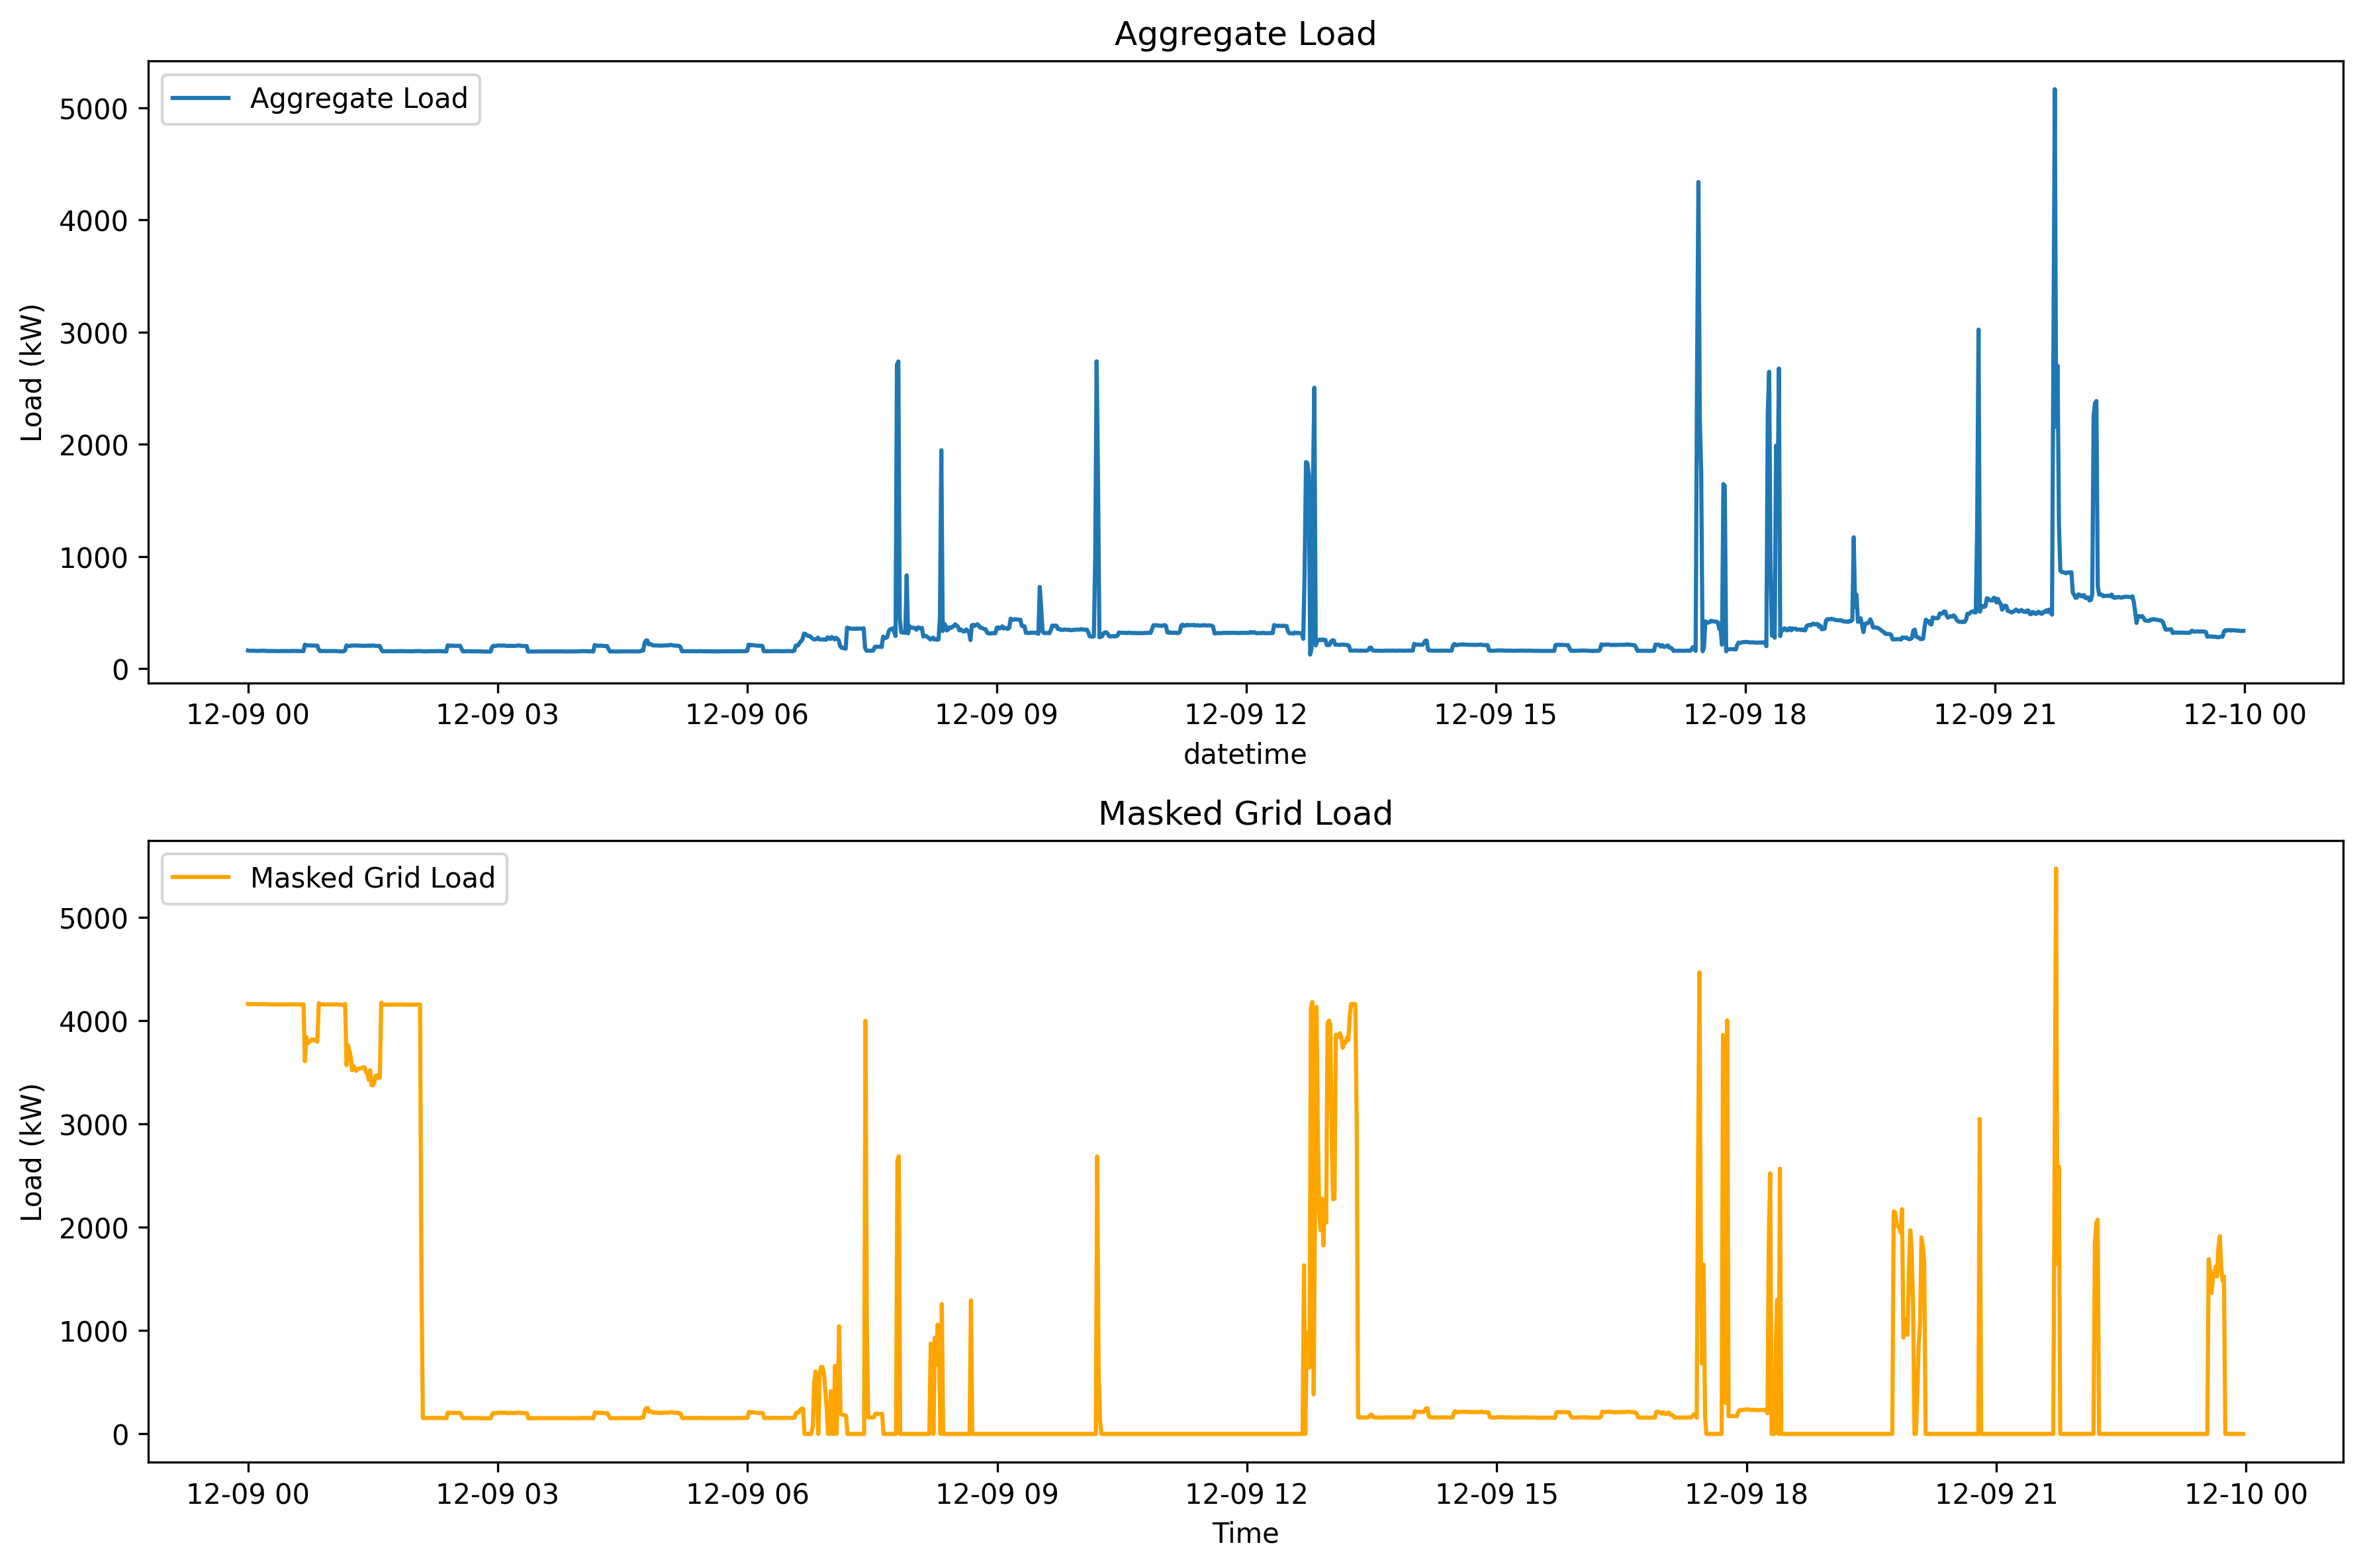

In [ ]:
# create a plot with two subplots
# on top plot the aggregate load
# on bottom plot the masked grid load
# to better visualize the difference between the two

import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=300)
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['aggregate'], ax=ax1, label='Aggregate Load')
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['grid_load'], ax=ax2, label='Masked Grid Load', color='orange')

ax1.set_title('Aggregate Load')
ax1.set_ylabel('Load (kW)')
ax1.legend()
ax2.set_title('Masked Grid Load')
ax2.set_xlabel('Time')
ax2.set_ylabel('Load (kW)')
ax2.legend()
plt.tight_layout()
plt.show()

In [60]:
# save the graph

env_valid.save_graph(
    {"fname": str(experiment_folder / f"graph_valid_index_{env_valid.selected_idx}.png"),
     "dpi": 300}
)

In [55]:
env_valid.close()

[2025-07-18 03:31:54:177] [SmartMeterWorld] Environment closed.


---

In [ ]:
# load the model & environment
import sys
sys.path.append(str(Path('rl_env')))

from rl_env.hrl_env import SmartMeterWorld
from stable_baselines3 import PPO
from model.H_network.h_network_arch import HNetworkType

env_test = SmartMeterWorld(
    sm_dl_test,
    h_model_type=HNetworkType.H_NETWORK,
    render_mode="human",
)

env_test.set_h_network(h_network)
env_test.set_h_network_stdscaler(h_network_stdscaler)

rl_model_path = Path("rl_model", "PPO", f"{datetime(2025,7,12,18,25,2).strftime('%Y%m%d_%H%M%S')}", "rl_model.zip")
rl_model_loaded = PPO.load(rl_model_path, env=env_test)

In [ ]:
obs, info = env_test.reset(43)

In [ ]:
info

In [ ]:
env_test.reset_render_window()

In [ ]:
env_test.episode.df

In [ ]:
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model_loaded.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_test.step(action)
        print_log(f"Step: {env_test.episode.get_current_step()}, Action: {action}, Reward: {reward}, Info: {info}")
        env_test.render()

In [ ]:
env_test.save_graph(
    str(Path("rl_model", "PPO", f"{rl_datetime.strftime('%Y%m%d_%H%M%S')}", "graph_test.png"))
)

In [ ]:
env_test.close()